## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (512, 217)
Hypercube shape: (512, 217, 204)


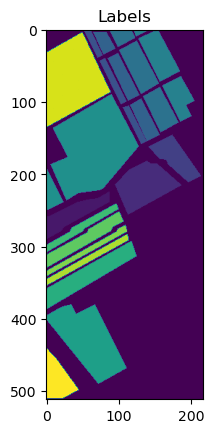

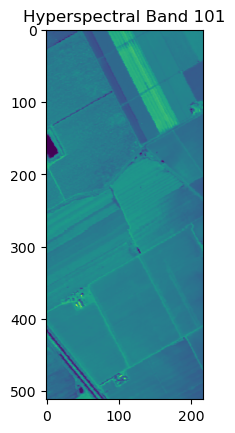

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'Salinas_gt.mat'
data_files = 'Salinas_corrected.mat'
label_files = 'salinas_gt'
hypercube_files = 'salinas_corrected'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 54129
Extracted windows shape: (54129, 5, 5, 204)
Corresponding labels shape: (54129,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 10)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 2009 samples
Shuffled class indices for class '1'
Selected 10 training samples and 5 validation samples for class '1'

Class: 2: Found 3726 samples
Shuffled class indices for class '2'
Selected 10 training samples and 5 validation samples for class '2'

Class: 3: Found 1976 samples
Shuffled class indices for class '3'
Selected 10 training samples and 5 validation samples for class '3'

Class: 4: Found 1394 samples
Shuffled class indices for class '4'
Selected 10 training samples and 5 validation samples for class '4'

Class: 5: Found 2678 samples
Shuffled class indices for class '5'
Selected 10 training samples and 5 validation samples for class '5'

Class: 6: Found 3959 samples
Shuffled class indices for class '6'
Selected 10 training samples and 5 validation samples for class '6'

Class: 7: Found 3579 samples
Shuffled class indices fo


 -- Test set created with: 
	53889 samples
	shape (53889, 5, 5, 204) --




All datasets saved to the 'indices' folder.
(160, 5, 5, 204)
(80, 5, 5, 204)
(53889, 5, 5, 204)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 1 applied
DataLoaders created successfully!
Training batch size: 160
Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10, 10: 10, 11: 10, 12: 10, 13: 10, 14: 10, 15: 10}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (43303, 5, 5, 204)
Validation data shape: (10826, 5, 5, 204)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

204


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/677], Loss: 0.1563, PSNR: 7.1580


	 Training Batch [200/677], Loss: 0.0894, PSNR: 9.6175


	 Training Batch [400/677], Loss: 0.0427, PSNR: 12.8090


	 Training Batch [600/677], Loss: 0.0271, PSNR: 14.8010


Epoch [1/50] Training Loss: 0.0668, PSNR: 11.6322
	[Val]   Batch [1/170] Loss: 0.0213, PSNR: 15.8047
	[Val]   Batch [10/170] Loss: 0.0209, PSNR: 15.9708
	[Val]   Batch [20/170] Loss: 0.0211, PSNR: 15.8669
	[Val]   Batch [30/170] Loss: 0.0218, PSNR: 15.6636
	[Val]   Batch [40/170] Loss: 0.0219, PSNR: 15.7426


	[Val]   Batch [50/170] Loss: 0.0207, PSNR: 15.9430
	[Val]   Batch [60/170] Loss: 0.0217, PSNR: 15.8232
	[Val]   Batch [70/170] Loss: 0.0212, PSNR: 15.9131
	[Val]   Batch [80/170] Loss: 0.0216, PSNR: 15.7265
	[Val]   Batch [90/170] Loss: 0.0209, PSNR: 15.9685


	[Val]   Batch [100/170] Loss: 0.0210, PSNR: 15.8939
	[Val]   Batch [110/170] Loss: 0.0210, PSNR: 15.8696
	[Val]   Batch [120/170] Loss: 0.0198, PSNR: 14.1811
	[Val]   Batch [130/170] Loss: 0.0209, PSNR: 15.9752
	[Val]   Batch [140/170] Loss: 0.0205, PSNR: 16.0211


	[Val]   Batch [150/170] Loss: 0.0219, PSNR: 15.7729
	[Val]   Batch [160/170] Loss: 0.0216, PSNR: 15.8059
	[Val]   Batch [170/170] Loss: 0.0224, PSNR: 15.0876
Epoch [1/50] Validation Loss: 0.0213, PSNR: 15.7937

LOG: Epoch [2/50]
	 Training Batch [1/677], Loss: 0.0212, PSNR: 15.9297


	 Training Batch [200/677], Loss: 0.0150, PSNR: 17.3522


	 Training Batch [400/677], Loss: 0.0126, PSNR: 18.1619


	 Training Batch [600/677], Loss: 0.0096, PSNR: 19.3116


Epoch [2/50] Training Loss: 0.0131, PSNR: 18.0629
	[Val]   Batch [1/170] Loss: 0.0088, PSNR: 19.6257
	[Val]   Batch [10/170] Loss: 0.0083, PSNR: 19.9688
	[Val]   Batch [20/170] Loss: 0.0085, PSNR: 19.8312
	[Val]   Batch [30/170] Loss: 0.0091, PSNR: 19.4358
	[Val]   Batch [40/170] Loss: 0.0094, PSNR: 19.4229
	[Val]   Batch [50/170] Loss: 0.0082, PSNR: 19.9903


	[Val]   Batch [60/170] Loss: 0.0091, PSNR: 19.5746
	[Val]   Batch [70/170] Loss: 0.0089, PSNR: 19.6795
	[Val]   Batch [80/170] Loss: 0.0090, PSNR: 19.5284
	[Val]   Batch [90/170] Loss: 0.0086, PSNR: 19.8297
	[Val]   Batch [100/170] Loss: 0.0086, PSNR: 19.7494


	[Val]   Batch [110/170] Loss: 0.0085, PSNR: 19.8027
	[Val]   Batch [120/170] Loss: 0.0074, PSNR: 18.4603
	[Val]   Batch [130/170] Loss: 0.0086, PSNR: 19.8355
	[Val]   Batch [140/170] Loss: 0.0080, PSNR: 20.1162
	[Val]   Batch [150/170] Loss: 0.0094, PSNR: 19.4648


	[Val]   Batch [160/170] Loss: 0.0091, PSNR: 19.5622
	[Val]   Batch [170/170] Loss: 0.0094, PSNR: 18.8575
Epoch [2/50] Validation Loss: 0.0087, PSNR: 19.6685

LOG: Epoch [3/50]
	 Training Batch [1/677], Loss: 0.0088, PSNR: 19.5851


	 Training Batch [200/677], Loss: 0.0071, PSNR: 20.6155


	 Training Batch [400/677], Loss: 0.0057, PSNR: 21.1013


	 Training Batch [600/677], Loss: 0.0053, PSNR: 21.5680


Epoch [3/50] Training Loss: 0.0067, PSNR: 20.8447
	[Val]   Batch [1/170] Loss: 0.0053, PSNR: 21.8819
	[Val]   Batch [10/170] Loss: 0.0049, PSNR: 22.2809
	[Val]   Batch [20/170] Loss: 0.0050, PSNR: 22.1250
	[Val]   Batch [30/170] Loss: 0.0055, PSNR: 21.6731
	[Val]   Batch [40/170] Loss: 0.0057, PSNR: 21.6175


	[Val]   Batch [50/170] Loss: 0.0048, PSNR: 22.3099
	[Val]   Batch [60/170] Loss: 0.0055, PSNR: 21.8032
	[Val]   Batch [70/170] Loss: 0.0053, PSNR: 21.9034
	[Val]   Batch [80/170] Loss: 0.0054, PSNR: 21.7835


	[Val]   Batch [90/170] Loss: 0.0051, PSNR: 22.0785
	[Val]   Batch [100/170] Loss: 0.0051, PSNR: 21.9895
	[Val]   Batch [110/170] Loss: 0.0050, PSNR: 22.0759
	[Val]   Batch [120/170] Loss: 0.0043, PSNR: 20.8467
	[Val]   Batch [130/170] Loss: 0.0051, PSNR: 22.0853


	[Val]   Batch [140/170] Loss: 0.0046, PSNR: 22.4709
	[Val]   Batch [150/170] Loss: 0.0056, PSNR: 21.6808
	[Val]   Batch [160/170] Loss: 0.0054, PSNR: 21.7887
	[Val]   Batch [170/170] Loss: 0.0056, PSNR: 21.1352
Epoch [3/50] Validation Loss: 0.0052, PSNR: 21.9393

LOG: Epoch [4/50]
	 Training Batch [1/677], Loss: 0.0045, PSNR: 22.6393


	 Training Batch [200/677], Loss: 0.0042, PSNR: 22.9350


	 Training Batch [400/677], Loss: 0.0035, PSNR: 23.7262


	 Training Batch [600/677], Loss: 0.0033, PSNR: 23.9172


Epoch [4/50] Training Loss: 0.0040, PSNR: 23.1569
	[Val]   Batch [1/170] Loss: 0.0029, PSNR: 24.4745
	[Val]   Batch [10/170] Loss: 0.0028, PSNR: 24.7631
	[Val]   Batch [20/170] Loss: 0.0028, PSNR: 24.6116
	[Val]   Batch [30/170] Loss: 0.0031, PSNR: 24.1691
	[Val]   Batch [40/170] Loss: 0.0031, PSNR: 24.2911


	[Val]   Batch [50/170] Loss: 0.0028, PSNR: 24.6741
	[Val]   Batch [60/170] Loss: 0.0030, PSNR: 24.3711
	[Val]   Batch [70/170] Loss: 0.0029, PSNR: 24.5428
	[Val]   Batch [80/170] Loss: 0.0029, PSNR: 24.3990


	[Val]   Batch [90/170] Loss: 0.0029, PSNR: 24.5861
	[Val]   Batch [100/170] Loss: 0.0030, PSNR: 24.3794
	[Val]   Batch [110/170] Loss: 0.0028, PSNR: 24.6102
	[Val]   Batch [120/170] Loss: 0.0026, PSNR: 23.0008
	[Val]   Batch [130/170] Loss: 0.0030, PSNR: 24.4580


	[Val]   Batch [140/170] Loss: 0.0026, PSNR: 24.9289
	[Val]   Batch [150/170] Loss: 0.0031, PSNR: 24.3048
	[Val]   Batch [160/170] Loss: 0.0030, PSNR: 24.4015
	[Val]   Batch [170/170] Loss: 0.0031, PSNR: 23.7107
Epoch [4/50] Validation Loss: 0.0029, PSNR: 24.4543

LOG: Epoch [5/50]
	 Training Batch [1/677], Loss: 0.0030, PSNR: 24.2714


	 Training Batch [200/677], Loss: 0.0027, PSNR: 24.8581


	 Training Batch [400/677], Loss: 0.0021, PSNR: 25.8849


	 Training Batch [600/677], Loss: 0.0022, PSNR: 25.8123


Epoch [5/50] Training Loss: 0.0025, PSNR: 25.1089
	[Val]   Batch [1/170] Loss: 0.0019, PSNR: 26.2157
	[Val]   Batch [10/170] Loss: 0.0019, PSNR: 26.5068
	[Val]   Batch [20/170] Loss: 0.0019, PSNR: 26.3005
	[Val]   Batch [30/170] Loss: 0.0021, PSNR: 25.8051
	[Val]   Batch [40/170] Loss: 0.0020, PSNR: 26.1309


	[Val]   Batch [50/170] Loss: 0.0019, PSNR: 26.3414
	[Val]   Batch [60/170] Loss: 0.0020, PSNR: 26.0731
	[Val]   Batch [70/170] Loss: 0.0019, PSNR: 26.3555
	[Val]   Batch [80/170] Loss: 0.0020, PSNR: 26.1430
	[Val]   Batch [90/170] Loss: 0.0019, PSNR: 26.3185


	[Val]   Batch [100/170] Loss: 0.0021, PSNR: 25.9840
	[Val]   Batch [110/170] Loss: 0.0018, PSNR: 26.4712
	[Val]   Batch [120/170] Loss: 0.0018, PSNR: 24.5818
	[Val]   Batch [130/170] Loss: 0.0021, PSNR: 26.0455
	[Val]   Batch [140/170] Loss: 0.0018, PSNR: 26.6622


	[Val]   Batch [150/170] Loss: 0.0021, PSNR: 26.0126
	[Val]   Batch [160/170] Loss: 0.0020, PSNR: 26.1513
	[Val]   Batch [170/170] Loss: 0.0021, PSNR: 25.4241
Epoch [5/50] Validation Loss: 0.0020, PSNR: 26.1596

LOG: Epoch [6/50]
	 Training Batch [1/677], Loss: 0.0021, PSNR: 25.8773


	 Training Batch [200/677], Loss: 0.0022, PSNR: 25.8424


	 Training Batch [400/677], Loss: 0.0018, PSNR: 26.5436


	 Training Batch [600/677], Loss: 0.0018, PSNR: 26.5951


Epoch [6/50] Training Loss: 0.0019, PSNR: 26.4387
	[Val]   Batch [1/170] Loss: 0.0014, PSNR: 27.4991
	[Val]   Batch [10/170] Loss: 0.0014, PSNR: 27.7639
	[Val]   Batch [20/170] Loss: 0.0014, PSNR: 27.5195
	[Val]   Batch [30/170] Loss: 0.0016, PSNR: 27.0217
	[Val]   Batch [40/170] Loss: 0.0015, PSNR: 27.4709


	[Val]   Batch [50/170] Loss: 0.0014, PSNR: 27.5162
	[Val]   Batch [60/170] Loss: 0.0015, PSNR: 27.3347
	[Val]   Batch [70/170] Loss: 0.0014, PSNR: 27.6895
	[Val]   Batch [80/170] Loss: 0.0015, PSNR: 27.4283
	[Val]   Batch [90/170] Loss: 0.0014, PSNR: 27.5932


	[Val]   Batch [100/170] Loss: 0.0016, PSNR: 27.1803
	[Val]   Batch [110/170] Loss: 0.0013, PSNR: 27.8433
	[Val]   Batch [120/170] Loss: 0.0014, PSNR: 25.6876
	[Val]   Batch [130/170] Loss: 0.0016, PSNR: 27.2389
	[Val]   Batch [140/170] Loss: 0.0013, PSNR: 27.9194


	[Val]   Batch [150/170] Loss: 0.0016, PSNR: 27.2791
	[Val]   Batch [160/170] Loss: 0.0015, PSNR: 27.4379
	[Val]   Batch [170/170] Loss: 0.0015, PSNR: 26.7182
Epoch [6/50] Validation Loss: 0.0015, PSNR: 27.4105

LOG: Epoch [7/50]
	 Training Batch [1/677], Loss: 0.0016, PSNR: 27.0703


	 Training Batch [200/677], Loss: 0.0017, PSNR: 26.8679


	 Training Batch [400/677], Loss: 0.0016, PSNR: 26.9284


	 Training Batch [600/677], Loss: 0.0015, PSNR: 27.4177


Epoch [7/50] Training Loss: 0.0015, PSNR: 27.4365
	[Val]   Batch [1/170] Loss: 0.0011, PSNR: 28.4835
	[Val]   Batch [10/170] Loss: 0.0011, PSNR: 28.7262
	[Val]   Batch [20/170] Loss: 0.0012, PSNR: 28.4714
	[Val]   Batch [30/170] Loss: 0.0013, PSNR: 27.9280
	[Val]   Batch [40/170] Loss: 0.0012, PSNR: 28.4873


	[Val]   Batch [50/170] Loss: 0.0012, PSNR: 28.4270
	[Val]   Batch [60/170] Loss: 0.0012, PSNR: 28.2764
	[Val]   Batch [70/170] Loss: 0.0011, PSNR: 28.7224
	[Val]   Batch [80/170] Loss: 0.0012, PSNR: 28.3914
	[Val]   Batch [90/170] Loss: 0.0011, PSNR: 28.5850


	[Val]   Batch [100/170] Loss: 0.0013, PSNR: 28.0861
	[Val]   Batch [110/170] Loss: 0.0010, PSNR: 28.8915
	[Val]   Batch [120/170] Loss: 0.0011, PSNR: 26.6103
	[Val]   Batch [130/170] Loss: 0.0013, PSNR: 28.1459
	[Val]   Batch [140/170] Loss: 0.0011, PSNR: 28.9193


	[Val]   Batch [150/170] Loss: 0.0013, PSNR: 28.1967
	[Val]   Batch [160/170] Loss: 0.0012, PSNR: 28.4120
	[Val]   Batch [170/170] Loss: 0.0012, PSNR: 27.6805
Epoch [7/50] Validation Loss: 0.0012, PSNR: 28.3643

LOG: Epoch [8/50]
	 Training Batch [1/677], Loss: 0.0014, PSNR: 27.2506


	 Training Batch [200/677], Loss: 0.0015, PSNR: 27.3763


	 Training Batch [400/677], Loss: 0.0011, PSNR: 28.9467


	 Training Batch [600/677], Loss: 0.0013, PSNR: 27.9626


Epoch [8/50] Training Loss: 0.0012, PSNR: 28.2589
	[Val]   Batch [1/170] Loss: 0.0009, PSNR: 29.3205
	[Val]   Batch [10/170] Loss: 0.0009, PSNR: 29.5717
	[Val]   Batch [20/170] Loss: 0.0010, PSNR: 29.2968
	[Val]   Batch [30/170] Loss: 0.0011, PSNR: 28.7089
	[Val]   Batch [40/170] Loss: 0.0010, PSNR: 29.3458


	[Val]   Batch [50/170] Loss: 0.0010, PSNR: 29.2058
	[Val]   Batch [60/170] Loss: 0.0010, PSNR: 29.0929
	[Val]   Batch [70/170] Loss: 0.0009, PSNR: 29.6081
	[Val]   Batch [80/170] Loss: 0.0010, PSNR: 29.2494
	[Val]   Batch [90/170] Loss: 0.0009, PSNR: 29.4644


	[Val]   Batch [100/170] Loss: 0.0010, PSNR: 28.9014
	[Val]   Batch [110/170] Loss: 0.0009, PSNR: 29.7939
	[Val]   Batch [120/170] Loss: 0.0010, PSNR: 27.3713
	[Val]   Batch [130/170] Loss: 0.0010, PSNR: 28.9691
	[Val]   Batch [140/170] Loss: 0.0009, PSNR: 29.7735


	[Val]   Batch [150/170] Loss: 0.0010, PSNR: 28.9940
	[Val]   Batch [160/170] Loss: 0.0010, PSNR: 29.2395
	[Val]   Batch [170/170] Loss: 0.0010, PSNR: 28.5116
Epoch [8/50] Validation Loss: 0.0010, PSNR: 29.1858

LOG: Epoch [9/50]
	 Training Batch [1/677], Loss: 0.0012, PSNR: 28.3748


	 Training Batch [200/677], Loss: 0.0010, PSNR: 28.9283


	 Training Batch [400/677], Loss: 0.0009, PSNR: 29.7629


	 Training Batch [600/677], Loss: 0.0010, PSNR: 29.1241


Epoch [9/50] Training Loss: 0.0010, PSNR: 28.9575
	[Val]   Batch [1/170] Loss: 0.0007, PSNR: 30.3678
	[Val]   Batch [10/170] Loss: 0.0007, PSNR: 30.6567
	[Val]   Batch [20/170] Loss: 0.0008, PSNR: 30.3371
	[Val]   Batch [30/170] Loss: 0.0009, PSNR: 29.7502
	[Val]   Batch [40/170] Loss: 0.0007, PSNR: 30.4391


	[Val]   Batch [50/170] Loss: 0.0008, PSNR: 30.2004
	[Val]   Batch [60/170] Loss: 0.0008, PSNR: 30.1351
	[Val]   Batch [70/170] Loss: 0.0007, PSNR: 30.6549
	[Val]   Batch [80/170] Loss: 0.0007, PSNR: 30.3514
	[Val]   Batch [90/170] Loss: 0.0007, PSNR: 30.5319


	[Val]   Batch [100/170] Loss: 0.0008, PSNR: 29.8885
	[Val]   Batch [110/170] Loss: 0.0007, PSNR: 30.9173
	[Val]   Batch [120/170] Loss: 0.0008, PSNR: 28.3169
	[Val]   Batch [130/170] Loss: 0.0008, PSNR: 29.9545


	[Val]   Batch [140/170] Loss: 0.0007, PSNR: 30.8635
	[Val]   Batch [150/170] Loss: 0.0008, PSNR: 30.0307
	[Val]   Batch [160/170] Loss: 0.0008, PSNR: 30.2571
	[Val]   Batch [170/170] Loss: 0.0008, PSNR: 29.6771
Epoch [9/50] Validation Loss: 0.0008, PSNR: 30.2311

LOG: Epoch [10/50]
	 Training Batch [1/677], Loss: 0.0010, PSNR: 29.2097


	 Training Batch [200/677], Loss: 0.0009, PSNR: 29.5535


	 Training Batch [400/677], Loss: 0.0009, PSNR: 29.6570


	 Training Batch [600/677], Loss: 0.0008, PSNR: 29.9605


Epoch [10/50] Training Loss: 0.0009, PSNR: 29.5958
	[Val]   Batch [1/170] Loss: 0.0007, PSNR: 30.8671
	[Val]   Batch [10/170] Loss: 0.0006, PSNR: 31.1514
	[Val]   Batch [20/170] Loss: 0.0007, PSNR: 30.8021
	[Val]   Batch [30/170] Loss: 0.0008, PSNR: 30.2465
	[Val]   Batch [40/170] Loss: 0.0007, PSNR: 30.9326


	[Val]   Batch [50/170] Loss: 0.0007, PSNR: 30.6625
	[Val]   Batch [60/170] Loss: 0.0007, PSNR: 30.6313
	[Val]   Batch [70/170] Loss: 0.0006, PSNR: 31.1722
	[Val]   Batch [80/170] Loss: 0.0007, PSNR: 30.8529
	[Val]   Batch [90/170] Loss: 0.0006, PSNR: 31.1016


	[Val]   Batch [100/170] Loss: 0.0007, PSNR: 30.4851
	[Val]   Batch [110/170] Loss: 0.0006, PSNR: 31.4251
	[Val]   Batch [120/170] Loss: 0.0007, PSNR: 28.8925
	[Val]   Batch [130/170] Loss: 0.0007, PSNR: 30.5408
	[Val]   Batch [140/170] Loss: 0.0006, PSNR: 31.3719


	[Val]   Batch [150/170] Loss: 0.0007, PSNR: 30.5309
	[Val]   Batch [160/170] Loss: 0.0007, PSNR: 30.7444
	[Val]   Batch [170/170] Loss: 0.0007, PSNR: 30.2068
Epoch [10/50] Validation Loss: 0.0007, PSNR: 30.7338

LOG: Epoch [11/50]
	 Training Batch [1/677], Loss: 0.0009, PSNR: 29.3441


	 Training Batch [200/677], Loss: 0.0009, PSNR: 29.7230


	 Training Batch [400/677], Loss: 0.0007, PSNR: 30.6782


	 Training Batch [600/677], Loss: 0.0007, PSNR: 30.4906


Epoch [11/50] Training Loss: 0.0008, PSNR: 30.1471
	[Val]   Batch [1/170] Loss: 0.0005, PSNR: 31.7768
	[Val]   Batch [10/170] Loss: 0.0005, PSNR: 32.1033
	[Val]   Batch [20/170] Loss: 0.0006, PSNR: 31.6672
	[Val]   Batch [30/170] Loss: 0.0006, PSNR: 31.1906
	[Val]   Batch [40/170] Loss: 0.0005, PSNR: 31.8806


	[Val]   Batch [50/170] Loss: 0.0006, PSNR: 31.4878
	[Val]   Batch [60/170] Loss: 0.0006, PSNR: 31.5778
	[Val]   Batch [70/170] Loss: 0.0005, PSNR: 32.0649
	[Val]   Batch [80/170] Loss: 0.0005, PSNR: 31.8413
	[Val]   Batch [90/170] Loss: 0.0005, PSNR: 32.0543


	[Val]   Batch [100/170] Loss: 0.0006, PSNR: 31.4040
	[Val]   Batch [110/170] Loss: 0.0005, PSNR: 32.3730
	[Val]   Batch [120/170] Loss: 0.0006, PSNR: 29.6468
	[Val]   Batch [130/170] Loss: 0.0006, PSNR: 31.4851
	[Val]   Batch [140/170] Loss: 0.0005, PSNR: 32.2677


	[Val]   Batch [150/170] Loss: 0.0006, PSNR: 31.5064
	[Val]   Batch [160/170] Loss: 0.0006, PSNR: 31.6456
	[Val]   Batch [170/170] Loss: 0.0005, PSNR: 31.3498
Epoch [11/50] Validation Loss: 0.0006, PSNR: 31.6598

LOG: Epoch [12/50]
	 Training Batch [1/677], Loss: 0.0007, PSNR: 30.7253


	 Training Batch [200/677], Loss: 0.0008, PSNR: 30.3705


	 Training Batch [400/677], Loss: 0.0007, PSNR: 30.4757


	 Training Batch [600/677], Loss: 0.0007, PSNR: 30.5426


Epoch [12/50] Training Loss: 0.0007, PSNR: 30.6589
	[Val]   Batch [1/170] Loss: 0.0005, PSNR: 32.3932
	[Val]   Batch [10/170] Loss: 0.0004, PSNR: 32.6910
	[Val]   Batch [20/170] Loss: 0.0005, PSNR: 32.2420
	[Val]   Batch [30/170] Loss: 0.0005, PSNR: 31.8329
	[Val]   Batch [40/170] Loss: 0.0005, PSNR: 32.5008


	[Val]   Batch [50/170] Loss: 0.0005, PSNR: 32.0704
	[Val]   Batch [60/170] Loss: 0.0005, PSNR: 32.2053
	[Val]   Batch [70/170] Loss: 0.0004, PSNR: 32.6473
	[Val]   Batch [80/170] Loss: 0.0005, PSNR: 32.4617
	[Val]   Batch [90/170] Loss: 0.0004, PSNR: 32.7189


	[Val]   Batch [100/170] Loss: 0.0005, PSNR: 32.0738
	[Val]   Batch [110/170] Loss: 0.0004, PSNR: 32.9745
	[Val]   Batch [120/170] Loss: 0.0005, PSNR: 30.2829
	[Val]   Batch [130/170] Loss: 0.0005, PSNR: 32.1347
	[Val]   Batch [140/170] Loss: 0.0004, PSNR: 32.8736


	[Val]   Batch [150/170] Loss: 0.0005, PSNR: 32.1409
	[Val]   Batch [160/170] Loss: 0.0005, PSNR: 32.2200
	[Val]   Batch [170/170] Loss: 0.0005, PSNR: 31.9677
Epoch [12/50] Validation Loss: 0.0005, PSNR: 32.2695

LOG: Epoch [13/50]
	 Training Batch [1/677], Loss: 0.0009, PSNR: 29.8460


	 Training Batch [200/677], Loss: 0.0007, PSNR: 30.5959


	 Training Batch [400/677], Loss: 0.0006, PSNR: 31.3022


	 Training Batch [600/677], Loss: 0.0006, PSNR: 31.2757


Epoch [13/50] Training Loss: 0.0006, PSNR: 31.1525
	[Val]   Batch [1/170] Loss: 0.0004, PSNR: 33.0713
	[Val]   Batch [10/170] Loss: 0.0004, PSNR: 33.3991
	[Val]   Batch [20/170] Loss: 0.0004, PSNR: 32.9319
	[Val]   Batch [30/170] Loss: 0.0004, PSNR: 32.5793
	[Val]   Batch [40/170] Loss: 0.0004, PSNR: 33.1935


	[Val]   Batch [50/170] Loss: 0.0004, PSNR: 32.6745
	[Val]   Batch [60/170] Loss: 0.0004, PSNR: 32.9457
	[Val]   Batch [70/170] Loss: 0.0004, PSNR: 33.2994
	[Val]   Batch [80/170] Loss: 0.0004, PSNR: 33.2094
	[Val]   Batch [90/170] Loss: 0.0004, PSNR: 33.4588


	[Val]   Batch [100/170] Loss: 0.0004, PSNR: 32.8346
	[Val]   Batch [110/170] Loss: 0.0003, PSNR: 33.7008
	[Val]   Batch [120/170] Loss: 0.0004, PSNR: 30.9383
	[Val]   Batch [130/170] Loss: 0.0004, PSNR: 32.9128
	[Val]   Batch [140/170] Loss: 0.0004, PSNR: 33.5655


	[Val]   Batch [150/170] Loss: 0.0004, PSNR: 32.9106
	[Val]   Batch [160/170] Loss: 0.0004, PSNR: 32.8748
	[Val]   Batch [170/170] Loss: 0.0004, PSNR: 32.9030
Epoch [13/50] Validation Loss: 0.0004, PSNR: 32.9907

LOG: Epoch [14/50]
	 Training Batch [1/677], Loss: 0.0006, PSNR: 30.9251


	 Training Batch [200/677], Loss: 0.0006, PSNR: 31.2616


	 Training Batch [400/677], Loss: 0.0005, PSNR: 31.3345


	 Training Batch [600/677], Loss: 0.0006, PSNR: 31.3669


Epoch [14/50] Training Loss: 0.0006, PSNR: 31.5099
	[Val]   Batch [1/170] Loss: 0.0004, PSNR: 33.5445
	[Val]   Batch [10/170] Loss: 0.0003, PSNR: 33.8766
	[Val]   Batch [20/170] Loss: 0.0004, PSNR: 33.3631
	[Val]   Batch [30/170] Loss: 0.0004, PSNR: 33.0844
	[Val]   Batch [40/170] Loss: 0.0004, PSNR: 33.6294


	[Val]   Batch [50/170] Loss: 0.0004, PSNR: 33.1143
	[Val]   Batch [60/170] Loss: 0.0004, PSNR: 33.4273
	[Val]   Batch [70/170] Loss: 0.0004, PSNR: 33.7321
	[Val]   Batch [80/170] Loss: 0.0003, PSNR: 33.6885
	[Val]   Batch [90/170] Loss: 0.0003, PSNR: 33.9633


	[Val]   Batch [100/170] Loss: 0.0004, PSNR: 33.3701
	[Val]   Batch [110/170] Loss: 0.0003, PSNR: 34.1470
	[Val]   Batch [120/170] Loss: 0.0004, PSNR: 31.4020
	[Val]   Batch [130/170] Loss: 0.0004, PSNR: 33.4393
	[Val]   Batch [140/170] Loss: 0.0003, PSNR: 33.9998


	[Val]   Batch [150/170] Loss: 0.0004, PSNR: 33.4063
	[Val]   Batch [160/170] Loss: 0.0004, PSNR: 33.3096
	[Val]   Batch [170/170] Loss: 0.0003, PSNR: 33.4926
Epoch [14/50] Validation Loss: 0.0004, PSNR: 33.4628

LOG: Epoch [15/50]
	 Training Batch [1/677], Loss: 0.0005, PSNR: 31.9833


	 Training Batch [200/677], Loss: 0.0005, PSNR: 32.1067


	 Training Batch [400/677], Loss: 0.0007, PSNR: 30.5953


	 Training Batch [600/677], Loss: 0.0006, PSNR: 31.6802


Epoch [15/50] Training Loss: 0.0005, PSNR: 31.9160
	[Val]   Batch [1/170] Loss: 0.0003, PSNR: 33.8462
	[Val]   Batch [10/170] Loss: 0.0003, PSNR: 34.1463
	[Val]   Batch [20/170] Loss: 0.0004, PSNR: 33.6187
	[Val]   Batch [30/170] Loss: 0.0004, PSNR: 33.4221
	[Val]   Batch [40/170] Loss: 0.0003, PSNR: 33.9446


	[Val]   Batch [50/170] Loss: 0.0004, PSNR: 33.4160
	[Val]   Batch [60/170] Loss: 0.0003, PSNR: 33.7613
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 33.9729
	[Val]   Batch [80/170] Loss: 0.0003, PSNR: 33.9702


	[Val]   Batch [90/170] Loss: 0.0003, PSNR: 34.3398
	[Val]   Batch [100/170] Loss: 0.0003, PSNR: 33.7215
	[Val]   Batch [110/170] Loss: 0.0003, PSNR: 34.4141
	[Val]   Batch [120/170] Loss: 0.0003, PSNR: 31.7844
	[Val]   Batch [130/170] Loss: 0.0003, PSNR: 33.7987


	[Val]   Batch [140/170] Loss: 0.0003, PSNR: 34.3017
	[Val]   Batch [150/170] Loss: 0.0004, PSNR: 33.7161
	[Val]   Batch [160/170] Loss: 0.0004, PSNR: 33.5450
	[Val]   Batch [170/170] Loss: 0.0003, PSNR: 33.7211
Epoch [15/50] Validation Loss: 0.0003, PSNR: 33.7539

LOG: Epoch [16/50]
	 Training Batch [1/677], Loss: 0.0006, PSNR: 30.9980


	 Training Batch [200/677], Loss: 0.0006, PSNR: 31.3182


	 Training Batch [400/677], Loss: 0.0005, PSNR: 31.7850


	 Training Batch [600/677], Loss: 0.0005, PSNR: 32.4387


Epoch [16/50] Training Loss: 0.0005, PSNR: 32.2070
	[Val]   Batch [1/170] Loss: 0.0003, PSNR: 34.3723
	[Val]   Batch [10/170] Loss: 0.0003, PSNR: 34.7408
	[Val]   Batch [20/170] Loss: 0.0003, PSNR: 34.1608
	[Val]   Batch [30/170] Loss: 0.0003, PSNR: 33.9932
	[Val]   Batch [40/170] Loss: 0.0003, PSNR: 34.5234
	[Val]   Batch [50/170] Loss: 0.0003, PSNR: 33.8890


	[Val]   Batch [60/170] Loss: 0.0003, PSNR: 34.3578
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 34.5090
	[Val]   Batch [80/170] Loss: 0.0003, PSNR: 34.5792
	[Val]   Batch [90/170] Loss: 0.0003, PSNR: 34.9184


	[Val]   Batch [100/170] Loss: 0.0003, PSNR: 34.3018
	[Val]   Batch [110/170] Loss: 0.0003, PSNR: 34.9965
	[Val]   Batch [120/170] Loss: 0.0003, PSNR: 32.2799
	[Val]   Batch [130/170] Loss: 0.0003, PSNR: 34.4031
	[Val]   Batch [140/170] Loss: 0.0003, PSNR: 34.8498


	[Val]   Batch [150/170] Loss: 0.0003, PSNR: 34.3486
	[Val]   Batch [160/170] Loss: 0.0003, PSNR: 34.0693
	[Val]   Batch [170/170] Loss: 0.0003, PSNR: 34.4599
Epoch [16/50] Validation Loss: 0.0003, PSNR: 34.3147

LOG: Epoch [17/50]
	 Training Batch [1/677], Loss: 0.0005, PSNR: 32.2008


	 Training Batch [200/677], Loss: 0.0004, PSNR: 32.8937


	 Training Batch [400/677], Loss: 0.0004, PSNR: 33.3299


	 Training Batch [600/677], Loss: 0.0004, PSNR: 33.1468


Epoch [17/50] Training Loss: 0.0005, PSNR: 32.5124
	[Val]   Batch [1/170] Loss: 0.0003, PSNR: 34.8566
	[Val]   Batch [10/170] Loss: 0.0002, PSNR: 35.2120
	[Val]   Batch [20/170] Loss: 0.0003, PSNR: 34.5748
	[Val]   Batch [30/170] Loss: 0.0003, PSNR: 34.5086
	[Val]   Batch [40/170] Loss: 0.0003, PSNR: 34.9323


	[Val]   Batch [50/170] Loss: 0.0003, PSNR: 34.3442
	[Val]   Batch [60/170] Loss: 0.0003, PSNR: 34.8361
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 34.9248
	[Val]   Batch [80/170] Loss: 0.0003, PSNR: 35.0634
	[Val]   Batch [90/170] Loss: 0.0002, PSNR: 35.4097


	[Val]   Batch [100/170] Loss: 0.0003, PSNR: 34.8066
	[Val]   Batch [110/170] Loss: 0.0002, PSNR: 35.4625
	[Val]   Batch [120/170] Loss: 0.0003, PSNR: 32.7281
	[Val]   Batch [130/170] Loss: 0.0003, PSNR: 34.9223
	[Val]   Batch [140/170] Loss: 0.0002, PSNR: 35.3371


	[Val]   Batch [150/170] Loss: 0.0003, PSNR: 34.8346
	[Val]   Batch [160/170] Loss: 0.0003, PSNR: 34.4839
	[Val]   Batch [170/170] Loss: 0.0002, PSNR: 35.0532
Epoch [17/50] Validation Loss: 0.0003, PSNR: 34.7840

LOG: Epoch [18/50]
	 Training Batch [1/677], Loss: 0.0005, PSNR: 32.3509


	 Training Batch [200/677], Loss: 0.0004, PSNR: 32.9485


	 Training Batch [400/677], Loss: 0.0004, PSNR: 33.0408


	 Training Batch [600/677], Loss: 0.0004, PSNR: 33.4344


Epoch [18/50] Training Loss: 0.0004, PSNR: 32.7812
	[Val]   Batch [1/170] Loss: 0.0003, PSNR: 35.1031
	[Val]   Batch [10/170] Loss: 0.0002, PSNR: 35.5121
	[Val]   Batch [20/170] Loss: 0.0003, PSNR: 34.8795
	[Val]   Batch [30/170] Loss: 0.0003, PSNR: 34.8151
	[Val]   Batch [40/170] Loss: 0.0002, PSNR: 35.2421


	[Val]   Batch [50/170] Loss: 0.0003, PSNR: 34.5191
	[Val]   Batch [60/170] Loss: 0.0003, PSNR: 35.1791
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 35.1655
	[Val]   Batch [80/170] Loss: 0.0002, PSNR: 35.4145


	[Val]   Batch [90/170] Loss: 0.0002, PSNR: 35.7048
	[Val]   Batch [100/170] Loss: 0.0002, PSNR: 35.1383
	[Val]   Batch [110/170] Loss: 0.0002, PSNR: 35.7520
	[Val]   Batch [120/170] Loss: 0.0003, PSNR: 32.9600
	[Val]   Batch [130/170] Loss: 0.0002, PSNR: 35.2760


	[Val]   Batch [140/170] Loss: 0.0002, PSNR: 35.5706
	[Val]   Batch [150/170] Loss: 0.0002, PSNR: 35.2249
	[Val]   Batch [160/170] Loss: 0.0003, PSNR: 34.7441
	[Val]   Batch [170/170] Loss: 0.0002, PSNR: 35.5126
Epoch [18/50] Validation Loss: 0.0003, PSNR: 35.0792

LOG: Epoch [19/50]
	 Training Batch [1/677], Loss: 0.0006, PSNR: 31.6714


	 Training Batch [200/677], Loss: 0.0005, PSNR: 32.5738


	 Training Batch [400/677], Loss: 0.0004, PSNR: 33.4461


	 Training Batch [600/677], Loss: 0.0004, PSNR: 32.8635


Epoch [19/50] Training Loss: 0.0004, PSNR: 33.0061
	[Val]   Batch [1/170] Loss: 0.0002, PSNR: 35.6731
	[Val]   Batch [10/170] Loss: 0.0002, PSNR: 36.0113
	[Val]   Batch [20/170] Loss: 0.0002, PSNR: 35.3275
	[Val]   Batch [30/170] Loss: 0.0002, PSNR: 35.3543
	[Val]   Batch [40/170] Loss: 0.0002, PSNR: 35.7518


	[Val]   Batch [50/170] Loss: 0.0003, PSNR: 35.0269
	[Val]   Batch [60/170] Loss: 0.0002, PSNR: 35.7091
	[Val]   Batch [70/170] Loss: 0.0002, PSNR: 35.6876
	[Val]   Batch [80/170] Loss: 0.0002, PSNR: 35.9352
	[Val]   Batch [90/170] Loss: 0.0002, PSNR: 36.3014


	[Val]   Batch [100/170] Loss: 0.0002, PSNR: 35.6769
	[Val]   Batch [110/170] Loss: 0.0002, PSNR: 36.3024
	[Val]   Batch [120/170] Loss: 0.0002, PSNR: 33.4792
	[Val]   Batch [130/170] Loss: 0.0002, PSNR: 35.8125
	[Val]   Batch [140/170] Loss: 0.0002, PSNR: 36.1135


	[Val]   Batch [150/170] Loss: 0.0002, PSNR: 35.7089
	[Val]   Batch [160/170] Loss: 0.0002, PSNR: 35.2333
	[Val]   Batch [170/170] Loss: 0.0002, PSNR: 36.0602
Epoch [19/50] Validation Loss: 0.0002, PSNR: 35.5896
Early stopping triggered at epoch 19. No improvement for 3 epochs.


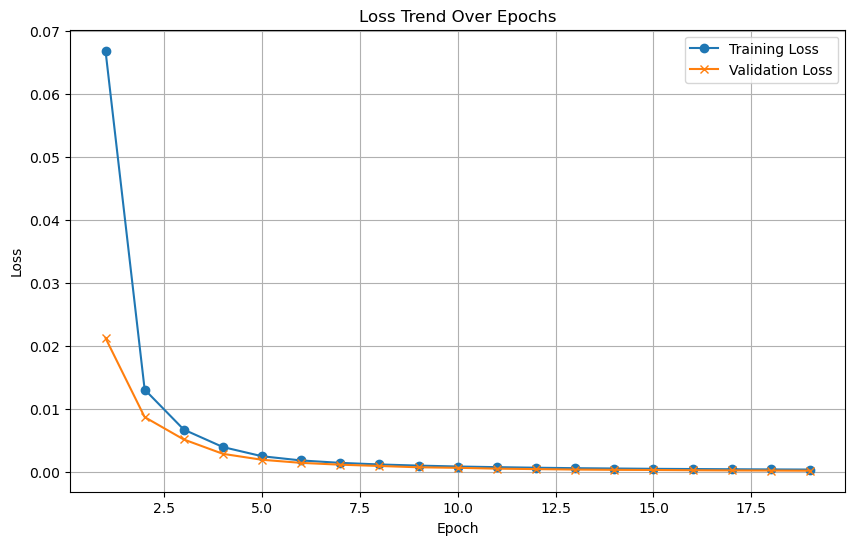

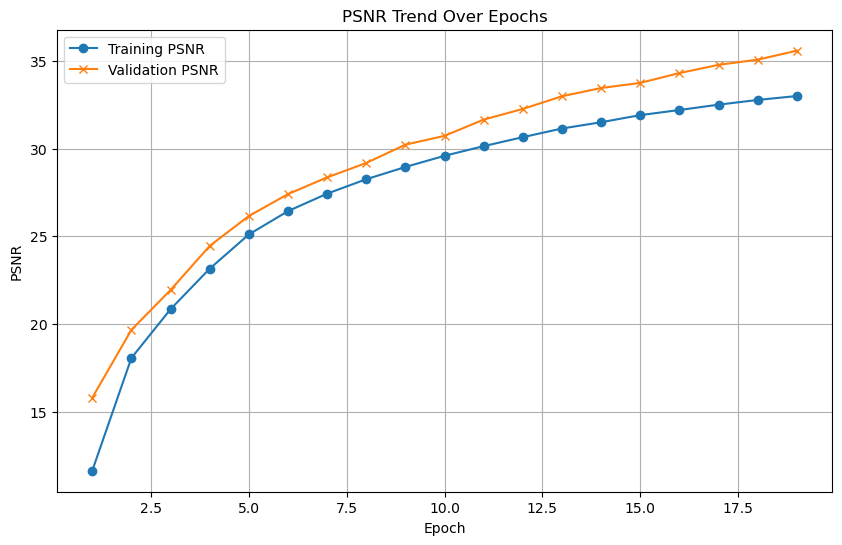

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/211 for test dataset.


    Processed batch 101/211 for test dataset.


    Processed batch 201/211 for test dataset.
Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.7972
    Validation Batch [1/1], Loss: 2.7779
Validation Loss: 2.7779, Validation Accuracy: 6.25%
Validation loss improved from inf to 2.7779. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.7265
    Validation Batch [1/1], Loss: 2.7779
Validation Loss: 2.7779, Validation Accuracy: 6.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.7050
    Validation Batch [1/1], Loss: 2.7779
Validation Loss: 2.7779, Validation Accuracy: 6.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.6753
    Validation Batch [1/1], Loss: 2.7779
Validation Loss: 2.7779, Validation Accuracy: 6.25%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [5/1000] - Training
Epoch [5/1000] completed, Average Tr

Epoch [19/1000] completed, Average Training Loss: 2.4585
    Validation Batch [1/1], Loss: 2.7766
Validation Loss: 2.7766, Validation Accuracy: 6.25%
Validation loss improved from 2.7770 to 2.7766. Saving model...

LOG: Epoch [20/1000] - Training
Epoch [20/1000] completed, Average Training Loss: 2.4553
    Validation Batch [1/1], Loss: 2.7762
Validation Loss: 2.7762, Validation Accuracy: 6.25%
Validation loss improved from 2.7766 to 2.7762. Saving model...

LOG: Epoch [21/1000] - Training
Epoch [21/1000] completed, Average Training Loss: 2.4281
    Validation Batch [1/1], Loss: 2.7757
Validation Loss: 2.7757, Validation Accuracy: 6.25%
Validation loss improved from 2.7762 to 2.7757. Saving model...

LOG: Epoch [22/1000] - Training
Epoch [22/1000] completed, Average Training Loss: 2.4198
    Validation Batch [1/1], Loss: 2.7751
Validation Loss: 2.7751, Validation Accuracy: 6.25%
Validation loss improved from 2.7757 to 2.7751. Saving model...

LOG: Epoch [23/1000] - Training
Epoch [23/10

Epoch [47/1000] completed, Average Training Loss: 2.1939
    Validation Batch [1/1], Loss: 2.6592
Validation Loss: 2.6592, Validation Accuracy: 26.25%
Validation loss improved from 2.6699 to 2.6592. Saving model...

LOG: Epoch [48/1000] - Training
Epoch [48/1000] completed, Average Training Loss: 2.1954
    Validation Batch [1/1], Loss: 2.6419
Validation Loss: 2.6419, Validation Accuracy: 31.25%
Validation loss improved from 2.6592 to 2.6419. Saving model...

LOG: Epoch [49/1000] - Training
Epoch [49/1000] completed, Average Training Loss: 2.1877
    Validation Batch [1/1], Loss: 2.6148
Validation Loss: 2.6148, Validation Accuracy: 35.00%
Validation loss improved from 2.6419 to 2.6148. Saving model...

LOG: Epoch [50/1000] - Training
Epoch [50/1000] completed, Average Training Loss: 2.1526
    Validation Batch [1/1], Loss: 2.5908
Validation Loss: 2.5908, Validation Accuracy: 36.25%
Validation loss improved from 2.6148 to 2.5908. Saving model...

LOG: Epoch [51/1000] - Training
Epoch [5

Epoch [73/1000] completed, Average Training Loss: 1.9563
    Validation Batch [1/1], Loss: 2.1587
Validation Loss: 2.1587, Validation Accuracy: 62.50%
Validation loss improved from 2.1842 to 2.1587. Saving model...

LOG: Epoch [74/1000] - Training
Epoch [74/1000] completed, Average Training Loss: 1.9823
    Validation Batch [1/1], Loss: 2.1375
Validation Loss: 2.1375, Validation Accuracy: 65.00%
Validation loss improved from 2.1587 to 2.1375. Saving model...

LOG: Epoch [75/1000] - Training
Epoch [75/1000] completed, Average Training Loss: 1.9776
    Validation Batch [1/1], Loss: 2.0940
Validation Loss: 2.0940, Validation Accuracy: 68.75%
Validation loss improved from 2.1375 to 2.0940. Saving model...

LOG: Epoch [76/1000] - Training
Epoch [76/1000] completed, Average Training Loss: 1.9478
    Validation Batch [1/1], Loss: 2.0748
Validation Loss: 2.0748, Validation Accuracy: 73.75%
Validation loss improved from 2.0940 to 2.0748. Saving model...

LOG: Epoch [77/1000] - Training
Epoch [7

Epoch [100/1000] completed, Average Training Loss: 1.7669
    Validation Batch [1/1], Loss: 1.7792
Validation Loss: 1.7792, Validation Accuracy: 73.75%
Validation loss improved from 1.8256 to 1.7792. Saving model...

LOG: Epoch [101/1000] - Training
Epoch [101/1000] completed, Average Training Loss: 1.7160
    Validation Batch [1/1], Loss: 1.7759
Validation Loss: 1.7759, Validation Accuracy: 73.75%
Validation loss improved from 1.7792 to 1.7759. Saving model...

LOG: Epoch [102/1000] - Training
Epoch [102/1000] completed, Average Training Loss: 1.7246
    Validation Batch [1/1], Loss: 1.7805
Validation Loss: 1.7805, Validation Accuracy: 75.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [103/1000] - Training
Epoch [103/1000] completed, Average Training Loss: 1.7281
    Validation Batch [1/1], Loss: 1.7902
Validation Loss: 1.7902, Validation Accuracy: 72.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [104/1000] - Training
Epoch [104/1000] completed, Av

Epoch [127/1000] completed, Average Training Loss: 1.4944
    Validation Batch [1/1], Loss: 1.5443
Validation Loss: 1.5443, Validation Accuracy: 78.75%
Validation loss improved from 1.5647 to 1.5443. Saving model...

LOG: Epoch [128/1000] - Training
Epoch [128/1000] completed, Average Training Loss: 1.5060
    Validation Batch [1/1], Loss: 1.5221
Validation Loss: 1.5221, Validation Accuracy: 80.00%
Validation loss improved from 1.5443 to 1.5221. Saving model...

LOG: Epoch [129/1000] - Training
Epoch [129/1000] completed, Average Training Loss: 1.5147
    Validation Batch [1/1], Loss: 1.5361
Validation Loss: 1.5361, Validation Accuracy: 82.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [130/1000] - Training
Epoch [130/1000] completed, Average Training Loss: 1.4640
    Validation Batch [1/1], Loss: 1.5141
Validation Loss: 1.5141, Validation Accuracy: 78.75%
Validation loss improved from 1.5221 to 1.5141. Saving model...

LOG: Epoch [131/1000] - Training
Epoch [131/1000

Epoch [154/1000] completed, Average Training Loss: 1.2772
    Validation Batch [1/1], Loss: 1.3407
Validation Loss: 1.3407, Validation Accuracy: 80.00%
Validation loss improved from 1.3446 to 1.3407. Saving model...

LOG: Epoch [155/1000] - Training
Epoch [155/1000] completed, Average Training Loss: 1.2692
    Validation Batch [1/1], Loss: 1.3261
Validation Loss: 1.3261, Validation Accuracy: 77.50%
Validation loss improved from 1.3407 to 1.3261. Saving model...

LOG: Epoch [156/1000] - Training
Epoch [156/1000] completed, Average Training Loss: 1.2399
    Validation Batch [1/1], Loss: 1.3272
Validation Loss: 1.3272, Validation Accuracy: 71.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [157/1000] - Training
Epoch [157/1000] completed, Average Training Loss: 1.2477
    Validation Batch [1/1], Loss: 1.2910
Validation Loss: 1.2910, Validation Accuracy: 76.25%
Validation loss improved from 1.3261 to 1.2910. Saving model...

LOG: Epoch [158/1000] - Training
Epoch [158/1000

Epoch [181/1000] completed, Average Training Loss: 1.0959
    Validation Batch [1/1], Loss: 1.1340
Validation Loss: 1.1340, Validation Accuracy: 81.25%
Validation loss improved from 1.1401 to 1.1340. Saving model...

LOG: Epoch [182/1000] - Training
Epoch [182/1000] completed, Average Training Loss: 1.0420
    Validation Batch [1/1], Loss: 1.1497
Validation Loss: 1.1497, Validation Accuracy: 76.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [183/1000] - Training
Epoch [183/1000] completed, Average Training Loss: 1.0245
    Validation Batch [1/1], Loss: 1.1536
Validation Loss: 1.1536, Validation Accuracy: 78.75%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [184/1000] - Training
Epoch [184/1000] completed, Average Training Loss: 0.9983
    Validation Batch [1/1], Loss: 1.1184
Validation Loss: 1.1184, Validation Accuracy: 78.75%
Validation loss improved from 1.1340 to 1.1184. Saving model...

LOG: Epoch [185/1000] - Training
Epoch [185/1000] completed, Av

Epoch [207/1000] completed, Average Training Loss: 0.8822
    Validation Batch [1/1], Loss: 0.9626
Validation Loss: 0.9626, Validation Accuracy: 80.00%
Validation loss improved from 0.9864 to 0.9626. Saving model...

LOG: Epoch [208/1000] - Training
Epoch [208/1000] completed, Average Training Loss: 0.8365
    Validation Batch [1/1], Loss: 0.9738
Validation Loss: 0.9738, Validation Accuracy: 77.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [209/1000] - Training
Epoch [209/1000] completed, Average Training Loss: 0.8294
    Validation Batch [1/1], Loss: 0.9754
Validation Loss: 0.9754, Validation Accuracy: 75.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [210/1000] - Training
Epoch [210/1000] completed, Average Training Loss: 0.8545
    Validation Batch [1/1], Loss: 0.9367
Validation Loss: 0.9367, Validation Accuracy: 77.50%
Validation loss improved from 0.9626 to 0.9367. Saving model...

LOG: Epoch [211/1000] - Training
Epoch [211/1000] completed, Av

Epoch [234/1000] completed, Average Training Loss: 0.7192
    Validation Batch [1/1], Loss: 0.8346
Validation Loss: 0.8346, Validation Accuracy: 80.00%
Validation loss improved from 0.8442 to 0.8346. Saving model...

LOG: Epoch [235/1000] - Training
Epoch [235/1000] completed, Average Training Loss: 0.6684
    Validation Batch [1/1], Loss: 0.8222
Validation Loss: 0.8222, Validation Accuracy: 80.00%
Validation loss improved from 0.8346 to 0.8222. Saving model...

LOG: Epoch [236/1000] - Training
Epoch [236/1000] completed, Average Training Loss: 0.6761
    Validation Batch [1/1], Loss: 0.8160
Validation Loss: 0.8160, Validation Accuracy: 78.75%
Validation loss improved from 0.8222 to 0.8160. Saving model...

LOG: Epoch [237/1000] - Training
Epoch [237/1000] completed, Average Training Loss: 0.6678
    Validation Batch [1/1], Loss: 0.8217
Validation Loss: 0.8217, Validation Accuracy: 77.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [238/1000] - Training
Epoch [238/1000

Epoch [262/1000] completed, Average Training Loss: 0.5196
    Validation Batch [1/1], Loss: 0.7123
Validation Loss: 0.7123, Validation Accuracy: 82.50%
Validation loss improved from 0.7263 to 0.7123. Saving model...

LOG: Epoch [263/1000] - Training
Epoch [263/1000] completed, Average Training Loss: 0.5462
    Validation Batch [1/1], Loss: 0.7217
Validation Loss: 0.7217, Validation Accuracy: 81.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [264/1000] - Training
Epoch [264/1000] completed, Average Training Loss: 0.5685
    Validation Batch [1/1], Loss: 0.7138
Validation Loss: 0.7138, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [265/1000] - Training
Epoch [265/1000] completed, Average Training Loss: 0.5565
    Validation Batch [1/1], Loss: 0.6939
Validation Loss: 0.6939, Validation Accuracy: 80.00%
Validation loss improved from 0.7123 to 0.6939. Saving model...

LOG: Epoch [266/1000] - Training
Epoch [266/1000] completed, Av

Epoch [290/1000] completed, Average Training Loss: 0.4896
    Validation Batch [1/1], Loss: 0.6363
Validation Loss: 0.6363, Validation Accuracy: 81.25%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [291/1000] - Training
Epoch [291/1000] completed, Average Training Loss: 0.4644
    Validation Batch [1/1], Loss: 0.6247
Validation Loss: 0.6247, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [292/1000] - Training
Epoch [292/1000] completed, Average Training Loss: 0.4725
    Validation Batch [1/1], Loss: 0.6200
Validation Loss: 0.6200, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [293/1000] - Training
Epoch [293/1000] completed, Average Training Loss: 0.4440
    Validation Batch [1/1], Loss: 0.5968
Validation Loss: 0.5968, Validation Accuracy: 81.25%
Validation loss improved from 0.6189 to 0.5968. Saving model...

LOG: Epoch [294/1000] - Training
Epoch [294/1000] completed, Average Training 

Epoch [317/1000] completed, Average Training Loss: 0.3606
    Validation Batch [1/1], Loss: 0.5384
Validation Loss: 0.5384, Validation Accuracy: 86.25%
Validation loss improved from 0.5472 to 0.5384. Saving model...

LOG: Epoch [318/1000] - Training
Epoch [318/1000] completed, Average Training Loss: 0.3613
    Validation Batch [1/1], Loss: 0.5481
Validation Loss: 0.5481, Validation Accuracy: 86.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [319/1000] - Training
Epoch [319/1000] completed, Average Training Loss: 0.3649
    Validation Batch [1/1], Loss: 0.5520
Validation Loss: 0.5520, Validation Accuracy: 86.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [320/1000] - Training
Epoch [320/1000] completed, Average Training Loss: 0.3958
    Validation Batch [1/1], Loss: 0.5583
Validation Loss: 0.5583, Validation Accuracy: 86.25%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [321/1000] - Training
Epoch [321/1000] completed, Average Training 

    Validation Batch [1/1], Loss: 0.4821
Validation Loss: 0.4821, Validation Accuracy: 86.25%
Validation loss improved from 0.4955 to 0.4821. Saving model...

LOG: Epoch [344/1000] - Training
Epoch [344/1000] completed, Average Training Loss: 0.3144
    Validation Batch [1/1], Loss: 0.4898
Validation Loss: 0.4898, Validation Accuracy: 85.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [345/1000] - Training
Epoch [345/1000] completed, Average Training Loss: 0.3482
    Validation Batch [1/1], Loss: 0.4924
Validation Loss: 0.4924, Validation Accuracy: 86.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [346/1000] - Training
Epoch [346/1000] completed, Average Training Loss: 0.2923
    Validation Batch [1/1], Loss: 0.4883
Validation Loss: 0.4883, Validation Accuracy: 86.25%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [347/1000] - Training
Epoch [347/1000] completed, Average Training Loss: 0.2798
    Validation Batch [1/1], Loss: 0.4811
Vali

Epoch [372/1000] completed, Average Training Loss: 0.2561
    Validation Batch [1/1], Loss: 0.4592
Validation Loss: 0.4592, Validation Accuracy: 88.75%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [373/1000] - Training
Epoch [373/1000] completed, Average Training Loss: 0.2235
    Validation Batch [1/1], Loss: 0.4704
Validation Loss: 0.4704, Validation Accuracy: 86.25%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [374/1000] - Training
Epoch [374/1000] completed, Average Training Loss: 0.2676
    Validation Batch [1/1], Loss: 0.4835
Validation Loss: 0.4835, Validation Accuracy: 86.25%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [375/1000] - Training
Epoch [375/1000] completed, Average Training Loss: 0.2560
    Validation Batch [1/1], Loss: 0.4525
Validation Loss: 0.4525, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [376/1000] - Training
Epoch [376/1000] completed, Average Training Loss: 0.2470
  

    Validation Batch [1/1], Loss: 0.4134
Validation Loss: 0.4134, Validation Accuracy: 86.25%
Validation loss improved from 0.4188 to 0.4134. Saving model...

LOG: Epoch [401/1000] - Training
Epoch [401/1000] completed, Average Training Loss: 0.2030
    Validation Batch [1/1], Loss: 0.4232
Validation Loss: 0.4232, Validation Accuracy: 86.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [402/1000] - Training
Epoch [402/1000] completed, Average Training Loss: 0.1922
    Validation Batch [1/1], Loss: 0.4259
Validation Loss: 0.4259, Validation Accuracy: 85.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [403/1000] - Training
Epoch [403/1000] completed, Average Training Loss: 0.2243
    Validation Batch [1/1], Loss: 0.4134
Validation Loss: 0.4134, Validation Accuracy: 86.25%
Validation loss improved from 0.4134 to 0.4134. Saving model...

LOG: Epoch [404/1000] - Training
Epoch [404/1000] completed, Average Training Loss: 0.1870
    Validation Batch [1/1], Lo

Epoch [425/1000] completed, Average Training Loss: 0.1644
    Validation Batch [1/1], Loss: 0.4098
Validation Loss: 0.4098, Validation Accuracy: 86.25%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [426/1000] - Training
Epoch [426/1000] completed, Average Training Loss: 0.1570
    Validation Batch [1/1], Loss: 0.3973
Validation Loss: 0.3973, Validation Accuracy: 86.25%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [427/1000] - Training
Epoch [427/1000] completed, Average Training Loss: 0.1773
    Validation Batch [1/1], Loss: 0.3899
Validation Loss: 0.3899, Validation Accuracy: 86.25%
Validation loss improved from 0.3925 to 0.3899. Saving model...

LOG: Epoch [428/1000] - Training
Epoch [428/1000] completed, Average Training Loss: 0.1431
    Validation Batch [1/1], Loss: 0.3919
Validation Loss: 0.3919, Validation Accuracy: 86.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [429/1000] - Training
Epoch [429/1000] completed, Average Training 

Epoch [451/1000] completed, Average Training Loss: 0.1279
    Validation Batch [1/1], Loss: 0.3859
Validation Loss: 0.3859, Validation Accuracy: 87.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [452/1000] - Training
Epoch [452/1000] completed, Average Training Loss: 0.1395
    Validation Batch [1/1], Loss: 0.4003
Validation Loss: 0.4003, Validation Accuracy: 87.50%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [453/1000] - Training
Epoch [453/1000] completed, Average Training Loss: 0.1351
    Validation Batch [1/1], Loss: 0.3960
Validation Loss: 0.3960, Validation Accuracy: 86.25%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [454/1000] - Training
Epoch [454/1000] completed, Average Training Loss: 0.1360
    Validation Batch [1/1], Loss: 0.3828
Validation Loss: 0.3828, Validation Accuracy: 86.25%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [455/1000] - Training
Epoch [455/1000] completed, Average Training Loss: 0.1428
  

Epoch [478/1000] completed, Average Training Loss: 0.1491
    Validation Batch [1/1], Loss: 0.3673
Validation Loss: 0.3673, Validation Accuracy: 86.25%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [479/1000] - Training
Epoch [479/1000] completed, Average Training Loss: 0.1290
    Validation Batch [1/1], Loss: 0.3638
Validation Loss: 0.3638, Validation Accuracy: 88.75%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [480/1000] - Training
Epoch [480/1000] completed, Average Training Loss: 0.1154
    Validation Batch [1/1], Loss: 0.3694
Validation Loss: 0.3694, Validation Accuracy: 87.50%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [481/1000] - Training
Epoch [481/1000] completed, Average Training Loss: 0.1184
    Validation Batch [1/1], Loss: 0.3767
Validation Loss: 0.3767, Validation Accuracy: 85.00%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [482/1000] - Training
Epoch [482/1000] completed, Average Training Loss: 0.125

Epoch [503/1000] completed, Average Training Loss: 0.1149
    Validation Batch [1/1], Loss: 0.3585
Validation Loss: 0.3585, Validation Accuracy: 86.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [504/1000] - Training
Epoch [504/1000] completed, Average Training Loss: 0.1013
    Validation Batch [1/1], Loss: 0.3628
Validation Loss: 0.3628, Validation Accuracy: 86.25%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [505/1000] - Training
Epoch [505/1000] completed, Average Training Loss: 0.1092
    Validation Batch [1/1], Loss: 0.3760
Validation Loss: 0.3760, Validation Accuracy: 86.25%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [506/1000] - Training
Epoch [506/1000] completed, Average Training Loss: 0.1163
    Validation Batch [1/1], Loss: 0.3985
Validation Loss: 0.3985, Validation Accuracy: 85.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [507/1000] - Training
Epoch [507/1000] completed, Average Training Loss: 0.0995
  

    Validation Batch [1/1], Loss: 0.3639
Validation Loss: 0.3639, Validation Accuracy: 86.25%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [532/1000] - Training
Epoch [532/1000] completed, Average Training Loss: 0.0932
    Validation Batch [1/1], Loss: 0.3748
Validation Loss: 0.3748, Validation Accuracy: 87.50%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [533/1000] - Training
Epoch [533/1000] completed, Average Training Loss: 0.0923
    Validation Batch [1/1], Loss: 0.3610
Validation Loss: 0.3610, Validation Accuracy: 86.25%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [534/1000] - Training
Epoch [534/1000] completed, Average Training Loss: 0.0776
    Validation Batch [1/1], Loss: 0.3516
Validation Loss: 0.3516, Validation Accuracy: 86.25%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [535/1000] - Training
Epoch [535/1000] completed, Average Training Loss: 0.0925
    Validation Batch [1/1], Loss: 0.3606
Validation Loss: 0.

    Validation Batch [1/1], Loss: 0.3602
Validation Loss: 0.3602, Validation Accuracy: 87.50%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [558/1000] - Training
Epoch [558/1000] completed, Average Training Loss: 0.0973
    Validation Batch [1/1], Loss: 0.3566
Validation Loss: 0.3566, Validation Accuracy: 88.75%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [559/1000] - Training
Epoch [559/1000] completed, Average Training Loss: 0.0882
    Validation Batch [1/1], Loss: 0.3511
Validation Loss: 0.3511, Validation Accuracy: 88.75%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [560/1000] - Training
Epoch [560/1000] completed, Average Training Loss: 0.0772
    Validation Batch [1/1], Loss: 0.3500
Validation Loss: 0.3500, Validation Accuracy: 87.50%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [561/1000] - Training
Epoch [561/1000] completed, Average Training Loss: 0.0683
    Validation Batch [1/1], Loss: 0.3508
Validation Loss

Epoch [583/1000] completed, Average Training Loss: 0.0621
    Validation Batch [1/1], Loss: 0.3747
Validation Loss: 0.3747, Validation Accuracy: 86.25%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [584/1000] - Training
Epoch [584/1000] completed, Average Training Loss: 0.0828
    Validation Batch [1/1], Loss: 0.3655
Validation Loss: 0.3655, Validation Accuracy: 86.25%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [585/1000] - Training
Epoch [585/1000] completed, Average Training Loss: 0.0719
    Validation Batch [1/1], Loss: 0.3699
Validation Loss: 0.3699, Validation Accuracy: 86.25%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [586/1000] - Training
Epoch [586/1000] completed, Average Training Loss: 0.0781
    Validation Batch [1/1], Loss: 0.3788
Validation Loss: 0.3788, Validation Accuracy: 85.00%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [587/1000] - Training
Epoch [587/1000] completed, Average Training Loss: 0.079

Epoch [610/1000] completed, Average Training Loss: 0.0734
    Validation Batch [1/1], Loss: 0.3649
Validation Loss: 0.3649, Validation Accuracy: 86.25%
Validation loss did not improve. Patience: 46/100

LOG: Epoch [611/1000] - Training
Epoch [611/1000] completed, Average Training Loss: 0.0562
    Validation Batch [1/1], Loss: 0.3656
Validation Loss: 0.3656, Validation Accuracy: 86.25%
Validation loss did not improve. Patience: 47/100

LOG: Epoch [612/1000] - Training
Epoch [612/1000] completed, Average Training Loss: 0.0739
    Validation Batch [1/1], Loss: 0.3645
Validation Loss: 0.3645, Validation Accuracy: 88.75%
Validation loss did not improve. Patience: 48/100

LOG: Epoch [613/1000] - Training
Epoch [613/1000] completed, Average Training Loss: 0.0849
    Validation Batch [1/1], Loss: 0.3724
Validation Loss: 0.3724, Validation Accuracy: 87.50%
Validation loss did not improve. Patience: 49/100

LOG: Epoch [614/1000] - Training
Epoch [614/1000] completed, Average Training Loss: 0.055

Epoch [637/1000] completed, Average Training Loss: 0.0652
    Validation Batch [1/1], Loss: 0.3561
Validation Loss: 0.3561, Validation Accuracy: 86.25%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [638/1000] - Training
Epoch [638/1000] completed, Average Training Loss: 0.0547
    Validation Batch [1/1], Loss: 0.3575
Validation Loss: 0.3575, Validation Accuracy: 88.75%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [639/1000] - Training
Epoch [639/1000] completed, Average Training Loss: 0.0599
    Validation Batch [1/1], Loss: 0.3753
Validation Loss: 0.3753, Validation Accuracy: 88.75%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [640/1000] - Training
Epoch [640/1000] completed, Average Training Loss: 0.0554
    Validation Batch [1/1], Loss: 0.3734
Validation Loss: 0.3734, Validation Accuracy: 88.75%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [641/1000] - Training
Epoch [641/1000] completed, Average Training Loss: 0.0489
  

Epoch [665/1000] completed, Average Training Loss: 0.0594
    Validation Batch [1/1], Loss: 0.3773
Validation Loss: 0.3773, Validation Accuracy: 88.75%
Validation loss did not improve. Patience: 32/100

LOG: Epoch [666/1000] - Training
Epoch [666/1000] completed, Average Training Loss: 0.0526
    Validation Batch [1/1], Loss: 0.3701
Validation Loss: 0.3701, Validation Accuracy: 87.50%
Validation loss did not improve. Patience: 33/100

LOG: Epoch [667/1000] - Training
Epoch [667/1000] completed, Average Training Loss: 0.0464
    Validation Batch [1/1], Loss: 0.3578
Validation Loss: 0.3578, Validation Accuracy: 87.50%
Validation loss did not improve. Patience: 34/100

LOG: Epoch [668/1000] - Training
Epoch [668/1000] completed, Average Training Loss: 0.0515
    Validation Batch [1/1], Loss: 0.3432
Validation Loss: 0.3432, Validation Accuracy: 86.25%
Validation loss did not improve. Patience: 35/100

LOG: Epoch [669/1000] - Training
Epoch [669/1000] completed, Average Training Loss: 0.051

    Validation Batch [1/1], Loss: 0.3584
Validation Loss: 0.3584, Validation Accuracy: 88.75%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [692/1000] - Training
Epoch [692/1000] completed, Average Training Loss: 0.0548
    Validation Batch [1/1], Loss: 0.3579
Validation Loss: 0.3579, Validation Accuracy: 88.75%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [693/1000] - Training
Epoch [693/1000] completed, Average Training Loss: 0.0478
    Validation Batch [1/1], Loss: 0.3559
Validation Loss: 0.3559, Validation Accuracy: 88.75%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [694/1000] - Training
Epoch [694/1000] completed, Average Training Loss: 0.0696
    Validation Batch [1/1], Loss: 0.3523
Validation Loss: 0.3523, Validation Accuracy: 86.25%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [695/1000] - Training
Epoch [695/1000] completed, Average Training Loss: 0.0505
    Validation Batch [1/1], Loss: 0.3535
Validation Loss

    Validation Batch [1/1], Loss: 0.3590
Validation Loss: 0.3590, Validation Accuracy: 86.25%
Validation loss did not improve. Patience: 40/100

LOG: Epoch [717/1000] - Training
Epoch [717/1000] completed, Average Training Loss: 0.0520
    Validation Batch [1/1], Loss: 0.3648
Validation Loss: 0.3648, Validation Accuracy: 87.50%
Validation loss did not improve. Patience: 41/100

LOG: Epoch [718/1000] - Training
Epoch [718/1000] completed, Average Training Loss: 0.0561
    Validation Batch [1/1], Loss: 0.3677
Validation Loss: 0.3677, Validation Accuracy: 87.50%
Validation loss did not improve. Patience: 42/100

LOG: Epoch [719/1000] - Training
Epoch [719/1000] completed, Average Training Loss: 0.0432
    Validation Batch [1/1], Loss: 0.3603
Validation Loss: 0.3603, Validation Accuracy: 87.50%
Validation loss did not improve. Patience: 43/100

LOG: Epoch [720/1000] - Training
Epoch [720/1000] completed, Average Training Loss: 0.0393
    Validation Batch [1/1], Loss: 0.3537
Validation Loss

    Validation Batch [1/1], Loss: 0.3320
Validation Loss: 0.3320, Validation Accuracy: 86.25%
Validation loss improved from 0.3348 to 0.3320. Saving model...

LOG: Epoch [743/1000] - Training
Epoch [743/1000] completed, Average Training Loss: 0.0364
    Validation Batch [1/1], Loss: 0.3304
Validation Loss: 0.3304, Validation Accuracy: 86.25%
Validation loss improved from 0.3320 to 0.3304. Saving model...

LOG: Epoch [744/1000] - Training
Epoch [744/1000] completed, Average Training Loss: 0.0404
    Validation Batch [1/1], Loss: 0.3295
Validation Loss: 0.3295, Validation Accuracy: 86.25%
Validation loss improved from 0.3304 to 0.3295. Saving model...

LOG: Epoch [745/1000] - Training
Epoch [745/1000] completed, Average Training Loss: 0.0316
    Validation Batch [1/1], Loss: 0.3293
Validation Loss: 0.3293, Validation Accuracy: 87.50%
Validation loss improved from 0.3295 to 0.3293. Saving model...

LOG: Epoch [746/1000] - Training
Epoch [746/1000] completed, Average Training Loss: 0.0356


    Validation Batch [1/1], Loss: 0.3404
Validation Loss: 0.3404, Validation Accuracy: 86.25%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [770/1000] - Training
Epoch [770/1000] completed, Average Training Loss: 0.0364
    Validation Batch [1/1], Loss: 0.3385
Validation Loss: 0.3385, Validation Accuracy: 86.25%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [771/1000] - Training
Epoch [771/1000] completed, Average Training Loss: 0.0366
    Validation Batch [1/1], Loss: 0.3386
Validation Loss: 0.3386, Validation Accuracy: 86.25%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [772/1000] - Training
Epoch [772/1000] completed, Average Training Loss: 0.0319
    Validation Batch [1/1], Loss: 0.3386
Validation Loss: 0.3386, Validation Accuracy: 87.50%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [773/1000] - Training
Epoch [773/1000] completed, Average Training Loss: 0.0313
    Validation Batch [1/1], Loss: 0.3400
Validation Loss

Epoch [796/1000] completed, Average Training Loss: 0.0368
    Validation Batch [1/1], Loss: 0.3809
Validation Loss: 0.3809, Validation Accuracy: 85.00%
Validation loss did not improve. Patience: 50/100

LOG: Epoch [797/1000] - Training
Epoch [797/1000] completed, Average Training Loss: 0.0274
    Validation Batch [1/1], Loss: 0.4391
Validation Loss: 0.4391, Validation Accuracy: 83.75%
Validation loss did not improve. Patience: 51/100

LOG: Epoch [798/1000] - Training
Epoch [798/1000] completed, Average Training Loss: 0.0353
    Validation Batch [1/1], Loss: 0.3832
Validation Loss: 0.3832, Validation Accuracy: 88.75%
Validation loss did not improve. Patience: 52/100

LOG: Epoch [799/1000] - Training
Epoch [799/1000] completed, Average Training Loss: 0.0318
    Validation Batch [1/1], Loss: 0.3708
Validation Loss: 0.3708, Validation Accuracy: 88.75%
Validation loss did not improve. Patience: 53/100

LOG: Epoch [800/1000] - Training
Epoch [800/1000] completed, Average Training Loss: 0.048

    Validation Batch [1/1], Loss: 0.4000
Validation Loss: 0.4000, Validation Accuracy: 86.25%
Validation loss did not improve. Patience: 77/100

LOG: Epoch [824/1000] - Training
Epoch [824/1000] completed, Average Training Loss: 0.0290
    Validation Batch [1/1], Loss: 0.4042
Validation Loss: 0.4042, Validation Accuracy: 85.00%
Validation loss did not improve. Patience: 78/100

LOG: Epoch [825/1000] - Training
Epoch [825/1000] completed, Average Training Loss: 0.0321
    Validation Batch [1/1], Loss: 0.4085
Validation Loss: 0.4085, Validation Accuracy: 85.00%
Validation loss did not improve. Patience: 79/100

LOG: Epoch [826/1000] - Training
Epoch [826/1000] completed, Average Training Loss: 0.0363
    Validation Batch [1/1], Loss: 0.4081
Validation Loss: 0.4081, Validation Accuracy: 86.25%
Validation loss did not improve. Patience: 80/100

LOG: Epoch [827/1000] - Training
Epoch [827/1000] completed, Average Training Loss: 0.0280
    Validation Batch [1/1], Loss: 0.4029
Validation Loss

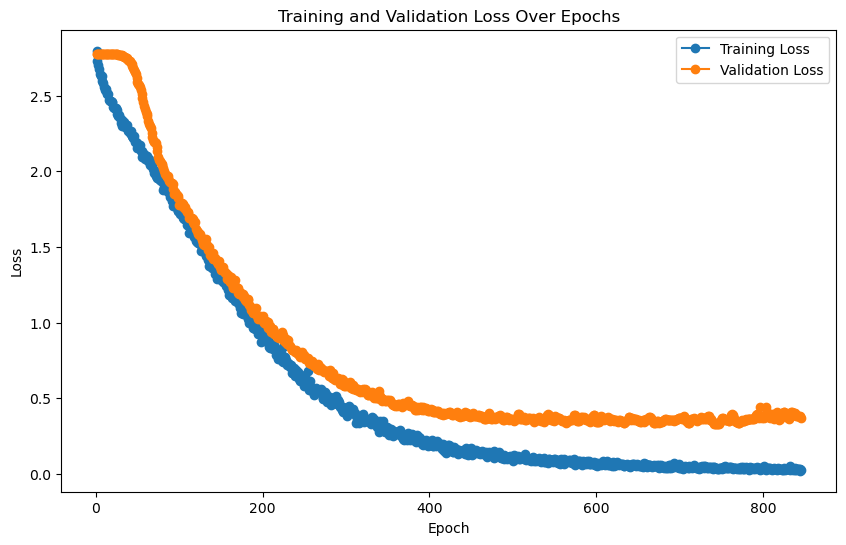

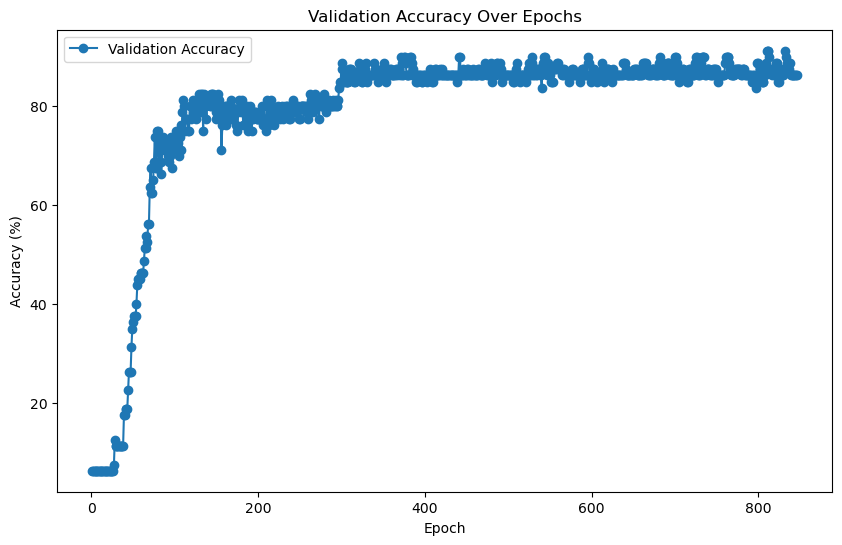


Evaluating on the test set...
    Test Batch [1/211], Loss: 0.2176



Final Test Loss: 0.4067, Test Accuracy: 87.59%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/211 for test dataset.
  Processed batch 20/211 for test dataset.
  Processed batch 30/211 for test dataset.


  Processed batch 40/211 for test dataset.
  Processed batch 50/211 for test dataset.
  Processed batch 60/211 for test dataset.
  Processed batch 70/211 for test dataset.
  Processed batch 80/211 for test dataset.


  Processed batch 90/211 for test dataset.
  Processed batch 100/211 for test dataset.
  Processed batch 110/211 for test dataset.
  Processed batch 120/211 for test dataset.
  Processed batch 130/211 for test dataset.


  Processed batch 140/211 for test dataset.
  Processed batch 150/211 for test dataset.
  Processed batch 160/211 for test dataset.
  Processed batch 170/211 for test dataset.
  Processed batch 180/211 for test dataset.


  Processed batch 190/211 for test dataset.
  Processed batch 200/211 for test dataset.
  Processed batch 210/211 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 160 samples with 64 features each
LOG: Labels shape: (160,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 53889 samples with 64 features each
LOG: Labels shape: (53889,)

LOG: Training features shape: (160, 64), Training labels shape: (160,)
LOG: Validation features shape: (80, 64), Validation labels shape: (80,)
LOG: Test features shape: (53889, 64), Test labels shape: (53889,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 86.25%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       0.29      0.40      0.33         5
           8       0.83      1.

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 160 samples with 64 features each
LOG: Labels shape: (160,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 53889 samples with 64 features each
LOG: Labels shape: (53889,)
Train reps shape: (160, 64)
Train labels shape: (160,)
Val reps shape: (80, 64)
Val labels shape: (80,)
Test reps shape: (53889, 64)
Test labels shape: (53889,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 3.0784  |  Val Loss: 2.8394
Validation loss improved from inf to 2.8394.
[Epoch 2/1000] Train Loss: 2.8135  |  Val Loss: 2.7070
Validation loss improved from 2.8394 to 2.7070.
[Epoch 3/1000] Train Loss: 2.6608  |  Val Loss: 2.6151
Validation loss improved from 2.7070 to 2.6151.
[Epoch 4/1000] Train Loss: 2.5662  |  Val Loss: 2.5488
Validation loss improved from 2.6151 to 2.5488.
[Epoch 5/1000] Train Loss: 2.4964  |  Val Loss: 2.4837
Validation loss improved from 2.5488 to 2.4837.
[Epoch 6/1000] Train Loss: 2.4369  |  Val Loss: 2.4216
Validation loss improved from 2.4837 to 2.4216.
[Epoch 7/1000] Train Loss: 2.3699  |  Val Loss: 2.3674
Validation loss improved from 2.4216 to 2.3674.
[Epoch 8/1000] Train Loss: 2.3164  |  Val Loss: 2.3171
Validation loss improved from 2.3674 to 2.3171.
[Epoch 9/1000] Train Loss: 2.2603  |  Val Loss: 2.2612
Validation loss improved from 2.3171 to 2.2612.
[Epoch 10/1000] Train Loss: 2.1994  |  Val Loss: 2.2010
Validation loss impr

[Epoch 21/1000] Train Loss: 1.5132  |  Val Loss: 1.5390
Validation loss improved from 1.5950 to 1.5390.
[Epoch 22/1000] Train Loss: 1.4490  |  Val Loss: 1.4801
Validation loss improved from 1.5390 to 1.4801.
[Epoch 23/1000] Train Loss: 1.3948  |  Val Loss: 1.4257
Validation loss improved from 1.4801 to 1.4257.
[Epoch 24/1000] Train Loss: 1.3320  |  Val Loss: 1.3731
Validation loss improved from 1.4257 to 1.3731.
[Epoch 25/1000] Train Loss: 1.2746  |  Val Loss: 1.3265
Validation loss improved from 1.3731 to 1.3265.
[Epoch 26/1000] Train Loss: 1.2221  |  Val Loss: 1.2793
Validation loss improved from 1.3265 to 1.2793.
[Epoch 27/1000] Train Loss: 1.1737  |  Val Loss: 1.2320
Validation loss improved from 1.2793 to 1.2320.
[Epoch 28/1000] Train Loss: 1.1183  |  Val Loss: 1.2000
Validation loss improved from 1.2320 to 1.2000.
[Epoch 29/1000] Train Loss: 1.0782  |  Val Loss: 1.1610
Validation loss improved from 1.2000 to 1.1610.
[Epoch 30/1000] Train Loss: 1.0341  |  Val Loss: 1.1160
Validati

[Epoch 32/1000] Train Loss: 0.9514  |  Val Loss: 1.0485
Validation loss improved from 1.0832 to 1.0485.
[Epoch 33/1000] Train Loss: 0.9115  |  Val Loss: 1.0138
Validation loss improved from 1.0485 to 1.0138.
[Epoch 34/1000] Train Loss: 0.8744  |  Val Loss: 0.9880
Validation loss improved from 1.0138 to 0.9880.
[Epoch 35/1000] Train Loss: 0.8422  |  Val Loss: 0.9582
Validation loss improved from 0.9880 to 0.9582.
[Epoch 36/1000] Train Loss: 0.8138  |  Val Loss: 0.9261
Validation loss improved from 0.9582 to 0.9261.
[Epoch 37/1000] Train Loss: 0.7893  |  Val Loss: 0.9062
Validation loss improved from 0.9261 to 0.9062.
[Epoch 38/1000] Train Loss: 0.7608  |  Val Loss: 0.8978
Validation loss improved from 0.9062 to 0.8978.
[Epoch 39/1000] Train Loss: 0.7366  |  Val Loss: 0.8741
Validation loss improved from 0.8978 to 0.8741.
[Epoch 40/1000] Train Loss: 0.7092  |  Val Loss: 0.8530
Validation loss improved from 0.8741 to 0.8530.
[Epoch 41/1000] Train Loss: 0.6944  |  Val Loss: 0.8362
Validati

[Epoch 51/1000] Train Loss: 0.5168  |  Val Loss: 0.6985
Validation loss improved from 0.7078 to 0.6985.
[Epoch 52/1000] Train Loss: 0.4997  |  Val Loss: 0.6960
Validation loss improved from 0.6985 to 0.6960.
[Epoch 53/1000] Train Loss: 0.4917  |  Val Loss: 0.6845
Validation loss improved from 0.6960 to 0.6845.
[Epoch 54/1000] Train Loss: 0.4766  |  Val Loss: 0.6833
Validation loss improved from 0.6845 to 0.6833.
[Epoch 55/1000] Train Loss: 0.4664  |  Val Loss: 0.6768
Validation loss improved from 0.6833 to 0.6768.
[Epoch 56/1000] Train Loss: 0.4561  |  Val Loss: 0.6725
Validation loss improved from 0.6768 to 0.6725.
[Epoch 57/1000] Train Loss: 0.4462  |  Val Loss: 0.6652
Validation loss improved from 0.6725 to 0.6652.
[Epoch 58/1000] Train Loss: 0.4375  |  Val Loss: 0.6606
Validation loss improved from 0.6652 to 0.6606.
[Epoch 59/1000] Train Loss: 0.4268  |  Val Loss: 0.6489
Validation loss improved from 0.6606 to 0.6489.
[Epoch 60/1000] Train Loss: 0.4154  |  Val Loss: 0.6355
Validati

[Epoch 62/1000] Train Loss: 0.4040  |  Val Loss: 0.6353
Validation loss improved from 0.6354 to 0.6353.
[Epoch 63/1000] Train Loss: 0.3944  |  Val Loss: 0.6374
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 64/1000] Train Loss: 0.3903  |  Val Loss: 0.6417
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 65/1000] Train Loss: 0.3776  |  Val Loss: 0.6275
Validation loss improved from 0.6353 to 0.6275.
[Epoch 66/1000] Train Loss: 0.3664  |  Val Loss: 0.6166
Validation loss improved from 0.6275 to 0.6166.
[Epoch 67/1000] Train Loss: 0.3633  |  Val Loss: 0.6173
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 68/1000] Train Loss: 0.3518  |  Val Loss: 0.6070
Validation loss improved from 0.6166 to 0.6070.
[Epoch 69/1000] Train Loss: 0.3475  |  Val Loss: 0.6115
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 70/1000] Train Loss: 0.3416  |  Val Loss: 0.6206
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 71/1000] Train Loss: 0.3301

[Epoch 81/1000] Train Loss: 0.2823  |  Val Loss: 0.5992
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 82/1000] Train Loss: 0.2799  |  Val Loss: 0.5670
Validation loss improved from 0.5765 to 0.5670.
[Epoch 83/1000] Train Loss: 0.2692  |  Val Loss: 0.5688
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 84/1000] Train Loss: 0.2708  |  Val Loss: 0.5779
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 85/1000] Train Loss: 0.2640  |  Val Loss: 0.5724
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 86/1000] Train Loss: 0.2529  |  Val Loss: 0.5634
Validation loss improved from 0.5670 to 0.5634.
[Epoch 87/1000] Train Loss: 0.2533  |  Val Loss: 0.5700
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 88/1000] Train Loss: 0.2483  |  Val Loss: 0.5779
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 89/1000] Train Loss: 0.2473  |  Val Loss: 0.5677
!! Validation loss did NOT improve !! Patience: 3/100


[Epoch 90/1000] Train Loss: 0.2380  |  Val Loss: 0.5615
Validation loss improved from 0.5634 to 0.5615.
[Epoch 91/1000] Train Loss: 0.2379  |  Val Loss: 0.5760
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 92/1000] Train Loss: 0.2314  |  Val Loss: 0.5724
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 93/1000] Train Loss: 0.2325  |  Val Loss: 0.5670
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 94/1000] Train Loss: 0.2265  |  Val Loss: 0.5682
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 95/1000] Train Loss: 0.2246  |  Val Loss: 0.5629
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 96/1000] Train Loss: 0.2223  |  Val Loss: 0.5568
Validation loss improved from 0.5615 to 0.5568.
[Epoch 97/1000] Train Loss: 0.2183  |  Val Loss: 0.5539
Validation loss improved from 0.5568 to 0.5539.
[Epoch 98/1000] Train Loss: 0.2131  |  Val Loss: 0.5452
Validation loss improved from 0.5539 to 0.5452.
[Epoch 99/1000] Train Loss: 0.2090

[Epoch 110/1000] Train Loss: 0.1821  |  Val Loss: 0.5562
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 111/1000] Train Loss: 0.1784  |  Val Loss: 0.5489
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 112/1000] Train Loss: 0.1786  |  Val Loss: 0.5434
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 113/1000] Train Loss: 0.1805  |  Val Loss: 0.5376
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 114/1000] Train Loss: 0.1822  |  Val Loss: 0.5544
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 115/1000] Train Loss: 0.1727  |  Val Loss: 0.5708
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 116/1000] Train Loss: 0.1848  |  Val Loss: 0.5620
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 117/1000] Train Loss: 0.1649  |  Val Loss: 0.5693
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 118/1000] Train Loss: 0.1796  |  Val Loss: 0.5516
!! Validation loss did NOT improve !! Patience: 15

[Epoch 120/1000] Train Loss: 0.1819  |  Val Loss: 0.5672
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 121/1000] Train Loss: 0.1659  |  Val Loss: 0.5735
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 122/1000] Train Loss: 0.1716  |  Val Loss: 0.5785
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 123/1000] Train Loss: 0.1747  |  Val Loss: 0.5332
Validation loss improved from 0.5337 to 0.5332.
[Epoch 124/1000] Train Loss: 0.1595  |  Val Loss: 0.5514
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 125/1000] Train Loss: 0.1598  |  Val Loss: 0.5653
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 126/1000] Train Loss: 0.1554  |  Val Loss: 0.5578
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 127/1000] Train Loss: 0.1449  |  Val Loss: 0.5619
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 128/1000] Train Loss: 0.1543  |  Val Loss: 0.5578
!! Validation loss did NOT improve !! Patience: 5/100
[Epo

[Epoch 141/1000] Train Loss: 0.1250  |  Val Loss: 0.5664
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 142/1000] Train Loss: 0.1277  |  Val Loss: 0.5708
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 143/1000] Train Loss: 0.1224  |  Val Loss: 0.5769
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 144/1000] Train Loss: 0.1232  |  Val Loss: 0.5683
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 145/1000] Train Loss: 0.1257  |  Val Loss: 0.5598
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 146/1000] Train Loss: 0.1264  |  Val Loss: 0.5578
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 147/1000] Train Loss: 0.1200  |  Val Loss: 0.5528
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 148/1000] Train Loss: 0.1196  |  Val Loss: 0.5735
!! Validation loss did NOT improve !! Patience: 25/100


[Epoch 149/1000] Train Loss: 0.1176  |  Val Loss: 0.5572
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 150/1000] Train Loss: 0.1134  |  Val Loss: 0.5457
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 151/1000] Train Loss: 0.1159  |  Val Loss: 0.5538
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 152/1000] Train Loss: 0.1091  |  Val Loss: 0.5811
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 153/1000] Train Loss: 0.1159  |  Val Loss: 0.5848
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 154/1000] Train Loss: 0.1105  |  Val Loss: 0.5519
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 155/1000] Train Loss: 0.1086  |  Val Loss: 0.5465
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 156/1000] Train Loss: 0.1131  |  Val Loss: 0.5590
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 157/1000] Train Loss: 0.1062  |  Val Loss: 0.5960
!! Validation loss did NOT improve !! Patience:

[Epoch 169/1000] Train Loss: 0.0974  |  Val Loss: 0.5822
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 170/1000] Train Loss: 0.1000  |  Val Loss: 0.5824
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 171/1000] Train Loss: 0.0951  |  Val Loss: 0.5591
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 172/1000] Train Loss: 0.1021  |  Val Loss: 0.5684
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 173/1000] Train Loss: 0.0941  |  Val Loss: 0.5928
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 174/1000] Train Loss: 0.0989  |  Val Loss: 0.6026
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 175/1000] Train Loss: 0.0991  |  Val Loss: 0.5674
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 176/1000] Train Loss: 0.0937  |  Val Loss: 0.5613
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 177/1000] Train Loss: 0.0890  |  Val Loss: 0.5877
!! Validation loss did NOT improve !! Patience:

[Epoch 183/1000] Train Loss: 0.0878  |  Val Loss: 0.5878
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 184/1000] Train Loss: 0.0856  |  Val Loss: 0.5807
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 185/1000] Train Loss: 0.0912  |  Val Loss: 0.5674
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 186/1000] Train Loss: 0.0855  |  Val Loss: 0.5942
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 187/1000] Train Loss: 0.0895  |  Val Loss: 0.5824
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 188/1000] Train Loss: 0.0876  |  Val Loss: 0.5686
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 189/1000] Train Loss: 0.0823  |  Val Loss: 0.5944
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 190/1000] Train Loss: 0.0868  |  Val Loss: 0.5944
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 191/1000] Train Loss: 0.0875  |  Val Loss: 0.5777
!! Validation loss did NOT improve !! Patience:

[Epoch 201/1000] Train Loss: 0.0746  |  Val Loss: 0.5853
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 202/1000] Train Loss: 0.0741  |  Val Loss: 0.5721
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 203/1000] Train Loss: 0.0724  |  Val Loss: 0.5806
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 204/1000] Train Loss: 0.0734  |  Val Loss: 0.5957
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 205/1000] Train Loss: 0.0711  |  Val Loss: 0.5946
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 206/1000] Train Loss: 0.0692  |  Val Loss: 0.5837
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 207/1000] Train Loss: 0.0702  |  Val Loss: 0.5873
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 208/1000] Train Loss: 0.0735  |  Val Loss: 0.5979
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 209/1000] Train Loss: 0.0702  |  Val Loss: 0.5863
!! Validation loss did NOT improve !! Patience:

[Epoch 213/1000] Train Loss: 0.0737  |  Val Loss: 0.5813
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 214/1000] Train Loss: 0.0692  |  Val Loss: 0.5920
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 215/1000] Train Loss: 0.0708  |  Val Loss: 0.6185
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 216/1000] Train Loss: 0.0705  |  Val Loss: 0.6087
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 217/1000] Train Loss: 0.0659  |  Val Loss: 0.5905
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 218/1000] Train Loss: 0.0622  |  Val Loss: 0.5722
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 219/1000] Train Loss: 0.0744  |  Val Loss: 0.5863
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 220/1000] Train Loss: 0.0597  |  Val Loss: 0.6459
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 221/1000] Train Loss: 0.0775  |  Val Loss: 0.6205
!! Validation loss did NOT improve !! Patience:

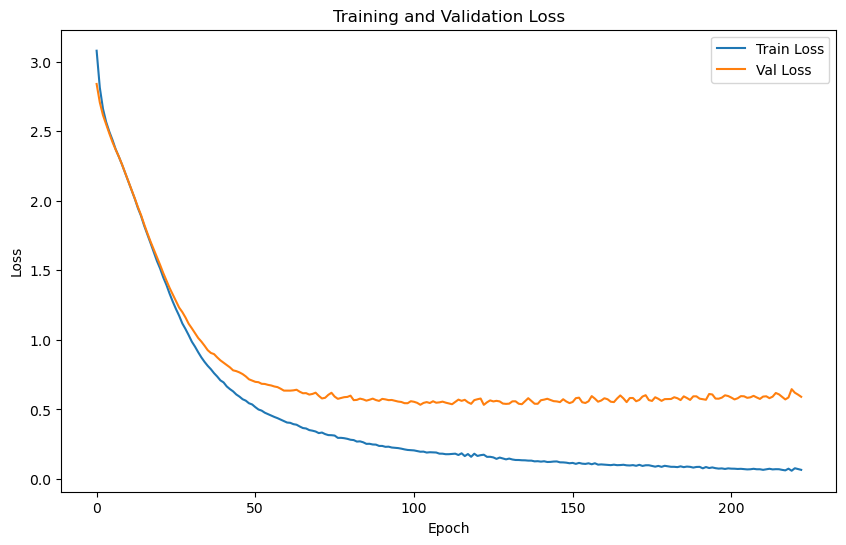

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 0.5972 | Test Accuracy: 84.15%


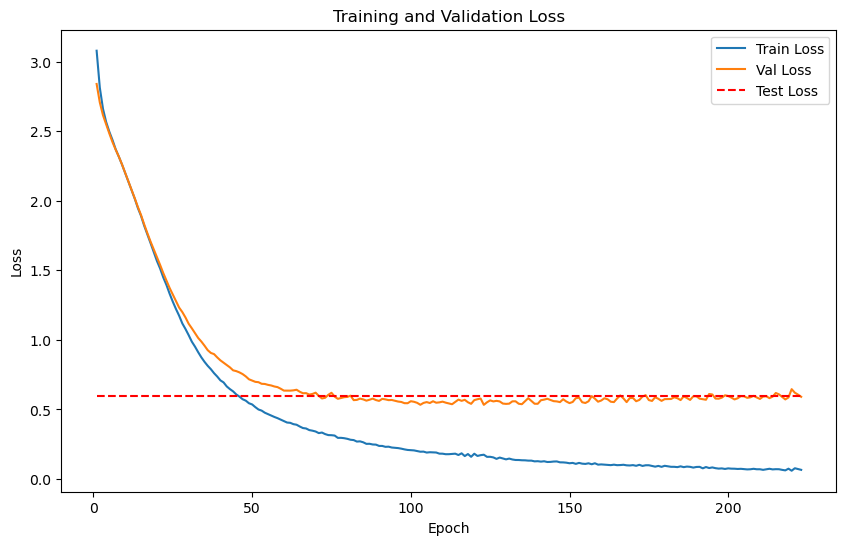

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 160 samples with 64 features each
LOG: Labels shape: (160,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 53889 samples with 64 features each
LOG: Labels shape: (53889,)


Train embeddings shape: (160, 64), 
Train labels shape: (160,)


Val embeddings shape: (80, 64), 
Val labels shape: (80,)


Test embeddings shape: (53889, 64), 
Test labels shape: (53889,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10, 10: 10, 11: 10, 12: 10, 13: 10, 14: 10, 15: 10}
Training batch size: 160


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 7.9089
Epoch [1/2000], Avg Train Loss: 7.9089
Epoch [1/2000], Avg Val Loss: 3.0071
Validation loss improved from inf to 3.0071. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 7.7889
Epoch [2/2000], Avg Train Loss: 7.7889
Epoch [2/2000], Avg Val Loss: 2.9951
Validation loss improved from 3.0071 to 2.9951. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 7.9393
Epoch [3/2000], Avg Train Loss: 7.9393
Epoch [3/2000], Avg Val Loss: 2.9832
Validation loss improved from 2.9951 to 2.9832. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 7.6110
Epoch [4/2000], Avg Train Loss: 7.6110
Epoch [4/2000], Avg Val Loss: 2.9720
Validation loss improved from 2.9832 to 2.9720. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 7.8345
Epoch [5/2000], Avg Train Loss: 7.8345
Epoch [5/2000], Avg Val Loss: 2.9611
Validation loss improved from 2.9720 to 2.9611. Saving mode

    Batch [1/1], Train Loss: 6.5339
Epoch [21/2000], Avg Train Loss: 6.5339


Epoch [21/2000], Avg Val Loss: 2.8355
Validation loss improved from 2.8411 to 2.8355. Saving model...

LOG: Epoch [22/2000] - Training
    Batch [1/1], Train Loss: 6.5401
Epoch [22/2000], Avg Train Loss: 6.5401
Epoch [22/2000], Avg Val Loss: 2.8302
Validation loss improved from 2.8355 to 2.8302. Saving model...

LOG: Epoch [23/2000] - Training
    Batch [1/1], Train Loss: 6.5011
Epoch [23/2000], Avg Train Loss: 6.5011
Epoch [23/2000], Avg Val Loss: 2.8252
Validation loss improved from 2.8302 to 2.8252. Saving model...

LOG: Epoch [24/2000] - Training
    Batch [1/1], Train Loss: 6.3038
Epoch [24/2000], Avg Train Loss: 6.3038
Epoch [24/2000], Avg Val Loss: 2.8205
Validation loss improved from 2.8252 to 2.8205. Saving model...

LOG: Epoch [25/2000] - Training
    Batch [1/1], Train Loss: 6.2812
Epoch [25/2000], Avg Train Loss: 6.2812
Epoch [25/2000], Avg Val Loss: 2.8160
Validation loss improved from 2.8205 to 2.8160. Saving model...

LOG: Epoch [26/2000] - Training
    Batch [1/1], Trai

Epoch [42/2000], Avg Val Loss: 2.7720
Validation loss improved from 2.7730 to 2.7720. Saving model...

LOG: Epoch [43/2000] - Training
    Batch [1/1], Train Loss: 5.6468
Epoch [43/2000], Avg Train Loss: 5.6468
Epoch [43/2000], Avg Val Loss: 2.7711
Validation loss improved from 2.7720 to 2.7711. Saving model...

LOG: Epoch [44/2000] - Training
    Batch [1/1], Train Loss: 5.5420
Epoch [44/2000], Avg Train Loss: 5.5420
Epoch [44/2000], Avg Val Loss: 2.7704
Validation loss improved from 2.7711 to 2.7704. Saving model...

LOG: Epoch [45/2000] - Training
    Batch [1/1], Train Loss: 5.6598
Epoch [45/2000], Avg Train Loss: 5.6598
Epoch [45/2000], Avg Val Loss: 2.7699
Validation loss improved from 2.7704 to 2.7699. Saving model...

LOG: Epoch [46/2000] - Training
    Batch [1/1], Train Loss: 5.5094
Epoch [46/2000], Avg Train Loss: 5.5094
Epoch [46/2000], Avg Val Loss: 2.7694
Validation loss improved from 2.7699 to 2.7694. Saving model...

LOG: Epoch [47/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 4.8764
Epoch [67/2000], Avg Train Loss: 4.8764
Epoch [67/2000], Avg Val Loss: 2.7793
Validation loss did not improve. Patience: 18/100

LOG: Epoch [68/2000] - Training
    Batch [1/1], Train Loss: 4.7607
Epoch [68/2000], Avg Train Loss: 4.7607
Epoch [68/2000], Avg Val Loss: 2.7803
Validation loss did not improve. Patience: 19/100

LOG: Epoch [69/2000] - Training
    Batch [1/1], Train Loss: 4.9033
Epoch [69/2000], Avg Train Loss: 4.9033
Epoch [69/2000], Avg Val Loss: 2.7813
Validation loss did not improve. Patience: 20/100

LOG: Epoch [70/2000] - Training
    Batch [1/1], Train Loss: 4.9383
Epoch [70/2000], Avg Train Loss: 4.9383
Epoch [70/2000], Avg Val Loss: 2.7823
Validation loss did not improve. Patience: 21/100

LOG: Epoch [71/2000] - Training
    Batch [1/1], Train Loss: 4.8394
Epoch [71/2000], Avg Train Loss: 4.8394
Epoch [71/2000], Avg Val Loss: 2.7833
Validation loss did not improve. Patience: 22/100

LOG: Epoch [72/2000] - Training
    Batch [1/1]

    Batch [1/1], Train Loss: 4.5556
Epoch [85/2000], Avg Train Loss: 4.5556
Epoch [85/2000], Avg Val Loss: 2.7969
Validation loss did not improve. Patience: 36/100

LOG: Epoch [86/2000] - Training
    Batch [1/1], Train Loss: 4.6606
Epoch [86/2000], Avg Train Loss: 4.6606
Epoch [86/2000], Avg Val Loss: 2.7978
Validation loss did not improve. Patience: 37/100

LOG: Epoch [87/2000] - Training
    Batch [1/1], Train Loss: 4.6944
Epoch [87/2000], Avg Train Loss: 4.6944
Epoch [87/2000], Avg Val Loss: 2.7986
Validation loss did not improve. Patience: 38/100

LOG: Epoch [88/2000] - Training
    Batch [1/1], Train Loss: 4.7326
Epoch [88/2000], Avg Train Loss: 4.7326
Epoch [88/2000], Avg Val Loss: 2.7995
Validation loss did not improve. Patience: 39/100

LOG: Epoch [89/2000] - Training
    Batch [1/1], Train Loss: 4.6397
Epoch [89/2000], Avg Train Loss: 4.6397
Epoch [89/2000], Avg Val Loss: 2.8004
Validation loss did not improve. Patience: 40/100

LOG: Epoch [90/2000] - Training
    Batch [1/1]

    Batch [1/1], Train Loss: 4.4056
Epoch [111/2000], Avg Train Loss: 4.4056
Epoch [111/2000], Avg Val Loss: 2.8114
Validation loss did not improve. Patience: 62/100

LOG: Epoch [112/2000] - Training
    Batch [1/1], Train Loss: 4.4033
Epoch [112/2000], Avg Train Loss: 4.4033
Epoch [112/2000], Avg Val Loss: 2.8116
Validation loss did not improve. Patience: 63/100

LOG: Epoch [113/2000] - Training
    Batch [1/1], Train Loss: 4.3863
Epoch [113/2000], Avg Train Loss: 4.3863
Epoch [113/2000], Avg Val Loss: 2.8118
Validation loss did not improve. Patience: 64/100

LOG: Epoch [114/2000] - Training
    Batch [1/1], Train Loss: 4.3595
Epoch [114/2000], Avg Train Loss: 4.3595
Epoch [114/2000], Avg Val Loss: 2.8119
Validation loss did not improve. Patience: 65/100

LOG: Epoch [115/2000] - Training
    Batch [1/1], Train Loss: 4.3854
Epoch [115/2000], Avg Train Loss: 4.3854
Epoch [115/2000], Avg Val Loss: 2.8120
Validation loss did not improve. Patience: 66/100

LOG: Epoch [116/2000] - Training


    Batch [1/1], Train Loss: 4.2524
Epoch [134/2000], Avg Train Loss: 4.2524
Epoch [134/2000], Avg Val Loss: 2.8089
Validation loss did not improve. Patience: 85/100

LOG: Epoch [135/2000] - Training
    Batch [1/1], Train Loss: 4.2919
Epoch [135/2000], Avg Train Loss: 4.2919
Epoch [135/2000], Avg Val Loss: 2.8085
Validation loss did not improve. Patience: 86/100

LOG: Epoch [136/2000] - Training
    Batch [1/1], Train Loss: 4.1771
Epoch [136/2000], Avg Train Loss: 4.1771
Epoch [136/2000], Avg Val Loss: 2.8080
Validation loss did not improve. Patience: 87/100

LOG: Epoch [137/2000] - Training
    Batch [1/1], Train Loss: 4.2633
Epoch [137/2000], Avg Train Loss: 4.2633
Epoch [137/2000], Avg Val Loss: 2.8075
Validation loss did not improve. Patience: 88/100

LOG: Epoch [138/2000] - Training
    Batch [1/1], Train Loss: 4.2114
Epoch [138/2000], Avg Train Loss: 4.2114
Epoch [138/2000], Avg Val Loss: 2.8070
Validation loss did not improve. Patience: 89/100

LOG: Epoch [139/2000] - Training


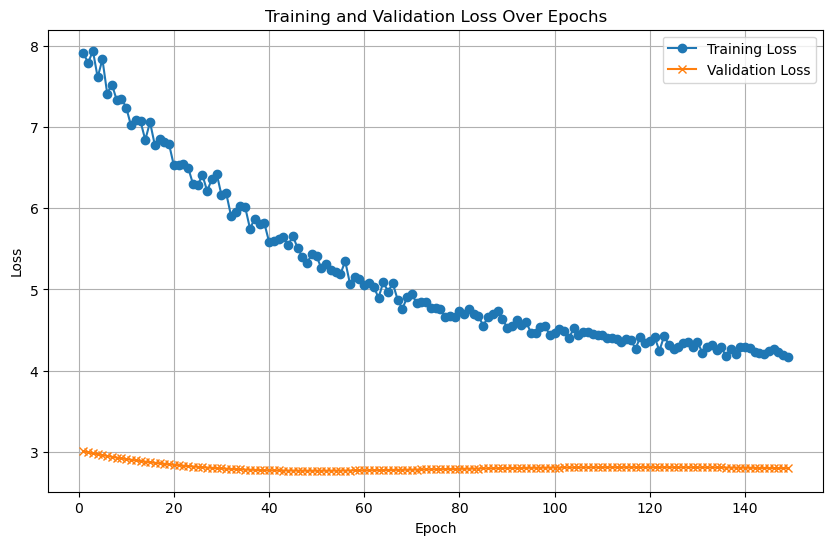

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/211], Loss: 4.7201


Test Batch [20/211], Loss: 4.7298
Test Batch [30/211], Loss: 4.6803
Test Batch [40/211], Loss: 4.7117
Test Batch [50/211], Loss: 4.8217
Test Batch [60/211], Loss: 4.8647
Test Batch [70/211], Loss: 4.8084
Test Batch [80/211], Loss: 4.9329
Test Batch [90/211], Loss: 4.8115
Test Batch [100/211], Loss: 4.8705
Test Batch [110/211], Loss: 4.8891
Test Batch [120/211], Loss: 5.0231
Test Batch [130/211], Loss: 4.9576
Test Batch [140/211], Loss: 4.9311
Test Batch [150/211], Loss: 4.8705


Test Batch [160/211], Loss: 5.0056
Test Batch [170/211], Loss: 4.9422
Test Batch [180/211], Loss: 5.0236
Test Batch [190/211], Loss: 4.9481
Test Batch [200/211], Loss: 4.9002
Test Batch [210/211], Loss: 4.7560

Test Loss: 4.8670


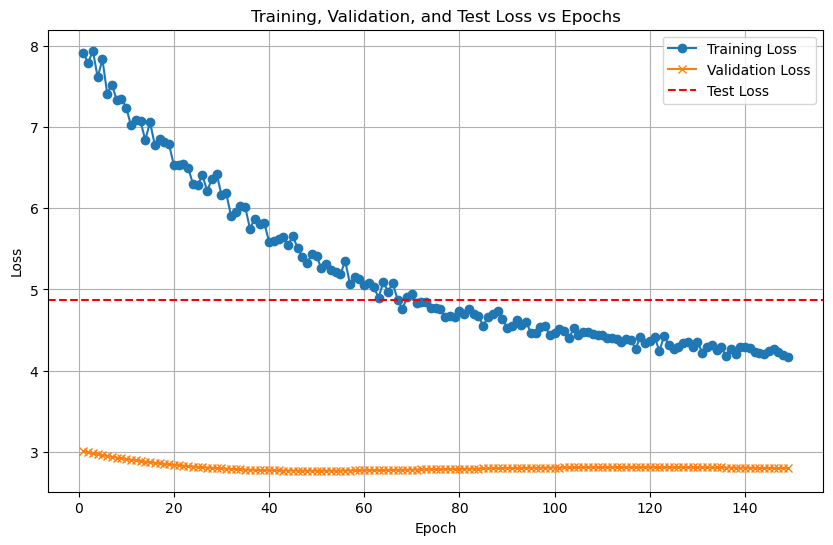

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...


  Processed batch 10/211 for test dataset.
  Processed batch 20/211 for test dataset.
  Processed batch 30/211 for test dataset.
  Processed batch 40/211 for test dataset.
  Processed batch 50/211 for test dataset.
  Processed batch 60/211 for test dataset.


  Processed batch 70/211 for test dataset.
  Processed batch 80/211 for test dataset.
  Processed batch 90/211 for test dataset.
  Processed batch 100/211 for test dataset.
  Processed batch 110/211 for test dataset.
  Processed batch 120/211 for test dataset.


  Processed batch 130/211 for test dataset.
  Processed batch 140/211 for test dataset.
  Processed batch 150/211 for test dataset.
  Processed batch 160/211 for test dataset.
  Processed batch 170/211 for test dataset.
  Processed batch 180/211 for test dataset.
  Processed batch 190/211 for test dataset.


  Processed batch 200/211 for test dataset.
  Processed batch 210/211 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (160, 128)
Train labels shape: (160,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (53889, 128)
Test labels shape: (53889,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 86.25%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      0.80      0.89         5
           3       0.71      1.00      0.83         5
           4       0.83      1.00      0.91         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       0.43      0.60      0.50         5
           8       0.83      1.00      0.91         5
           9       1.00      0.80      0.89         5
          10       1.00      0.80      0.89         5
          11       0.83      1.00      0.91         5
          12       1.00      1.00      1.00         5
          13       1.0

### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (160, 128)
Train labels shape: (160,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (53889, 128)
Test labels shape: (53889,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.8330  |  Val Loss: 2.8101
Validation loss improved from inf to 2.8101.
[Epoch 2/1000] Train Loss: 2.8200  |  Val Loss: 2.8004
Validation loss improved from 2.8101 to 2.8004.
[Epoch 3/1000] Train Loss: 2.8094  |  Val Loss: 2.7914
Validation loss improved from 2.8004 to 2.7914.
[Epoch 4/1000] Train Loss: 2.7987  |  Val Loss: 2.7829
Validation loss improved from 2.7914 to 2.7829.
[Epoch 5/1000] Train Loss: 2.7892  |  Val Loss: 2.7745
Validation loss improved from 2.7829 to 2.7745.
[Epoch 6/1000] Train Loss: 2.7791  |  Val Loss: 2.7663
Validation loss improved from 2.7745 to 2.7663.
[Epoch 7/1000] Train Loss: 2.7694  |  Val Loss: 2.7582
Validation loss improved from 2.7663 to 2.7582.
[Epoch 8/1000] Train Loss: 2.7607  |  Val Loss: 2.7503
Validation loss improved from 2.7582 to 2.7503.
[Epoch 9/1000] Train Loss: 2.7509  |  Val Loss: 2.7423
Validation loss improved from 2.7503 to 2.7423.
[Epoch 10/1000] Train Loss: 2.7419  |  Val Loss: 2.7343
Validation loss impr

[Epoch 22/1000] Train Loss: 2.6478  |  Val Loss: 2.6472
Validation loss improved from 2.6547 to 2.6472.
[Epoch 23/1000] Train Loss: 2.6401  |  Val Loss: 2.6395
Validation loss improved from 2.6472 to 2.6395.
[Epoch 24/1000] Train Loss: 2.6326  |  Val Loss: 2.6321
Validation loss improved from 2.6395 to 2.6321.
[Epoch 25/1000] Train Loss: 2.6252  |  Val Loss: 2.6256
Validation loss improved from 2.6321 to 2.6256.
[Epoch 26/1000] Train Loss: 2.6187  |  Val Loss: 2.6193
Validation loss improved from 2.6256 to 2.6193.
[Epoch 27/1000] Train Loss: 2.6124  |  Val Loss: 2.6131
Validation loss improved from 2.6193 to 2.6131.
[Epoch 28/1000] Train Loss: 2.6058  |  Val Loss: 2.6070
Validation loss improved from 2.6131 to 2.6070.
[Epoch 29/1000] Train Loss: 2.5996  |  Val Loss: 2.6009
Validation loss improved from 2.6070 to 2.6009.
[Epoch 30/1000] Train Loss: 2.5933  |  Val Loss: 2.5947
Validation loss improved from 2.6009 to 2.5947.


[Epoch 31/1000] Train Loss: 2.5873  |  Val Loss: 2.5884
Validation loss improved from 2.5947 to 2.5884.
[Epoch 32/1000] Train Loss: 2.5809  |  Val Loss: 2.5823
Validation loss improved from 2.5884 to 2.5823.
[Epoch 33/1000] Train Loss: 2.5750  |  Val Loss: 2.5764
Validation loss improved from 2.5823 to 2.5764.
[Epoch 34/1000] Train Loss: 2.5689  |  Val Loss: 2.5707
Validation loss improved from 2.5764 to 2.5707.
[Epoch 35/1000] Train Loss: 2.5634  |  Val Loss: 2.5647
Validation loss improved from 2.5707 to 2.5647.
[Epoch 36/1000] Train Loss: 2.5574  |  Val Loss: 2.5588
Validation loss improved from 2.5647 to 2.5588.
[Epoch 37/1000] Train Loss: 2.5518  |  Val Loss: 2.5528
Validation loss improved from 2.5588 to 2.5528.
[Epoch 38/1000] Train Loss: 2.5462  |  Val Loss: 2.5469
Validation loss improved from 2.5528 to 2.5469.
[Epoch 39/1000] Train Loss: 2.5403  |  Val Loss: 2.5411
Validation loss improved from 2.5469 to 2.5411.
[Epoch 40/1000] Train Loss: 2.5347  |  Val Loss: 2.5353
Validati

[Epoch 52/1000] Train Loss: 2.4647  |  Val Loss: 2.4647
Validation loss improved from 2.4709 to 2.4647.
[Epoch 53/1000] Train Loss: 2.4584  |  Val Loss: 2.4585
Validation loss improved from 2.4647 to 2.4585.
[Epoch 54/1000] Train Loss: 2.4524  |  Val Loss: 2.4524
Validation loss improved from 2.4585 to 2.4524.
[Epoch 55/1000] Train Loss: 2.4459  |  Val Loss: 2.4462
Validation loss improved from 2.4524 to 2.4462.
[Epoch 56/1000] Train Loss: 2.4395  |  Val Loss: 2.4399
Validation loss improved from 2.4462 to 2.4399.
[Epoch 57/1000] Train Loss: 2.4331  |  Val Loss: 2.4336
Validation loss improved from 2.4399 to 2.4336.
[Epoch 58/1000] Train Loss: 2.4266  |  Val Loss: 2.4273
Validation loss improved from 2.4336 to 2.4273.


[Epoch 59/1000] Train Loss: 2.4202  |  Val Loss: 2.4212
Validation loss improved from 2.4273 to 2.4212.
[Epoch 60/1000] Train Loss: 2.4139  |  Val Loss: 2.4149
Validation loss improved from 2.4212 to 2.4149.
[Epoch 61/1000] Train Loss: 2.4075  |  Val Loss: 2.4087
Validation loss improved from 2.4149 to 2.4087.
[Epoch 62/1000] Train Loss: 2.4011  |  Val Loss: 2.4025
Validation loss improved from 2.4087 to 2.4025.
[Epoch 63/1000] Train Loss: 2.3947  |  Val Loss: 2.3964
Validation loss improved from 2.4025 to 2.3964.
[Epoch 64/1000] Train Loss: 2.3884  |  Val Loss: 2.3903
Validation loss improved from 2.3964 to 2.3903.
[Epoch 65/1000] Train Loss: 2.3819  |  Val Loss: 2.3841
Validation loss improved from 2.3903 to 2.3841.
[Epoch 66/1000] Train Loss: 2.3754  |  Val Loss: 2.3778
Validation loss improved from 2.3841 to 2.3778.
[Epoch 67/1000] Train Loss: 2.3688  |  Val Loss: 2.3713
Validation loss improved from 2.3778 to 2.3713.
[Epoch 68/1000] Train Loss: 2.3625  |  Val Loss: 2.3649
Validati

[Epoch 83/1000] Train Loss: 2.2614  |  Val Loss: 2.2653
Validation loss improved from 2.2723 to 2.2653.
[Epoch 84/1000] Train Loss: 2.2544  |  Val Loss: 2.2584
Validation loss improved from 2.2653 to 2.2584.
[Epoch 85/1000] Train Loss: 2.2479  |  Val Loss: 2.2515
Validation loss improved from 2.2584 to 2.2515.
[Epoch 86/1000] Train Loss: 2.2407  |  Val Loss: 2.2444
Validation loss improved from 2.2515 to 2.2444.
[Epoch 87/1000] Train Loss: 2.2339  |  Val Loss: 2.2373
Validation loss improved from 2.2444 to 2.2373.
[Epoch 88/1000] Train Loss: 2.2270  |  Val Loss: 2.2301
Validation loss improved from 2.2373 to 2.2301.
[Epoch 89/1000] Train Loss: 2.2201  |  Val Loss: 2.2227
Validation loss improved from 2.2301 to 2.2227.
[Epoch 90/1000] Train Loss: 2.2130  |  Val Loss: 2.2155
Validation loss improved from 2.2227 to 2.2155.
[Epoch 91/1000] Train Loss: 2.2058  |  Val Loss: 2.2086
Validation loss improved from 2.2155 to 2.2086.


[Epoch 92/1000] Train Loss: 2.1989  |  Val Loss: 2.2017
Validation loss improved from 2.2086 to 2.2017.
[Epoch 93/1000] Train Loss: 2.1918  |  Val Loss: 2.1948
Validation loss improved from 2.2017 to 2.1948.
[Epoch 94/1000] Train Loss: 2.1848  |  Val Loss: 2.1880
Validation loss improved from 2.1948 to 2.1880.
[Epoch 95/1000] Train Loss: 2.1779  |  Val Loss: 2.1810
Validation loss improved from 2.1880 to 2.1810.
[Epoch 96/1000] Train Loss: 2.1709  |  Val Loss: 2.1740
Validation loss improved from 2.1810 to 2.1740.
[Epoch 97/1000] Train Loss: 2.1638  |  Val Loss: 2.1668
Validation loss improved from 2.1740 to 2.1668.
[Epoch 98/1000] Train Loss: 2.1568  |  Val Loss: 2.1595
Validation loss improved from 2.1668 to 2.1595.
[Epoch 99/1000] Train Loss: 2.1496  |  Val Loss: 2.1520
Validation loss improved from 2.1595 to 2.1520.
[Epoch 100/1000] Train Loss: 2.1425  |  Val Loss: 2.1446
Validation loss improved from 2.1520 to 2.1446.
[Epoch 101/1000] Train Loss: 2.1351  |  Val Loss: 2.1372
Valida

[Epoch 113/1000] Train Loss: 2.0398  |  Val Loss: 2.0453
Validation loss improved from 2.0534 to 2.0453.
[Epoch 114/1000] Train Loss: 2.0312  |  Val Loss: 2.0369
Validation loss improved from 2.0453 to 2.0369.
[Epoch 115/1000] Train Loss: 2.0222  |  Val Loss: 2.0282
Validation loss improved from 2.0369 to 2.0282.
[Epoch 116/1000] Train Loss: 2.0130  |  Val Loss: 2.0193
Validation loss improved from 2.0282 to 2.0193.
[Epoch 117/1000] Train Loss: 2.0044  |  Val Loss: 2.0105
Validation loss improved from 2.0193 to 2.0105.
[Epoch 118/1000] Train Loss: 1.9952  |  Val Loss: 2.0017
Validation loss improved from 2.0105 to 2.0017.
[Epoch 119/1000] Train Loss: 1.9865  |  Val Loss: 1.9928
Validation loss improved from 2.0017 to 1.9928.
[Epoch 120/1000] Train Loss: 1.9772  |  Val Loss: 1.9838
Validation loss improved from 1.9928 to 1.9838.
[Epoch 121/1000] Train Loss: 1.9683  |  Val Loss: 1.9748
Validation loss improved from 1.9838 to 1.9748.


[Epoch 122/1000] Train Loss: 1.9592  |  Val Loss: 1.9662
Validation loss improved from 1.9748 to 1.9662.
[Epoch 123/1000] Train Loss: 1.9506  |  Val Loss: 1.9576
Validation loss improved from 1.9662 to 1.9576.
[Epoch 124/1000] Train Loss: 1.9416  |  Val Loss: 1.9492
Validation loss improved from 1.9576 to 1.9492.
[Epoch 125/1000] Train Loss: 1.9326  |  Val Loss: 1.9406
Validation loss improved from 1.9492 to 1.9406.
[Epoch 126/1000] Train Loss: 1.9237  |  Val Loss: 1.9321
Validation loss improved from 1.9406 to 1.9321.
[Epoch 127/1000] Train Loss: 1.9147  |  Val Loss: 1.9234
Validation loss improved from 1.9321 to 1.9234.
[Epoch 128/1000] Train Loss: 1.9056  |  Val Loss: 1.9150
Validation loss improved from 1.9234 to 1.9150.
[Epoch 129/1000] Train Loss: 1.8968  |  Val Loss: 1.9063
Validation loss improved from 1.9150 to 1.9063.
[Epoch 130/1000] Train Loss: 1.8875  |  Val Loss: 1.8975
Validation loss improved from 1.9063 to 1.8975.
[Epoch 131/1000] Train Loss: 1.8786  |  Val Loss: 1.888

[Epoch 143/1000] Train Loss: 1.7652  |  Val Loss: 1.7802
Validation loss improved from 1.7894 to 1.7802.
[Epoch 144/1000] Train Loss: 1.7557  |  Val Loss: 1.7711
Validation loss improved from 1.7802 to 1.7711.
[Epoch 145/1000] Train Loss: 1.7461  |  Val Loss: 1.7621
Validation loss improved from 1.7711 to 1.7621.
[Epoch 146/1000] Train Loss: 1.7367  |  Val Loss: 1.7529
Validation loss improved from 1.7621 to 1.7529.
[Epoch 147/1000] Train Loss: 1.7266  |  Val Loss: 1.7434
Validation loss improved from 1.7529 to 1.7434.
[Epoch 148/1000] Train Loss: 1.7170  |  Val Loss: 1.7339
Validation loss improved from 1.7434 to 1.7339.
[Epoch 149/1000] Train Loss: 1.7071  |  Val Loss: 1.7245
Validation loss improved from 1.7339 to 1.7245.


[Epoch 150/1000] Train Loss: 1.6973  |  Val Loss: 1.7152
Validation loss improved from 1.7245 to 1.7152.
[Epoch 151/1000] Train Loss: 1.6873  |  Val Loss: 1.7057
Validation loss improved from 1.7152 to 1.7057.
[Epoch 152/1000] Train Loss: 1.6774  |  Val Loss: 1.6963
Validation loss improved from 1.7057 to 1.6963.
[Epoch 153/1000] Train Loss: 1.6676  |  Val Loss: 1.6866
Validation loss improved from 1.6963 to 1.6866.
[Epoch 154/1000] Train Loss: 1.6576  |  Val Loss: 1.6767
Validation loss improved from 1.6866 to 1.6767.
[Epoch 155/1000] Train Loss: 1.6475  |  Val Loss: 1.6671
Validation loss improved from 1.6767 to 1.6671.
[Epoch 156/1000] Train Loss: 1.6377  |  Val Loss: 1.6572
Validation loss improved from 1.6671 to 1.6572.
[Epoch 157/1000] Train Loss: 1.6276  |  Val Loss: 1.6473
Validation loss improved from 1.6572 to 1.6473.
[Epoch 158/1000] Train Loss: 1.6178  |  Val Loss: 1.6371
Validation loss improved from 1.6473 to 1.6371.
[Epoch 159/1000] Train Loss: 1.6075  |  Val Loss: 1.627

[Epoch 173/1000] Train Loss: 1.4699  |  Val Loss: 1.4916
Validation loss improved from 1.5009 to 1.4916.
[Epoch 174/1000] Train Loss: 1.4607  |  Val Loss: 1.4822
Validation loss improved from 1.4916 to 1.4822.
[Epoch 175/1000] Train Loss: 1.4514  |  Val Loss: 1.4732
Validation loss improved from 1.4822 to 1.4732.
[Epoch 176/1000] Train Loss: 1.4425  |  Val Loss: 1.4648
Validation loss improved from 1.4732 to 1.4648.
[Epoch 177/1000] Train Loss: 1.4331  |  Val Loss: 1.4562
Validation loss improved from 1.4648 to 1.4562.
[Epoch 178/1000] Train Loss: 1.4242  |  Val Loss: 1.4475
Validation loss improved from 1.4562 to 1.4475.
[Epoch 179/1000] Train Loss: 1.4153  |  Val Loss: 1.4385
Validation loss improved from 1.4475 to 1.4385.
[Epoch 180/1000] Train Loss: 1.4063  |  Val Loss: 1.4296
Validation loss improved from 1.4385 to 1.4296.
[Epoch 181/1000] Train Loss: 1.3973  |  Val Loss: 1.4210
Validation loss improved from 1.4296 to 1.4210.


[Epoch 182/1000] Train Loss: 1.3888  |  Val Loss: 1.4125
Validation loss improved from 1.4210 to 1.4125.
[Epoch 183/1000] Train Loss: 1.3797  |  Val Loss: 1.4037
Validation loss improved from 1.4125 to 1.4037.
[Epoch 184/1000] Train Loss: 1.3707  |  Val Loss: 1.3950
Validation loss improved from 1.4037 to 1.3950.
[Epoch 185/1000] Train Loss: 1.3622  |  Val Loss: 1.3861
Validation loss improved from 1.3950 to 1.3861.
[Epoch 186/1000] Train Loss: 1.3542  |  Val Loss: 1.3773
Validation loss improved from 1.3861 to 1.3773.
[Epoch 187/1000] Train Loss: 1.3452  |  Val Loss: 1.3690
Validation loss improved from 1.3773 to 1.3690.
[Epoch 188/1000] Train Loss: 1.3368  |  Val Loss: 1.3609
Validation loss improved from 1.3690 to 1.3609.
[Epoch 189/1000] Train Loss: 1.3280  |  Val Loss: 1.3528
Validation loss improved from 1.3609 to 1.3528.
[Epoch 190/1000] Train Loss: 1.3197  |  Val Loss: 1.3450
Validation loss improved from 1.3528 to 1.3450.
[Epoch 191/1000] Train Loss: 1.3114  |  Val Loss: 1.337

[Epoch 201/1000] Train Loss: 1.2320  |  Val Loss: 1.2601
Validation loss improved from 1.2675 to 1.2601.
[Epoch 202/1000] Train Loss: 1.2240  |  Val Loss: 1.2528
Validation loss improved from 1.2601 to 1.2528.
[Epoch 203/1000] Train Loss: 1.2166  |  Val Loss: 1.2459
Validation loss improved from 1.2528 to 1.2459.
[Epoch 204/1000] Train Loss: 1.2093  |  Val Loss: 1.2389
Validation loss improved from 1.2459 to 1.2389.
[Epoch 205/1000] Train Loss: 1.2024  |  Val Loss: 1.2316
Validation loss improved from 1.2389 to 1.2316.
[Epoch 206/1000] Train Loss: 1.1953  |  Val Loss: 1.2244
Validation loss improved from 1.2316 to 1.2244.
[Epoch 207/1000] Train Loss: 1.1878  |  Val Loss: 1.2169
Validation loss improved from 1.2244 to 1.2169.
[Epoch 208/1000] Train Loss: 1.1806  |  Val Loss: 1.2096
Validation loss improved from 1.2169 to 1.2096.
[Epoch 209/1000] Train Loss: 1.1736  |  Val Loss: 1.2027
Validation loss improved from 1.2096 to 1.2027.
[Epoch 210/1000] Train Loss: 1.1660  |  Val Loss: 1.195

[Epoch 211/1000] Train Loss: 1.1590  |  Val Loss: 1.1894
Validation loss improved from 1.1959 to 1.1894.
[Epoch 212/1000] Train Loss: 1.1521  |  Val Loss: 1.1829
Validation loss improved from 1.1894 to 1.1829.
[Epoch 213/1000] Train Loss: 1.1451  |  Val Loss: 1.1764
Validation loss improved from 1.1829 to 1.1764.
[Epoch 214/1000] Train Loss: 1.1386  |  Val Loss: 1.1702
Validation loss improved from 1.1764 to 1.1702.
[Epoch 215/1000] Train Loss: 1.1318  |  Val Loss: 1.1644
Validation loss improved from 1.1702 to 1.1644.
[Epoch 216/1000] Train Loss: 1.1253  |  Val Loss: 1.1584
Validation loss improved from 1.1644 to 1.1584.
[Epoch 217/1000] Train Loss: 1.1190  |  Val Loss: 1.1523
Validation loss improved from 1.1584 to 1.1523.
[Epoch 218/1000] Train Loss: 1.1132  |  Val Loss: 1.1464
Validation loss improved from 1.1523 to 1.1464.
[Epoch 219/1000] Train Loss: 1.1065  |  Val Loss: 1.1404
Validation loss improved from 1.1464 to 1.1404.
[Epoch 220/1000] Train Loss: 1.1005  |  Val Loss: 1.134

[Epoch 232/1000] Train Loss: 1.0316  |  Val Loss: 1.0675
Validation loss improved from 1.0723 to 1.0675.
[Epoch 233/1000] Train Loss: 1.0261  |  Val Loss: 1.0624
Validation loss improved from 1.0675 to 1.0624.
[Epoch 234/1000] Train Loss: 1.0210  |  Val Loss: 1.0572
Validation loss improved from 1.0624 to 1.0572.
[Epoch 235/1000] Train Loss: 1.0158  |  Val Loss: 1.0521
Validation loss improved from 1.0572 to 1.0521.
[Epoch 236/1000] Train Loss: 1.0105  |  Val Loss: 1.0471
Validation loss improved from 1.0521 to 1.0471.
[Epoch 237/1000] Train Loss: 1.0052  |  Val Loss: 1.0419
Validation loss improved from 1.0471 to 1.0419.
[Epoch 238/1000] Train Loss: 1.0004  |  Val Loss: 1.0365
Validation loss improved from 1.0419 to 1.0365.


[Epoch 239/1000] Train Loss: 0.9953  |  Val Loss: 1.0314
Validation loss improved from 1.0365 to 1.0314.
[Epoch 240/1000] Train Loss: 0.9906  |  Val Loss: 1.0269
Validation loss improved from 1.0314 to 1.0269.
[Epoch 241/1000] Train Loss: 0.9855  |  Val Loss: 1.0218
Validation loss improved from 1.0269 to 1.0218.
[Epoch 242/1000] Train Loss: 0.9802  |  Val Loss: 1.0168
Validation loss improved from 1.0218 to 1.0168.
[Epoch 243/1000] Train Loss: 0.9755  |  Val Loss: 1.0120
Validation loss improved from 1.0168 to 1.0120.
[Epoch 244/1000] Train Loss: 0.9712  |  Val Loss: 1.0070
Validation loss improved from 1.0120 to 1.0070.
[Epoch 245/1000] Train Loss: 0.9662  |  Val Loss: 1.0021
Validation loss improved from 1.0070 to 1.0021.
[Epoch 246/1000] Train Loss: 0.9612  |  Val Loss: 0.9978
Validation loss improved from 1.0021 to 0.9978.
[Epoch 247/1000] Train Loss: 0.9571  |  Val Loss: 0.9936
Validation loss improved from 0.9978 to 0.9936.
[Epoch 248/1000] Train Loss: 0.9520  |  Val Loss: 0.989

[Epoch 261/1000] Train Loss: 0.8959  |  Val Loss: 0.9363
Validation loss improved from 0.9400 to 0.9363.
[Epoch 262/1000] Train Loss: 0.8914  |  Val Loss: 0.9325
Validation loss improved from 0.9363 to 0.9325.
[Epoch 263/1000] Train Loss: 0.8875  |  Val Loss: 0.9287
Validation loss improved from 0.9325 to 0.9287.
[Epoch 264/1000] Train Loss: 0.8835  |  Val Loss: 0.9257
Validation loss improved from 0.9287 to 0.9257.
[Epoch 265/1000] Train Loss: 0.8798  |  Val Loss: 0.9224
Validation loss improved from 0.9257 to 0.9224.
[Epoch 266/1000] Train Loss: 0.8757  |  Val Loss: 0.9180
Validation loss improved from 0.9224 to 0.9180.


[Epoch 267/1000] Train Loss: 0.8715  |  Val Loss: 0.9135
Validation loss improved from 0.9180 to 0.9135.
[Epoch 268/1000] Train Loss: 0.8676  |  Val Loss: 0.9088
Validation loss improved from 0.9135 to 0.9088.
[Epoch 269/1000] Train Loss: 0.8638  |  Val Loss: 0.9048
Validation loss improved from 0.9088 to 0.9048.
[Epoch 270/1000] Train Loss: 0.8599  |  Val Loss: 0.9011
Validation loss improved from 0.9048 to 0.9011.
[Epoch 271/1000] Train Loss: 0.8563  |  Val Loss: 0.8979
Validation loss improved from 0.9011 to 0.8979.
[Epoch 272/1000] Train Loss: 0.8525  |  Val Loss: 0.8945
Validation loss improved from 0.8979 to 0.8945.
[Epoch 273/1000] Train Loss: 0.8485  |  Val Loss: 0.8915
Validation loss improved from 0.8945 to 0.8915.
[Epoch 274/1000] Train Loss: 0.8450  |  Val Loss: 0.8884
Validation loss improved from 0.8915 to 0.8884.
[Epoch 275/1000] Train Loss: 0.8410  |  Val Loss: 0.8851
Validation loss improved from 0.8884 to 0.8851.
[Epoch 276/1000] Train Loss: 0.8375  |  Val Loss: 0.882

[Epoch 290/1000] Train Loss: 0.7887  |  Val Loss: 0.8330
Validation loss improved from 0.8364 to 0.8330.
[Epoch 291/1000] Train Loss: 0.7852  |  Val Loss: 0.8298
Validation loss improved from 0.8330 to 0.8298.
[Epoch 292/1000] Train Loss: 0.7819  |  Val Loss: 0.8264
Validation loss improved from 0.8298 to 0.8264.
[Epoch 293/1000] Train Loss: 0.7789  |  Val Loss: 0.8233
Validation loss improved from 0.8264 to 0.8233.
[Epoch 294/1000] Train Loss: 0.7757  |  Val Loss: 0.8203
Validation loss improved from 0.8233 to 0.8203.


[Epoch 295/1000] Train Loss: 0.7723  |  Val Loss: 0.8174
Validation loss improved from 0.8203 to 0.8174.
[Epoch 296/1000] Train Loss: 0.7696  |  Val Loss: 0.8142
Validation loss improved from 0.8174 to 0.8142.
[Epoch 297/1000] Train Loss: 0.7661  |  Val Loss: 0.8115
Validation loss improved from 0.8142 to 0.8115.
[Epoch 298/1000] Train Loss: 0.7635  |  Val Loss: 0.8087
Validation loss improved from 0.8115 to 0.8087.
[Epoch 299/1000] Train Loss: 0.7600  |  Val Loss: 0.8054
Validation loss improved from 0.8087 to 0.8054.
[Epoch 300/1000] Train Loss: 0.7570  |  Val Loss: 0.8026
Validation loss improved from 0.8054 to 0.8026.
[Epoch 301/1000] Train Loss: 0.7535  |  Val Loss: 0.8001
Validation loss improved from 0.8026 to 0.8001.
[Epoch 302/1000] Train Loss: 0.7509  |  Val Loss: 0.7982
Validation loss improved from 0.8001 to 0.7982.
[Epoch 303/1000] Train Loss: 0.7478  |  Val Loss: 0.7960
Validation loss improved from 0.7982 to 0.7960.
[Epoch 304/1000] Train Loss: 0.7446  |  Val Loss: 0.793

[Epoch 315/1000] Train Loss: 0.7133  |  Val Loss: 0.7608
Validation loss improved from 0.7637 to 0.7608.
[Epoch 316/1000] Train Loss: 0.7105  |  Val Loss: 0.7582
Validation loss improved from 0.7608 to 0.7582.
[Epoch 317/1000] Train Loss: 0.7076  |  Val Loss: 0.7556
Validation loss improved from 0.7582 to 0.7556.
[Epoch 318/1000] Train Loss: 0.7053  |  Val Loss: 0.7532
Validation loss improved from 0.7556 to 0.7532.
[Epoch 319/1000] Train Loss: 0.7025  |  Val Loss: 0.7508
Validation loss improved from 0.7532 to 0.7508.
[Epoch 320/1000] Train Loss: 0.6996  |  Val Loss: 0.7482
Validation loss improved from 0.7508 to 0.7482.
[Epoch 321/1000] Train Loss: 0.6971  |  Val Loss: 0.7459
Validation loss improved from 0.7482 to 0.7459.
[Epoch 322/1000] Train Loss: 0.6943  |  Val Loss: 0.7433
Validation loss improved from 0.7459 to 0.7433.


[Epoch 323/1000] Train Loss: 0.6918  |  Val Loss: 0.7409
Validation loss improved from 0.7433 to 0.7409.
[Epoch 324/1000] Train Loss: 0.6889  |  Val Loss: 0.7389
Validation loss improved from 0.7409 to 0.7389.
[Epoch 325/1000] Train Loss: 0.6869  |  Val Loss: 0.7367
Validation loss improved from 0.7389 to 0.7367.
[Epoch 326/1000] Train Loss: 0.6848  |  Val Loss: 0.7344
Validation loss improved from 0.7367 to 0.7344.
[Epoch 327/1000] Train Loss: 0.6814  |  Val Loss: 0.7318
Validation loss improved from 0.7344 to 0.7318.
[Epoch 328/1000] Train Loss: 0.6793  |  Val Loss: 0.7286
Validation loss improved from 0.7318 to 0.7286.
[Epoch 329/1000] Train Loss: 0.6762  |  Val Loss: 0.7258
Validation loss improved from 0.7286 to 0.7258.
[Epoch 330/1000] Train Loss: 0.6737  |  Val Loss: 0.7231
Validation loss improved from 0.7258 to 0.7231.
[Epoch 331/1000] Train Loss: 0.6715  |  Val Loss: 0.7206
Validation loss improved from 0.7231 to 0.7206.
[Epoch 332/1000] Train Loss: 0.6693  |  Val Loss: 0.718

[Epoch 345/1000] Train Loss: 0.6391  |  Val Loss: 0.6910
Validation loss improved from 0.6926 to 0.6910.
[Epoch 346/1000] Train Loss: 0.6369  |  Val Loss: 0.6894
Validation loss improved from 0.6910 to 0.6894.
[Epoch 347/1000] Train Loss: 0.6344  |  Val Loss: 0.6873
Validation loss improved from 0.6894 to 0.6873.
[Epoch 348/1000] Train Loss: 0.6323  |  Val Loss: 0.6847
Validation loss improved from 0.6873 to 0.6847.
[Epoch 349/1000] Train Loss: 0.6300  |  Val Loss: 0.6820
Validation loss improved from 0.6847 to 0.6820.
[Epoch 350/1000] Train Loss: 0.6279  |  Val Loss: 0.6796
Validation loss improved from 0.6820 to 0.6796.
[Epoch 351/1000] Train Loss: 0.6256  |  Val Loss: 0.6777
Validation loss improved from 0.6796 to 0.6777.
[Epoch 352/1000] Train Loss: 0.6234  |  Val Loss: 0.6757
Validation loss improved from 0.6777 to 0.6757.
[Epoch 353/1000] Train Loss: 0.6212  |  Val Loss: 0.6739
Validation loss improved from 0.6757 to 0.6739.


[Epoch 354/1000] Train Loss: 0.6190  |  Val Loss: 0.6720
Validation loss improved from 0.6739 to 0.6720.
[Epoch 355/1000] Train Loss: 0.6171  |  Val Loss: 0.6700
Validation loss improved from 0.6720 to 0.6700.
[Epoch 356/1000] Train Loss: 0.6153  |  Val Loss: 0.6679
Validation loss improved from 0.6700 to 0.6679.
[Epoch 357/1000] Train Loss: 0.6131  |  Val Loss: 0.6659
Validation loss improved from 0.6679 to 0.6659.
[Epoch 358/1000] Train Loss: 0.6109  |  Val Loss: 0.6639
Validation loss improved from 0.6659 to 0.6639.
[Epoch 359/1000] Train Loss: 0.6089  |  Val Loss: 0.6621
Validation loss improved from 0.6639 to 0.6621.
[Epoch 360/1000] Train Loss: 0.6067  |  Val Loss: 0.6600
Validation loss improved from 0.6621 to 0.6600.
[Epoch 361/1000] Train Loss: 0.6050  |  Val Loss: 0.6585
Validation loss improved from 0.6600 to 0.6585.
[Epoch 362/1000] Train Loss: 0.6029  |  Val Loss: 0.6567
Validation loss improved from 0.6585 to 0.6567.
[Epoch 363/1000] Train Loss: 0.6008  |  Val Loss: 0.654

[Epoch 376/1000] Train Loss: 0.5762  |  Val Loss: 0.6304
Validation loss improved from 0.6331 to 0.6304.
[Epoch 377/1000] Train Loss: 0.5747  |  Val Loss: 0.6280
Validation loss improved from 0.6304 to 0.6280.
[Epoch 378/1000] Train Loss: 0.5727  |  Val Loss: 0.6259
Validation loss improved from 0.6280 to 0.6259.
[Epoch 379/1000] Train Loss: 0.5710  |  Val Loss: 0.6250
Validation loss improved from 0.6259 to 0.6250.
[Epoch 380/1000] Train Loss: 0.5690  |  Val Loss: 0.6238
Validation loss improved from 0.6250 to 0.6238.
[Epoch 381/1000] Train Loss: 0.5672  |  Val Loss: 0.6218
Validation loss improved from 0.6238 to 0.6218.
[Epoch 382/1000] Train Loss: 0.5655  |  Val Loss: 0.6198
Validation loss improved from 0.6218 to 0.6198.


[Epoch 383/1000] Train Loss: 0.5638  |  Val Loss: 0.6181
Validation loss improved from 0.6198 to 0.6181.
[Epoch 384/1000] Train Loss: 0.5622  |  Val Loss: 0.6167
Validation loss improved from 0.6181 to 0.6167.
[Epoch 385/1000] Train Loss: 0.5605  |  Val Loss: 0.6154
Validation loss improved from 0.6167 to 0.6154.
[Epoch 386/1000] Train Loss: 0.5587  |  Val Loss: 0.6142
Validation loss improved from 0.6154 to 0.6142.
[Epoch 387/1000] Train Loss: 0.5569  |  Val Loss: 0.6131
Validation loss improved from 0.6142 to 0.6131.
[Epoch 388/1000] Train Loss: 0.5553  |  Val Loss: 0.6119
Validation loss improved from 0.6131 to 0.6119.
[Epoch 389/1000] Train Loss: 0.5537  |  Val Loss: 0.6101
Validation loss improved from 0.6119 to 0.6101.
[Epoch 390/1000] Train Loss: 0.5520  |  Val Loss: 0.6087
Validation loss improved from 0.6101 to 0.6087.
[Epoch 391/1000] Train Loss: 0.5506  |  Val Loss: 0.6067
Validation loss improved from 0.6087 to 0.6067.
[Epoch 392/1000] Train Loss: 0.5489  |  Val Loss: 0.604

[Epoch 405/1000] Train Loss: 0.5281  |  Val Loss: 0.5852
Validation loss improved from 0.5861 to 0.5852.
[Epoch 406/1000] Train Loss: 0.5271  |  Val Loss: 0.5833
Validation loss improved from 0.5852 to 0.5833.
[Epoch 407/1000] Train Loss: 0.5248  |  Val Loss: 0.5815
Validation loss improved from 0.5833 to 0.5815.
[Epoch 408/1000] Train Loss: 0.5233  |  Val Loss: 0.5796
Validation loss improved from 0.5815 to 0.5796.
[Epoch 409/1000] Train Loss: 0.5217  |  Val Loss: 0.5781
Validation loss improved from 0.5796 to 0.5781.
[Epoch 410/1000] Train Loss: 0.5200  |  Val Loss: 0.5764
Validation loss improved from 0.5781 to 0.5764.
[Epoch 411/1000] Train Loss: 0.5191  |  Val Loss: 0.5749
Validation loss improved from 0.5764 to 0.5749.
[Epoch 412/1000] Train Loss: 0.5176  |  Val Loss: 0.5734
Validation loss improved from 0.5749 to 0.5734.
[Epoch 413/1000] Train Loss: 0.5161  |  Val Loss: 0.5713
Validation loss improved from 0.5734 to 0.5713.


[Epoch 414/1000] Train Loss: 0.5147  |  Val Loss: 0.5698
Validation loss improved from 0.5713 to 0.5698.
[Epoch 415/1000] Train Loss: 0.5132  |  Val Loss: 0.5686
Validation loss improved from 0.5698 to 0.5686.
[Epoch 416/1000] Train Loss: 0.5119  |  Val Loss: 0.5677
Validation loss improved from 0.5686 to 0.5677.
[Epoch 417/1000] Train Loss: 0.5107  |  Val Loss: 0.5675
Validation loss improved from 0.5677 to 0.5675.
[Epoch 418/1000] Train Loss: 0.5090  |  Val Loss: 0.5667
Validation loss improved from 0.5675 to 0.5667.
[Epoch 419/1000] Train Loss: 0.5077  |  Val Loss: 0.5667
Validation loss improved from 0.5667 to 0.5667.
[Epoch 420/1000] Train Loss: 0.5066  |  Val Loss: 0.5664
Validation loss improved from 0.5667 to 0.5664.
[Epoch 421/1000] Train Loss: 0.5052  |  Val Loss: 0.5650
Validation loss improved from 0.5664 to 0.5650.
[Epoch 422/1000] Train Loss: 0.5035  |  Val Loss: 0.5628
Validation loss improved from 0.5650 to 0.5628.
[Epoch 423/1000] Train Loss: 0.5023  |  Val Loss: 0.560

[Epoch 434/1000] Train Loss: 0.4872  |  Val Loss: 0.5447
Validation loss improved from 0.5460 to 0.5447.
[Epoch 435/1000] Train Loss: 0.4870  |  Val Loss: 0.5433
Validation loss improved from 0.5447 to 0.5433.
[Epoch 436/1000] Train Loss: 0.4851  |  Val Loss: 0.5419
Validation loss improved from 0.5433 to 0.5419.
[Epoch 437/1000] Train Loss: 0.4834  |  Val Loss: 0.5419
Validation loss improved from 0.5419 to 0.5419.
[Epoch 438/1000] Train Loss: 0.4822  |  Val Loss: 0.5416
Validation loss improved from 0.5419 to 0.5416.
[Epoch 439/1000] Train Loss: 0.4811  |  Val Loss: 0.5400
Validation loss improved from 0.5416 to 0.5400.
[Epoch 440/1000] Train Loss: 0.4800  |  Val Loss: 0.5391
Validation loss improved from 0.5400 to 0.5391.
[Epoch 441/1000] Train Loss: 0.4785  |  Val Loss: 0.5379
Validation loss improved from 0.5391 to 0.5379.
[Epoch 442/1000] Train Loss: 0.4776  |  Val Loss: 0.5367
Validation loss improved from 0.5379 to 0.5367.


[Epoch 443/1000] Train Loss: 0.4760  |  Val Loss: 0.5360
Validation loss improved from 0.5367 to 0.5360.
[Epoch 444/1000] Train Loss: 0.4756  |  Val Loss: 0.5355
Validation loss improved from 0.5360 to 0.5355.
[Epoch 445/1000] Train Loss: 0.4738  |  Val Loss: 0.5340
Validation loss improved from 0.5355 to 0.5340.
[Epoch 446/1000] Train Loss: 0.4726  |  Val Loss: 0.5322
Validation loss improved from 0.5340 to 0.5322.
[Epoch 447/1000] Train Loss: 0.4716  |  Val Loss: 0.5306
Validation loss improved from 0.5322 to 0.5306.
[Epoch 448/1000] Train Loss: 0.4702  |  Val Loss: 0.5292
Validation loss improved from 0.5306 to 0.5292.
[Epoch 449/1000] Train Loss: 0.4691  |  Val Loss: 0.5275
Validation loss improved from 0.5292 to 0.5275.
[Epoch 450/1000] Train Loss: 0.4678  |  Val Loss: 0.5260
Validation loss improved from 0.5275 to 0.5260.
[Epoch 451/1000] Train Loss: 0.4667  |  Val Loss: 0.5248
Validation loss improved from 0.5260 to 0.5248.
[Epoch 452/1000] Train Loss: 0.4655  |  Val Loss: 0.523

[Epoch 462/1000] Train Loss: 0.4541  |  Val Loss: 0.5147
Validation loss improved from 0.5161 to 0.5147.
[Epoch 463/1000] Train Loss: 0.4531  |  Val Loss: 0.5135
Validation loss improved from 0.5147 to 0.5135.
[Epoch 464/1000] Train Loss: 0.4518  |  Val Loss: 0.5121
Validation loss improved from 0.5135 to 0.5121.
[Epoch 465/1000] Train Loss: 0.4507  |  Val Loss: 0.5110
Validation loss improved from 0.5121 to 0.5110.
[Epoch 466/1000] Train Loss: 0.4499  |  Val Loss: 0.5101
Validation loss improved from 0.5110 to 0.5101.
[Epoch 467/1000] Train Loss: 0.4489  |  Val Loss: 0.5083
Validation loss improved from 0.5101 to 0.5083.
[Epoch 468/1000] Train Loss: 0.4479  |  Val Loss: 0.5074
Validation loss improved from 0.5083 to 0.5074.
[Epoch 469/1000] Train Loss: 0.4465  |  Val Loss: 0.5072
Validation loss improved from 0.5074 to 0.5072.
[Epoch 470/1000] Train Loss: 0.4457  |  Val Loss: 0.5065
Validation loss improved from 0.5072 to 0.5065.
[Epoch 471/1000] Train Loss: 0.4446  |  Val Loss: 0.505

[Epoch 473/1000] Train Loss: 0.4425  |  Val Loss: 0.5023
Validation loss improved from 0.5039 to 0.5023.
[Epoch 474/1000] Train Loss: 0.4410  |  Val Loss: 0.5015
Validation loss improved from 0.5023 to 0.5015.
[Epoch 475/1000] Train Loss: 0.4399  |  Val Loss: 0.5010
Validation loss improved from 0.5015 to 0.5010.
[Epoch 476/1000] Train Loss: 0.4391  |  Val Loss: 0.5009
Validation loss improved from 0.5010 to 0.5009.
[Epoch 477/1000] Train Loss: 0.4377  |  Val Loss: 0.5000
Validation loss improved from 0.5009 to 0.5000.
[Epoch 478/1000] Train Loss: 0.4369  |  Val Loss: 0.4985
Validation loss improved from 0.5000 to 0.4985.
[Epoch 479/1000] Train Loss: 0.4360  |  Val Loss: 0.4979
Validation loss improved from 0.4985 to 0.4979.
[Epoch 480/1000] Train Loss: 0.4348  |  Val Loss: 0.4974
Validation loss improved from 0.4979 to 0.4974.
[Epoch 481/1000] Train Loss: 0.4336  |  Val Loss: 0.4970
Validation loss improved from 0.4974 to 0.4970.
[Epoch 482/1000] Train Loss: 0.4325  |  Val Loss: 0.496

[Epoch 492/1000] Train Loss: 0.4225  |  Val Loss: 0.4875
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 493/1000] Train Loss: 0.4217  |  Val Loss: 0.4871
Validation loss improved from 0.4872 to 0.4871.
[Epoch 494/1000] Train Loss: 0.4206  |  Val Loss: 0.4866
Validation loss improved from 0.4871 to 0.4866.
[Epoch 495/1000] Train Loss: 0.4195  |  Val Loss: 0.4853
Validation loss improved from 0.4866 to 0.4853.
[Epoch 496/1000] Train Loss: 0.4188  |  Val Loss: 0.4834
Validation loss improved from 0.4853 to 0.4834.
[Epoch 497/1000] Train Loss: 0.4180  |  Val Loss: 0.4825
Validation loss improved from 0.4834 to 0.4825.
[Epoch 498/1000] Train Loss: 0.4165  |  Val Loss: 0.4823
Validation loss improved from 0.4825 to 0.4823.
[Epoch 499/1000] Train Loss: 0.4157  |  Val Loss: 0.4819
Validation loss improved from 0.4823 to 0.4819.
[Epoch 500/1000] Train Loss: 0.4148  |  Val Loss: 0.4811
Validation loss improved from 0.4819 to 0.4811.
[Epoch 501/1000] Train Loss: 0.4140  |  Val Loss:

[Epoch 503/1000] Train Loss: 0.4117  |  Val Loss: 0.4765
Validation loss improved from 0.4785 to 0.4765.
[Epoch 504/1000] Train Loss: 0.4108  |  Val Loss: 0.4743
Validation loss improved from 0.4765 to 0.4743.
[Epoch 505/1000] Train Loss: 0.4099  |  Val Loss: 0.4730
Validation loss improved from 0.4743 to 0.4730.
[Epoch 506/1000] Train Loss: 0.4089  |  Val Loss: 0.4722
Validation loss improved from 0.4730 to 0.4722.
[Epoch 507/1000] Train Loss: 0.4079  |  Val Loss: 0.4723
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 508/1000] Train Loss: 0.4068  |  Val Loss: 0.4722
Validation loss improved from 0.4722 to 0.4722.
[Epoch 509/1000] Train Loss: 0.4063  |  Val Loss: 0.4721
Validation loss improved from 0.4722 to 0.4721.
[Epoch 510/1000] Train Loss: 0.4054  |  Val Loss: 0.4703
Validation loss improved from 0.4721 to 0.4703.
[Epoch 511/1000] Train Loss: 0.4044  |  Val Loss: 0.4694
Validation loss improved from 0.4703 to 0.4694.
[Epoch 512/1000] Train Loss: 0.4032  |  Val Loss:

[Epoch 521/1000] Train Loss: 0.3951  |  Val Loss: 0.4602
Validation loss improved from 0.4608 to 0.4602.
[Epoch 522/1000] Train Loss: 0.3945  |  Val Loss: 0.4592
Validation loss improved from 0.4602 to 0.4592.
[Epoch 523/1000] Train Loss: 0.3937  |  Val Loss: 0.4585
Validation loss improved from 0.4592 to 0.4585.
[Epoch 524/1000] Train Loss: 0.3923  |  Val Loss: 0.4579
Validation loss improved from 0.4585 to 0.4579.
[Epoch 525/1000] Train Loss: 0.3916  |  Val Loss: 0.4578
Validation loss improved from 0.4579 to 0.4578.
[Epoch 526/1000] Train Loss: 0.3908  |  Val Loss: 0.4576
Validation loss improved from 0.4578 to 0.4576.
[Epoch 527/1000] Train Loss: 0.3901  |  Val Loss: 0.4582
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 528/1000] Train Loss: 0.3897  |  Val Loss: 0.4577
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 529/1000] Train Loss: 0.3884  |  Val Loss: 0.4575
Validation loss improved from 0.4576 to 0.4575.
[Epoch 530/1000] Train Loss: 0.3874  |  Val

[Epoch 532/1000] Train Loss: 0.3857  |  Val Loss: 0.4539
Validation loss improved from 0.4558 to 0.4539.
[Epoch 533/1000] Train Loss: 0.3845  |  Val Loss: 0.4517
Validation loss improved from 0.4539 to 0.4517.
[Epoch 534/1000] Train Loss: 0.3838  |  Val Loss: 0.4499
Validation loss improved from 0.4517 to 0.4499.
[Epoch 535/1000] Train Loss: 0.3831  |  Val Loss: 0.4483
Validation loss improved from 0.4499 to 0.4483.
[Epoch 536/1000] Train Loss: 0.3824  |  Val Loss: 0.4474
Validation loss improved from 0.4483 to 0.4474.
[Epoch 537/1000] Train Loss: 0.3814  |  Val Loss: 0.4478
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 538/1000] Train Loss: 0.3803  |  Val Loss: 0.4476
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 539/1000] Train Loss: 0.3795  |  Val Loss: 0.4481
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 540/1000] Train Loss: 0.3788  |  Val Loss: 0.4484
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 541/1000] Train Loss: 0.

[Epoch 548/1000] Train Loss: 0.3728  |  Val Loss: 0.4387
Validation loss improved from 0.4392 to 0.4387.
[Epoch 549/1000] Train Loss: 0.3719  |  Val Loss: 0.4388
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 550/1000] Train Loss: 0.3709  |  Val Loss: 0.4388
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 551/1000] Train Loss: 0.3701  |  Val Loss: 0.4380
Validation loss improved from 0.4387 to 0.4380.
[Epoch 552/1000] Train Loss: 0.3692  |  Val Loss: 0.4374
Validation loss improved from 0.4380 to 0.4374.
[Epoch 553/1000] Train Loss: 0.3680  |  Val Loss: 0.4369
Validation loss improved from 0.4374 to 0.4369.
[Epoch 554/1000] Train Loss: 0.3668  |  Val Loss: 0.4354
Validation loss improved from 0.4369 to 0.4354.
[Epoch 555/1000] Train Loss: 0.3658  |  Val Loss: 0.4340
Validation loss improved from 0.4354 to 0.4340.
[Epoch 556/1000] Train Loss: 0.3649  |  Val Loss: 0.4327
Validation loss improved from 0.4340 to 0.4327.
[Epoch 557/1000] Train Loss: 0.3640  |  Val

[Epoch 561/1000] Train Loss: 0.3608  |  Val Loss: 0.4284
Validation loss improved from 0.4293 to 0.4284.
[Epoch 562/1000] Train Loss: 0.3601  |  Val Loss: 0.4269
Validation loss improved from 0.4284 to 0.4269.
[Epoch 563/1000] Train Loss: 0.3591  |  Val Loss: 0.4252
Validation loss improved from 0.4269 to 0.4252.
[Epoch 564/1000] Train Loss: 0.3582  |  Val Loss: 0.4250
Validation loss improved from 0.4252 to 0.4250.
[Epoch 565/1000] Train Loss: 0.3575  |  Val Loss: 0.4250
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 566/1000] Train Loss: 0.3568  |  Val Loss: 0.4260
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 567/1000] Train Loss: 0.3560  |  Val Loss: 0.4256
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 568/1000] Train Loss: 0.3553  |  Val Loss: 0.4260
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 569/1000] Train Loss: 0.3545  |  Val Loss: 0.4257
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 570/1000] Train Lo

[Epoch 575/1000] Train Loss: 0.3501  |  Val Loss: 0.4174
Validation loss improved from 0.4184 to 0.4174.
[Epoch 576/1000] Train Loss: 0.3491  |  Val Loss: 0.4166
Validation loss improved from 0.4174 to 0.4166.
[Epoch 577/1000] Train Loss: 0.3487  |  Val Loss: 0.4160
Validation loss improved from 0.4166 to 0.4160.
[Epoch 578/1000] Train Loss: 0.3481  |  Val Loss: 0.4163
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 579/1000] Train Loss: 0.3477  |  Val Loss: 0.4161
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 580/1000] Train Loss: 0.3465  |  Val Loss: 0.4146
Validation loss improved from 0.4160 to 0.4146.
[Epoch 581/1000] Train Loss: 0.3455  |  Val Loss: 0.4140
Validation loss improved from 0.4146 to 0.4140.
[Epoch 582/1000] Train Loss: 0.3448  |  Val Loss: 0.4134
Validation loss improved from 0.4140 to 0.4134.
[Epoch 583/1000] Train Loss: 0.3443  |  Val Loss: 0.4134
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 584/1000] Train Loss: 0.3438  

[Epoch 592/1000] Train Loss: 0.3381  |  Val Loss: 0.4106
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 593/1000] Train Loss: 0.3378  |  Val Loss: 0.4103
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 594/1000] Train Loss: 0.3370  |  Val Loss: 0.4091
Validation loss improved from 0.4102 to 0.4091.
[Epoch 595/1000] Train Loss: 0.3363  |  Val Loss: 0.4083
Validation loss improved from 0.4091 to 0.4083.
[Epoch 596/1000] Train Loss: 0.3355  |  Val Loss: 0.4077
Validation loss improved from 0.4083 to 0.4077.
[Epoch 597/1000] Train Loss: 0.3348  |  Val Loss: 0.4071
Validation loss improved from 0.4077 to 0.4071.
[Epoch 598/1000] Train Loss: 0.3342  |  Val Loss: 0.4062
Validation loss improved from 0.4071 to 0.4062.
[Epoch 599/1000] Train Loss: 0.3337  |  Val Loss: 0.4062
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 600/1000] Train Loss: 0.3329  |  Val Loss: 0.4047
Validation loss improved from 0.4062 to 0.4047.
[Epoch 601/1000] Train Loss: 0.3320  

[Epoch 604/1000] Train Loss: 0.3301  |  Val Loss: 0.4012
Validation loss improved from 0.4022 to 0.4012.
[Epoch 605/1000] Train Loss: 0.3297  |  Val Loss: 0.4008
Validation loss improved from 0.4012 to 0.4008.
[Epoch 606/1000] Train Loss: 0.3295  |  Val Loss: 0.4014
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 607/1000] Train Loss: 0.3287  |  Val Loss: 0.4012
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 608/1000] Train Loss: 0.3278  |  Val Loss: 0.4004
Validation loss improved from 0.4008 to 0.4004.
[Epoch 609/1000] Train Loss: 0.3268  |  Val Loss: 0.3999
Validation loss improved from 0.4004 to 0.3999.
[Epoch 610/1000] Train Loss: 0.3262  |  Val Loss: 0.3989
Validation loss improved from 0.3999 to 0.3989.
[Epoch 611/1000] Train Loss: 0.3255  |  Val Loss: 0.3981
Validation loss improved from 0.3989 to 0.3981.
[Epoch 612/1000] Train Loss: 0.3256  |  Val Loss: 0.3978
Validation loss improved from 0.3981 to 0.3978.
[Epoch 613/1000] Train Loss: 0.3248  |  Val

[Epoch 622/1000] Train Loss: 0.3191  |  Val Loss: 0.3886
Validation loss improved from 0.3895 to 0.3886.
[Epoch 623/1000] Train Loss: 0.3183  |  Val Loss: 0.3879
Validation loss improved from 0.3886 to 0.3879.
[Epoch 624/1000] Train Loss: 0.3183  |  Val Loss: 0.3877
Validation loss improved from 0.3879 to 0.3877.
[Epoch 625/1000] Train Loss: 0.3175  |  Val Loss: 0.3880
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 626/1000] Train Loss: 0.3169  |  Val Loss: 0.3881
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 627/1000] Train Loss: 0.3159  |  Val Loss: 0.3887
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 628/1000] Train Loss: 0.3158  |  Val Loss: 0.3891
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 629/1000] Train Loss: 0.3149  |  Val Loss: 0.3885
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 630/1000] Train Loss: 0.3141  |  Val Loss: 0.3888
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 631/1000] Tr

[Epoch 636/1000] Train Loss: 0.3107  |  Val Loss: 0.3832
Validation loss improved from 0.3833 to 0.3832.
[Epoch 637/1000] Train Loss: 0.3101  |  Val Loss: 0.3841
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 638/1000] Train Loss: 0.3096  |  Val Loss: 0.3844
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 639/1000] Train Loss: 0.3090  |  Val Loss: 0.3841
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 640/1000] Train Loss: 0.3084  |  Val Loss: 0.3827
Validation loss improved from 0.3832 to 0.3827.
[Epoch 641/1000] Train Loss: 0.3075  |  Val Loss: 0.3825
Validation loss improved from 0.3827 to 0.3825.
[Epoch 642/1000] Train Loss: 0.3069  |  Val Loss: 0.3826
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 643/1000] Train Loss: 0.3067  |  Val Loss: 0.3829
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 644/1000] Train Loss: 0.3059  |  Val Loss: 0.3820
Validation loss improved from 0.3825 to 0.3820.
[Epoch 645/1000] Train Lo

[Epoch 655/1000] Train Loss: 0.2996  |  Val Loss: 0.3775
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 656/1000] Train Loss: 0.2993  |  Val Loss: 0.3774
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 657/1000] Train Loss: 0.2986  |  Val Loss: 0.3759
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 658/1000] Train Loss: 0.2981  |  Val Loss: 0.3740
Validation loss improved from 0.3752 to 0.3740.
[Epoch 659/1000] Train Loss: 0.2975  |  Val Loss: 0.3725
Validation loss improved from 0.3740 to 0.3725.
[Epoch 660/1000] Train Loss: 0.2969  |  Val Loss: 0.3707
Validation loss improved from 0.3725 to 0.3707.
[Epoch 661/1000] Train Loss: 0.2964  |  Val Loss: 0.3699
Validation loss improved from 0.3707 to 0.3699.
[Epoch 662/1000] Train Loss: 0.2958  |  Val Loss: 0.3694
Validation loss improved from 0.3699 to 0.3694.
[Epoch 663/1000] Train Loss: 0.2956  |  Val Loss: 0.3695
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 664/1000] Train Loss: 0.

[Epoch 667/1000] Train Loss: 0.2934  |  Val Loss: 0.3689
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 668/1000] Train Loss: 0.2925  |  Val Loss: 0.3702
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 669/1000] Train Loss: 0.2924  |  Val Loss: 0.3712
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 670/1000] Train Loss: 0.2915  |  Val Loss: 0.3702
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 671/1000] Train Loss: 0.2914  |  Val Loss: 0.3682
Validation loss improved from 0.3687 to 0.3682.
[Epoch 672/1000] Train Loss: 0.2905  |  Val Loss: 0.3676
Validation loss improved from 0.3682 to 0.3676.
[Epoch 673/1000] Train Loss: 0.2900  |  Val Loss: 0.3678
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 674/1000] Train Loss: 0.2894  |  Val Loss: 0.3673
Validation loss improved from 0.3676 to 0.3673.
[Epoch 675/1000] Train Loss: 0.2889  |  Val Loss: 0.3677
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 676/1000] Tr

[Epoch 682/1000] Train Loss: 0.2851  |  Val Loss: 0.3645
Validation loss improved from 0.3654 to 0.3645.
[Epoch 683/1000] Train Loss: 0.2846  |  Val Loss: 0.3642
Validation loss improved from 0.3645 to 0.3642.
[Epoch 684/1000] Train Loss: 0.2841  |  Val Loss: 0.3641
Validation loss improved from 0.3642 to 0.3641.
[Epoch 685/1000] Train Loss: 0.2835  |  Val Loss: 0.3634
Validation loss improved from 0.3641 to 0.3634.
[Epoch 686/1000] Train Loss: 0.2829  |  Val Loss: 0.3627
Validation loss improved from 0.3634 to 0.3627.
[Epoch 687/1000] Train Loss: 0.2824  |  Val Loss: 0.3625
Validation loss improved from 0.3627 to 0.3625.
[Epoch 688/1000] Train Loss: 0.2819  |  Val Loss: 0.3629
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 689/1000] Train Loss: 0.2815  |  Val Loss: 0.3632
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 690/1000] Train Loss: 0.2813  |  Val Loss: 0.3635
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 691/1000] Train Loss: 0.2807  

[Epoch 696/1000] Train Loss: 0.2780  |  Val Loss: 0.3596
Validation loss improved from 0.3601 to 0.3596.
[Epoch 697/1000] Train Loss: 0.2774  |  Val Loss: 0.3587
Validation loss improved from 0.3596 to 0.3587.
[Epoch 698/1000] Train Loss: 0.2769  |  Val Loss: 0.3583
Validation loss improved from 0.3587 to 0.3583.
[Epoch 699/1000] Train Loss: 0.2766  |  Val Loss: 0.3585
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 700/1000] Train Loss: 0.2759  |  Val Loss: 0.3589
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 701/1000] Train Loss: 0.2756  |  Val Loss: 0.3592
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 702/1000] Train Loss: 0.2750  |  Val Loss: 0.3591
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 703/1000] Train Loss: 0.2746  |  Val Loss: 0.3579
Validation loss improved from 0.3583 to 0.3579.
[Epoch 704/1000] Train Loss: 0.2744  |  Val Loss: 0.3573
Validation loss improved from 0.3579 to 0.3573.
[Epoch 705/1000] Train Loss: 0.

[Epoch 708/1000] Train Loss: 0.2723  |  Val Loss: 0.3541
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 709/1000] Train Loss: 0.2717  |  Val Loss: 0.3547
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 710/1000] Train Loss: 0.2714  |  Val Loss: 0.3544
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 711/1000] Train Loss: 0.2704  |  Val Loss: 0.3539
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 712/1000] Train Loss: 0.2701  |  Val Loss: 0.3533
Validation loss improved from 0.3536 to 0.3533.
[Epoch 713/1000] Train Loss: 0.2701  |  Val Loss: 0.3535
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 714/1000] Train Loss: 0.2692  |  Val Loss: 0.3529
Validation loss improved from 0.3533 to 0.3529.
[Epoch 715/1000] Train Loss: 0.2686  |  Val Loss: 0.3531
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 716/1000] Train Loss: 0.2682  |  Val Loss: 0.3541
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 717/10

[Epoch 723/1000] Train Loss: 0.2649  |  Val Loss: 0.3506
Validation loss improved from 0.3512 to 0.3506.
[Epoch 724/1000] Train Loss: 0.2649  |  Val Loss: 0.3488
Validation loss improved from 0.3506 to 0.3488.
[Epoch 725/1000] Train Loss: 0.2646  |  Val Loss: 0.3490
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 726/1000] Train Loss: 0.2636  |  Val Loss: 0.3488
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 727/1000] Train Loss: 0.2635  |  Val Loss: 0.3502
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 728/1000] Train Loss: 0.2626  |  Val Loss: 0.3501
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 729/1000] Train Loss: 0.2625  |  Val Loss: 0.3496
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 730/1000] Train Loss: 0.2623  |  Val Loss: 0.3486
Validation loss improved from 0.3488 to 0.3486.
[Epoch 731/1000] Train Loss: 0.2619  |  Val Loss: 0.3479
Validation loss improved from 0.3486 to 0.3479.
[Epoch 732/1000] Train Lo

[Epoch 737/1000] Train Loss: 0.2587  |  Val Loss: 0.3457
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 738/1000] Train Loss: 0.2586  |  Val Loss: 0.3464
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 739/1000] Train Loss: 0.2578  |  Val Loss: 0.3465
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 740/1000] Train Loss: 0.2572  |  Val Loss: 0.3457
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 741/1000] Train Loss: 0.2567  |  Val Loss: 0.3456
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 742/1000] Train Loss: 0.2566  |  Val Loss: 0.3462
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 743/1000] Train Loss: 0.2563  |  Val Loss: 0.3452
Validation loss improved from 0.3453 to 0.3452.
[Epoch 744/1000] Train Loss: 0.2555  |  Val Loss: 0.3453
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 745/1000] Train Loss: 0.2552  |  Val Loss: 0.3443
Validation loss improved from 0.3452 to 0.3443.
[Epoch 746/10

[Epoch 752/1000] Train Loss: 0.2522  |  Val Loss: 0.3399
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 753/1000] Train Loss: 0.2514  |  Val Loss: 0.3400
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 754/1000] Train Loss: 0.2508  |  Val Loss: 0.3395
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 755/1000] Train Loss: 0.2504  |  Val Loss: 0.3402
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 756/1000] Train Loss: 0.2498  |  Val Loss: 0.3410
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 757/1000] Train Loss: 0.2496  |  Val Loss: 0.3421
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 758/1000] Train Loss: 0.2494  |  Val Loss: 0.3415
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 759/1000] Train Loss: 0.2486  |  Val Loss: 0.3395
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 760/1000] Train Loss: 0.2477  |  Val Loss: 0.3373
Validation loss improved from 0.3389 to 0.3373.
[Epoch 

[Epoch 767/1000] Train Loss: 0.2450  |  Val Loss: 0.3345
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 768/1000] Train Loss: 0.2444  |  Val Loss: 0.3350
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 769/1000] Train Loss: 0.2442  |  Val Loss: 0.3351
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 770/1000] Train Loss: 0.2439  |  Val Loss: 0.3341
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 771/1000] Train Loss: 0.2434  |  Val Loss: 0.3326
Validation loss improved from 0.3331 to 0.3326.
[Epoch 772/1000] Train Loss: 0.2429  |  Val Loss: 0.3316
Validation loss improved from 0.3326 to 0.3316.
[Epoch 773/1000] Train Loss: 0.2422  |  Val Loss: 0.3306
Validation loss improved from 0.3316 to 0.3306.
[Epoch 774/1000] Train Loss: 0.2421  |  Val Loss: 0.3297
Validation loss improved from 0.3306 to 0.3297.
[Epoch 775/1000] Train Loss: 0.2420  |  Val Loss: 0.3290
Validation loss improved from 0.3297 to 0.3290.
[Epoch 776/1000] Train Loss: 0.

[Epoch 782/1000] Train Loss: 0.2386  |  Val Loss: 0.3323
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 783/1000] Train Loss: 0.2381  |  Val Loss: 0.3306
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 784/1000] Train Loss: 0.2376  |  Val Loss: 0.3293
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 785/1000] Train Loss: 0.2373  |  Val Loss: 0.3279
Validation loss improved from 0.3290 to 0.3279.
[Epoch 786/1000] Train Loss: 0.2374  |  Val Loss: 0.3276
Validation loss improved from 0.3279 to 0.3276.
[Epoch 787/1000] Train Loss: 0.2368  |  Val Loss: 0.3272
Validation loss improved from 0.3276 to 0.3272.
[Epoch 788/1000] Train Loss: 0.2363  |  Val Loss: 0.3273
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 789/1000] Train Loss: 0.2358  |  Val Loss: 0.3286
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 790/1000] Train Loss: 0.2357  |  Val Loss: 0.3290
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 791/1000] Tr

[Epoch 796/1000] Train Loss: 0.2332  |  Val Loss: 0.3260
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 797/1000] Train Loss: 0.2325  |  Val Loss: 0.3277
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 798/1000] Train Loss: 0.2323  |  Val Loss: 0.3286
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 799/1000] Train Loss: 0.2318  |  Val Loss: 0.3281
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 800/1000] Train Loss: 0.2316  |  Val Loss: 0.3269
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 801/1000] Train Loss: 0.2312  |  Val Loss: 0.3261
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 802/1000] Train Loss: 0.2312  |  Val Loss: 0.3253
Validation loss improved from 0.3255 to 0.3253.
[Epoch 803/1000] Train Loss: 0.2305  |  Val Loss: 0.3255
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 804/1000] Train Loss: 0.2300  |  Val Loss: 0.3248
Validation loss improved from 0.3253 to 0.3248.
[Epoch 805/10

[Epoch 812/1000] Train Loss: 0.2269  |  Val Loss: 0.3228
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 813/1000] Train Loss: 0.2265  |  Val Loss: 0.3218
Validation loss improved from 0.3225 to 0.3218.
[Epoch 814/1000] Train Loss: 0.2260  |  Val Loss: 0.3214
Validation loss improved from 0.3218 to 0.3214.
[Epoch 815/1000] Train Loss: 0.2257  |  Val Loss: 0.3212
Validation loss improved from 0.3214 to 0.3212.
[Epoch 816/1000] Train Loss: 0.2252  |  Val Loss: 0.3210
Validation loss improved from 0.3212 to 0.3210.
[Epoch 817/1000] Train Loss: 0.2249  |  Val Loss: 0.3203
Validation loss improved from 0.3210 to 0.3203.
[Epoch 818/1000] Train Loss: 0.2245  |  Val Loss: 0.3198
Validation loss improved from 0.3203 to 0.3198.
[Epoch 819/1000] Train Loss: 0.2243  |  Val Loss: 0.3194
Validation loss improved from 0.3198 to 0.3194.
[Epoch 820/1000] Train Loss: 0.2240  |  Val Loss: 0.3191
Validation loss improved from 0.3194 to 0.3191.
[Epoch 821/1000] Train Loss: 0.2236  |  Val Loss:

[Epoch 827/1000] Train Loss: 0.2212  |  Val Loss: 0.3198
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 828/1000] Train Loss: 0.2209  |  Val Loss: 0.3190
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 829/1000] Train Loss: 0.2206  |  Val Loss: 0.3166
Validation loss improved from 0.3187 to 0.3166.
[Epoch 830/1000] Train Loss: 0.2207  |  Val Loss: 0.3160
Validation loss improved from 0.3166 to 0.3160.
[Epoch 831/1000] Train Loss: 0.2201  |  Val Loss: 0.3168
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 832/1000] Train Loss: 0.2195  |  Val Loss: 0.3178
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 833/1000] Train Loss: 0.2193  |  Val Loss: 0.3187
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 834/1000] Train Loss: 0.2191  |  Val Loss: 0.3185
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 835/1000] Train Loss: 0.2189  |  Val Loss: 0.3174
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 836/10

[Epoch 841/1000] Train Loss: 0.2167  |  Val Loss: 0.3150
Validation loss improved from 0.3152 to 0.3150.
[Epoch 842/1000] Train Loss: 0.2164  |  Val Loss: 0.3157
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 843/1000] Train Loss: 0.2158  |  Val Loss: 0.3163
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 844/1000] Train Loss: 0.2155  |  Val Loss: 0.3167
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 845/1000] Train Loss: 0.2152  |  Val Loss: 0.3166
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 846/1000] Train Loss: 0.2148  |  Val Loss: 0.3150
Validation loss improved from 0.3150 to 0.3150.
[Epoch 847/1000] Train Loss: 0.2144  |  Val Loss: 0.3139
Validation loss improved from 0.3150 to 0.3139.
[Epoch 848/1000] Train Loss: 0.2142  |  Val Loss: 0.3131
Validation loss improved from 0.3139 to 0.3131.
[Epoch 849/1000] Train Loss: 0.2134  |  Val Loss: 0.3120
Validation loss improved from 0.3131 to 0.3120.
[Epoch 850/1000] Train Loss: 0.

[Epoch 860/1000] Train Loss: 0.2103  |  Val Loss: 0.3113
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 861/1000] Train Loss: 0.2099  |  Val Loss: 0.3120
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 862/1000] Train Loss: 0.2092  |  Val Loss: 0.3118
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 863/1000] Train Loss: 0.2091  |  Val Loss: 0.3113
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 864/1000] Train Loss: 0.2086  |  Val Loss: 0.3111
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 865/1000] Train Loss: 0.2083  |  Val Loss: 0.3105
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 866/1000] Train Loss: 0.2079  |  Val Loss: 0.3111
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 867/1000] Train Loss: 0.2079  |  Val Loss: 0.3113
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 868/1000] Train Loss: 0.2076  |  Val Loss: 0.3100
!! Validation loss did NOT improve !! Patience: 9/100
[

[Epoch 872/1000] Train Loss: 0.2063  |  Val Loss: 0.3089
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 873/1000] Train Loss: 0.2058  |  Val Loss: 0.3091
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 874/1000] Train Loss: 0.2056  |  Val Loss: 0.3088
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 875/1000] Train Loss: 0.2053  |  Val Loss: 0.3078
Validation loss improved from 0.3088 to 0.3078.
[Epoch 876/1000] Train Loss: 0.2049  |  Val Loss: 0.3066
Validation loss improved from 0.3078 to 0.3066.
[Epoch 877/1000] Train Loss: 0.2044  |  Val Loss: 0.3065
Validation loss improved from 0.3066 to 0.3065.
[Epoch 878/1000] Train Loss: 0.2041  |  Val Loss: 0.3065
Validation loss improved from 0.3065 to 0.3065.
[Epoch 879/1000] Train Loss: 0.2040  |  Val Loss: 0.3070
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 880/1000] Train Loss: 0.2035  |  Val Loss: 0.3075
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 881/1000] Train Lo

[Epoch 887/1000] Train Loss: 0.2015  |  Val Loss: 0.3065
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 888/1000] Train Loss: 0.2009  |  Val Loss: 0.3083
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 889/1000] Train Loss: 0.2007  |  Val Loss: 0.3095
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 890/1000] Train Loss: 0.2006  |  Val Loss: 0.3101
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 891/1000] Train Loss: 0.2001  |  Val Loss: 0.3092
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 892/1000] Train Loss: 0.1997  |  Val Loss: 0.3086
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 893/1000] Train Loss: 0.1998  |  Val Loss: 0.3068
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 894/1000] Train Loss: 0.1996  |  Val Loss: 0.3055
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 895/1000] Train Loss: 0.1989  |  Val Loss: 0.3052
!! Validation loss did NOT improve !! Patience: 11/100

[Epoch 905/1000] Train Loss: 0.1961  |  Val Loss: 0.3017
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 906/1000] Train Loss: 0.1956  |  Val Loss: 0.3023
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 907/1000] Train Loss: 0.1953  |  Val Loss: 0.3037
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 908/1000] Train Loss: 0.1953  |  Val Loss: 0.3047
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 909/1000] Train Loss: 0.1944  |  Val Loss: 0.3043
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 910/1000] Train Loss: 0.1943  |  Val Loss: 0.3038
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 911/1000] Train Loss: 0.1938  |  Val Loss: 0.3038
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 912/1000] Train Loss: 0.1936  |  Val Loss: 0.3046
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 913/1000] Train Loss: 0.1934  |  Val Loss: 0.3046
!! Validation loss did NOT improve !! Patience: 9/100
[

[Epoch 918/1000] Train Loss: 0.1918  |  Val Loss: 0.3024
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 919/1000] Train Loss: 0.1912  |  Val Loss: 0.3015
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 920/1000] Train Loss: 0.1912  |  Val Loss: 0.2999
Validation loss improved from 0.3010 to 0.2999.
[Epoch 921/1000] Train Loss: 0.1908  |  Val Loss: 0.2996
Validation loss improved from 0.2999 to 0.2996.
[Epoch 922/1000] Train Loss: 0.1907  |  Val Loss: 0.2997
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 923/1000] Train Loss: 0.1906  |  Val Loss: 0.2991
Validation loss improved from 0.2996 to 0.2991.
[Epoch 924/1000] Train Loss: 0.1900  |  Val Loss: 0.2999
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 925/1000] Train Loss: 0.1899  |  Val Loss: 0.3020
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 926/1000] Train Loss: 0.1895  |  Val Loss: 0.3033
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 927/1000] 

[Epoch 933/1000] Train Loss: 0.1880  |  Val Loss: 0.2953
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 934/1000] Train Loss: 0.1877  |  Val Loss: 0.2972
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 935/1000] Train Loss: 0.1869  |  Val Loss: 0.2981
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 936/1000] Train Loss: 0.1868  |  Val Loss: 0.2992
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 937/1000] Train Loss: 0.1863  |  Val Loss: 0.2994
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 938/1000] Train Loss: 0.1860  |  Val Loss: 0.2997
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 939/1000] Train Loss: 0.1860  |  Val Loss: 0.2991
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 940/1000] Train Loss: 0.1855  |  Val Loss: 0.3000
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 941/1000] Train Loss: 0.1855  |  Val Loss: 0.3011
!! Validation loss did NOT improve !! Patience: 9/100
[

[Epoch 947/1000] Train Loss: 0.1836  |  Val Loss: 0.2960
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 948/1000] Train Loss: 0.1832  |  Val Loss: 0.2953
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 949/1000] Train Loss: 0.1829  |  Val Loss: 0.2951
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 950/1000] Train Loss: 0.1823  |  Val Loss: 0.2968
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 951/1000] Train Loss: 0.1829  |  Val Loss: 0.2994
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 952/1000] Train Loss: 0.1828  |  Val Loss: 0.3005
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 953/1000] Train Loss: 0.1827  |  Val Loss: 0.3016
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 954/1000] Train Loss: 0.1818  |  Val Loss: 0.3010
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 955/1000] Train Loss: 0.1817  |  Val Loss: 0.2995
!! Validation loss did NOT improve !! Patience:

[Epoch 964/1000] Train Loss: 0.1789  |  Val Loss: 0.2958
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 965/1000] Train Loss: 0.1786  |  Val Loss: 0.2957
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 966/1000] Train Loss: 0.1785  |  Val Loss: 0.2947
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 967/1000] Train Loss: 0.1781  |  Val Loss: 0.2961
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 968/1000] Train Loss: 0.1782  |  Val Loss: 0.2963
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 969/1000] Train Loss: 0.1776  |  Val Loss: 0.2963
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 970/1000] Train Loss: 0.1776  |  Val Loss: 0.2958
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 971/1000] Train Loss: 0.1770  |  Val Loss: 0.2947
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 972/1000] Train Loss: 0.1770  |  Val Loss: 0.2939
!! Validation loss did NOT improve !! Patience: 12/10

[Epoch 976/1000] Train Loss: 0.1755  |  Val Loss: 0.2920
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 977/1000] Train Loss: 0.1756  |  Val Loss: 0.2924
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 978/1000] Train Loss: 0.1753  |  Val Loss: 0.2924
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 979/1000] Train Loss: 0.1750  |  Val Loss: 0.2936
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 980/1000] Train Loss: 0.1748  |  Val Loss: 0.2944
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 981/1000] Train Loss: 0.1744  |  Val Loss: 0.2945
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 982/1000] Train Loss: 0.1741  |  Val Loss: 0.2944
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 983/1000] Train Loss: 0.1737  |  Val Loss: 0.2950
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 984/1000] Train Loss: 0.1738  |  Val Loss: 0.2960
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 992/1000] Train Loss: 0.1717  |  Val Loss: 0.2900
Validation loss improved from 0.2914 to 0.2900.
[Epoch 993/1000] Train Loss: 0.1715  |  Val Loss: 0.2896
Validation loss improved from 0.2900 to 0.2896.
[Epoch 994/1000] Train Loss: 0.1710  |  Val Loss: 0.2893
Validation loss improved from 0.2896 to 0.2893.
[Epoch 995/1000] Train Loss: 0.1710  |  Val Loss: 0.2905
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 996/1000] Train Loss: 0.1703  |  Val Loss: 0.2896
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 997/1000] Train Loss: 0.1702  |  Val Loss: 0.2889
Validation loss improved from 0.2893 to 0.2889.
[Epoch 998/1000] Train Loss: 0.1701  |  Val Loss: 0.2897
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 999/1000] Train Loss: 0.1696  |  Val Loss: 0.2904
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 1000/1000] Train Loss: 0.1694  |  Val Loss: 0.2912
!! Validation loss did NOT improve !! Patience: 3/100


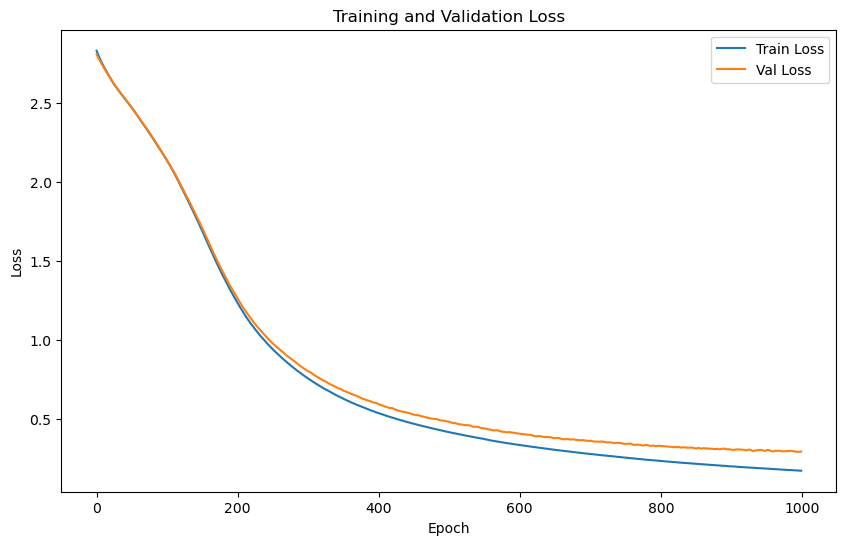

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 0.5958 | Test Accuracy: 83.52%


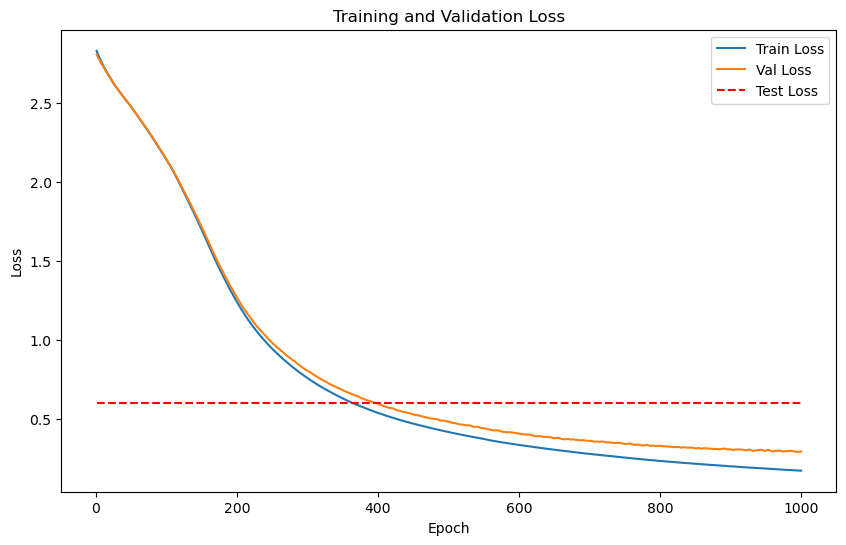

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 160 samples with 64 features each
LOG: Labels shape: (160,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 53889 samples with 64 features each
LOG: Labels shape: (53889,)


Train embeddings shape: (160, 64), 
Train labels shape: (160,)


Val embeddings shape: (80, 64), 
Val labels shape: (80,)


Test embeddings shape: (53889, 64), 
Test labels shape: (53889,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10, 10: 10, 11: 10, 12: 10, 13: 10, 14: 10, 15: 10}
Training batch size: 160


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.4539
LOG: Epoch [1/2000] - Validation
    Batch [1/2], Val Loss: 0.3236
    Batch [2/2], Val Loss: 0.3846
Epoch [1/2000], Avg Train Loss: 0.4539, Avg Val Loss: 0.3541

Validation loss improved from inf to 0.3541. Saving model...
LOG: Epoch [2/2000] - Training


    Batch [1/1], Train Loss: 0.4567
LOG: Epoch [2/2000] - Validation
    Batch [1/2], Val Loss: 0.3240
    Batch [2/2], Val Loss: 0.3837
Epoch [2/2000], Avg Train Loss: 0.4567, Avg Val Loss: 0.3538

Validation loss improved from 0.3541 to 0.3538. Saving model...
LOG: Epoch [3/2000] - Training


    Batch [1/1], Train Loss: 0.4505
LOG: Epoch [3/2000] - Validation
    Batch [1/2], Val Loss: 0.3249
    Batch [2/2], Val Loss: 0.3828
Epoch [3/2000], Avg Train Loss: 0.4505, Avg Val Loss: 0.3539

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [4/2000] - Training


    Batch [1/1], Train Loss: 0.4605
LOG: Epoch [4/2000] - Validation
    Batch [1/2], Val Loss: 0.3254
    Batch [2/2], Val Loss: 0.3823
Epoch [4/2000], Avg Train Loss: 0.4605, Avg Val Loss: 0.3538

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [5/2000] - Training


    Batch [1/1], Train Loss: 0.4502
LOG: Epoch [5/2000] - Validation
    Batch [1/2], Val Loss: 0.3257
    Batch [2/2], Val Loss: 0.3812
Epoch [5/2000], Avg Train Loss: 0.4502, Avg Val Loss: 0.3534

Validation loss improved from 0.3538 to 0.3534. Saving model...
LOG: Epoch [6/2000] - Training


    Batch [1/1], Train Loss: 0.4565
LOG: Epoch [6/2000] - Validation
    Batch [1/2], Val Loss: 0.3258
    Batch [2/2], Val Loss: 0.3798
Epoch [6/2000], Avg Train Loss: 0.4565, Avg Val Loss: 0.3528

Validation loss improved from 0.3534 to 0.3528. Saving model...
LOG: Epoch [7/2000] - Training


    Batch [1/1], Train Loss: 0.4531
LOG: Epoch [7/2000] - Validation
    Batch [1/2], Val Loss: 0.3261
    Batch [2/2], Val Loss: 0.3778
Epoch [7/2000], Avg Train Loss: 0.4531, Avg Val Loss: 0.3519

Validation loss improved from 0.3528 to 0.3519. Saving model...
LOG: Epoch [8/2000] - Training


    Batch [1/1], Train Loss: 0.4522
LOG: Epoch [8/2000] - Validation
    Batch [1/2], Val Loss: 0.3260
    Batch [2/2], Val Loss: 0.3751
Epoch [8/2000], Avg Train Loss: 0.4522, Avg Val Loss: 0.3505

Validation loss improved from 0.3519 to 0.3505. Saving model...
LOG: Epoch [9/2000] - Training


    Batch [1/1], Train Loss: 0.4532
LOG: Epoch [9/2000] - Validation
    Batch [1/2], Val Loss: 0.3259
    Batch [2/2], Val Loss: 0.3723
Epoch [9/2000], Avg Train Loss: 0.4532, Avg Val Loss: 0.3491

Validation loss improved from 0.3505 to 0.3491. Saving model...
LOG: Epoch [10/2000] - Training


    Batch [1/1], Train Loss: 0.4497
LOG: Epoch [10/2000] - Validation
    Batch [1/2], Val Loss: 0.3251
    Batch [2/2], Val Loss: 0.3690
Epoch [10/2000], Avg Train Loss: 0.4497, Avg Val Loss: 0.3470

Validation loss improved from 0.3491 to 0.3470. Saving model...
LOG: Epoch [11/2000] - Training


    Batch [1/1], Train Loss: 0.4470
LOG: Epoch [11/2000] - Validation
    Batch [1/2], Val Loss: 0.3241
    Batch [2/2], Val Loss: 0.3648
Epoch [11/2000], Avg Train Loss: 0.4470, Avg Val Loss: 0.3444

Validation loss improved from 0.3470 to 0.3444. Saving model...
LOG: Epoch [12/2000] - Training


    Batch [1/1], Train Loss: 0.4485
LOG: Epoch [12/2000] - Validation
    Batch [1/2], Val Loss: 0.3228
    Batch [2/2], Val Loss: 0.3607
Epoch [12/2000], Avg Train Loss: 0.4485, Avg Val Loss: 0.3417

Validation loss improved from 0.3444 to 0.3417. Saving model...
LOG: Epoch [13/2000] - Training


    Batch [1/1], Train Loss: 0.4439
LOG: Epoch [13/2000] - Validation
    Batch [1/2], Val Loss: 0.3213
    Batch [2/2], Val Loss: 0.3568
Epoch [13/2000], Avg Train Loss: 0.4439, Avg Val Loss: 0.3390

Validation loss improved from 0.3417 to 0.3390. Saving model...
LOG: Epoch [14/2000] - Training


    Batch [1/1], Train Loss: 0.4465
LOG: Epoch [14/2000] - Validation
    Batch [1/2], Val Loss: 0.3196
    Batch [2/2], Val Loss: 0.3527
Epoch [14/2000], Avg Train Loss: 0.4465, Avg Val Loss: 0.3362

Validation loss improved from 0.3390 to 0.3362. Saving model...
LOG: Epoch [15/2000] - Training


    Batch [1/1], Train Loss: 0.4436
LOG: Epoch [15/2000] - Validation
    Batch [1/2], Val Loss: 0.3175
    Batch [2/2], Val Loss: 0.3486
Epoch [15/2000], Avg Train Loss: 0.4436, Avg Val Loss: 0.3330

Validation loss improved from 0.3362 to 0.3330. Saving model...
LOG: Epoch [16/2000] - Training


    Batch [1/1], Train Loss: 0.4459
LOG: Epoch [16/2000] - Validation
    Batch [1/2], Val Loss: 0.3153
    Batch [2/2], Val Loss: 0.3445
Epoch [16/2000], Avg Train Loss: 0.4459, Avg Val Loss: 0.3299

Validation loss improved from 0.3330 to 0.3299. Saving model...
LOG: Epoch [17/2000] - Training


    Batch [1/1], Train Loss: 0.4478
LOG: Epoch [17/2000] - Validation
    Batch [1/2], Val Loss: 0.3133
    Batch [2/2], Val Loss: 0.3400
Epoch [17/2000], Avg Train Loss: 0.4478, Avg Val Loss: 0.3266

Validation loss improved from 0.3299 to 0.3266. Saving model...
LOG: Epoch [18/2000] - Training


    Batch [1/1], Train Loss: 0.4452
LOG: Epoch [18/2000] - Validation
    Batch [1/2], Val Loss: 0.3115
    Batch [2/2], Val Loss: 0.3357
Epoch [18/2000], Avg Train Loss: 0.4452, Avg Val Loss: 0.3236

Validation loss improved from 0.3266 to 0.3236. Saving model...
LOG: Epoch [19/2000] - Training


    Batch [1/1], Train Loss: 0.4420
LOG: Epoch [19/2000] - Validation
    Batch [1/2], Val Loss: 0.3101
    Batch [2/2], Val Loss: 0.3318
Epoch [19/2000], Avg Train Loss: 0.4420, Avg Val Loss: 0.3209

Validation loss improved from 0.3236 to 0.3209. Saving model...
LOG: Epoch [20/2000] - Training


    Batch [1/1], Train Loss: 0.4321
LOG: Epoch [20/2000] - Validation
    Batch [1/2], Val Loss: 0.3088
    Batch [2/2], Val Loss: 0.3280
Epoch [20/2000], Avg Train Loss: 0.4321, Avg Val Loss: 0.3184

Validation loss improved from 0.3209 to 0.3184. Saving model...
LOG: Epoch [21/2000] - Training


    Batch [1/1], Train Loss: 0.4383
LOG: Epoch [21/2000] - Validation
    Batch [1/2], Val Loss: 0.3075
    Batch [2/2], Val Loss: 0.3243
Epoch [21/2000], Avg Train Loss: 0.4383, Avg Val Loss: 0.3159

Validation loss improved from 0.3184 to 0.3159. Saving model...
LOG: Epoch [22/2000] - Training


    Batch [1/1], Train Loss: 0.4354
LOG: Epoch [22/2000] - Validation
    Batch [1/2], Val Loss: 0.3062
    Batch [2/2], Val Loss: 0.3210
Epoch [22/2000], Avg Train Loss: 0.4354, Avg Val Loss: 0.3136

Validation loss improved from 0.3159 to 0.3136. Saving model...
LOG: Epoch [23/2000] - Training


    Batch [1/1], Train Loss: 0.4359
LOG: Epoch [23/2000] - Validation
    Batch [1/2], Val Loss: 0.3052
    Batch [2/2], Val Loss: 0.3182
Epoch [23/2000], Avg Train Loss: 0.4359, Avg Val Loss: 0.3117

Validation loss improved from 0.3136 to 0.3117. Saving model...
LOG: Epoch [24/2000] - Training


    Batch [1/1], Train Loss: 0.4353
LOG: Epoch [24/2000] - Validation
    Batch [1/2], Val Loss: 0.3043
    Batch [2/2], Val Loss: 0.3156
Epoch [24/2000], Avg Train Loss: 0.4353, Avg Val Loss: 0.3099

Validation loss improved from 0.3117 to 0.3099. Saving model...
LOG: Epoch [25/2000] - Training


    Batch [1/1], Train Loss: 0.4412
LOG: Epoch [25/2000] - Validation
    Batch [1/2], Val Loss: 0.3034
    Batch [2/2], Val Loss: 0.3131
Epoch [25/2000], Avg Train Loss: 0.4412, Avg Val Loss: 0.3082

Validation loss improved from 0.3099 to 0.3082. Saving model...
LOG: Epoch [26/2000] - Training


    Batch [1/1], Train Loss: 0.4394
LOG: Epoch [26/2000] - Validation
    Batch [1/2], Val Loss: 0.3025
    Batch [2/2], Val Loss: 0.3110
Epoch [26/2000], Avg Train Loss: 0.4394, Avg Val Loss: 0.3068

Validation loss improved from 0.3082 to 0.3068. Saving model...
LOG: Epoch [27/2000] - Training


    Batch [1/1], Train Loss: 0.4362
LOG: Epoch [27/2000] - Validation
    Batch [1/2], Val Loss: 0.3017
    Batch [2/2], Val Loss: 0.3091
Epoch [27/2000], Avg Train Loss: 0.4362, Avg Val Loss: 0.3054

Validation loss improved from 0.3068 to 0.3054. Saving model...
LOG: Epoch [28/2000] - Training


    Batch [1/1], Train Loss: 0.4341
LOG: Epoch [28/2000] - Validation
    Batch [1/2], Val Loss: 0.3008
    Batch [2/2], Val Loss: 0.3073
Epoch [28/2000], Avg Train Loss: 0.4341, Avg Val Loss: 0.3041

Validation loss improved from 0.3054 to 0.3041. Saving model...
LOG: Epoch [29/2000] - Training


    Batch [1/1], Train Loss: 0.4345
LOG: Epoch [29/2000] - Validation
    Batch [1/2], Val Loss: 0.3000
    Batch [2/2], Val Loss: 0.3055
Epoch [29/2000], Avg Train Loss: 0.4345, Avg Val Loss: 0.3028

Validation loss improved from 0.3041 to 0.3028. Saving model...
LOG: Epoch [30/2000] - Training


    Batch [1/1], Train Loss: 0.4338
LOG: Epoch [30/2000] - Validation
    Batch [1/2], Val Loss: 0.2992
    Batch [2/2], Val Loss: 0.3039
Epoch [30/2000], Avg Train Loss: 0.4338, Avg Val Loss: 0.3016

Validation loss improved from 0.3028 to 0.3016. Saving model...
LOG: Epoch [31/2000] - Training


    Batch [1/1], Train Loss: 0.4366
LOG: Epoch [31/2000] - Validation
    Batch [1/2], Val Loss: 0.2984
    Batch [2/2], Val Loss: 0.3024
Epoch [31/2000], Avg Train Loss: 0.4366, Avg Val Loss: 0.3004

Validation loss improved from 0.3016 to 0.3004. Saving model...
LOG: Epoch [32/2000] - Training


    Batch [1/1], Train Loss: 0.4230
LOG: Epoch [32/2000] - Validation
    Batch [1/2], Val Loss: 0.2978
    Batch [2/2], Val Loss: 0.3009
Epoch [32/2000], Avg Train Loss: 0.4230, Avg Val Loss: 0.2993

Validation loss improved from 0.3004 to 0.2993. Saving model...
LOG: Epoch [33/2000] - Training


    Batch [1/1], Train Loss: 0.4314
LOG: Epoch [33/2000] - Validation
    Batch [1/2], Val Loss: 0.2971
    Batch [2/2], Val Loss: 0.2995
Epoch [33/2000], Avg Train Loss: 0.4314, Avg Val Loss: 0.2983

Validation loss improved from 0.2993 to 0.2983. Saving model...
LOG: Epoch [34/2000] - Training


    Batch [1/1], Train Loss: 0.4338
LOG: Epoch [34/2000] - Validation
    Batch [1/2], Val Loss: 0.2965
    Batch [2/2], Val Loss: 0.2981
Epoch [34/2000], Avg Train Loss: 0.4338, Avg Val Loss: 0.2973

Validation loss improved from 0.2983 to 0.2973. Saving model...
LOG: Epoch [35/2000] - Training


    Batch [1/1], Train Loss: 0.4268
LOG: Epoch [35/2000] - Validation
    Batch [1/2], Val Loss: 0.2959
    Batch [2/2], Val Loss: 0.2968
Epoch [35/2000], Avg Train Loss: 0.4268, Avg Val Loss: 0.2964

Validation loss improved from 0.2973 to 0.2964. Saving model...
LOG: Epoch [36/2000] - Training


    Batch [1/1], Train Loss: 0.4319
LOG: Epoch [36/2000] - Validation
    Batch [1/2], Val Loss: 0.2953
    Batch [2/2], Val Loss: 0.2956
Epoch [36/2000], Avg Train Loss: 0.4319, Avg Val Loss: 0.2954

Validation loss improved from 0.2964 to 0.2954. Saving model...
LOG: Epoch [37/2000] - Training


    Batch [1/1], Train Loss: 0.4307
LOG: Epoch [37/2000] - Validation
    Batch [1/2], Val Loss: 0.2947
    Batch [2/2], Val Loss: 0.2945
Epoch [37/2000], Avg Train Loss: 0.4307, Avg Val Loss: 0.2946

Validation loss improved from 0.2954 to 0.2946. Saving model...
LOG: Epoch [38/2000] - Training


    Batch [1/1], Train Loss: 0.4344
LOG: Epoch [38/2000] - Validation
    Batch [1/2], Val Loss: 0.2941
    Batch [2/2], Val Loss: 0.2934
Epoch [38/2000], Avg Train Loss: 0.4344, Avg Val Loss: 0.2937

Validation loss improved from 0.2946 to 0.2937. Saving model...
LOG: Epoch [39/2000] - Training


    Batch [1/1], Train Loss: 0.4277
LOG: Epoch [39/2000] - Validation
    Batch [1/2], Val Loss: 0.2935
    Batch [2/2], Val Loss: 0.2923
Epoch [39/2000], Avg Train Loss: 0.4277, Avg Val Loss: 0.2929

Validation loss improved from 0.2937 to 0.2929. Saving model...
LOG: Epoch [40/2000] - Training


    Batch [1/1], Train Loss: 0.4249
LOG: Epoch [40/2000] - Validation
    Batch [1/2], Val Loss: 0.2929
    Batch [2/2], Val Loss: 0.2913
Epoch [40/2000], Avg Train Loss: 0.4249, Avg Val Loss: 0.2921

Validation loss improved from 0.2929 to 0.2921. Saving model...
LOG: Epoch [41/2000] - Training


    Batch [1/1], Train Loss: 0.4239
LOG: Epoch [41/2000] - Validation
    Batch [1/2], Val Loss: 0.2923
    Batch [2/2], Val Loss: 0.2903
Epoch [41/2000], Avg Train Loss: 0.4239, Avg Val Loss: 0.2913

Validation loss improved from 0.2921 to 0.2913. Saving model...
LOG: Epoch [42/2000] - Training


    Batch [1/1], Train Loss: 0.4201
LOG: Epoch [42/2000] - Validation
    Batch [1/2], Val Loss: 0.2917
    Batch [2/2], Val Loss: 0.2894
Epoch [42/2000], Avg Train Loss: 0.4201, Avg Val Loss: 0.2906

Validation loss improved from 0.2913 to 0.2906. Saving model...
LOG: Epoch [43/2000] - Training


    Batch [1/1], Train Loss: 0.4262
LOG: Epoch [43/2000] - Validation
    Batch [1/2], Val Loss: 0.2912
    Batch [2/2], Val Loss: 0.2885
Epoch [43/2000], Avg Train Loss: 0.4262, Avg Val Loss: 0.2898

Validation loss improved from 0.2906 to 0.2898. Saving model...
LOG: Epoch [44/2000] - Training


    Batch [1/1], Train Loss: 0.4213
LOG: Epoch [44/2000] - Validation
    Batch [1/2], Val Loss: 0.2906
    Batch [2/2], Val Loss: 0.2876
Epoch [44/2000], Avg Train Loss: 0.4213, Avg Val Loss: 0.2891

Validation loss improved from 0.2898 to 0.2891. Saving model...
LOG: Epoch [45/2000] - Training


    Batch [1/1], Train Loss: 0.4221
LOG: Epoch [45/2000] - Validation
    Batch [1/2], Val Loss: 0.2901
    Batch [2/2], Val Loss: 0.2868
Epoch [45/2000], Avg Train Loss: 0.4221, Avg Val Loss: 0.2884

Validation loss improved from 0.2891 to 0.2884. Saving model...
LOG: Epoch [46/2000] - Training


    Batch [1/1], Train Loss: 0.4126
LOG: Epoch [46/2000] - Validation
    Batch [1/2], Val Loss: 0.2895
    Batch [2/2], Val Loss: 0.2860
Epoch [46/2000], Avg Train Loss: 0.4126, Avg Val Loss: 0.2877

Validation loss improved from 0.2884 to 0.2877. Saving model...
LOG: Epoch [47/2000] - Training


    Batch [1/1], Train Loss: 0.4255
LOG: Epoch [47/2000] - Validation
    Batch [1/2], Val Loss: 0.2890
    Batch [2/2], Val Loss: 0.2852
Epoch [47/2000], Avg Train Loss: 0.4255, Avg Val Loss: 0.2871

Validation loss improved from 0.2877 to 0.2871. Saving model...
LOG: Epoch [48/2000] - Training


    Batch [1/1], Train Loss: 0.4147
LOG: Epoch [48/2000] - Validation
    Batch [1/2], Val Loss: 0.2884
    Batch [2/2], Val Loss: 0.2844
Epoch [48/2000], Avg Train Loss: 0.4147, Avg Val Loss: 0.2864

Validation loss improved from 0.2871 to 0.2864. Saving model...
LOG: Epoch [49/2000] - Training


    Batch [1/1], Train Loss: 0.4238
LOG: Epoch [49/2000] - Validation
    Batch [1/2], Val Loss: 0.2879
    Batch [2/2], Val Loss: 0.2836
Epoch [49/2000], Avg Train Loss: 0.4238, Avg Val Loss: 0.2858

Validation loss improved from 0.2864 to 0.2858. Saving model...
LOG: Epoch [50/2000] - Training


    Batch [1/1], Train Loss: 0.4217
LOG: Epoch [50/2000] - Validation
    Batch [1/2], Val Loss: 0.2873
    Batch [2/2], Val Loss: 0.2828
Epoch [50/2000], Avg Train Loss: 0.4217, Avg Val Loss: 0.2851

Validation loss improved from 0.2858 to 0.2851. Saving model...
LOG: Epoch [51/2000] - Training


    Batch [1/1], Train Loss: 0.4160
LOG: Epoch [51/2000] - Validation
    Batch [1/2], Val Loss: 0.2868
    Batch [2/2], Val Loss: 0.2821
Epoch [51/2000], Avg Train Loss: 0.4160, Avg Val Loss: 0.2844

Validation loss improved from 0.2851 to 0.2844. Saving model...
LOG: Epoch [52/2000] - Training


    Batch [1/1], Train Loss: 0.4127
LOG: Epoch [52/2000] - Validation
    Batch [1/2], Val Loss: 0.2863
    Batch [2/2], Val Loss: 0.2813
Epoch [52/2000], Avg Train Loss: 0.4127, Avg Val Loss: 0.2838

Validation loss improved from 0.2844 to 0.2838. Saving model...
LOG: Epoch [53/2000] - Training


    Batch [1/1], Train Loss: 0.4188
LOG: Epoch [53/2000] - Validation
    Batch [1/2], Val Loss: 0.2857
    Batch [2/2], Val Loss: 0.2806
Epoch [53/2000], Avg Train Loss: 0.4188, Avg Val Loss: 0.2832

Validation loss improved from 0.2838 to 0.2832. Saving model...
LOG: Epoch [54/2000] - Training


    Batch [1/1], Train Loss: 0.4217
LOG: Epoch [54/2000] - Validation
    Batch [1/2], Val Loss: 0.2852
    Batch [2/2], Val Loss: 0.2799
Epoch [54/2000], Avg Train Loss: 0.4217, Avg Val Loss: 0.2825

Validation loss improved from 0.2832 to 0.2825. Saving model...
LOG: Epoch [55/2000] - Training


    Batch [1/1], Train Loss: 0.4191
LOG: Epoch [55/2000] - Validation
    Batch [1/2], Val Loss: 0.2846
    Batch [2/2], Val Loss: 0.2792
Epoch [55/2000], Avg Train Loss: 0.4191, Avg Val Loss: 0.2819

Validation loss improved from 0.2825 to 0.2819. Saving model...
LOG: Epoch [56/2000] - Training


    Batch [1/1], Train Loss: 0.4155
LOG: Epoch [56/2000] - Validation
    Batch [1/2], Val Loss: 0.2841
    Batch [2/2], Val Loss: 0.2785
Epoch [56/2000], Avg Train Loss: 0.4155, Avg Val Loss: 0.2813

Validation loss improved from 0.2819 to 0.2813. Saving model...
LOG: Epoch [57/2000] - Training


    Batch [1/1], Train Loss: 0.4196
LOG: Epoch [57/2000] - Validation
    Batch [1/2], Val Loss: 0.2836
    Batch [2/2], Val Loss: 0.2778
Epoch [57/2000], Avg Train Loss: 0.4196, Avg Val Loss: 0.2807

Validation loss improved from 0.2813 to 0.2807. Saving model...
LOG: Epoch [58/2000] - Training


    Batch [1/1], Train Loss: 0.4133
LOG: Epoch [58/2000] - Validation
    Batch [1/2], Val Loss: 0.2831
    Batch [2/2], Val Loss: 0.2772
Epoch [58/2000], Avg Train Loss: 0.4133, Avg Val Loss: 0.2801

Validation loss improved from 0.2807 to 0.2801. Saving model...
LOG: Epoch [59/2000] - Training


    Batch [1/1], Train Loss: 0.4149
LOG: Epoch [59/2000] - Validation
    Batch [1/2], Val Loss: 0.2826
    Batch [2/2], Val Loss: 0.2766
Epoch [59/2000], Avg Train Loss: 0.4149, Avg Val Loss: 0.2796

Validation loss improved from 0.2801 to 0.2796. Saving model...
LOG: Epoch [60/2000] - Training


    Batch [1/1], Train Loss: 0.4152
LOG: Epoch [60/2000] - Validation
    Batch [1/2], Val Loss: 0.2821
    Batch [2/2], Val Loss: 0.2760
Epoch [60/2000], Avg Train Loss: 0.4152, Avg Val Loss: 0.2790

Validation loss improved from 0.2796 to 0.2790. Saving model...
LOG: Epoch [61/2000] - Training


    Batch [1/1], Train Loss: 0.4139
LOG: Epoch [61/2000] - Validation
    Batch [1/2], Val Loss: 0.2816
    Batch [2/2], Val Loss: 0.2754
Epoch [61/2000], Avg Train Loss: 0.4139, Avg Val Loss: 0.2785

Validation loss improved from 0.2790 to 0.2785. Saving model...
LOG: Epoch [62/2000] - Training


    Batch [1/1], Train Loss: 0.4105
LOG: Epoch [62/2000] - Validation
    Batch [1/2], Val Loss: 0.2811
    Batch [2/2], Val Loss: 0.2748
Epoch [62/2000], Avg Train Loss: 0.4105, Avg Val Loss: 0.2780

Validation loss improved from 0.2785 to 0.2780. Saving model...
LOG: Epoch [63/2000] - Training


    Batch [1/1], Train Loss: 0.4168
LOG: Epoch [63/2000] - Validation
    Batch [1/2], Val Loss: 0.2807
    Batch [2/2], Val Loss: 0.2743
Epoch [63/2000], Avg Train Loss: 0.4168, Avg Val Loss: 0.2775

Validation loss improved from 0.2780 to 0.2775. Saving model...
LOG: Epoch [64/2000] - Training


    Batch [1/1], Train Loss: 0.4120
LOG: Epoch [64/2000] - Validation
    Batch [1/2], Val Loss: 0.2803
    Batch [2/2], Val Loss: 0.2738
Epoch [64/2000], Avg Train Loss: 0.4120, Avg Val Loss: 0.2770

Validation loss improved from 0.2775 to 0.2770. Saving model...
LOG: Epoch [65/2000] - Training


    Batch [1/1], Train Loss: 0.4090
LOG: Epoch [65/2000] - Validation
    Batch [1/2], Val Loss: 0.2799
    Batch [2/2], Val Loss: 0.2732
Epoch [65/2000], Avg Train Loss: 0.4090, Avg Val Loss: 0.2765

Validation loss improved from 0.2770 to 0.2765. Saving model...
LOG: Epoch [66/2000] - Training


    Batch [1/1], Train Loss: 0.3994
LOG: Epoch [66/2000] - Validation
    Batch [1/2], Val Loss: 0.2794
    Batch [2/2], Val Loss: 0.2728
Epoch [66/2000], Avg Train Loss: 0.3994, Avg Val Loss: 0.2761

Validation loss improved from 0.2765 to 0.2761. Saving model...
LOG: Epoch [67/2000] - Training


    Batch [1/1], Train Loss: 0.4037
LOG: Epoch [67/2000] - Validation
    Batch [1/2], Val Loss: 0.2790
    Batch [2/2], Val Loss: 0.2722
Epoch [67/2000], Avg Train Loss: 0.4037, Avg Val Loss: 0.2756

Validation loss improved from 0.2761 to 0.2756. Saving model...
LOG: Epoch [68/2000] - Training


    Batch [1/1], Train Loss: 0.4056
LOG: Epoch [68/2000] - Validation
    Batch [1/2], Val Loss: 0.2786
    Batch [2/2], Val Loss: 0.2717
Epoch [68/2000], Avg Train Loss: 0.4056, Avg Val Loss: 0.2752

Validation loss improved from 0.2756 to 0.2752. Saving model...
LOG: Epoch [69/2000] - Training


    Batch [1/1], Train Loss: 0.4132
LOG: Epoch [69/2000] - Validation
    Batch [1/2], Val Loss: 0.2782
    Batch [2/2], Val Loss: 0.2711
Epoch [69/2000], Avg Train Loss: 0.4132, Avg Val Loss: 0.2747

Validation loss improved from 0.2752 to 0.2747. Saving model...
LOG: Epoch [70/2000] - Training


    Batch [1/1], Train Loss: 0.4009
LOG: Epoch [70/2000] - Validation
    Batch [1/2], Val Loss: 0.2777
    Batch [2/2], Val Loss: 0.2706
Epoch [70/2000], Avg Train Loss: 0.4009, Avg Val Loss: 0.2742

Validation loss improved from 0.2747 to 0.2742. Saving model...
LOG: Epoch [71/2000] - Training


    Batch [1/1], Train Loss: 0.4066
LOG: Epoch [71/2000] - Validation
    Batch [1/2], Val Loss: 0.2773
    Batch [2/2], Val Loss: 0.2701
Epoch [71/2000], Avg Train Loss: 0.4066, Avg Val Loss: 0.2737

Validation loss improved from 0.2742 to 0.2737. Saving model...
LOG: Epoch [72/2000] - Training


    Batch [1/1], Train Loss: 0.3974
LOG: Epoch [72/2000] - Validation
    Batch [1/2], Val Loss: 0.2769
    Batch [2/2], Val Loss: 0.2695
Epoch [72/2000], Avg Train Loss: 0.3974, Avg Val Loss: 0.2732

Validation loss improved from 0.2737 to 0.2732. Saving model...
LOG: Epoch [73/2000] - Training


    Batch [1/1], Train Loss: 0.3985
LOG: Epoch [73/2000] - Validation
    Batch [1/2], Val Loss: 0.2765
    Batch [2/2], Val Loss: 0.2689
Epoch [73/2000], Avg Train Loss: 0.3985, Avg Val Loss: 0.2727

Validation loss improved from 0.2732 to 0.2727. Saving model...
LOG: Epoch [74/2000] - Training


    Batch [1/1], Train Loss: 0.4030
LOG: Epoch [74/2000] - Validation
    Batch [1/2], Val Loss: 0.2761
    Batch [2/2], Val Loss: 0.2684
Epoch [74/2000], Avg Train Loss: 0.4030, Avg Val Loss: 0.2722

Validation loss improved from 0.2727 to 0.2722. Saving model...
LOG: Epoch [75/2000] - Training


    Batch [1/1], Train Loss: 0.4058
LOG: Epoch [75/2000] - Validation
    Batch [1/2], Val Loss: 0.2757
    Batch [2/2], Val Loss: 0.2678
Epoch [75/2000], Avg Train Loss: 0.4058, Avg Val Loss: 0.2718

Validation loss improved from 0.2722 to 0.2718. Saving model...
LOG: Epoch [76/2000] - Training


    Batch [1/1], Train Loss: 0.3977
LOG: Epoch [76/2000] - Validation
    Batch [1/2], Val Loss: 0.2753
    Batch [2/2], Val Loss: 0.2674
Epoch [76/2000], Avg Train Loss: 0.3977, Avg Val Loss: 0.2713

Validation loss improved from 0.2718 to 0.2713. Saving model...
LOG: Epoch [77/2000] - Training


    Batch [1/1], Train Loss: 0.3932
LOG: Epoch [77/2000] - Validation
    Batch [1/2], Val Loss: 0.2749
    Batch [2/2], Val Loss: 0.2669
Epoch [77/2000], Avg Train Loss: 0.3932, Avg Val Loss: 0.2709

Validation loss improved from 0.2713 to 0.2709. Saving model...
LOG: Epoch [78/2000] - Training


    Batch [1/1], Train Loss: 0.4056
LOG: Epoch [78/2000] - Validation
    Batch [1/2], Val Loss: 0.2746
    Batch [2/2], Val Loss: 0.2664
Epoch [78/2000], Avg Train Loss: 0.4056, Avg Val Loss: 0.2705

Validation loss improved from 0.2709 to 0.2705. Saving model...
LOG: Epoch [79/2000] - Training


    Batch [1/1], Train Loss: 0.4005
LOG: Epoch [79/2000] - Validation
    Batch [1/2], Val Loss: 0.2741
    Batch [2/2], Val Loss: 0.2660
Epoch [79/2000], Avg Train Loss: 0.4005, Avg Val Loss: 0.2701

Validation loss improved from 0.2705 to 0.2701. Saving model...
LOG: Epoch [80/2000] - Training


    Batch [1/1], Train Loss: 0.3961
LOG: Epoch [80/2000] - Validation
    Batch [1/2], Val Loss: 0.2738
    Batch [2/2], Val Loss: 0.2656
Epoch [80/2000], Avg Train Loss: 0.3961, Avg Val Loss: 0.2697

Validation loss improved from 0.2701 to 0.2697. Saving model...
LOG: Epoch [81/2000] - Training


    Batch [1/1], Train Loss: 0.4007
LOG: Epoch [81/2000] - Validation
    Batch [1/2], Val Loss: 0.2734
    Batch [2/2], Val Loss: 0.2651
Epoch [81/2000], Avg Train Loss: 0.4007, Avg Val Loss: 0.2693

Validation loss improved from 0.2697 to 0.2693. Saving model...
LOG: Epoch [82/2000] - Training


    Batch [1/1], Train Loss: 0.3988
LOG: Epoch [82/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.2647
Epoch [82/2000], Avg Train Loss: 0.3988, Avg Val Loss: 0.2689

Validation loss improved from 0.2693 to 0.2689. Saving model...
LOG: Epoch [83/2000] - Training


    Batch [1/1], Train Loss: 0.3990
LOG: Epoch [83/2000] - Validation
    Batch [1/2], Val Loss: 0.2727
    Batch [2/2], Val Loss: 0.2644
Epoch [83/2000], Avg Train Loss: 0.3990, Avg Val Loss: 0.2685

Validation loss improved from 0.2689 to 0.2685. Saving model...
LOG: Epoch [84/2000] - Training


    Batch [1/1], Train Loss: 0.3998
LOG: Epoch [84/2000] - Validation
    Batch [1/2], Val Loss: 0.2723
    Batch [2/2], Val Loss: 0.2640
Epoch [84/2000], Avg Train Loss: 0.3998, Avg Val Loss: 0.2681

Validation loss improved from 0.2685 to 0.2681. Saving model...
LOG: Epoch [85/2000] - Training


    Batch [1/1], Train Loss: 0.3949
LOG: Epoch [85/2000] - Validation
    Batch [1/2], Val Loss: 0.2719
    Batch [2/2], Val Loss: 0.2636
Epoch [85/2000], Avg Train Loss: 0.3949, Avg Val Loss: 0.2677

Validation loss improved from 0.2681 to 0.2677. Saving model...
LOG: Epoch [86/2000] - Training


    Batch [1/1], Train Loss: 0.3963
LOG: Epoch [86/2000] - Validation
    Batch [1/2], Val Loss: 0.2715
    Batch [2/2], Val Loss: 0.2632
Epoch [86/2000], Avg Train Loss: 0.3963, Avg Val Loss: 0.2674

Validation loss improved from 0.2677 to 0.2674. Saving model...
LOG: Epoch [87/2000] - Training


    Batch [1/1], Train Loss: 0.3919
LOG: Epoch [87/2000] - Validation
    Batch [1/2], Val Loss: 0.2711
    Batch [2/2], Val Loss: 0.2628
Epoch [87/2000], Avg Train Loss: 0.3919, Avg Val Loss: 0.2669

Validation loss improved from 0.2674 to 0.2669. Saving model...
LOG: Epoch [88/2000] - Training


    Batch [1/1], Train Loss: 0.3920
LOG: Epoch [88/2000] - Validation
    Batch [1/2], Val Loss: 0.2707
    Batch [2/2], Val Loss: 0.2623
Epoch [88/2000], Avg Train Loss: 0.3920, Avg Val Loss: 0.2665

Validation loss improved from 0.2669 to 0.2665. Saving model...
LOG: Epoch [89/2000] - Training


    Batch [1/1], Train Loss: 0.3924
LOG: Epoch [89/2000] - Validation
    Batch [1/2], Val Loss: 0.2702
    Batch [2/2], Val Loss: 0.2619
Epoch [89/2000], Avg Train Loss: 0.3924, Avg Val Loss: 0.2661

Validation loss improved from 0.2665 to 0.2661. Saving model...
LOG: Epoch [90/2000] - Training


    Batch [1/1], Train Loss: 0.3942
LOG: Epoch [90/2000] - Validation
    Batch [1/2], Val Loss: 0.2698
    Batch [2/2], Val Loss: 0.2615
Epoch [90/2000], Avg Train Loss: 0.3942, Avg Val Loss: 0.2657

Validation loss improved from 0.2661 to 0.2657. Saving model...
LOG: Epoch [91/2000] - Training


    Batch [1/1], Train Loss: 0.4010
LOG: Epoch [91/2000] - Validation
    Batch [1/2], Val Loss: 0.2694
    Batch [2/2], Val Loss: 0.2612
Epoch [91/2000], Avg Train Loss: 0.4010, Avg Val Loss: 0.2653

Validation loss improved from 0.2657 to 0.2653. Saving model...
LOG: Epoch [92/2000] - Training


    Batch [1/1], Train Loss: 0.3921
LOG: Epoch [92/2000] - Validation
    Batch [1/2], Val Loss: 0.2690
    Batch [2/2], Val Loss: 0.2608
Epoch [92/2000], Avg Train Loss: 0.3921, Avg Val Loss: 0.2649

Validation loss improved from 0.2653 to 0.2649. Saving model...
LOG: Epoch [93/2000] - Training


    Batch [1/1], Train Loss: 0.3899
LOG: Epoch [93/2000] - Validation
    Batch [1/2], Val Loss: 0.2686
    Batch [2/2], Val Loss: 0.2605
Epoch [93/2000], Avg Train Loss: 0.3899, Avg Val Loss: 0.2645

Validation loss improved from 0.2649 to 0.2645. Saving model...
LOG: Epoch [94/2000] - Training


    Batch [1/1], Train Loss: 0.3976
LOG: Epoch [94/2000] - Validation
    Batch [1/2], Val Loss: 0.2682
    Batch [2/2], Val Loss: 0.2601
Epoch [94/2000], Avg Train Loss: 0.3976, Avg Val Loss: 0.2642

Validation loss improved from 0.2645 to 0.2642. Saving model...
LOG: Epoch [95/2000] - Training


    Batch [1/1], Train Loss: 0.3822
LOG: Epoch [95/2000] - Validation
    Batch [1/2], Val Loss: 0.2678
    Batch [2/2], Val Loss: 0.2598
Epoch [95/2000], Avg Train Loss: 0.3822, Avg Val Loss: 0.2638

Validation loss improved from 0.2642 to 0.2638. Saving model...
LOG: Epoch [96/2000] - Training


    Batch [1/1], Train Loss: 0.3891
LOG: Epoch [96/2000] - Validation
    Batch [1/2], Val Loss: 0.2674
    Batch [2/2], Val Loss: 0.2595
Epoch [96/2000], Avg Train Loss: 0.3891, Avg Val Loss: 0.2634

Validation loss improved from 0.2638 to 0.2634. Saving model...
LOG: Epoch [97/2000] - Training


    Batch [1/1], Train Loss: 0.3843
LOG: Epoch [97/2000] - Validation
    Batch [1/2], Val Loss: 0.2669
    Batch [2/2], Val Loss: 0.2592
Epoch [97/2000], Avg Train Loss: 0.3843, Avg Val Loss: 0.2631

Validation loss improved from 0.2634 to 0.2631. Saving model...
LOG: Epoch [98/2000] - Training


    Batch [1/1], Train Loss: 0.3816
LOG: Epoch [98/2000] - Validation
    Batch [1/2], Val Loss: 0.2665
    Batch [2/2], Val Loss: 0.2589
Epoch [98/2000], Avg Train Loss: 0.3816, Avg Val Loss: 0.2627

Validation loss improved from 0.2631 to 0.2627. Saving model...
LOG: Epoch [99/2000] - Training


    Batch [1/1], Train Loss: 0.3908
LOG: Epoch [99/2000] - Validation
    Batch [1/2], Val Loss: 0.2660
    Batch [2/2], Val Loss: 0.2586
Epoch [99/2000], Avg Train Loss: 0.3908, Avg Val Loss: 0.2623

Validation loss improved from 0.2627 to 0.2623. Saving model...
LOG: Epoch [100/2000] - Training


    Batch [1/1], Train Loss: 0.3817
LOG: Epoch [100/2000] - Validation
    Batch [1/2], Val Loss: 0.2656
    Batch [2/2], Val Loss: 0.2582
Epoch [100/2000], Avg Train Loss: 0.3817, Avg Val Loss: 0.2619

Validation loss improved from 0.2623 to 0.2619. Saving model...
LOG: Epoch [101/2000] - Training


    Batch [1/1], Train Loss: 0.3822
LOG: Epoch [101/2000] - Validation
    Batch [1/2], Val Loss: 0.2652
    Batch [2/2], Val Loss: 0.2579
Epoch [101/2000], Avg Train Loss: 0.3822, Avg Val Loss: 0.2615

Validation loss improved from 0.2619 to 0.2615. Saving model...
LOG: Epoch [102/2000] - Training


    Batch [1/1], Train Loss: 0.3807
LOG: Epoch [102/2000] - Validation
    Batch [1/2], Val Loss: 0.2648
    Batch [2/2], Val Loss: 0.2575
Epoch [102/2000], Avg Train Loss: 0.3807, Avg Val Loss: 0.2611

Validation loss improved from 0.2615 to 0.2611. Saving model...
LOG: Epoch [103/2000] - Training


    Batch [1/1], Train Loss: 0.3761
LOG: Epoch [103/2000] - Validation
    Batch [1/2], Val Loss: 0.2643
    Batch [2/2], Val Loss: 0.2572
Epoch [103/2000], Avg Train Loss: 0.3761, Avg Val Loss: 0.2607

Validation loss improved from 0.2611 to 0.2607. Saving model...
LOG: Epoch [104/2000] - Training


    Batch [1/1], Train Loss: 0.3900
LOG: Epoch [104/2000] - Validation
    Batch [1/2], Val Loss: 0.2639
    Batch [2/2], Val Loss: 0.2568
Epoch [104/2000], Avg Train Loss: 0.3900, Avg Val Loss: 0.2604

Validation loss improved from 0.2607 to 0.2604. Saving model...
LOG: Epoch [105/2000] - Training


    Batch [1/1], Train Loss: 0.3819
LOG: Epoch [105/2000] - Validation
    Batch [1/2], Val Loss: 0.2636
    Batch [2/2], Val Loss: 0.2565
Epoch [105/2000], Avg Train Loss: 0.3819, Avg Val Loss: 0.2600

Validation loss improved from 0.2604 to 0.2600. Saving model...
LOG: Epoch [106/2000] - Training


    Batch [1/1], Train Loss: 0.3861
LOG: Epoch [106/2000] - Validation
    Batch [1/2], Val Loss: 0.2632
    Batch [2/2], Val Loss: 0.2561
Epoch [106/2000], Avg Train Loss: 0.3861, Avg Val Loss: 0.2596

Validation loss improved from 0.2600 to 0.2596. Saving model...
LOG: Epoch [107/2000] - Training


    Batch [1/1], Train Loss: 0.3842
LOG: Epoch [107/2000] - Validation
    Batch [1/2], Val Loss: 0.2628
    Batch [2/2], Val Loss: 0.2557
Epoch [107/2000], Avg Train Loss: 0.3842, Avg Val Loss: 0.2593

Validation loss improved from 0.2596 to 0.2593. Saving model...
LOG: Epoch [108/2000] - Training


    Batch [1/1], Train Loss: 0.3825
LOG: Epoch [108/2000] - Validation
    Batch [1/2], Val Loss: 0.2625
    Batch [2/2], Val Loss: 0.2554
Epoch [108/2000], Avg Train Loss: 0.3825, Avg Val Loss: 0.2589

Validation loss improved from 0.2593 to 0.2589. Saving model...
LOG: Epoch [109/2000] - Training


    Batch [1/1], Train Loss: 0.3876
LOG: Epoch [109/2000] - Validation
    Batch [1/2], Val Loss: 0.2622
    Batch [2/2], Val Loss: 0.2551
Epoch [109/2000], Avg Train Loss: 0.3876, Avg Val Loss: 0.2586

Validation loss improved from 0.2589 to 0.2586. Saving model...
LOG: Epoch [110/2000] - Training


    Batch [1/1], Train Loss: 0.3802
LOG: Epoch [110/2000] - Validation
    Batch [1/2], Val Loss: 0.2619
    Batch [2/2], Val Loss: 0.2547
Epoch [110/2000], Avg Train Loss: 0.3802, Avg Val Loss: 0.2583

Validation loss improved from 0.2586 to 0.2583. Saving model...
LOG: Epoch [111/2000] - Training


    Batch [1/1], Train Loss: 0.3795
LOG: Epoch [111/2000] - Validation
    Batch [1/2], Val Loss: 0.2615
    Batch [2/2], Val Loss: 0.2544
Epoch [111/2000], Avg Train Loss: 0.3795, Avg Val Loss: 0.2579

Validation loss improved from 0.2583 to 0.2579. Saving model...
LOG: Epoch [112/2000] - Training


    Batch [1/1], Train Loss: 0.3772
LOG: Epoch [112/2000] - Validation
    Batch [1/2], Val Loss: 0.2612
    Batch [2/2], Val Loss: 0.2540
Epoch [112/2000], Avg Train Loss: 0.3772, Avg Val Loss: 0.2576

Validation loss improved from 0.2579 to 0.2576. Saving model...
LOG: Epoch [113/2000] - Training


    Batch [1/1], Train Loss: 0.3760
LOG: Epoch [113/2000] - Validation
    Batch [1/2], Val Loss: 0.2608
    Batch [2/2], Val Loss: 0.2537
Epoch [113/2000], Avg Train Loss: 0.3760, Avg Val Loss: 0.2573

Validation loss improved from 0.2576 to 0.2573. Saving model...
LOG: Epoch [114/2000] - Training


    Batch [1/1], Train Loss: 0.3793
LOG: Epoch [114/2000] - Validation
    Batch [1/2], Val Loss: 0.2605
    Batch [2/2], Val Loss: 0.2534
Epoch [114/2000], Avg Train Loss: 0.3793, Avg Val Loss: 0.2570

Validation loss improved from 0.2573 to 0.2570. Saving model...
LOG: Epoch [115/2000] - Training


    Batch [1/1], Train Loss: 0.3710
LOG: Epoch [115/2000] - Validation
    Batch [1/2], Val Loss: 0.2602
    Batch [2/2], Val Loss: 0.2531
Epoch [115/2000], Avg Train Loss: 0.3710, Avg Val Loss: 0.2567

Validation loss improved from 0.2570 to 0.2567. Saving model...
LOG: Epoch [116/2000] - Training


    Batch [1/1], Train Loss: 0.3700
LOG: Epoch [116/2000] - Validation
    Batch [1/2], Val Loss: 0.2599
    Batch [2/2], Val Loss: 0.2528
Epoch [116/2000], Avg Train Loss: 0.3700, Avg Val Loss: 0.2564

Validation loss improved from 0.2567 to 0.2564. Saving model...
LOG: Epoch [117/2000] - Training


    Batch [1/1], Train Loss: 0.3709
LOG: Epoch [117/2000] - Validation
    Batch [1/2], Val Loss: 0.2596
    Batch [2/2], Val Loss: 0.2526
Epoch [117/2000], Avg Train Loss: 0.3709, Avg Val Loss: 0.2561

Validation loss improved from 0.2564 to 0.2561. Saving model...
LOG: Epoch [118/2000] - Training


    Batch [1/1], Train Loss: 0.3731
LOG: Epoch [118/2000] - Validation
    Batch [1/2], Val Loss: 0.2593
    Batch [2/2], Val Loss: 0.2522
Epoch [118/2000], Avg Train Loss: 0.3731, Avg Val Loss: 0.2558

Validation loss improved from 0.2561 to 0.2558. Saving model...
LOG: Epoch [119/2000] - Training


    Batch [1/1], Train Loss: 0.3703
LOG: Epoch [119/2000] - Validation
    Batch [1/2], Val Loss: 0.2590
    Batch [2/2], Val Loss: 0.2520
Epoch [119/2000], Avg Train Loss: 0.3703, Avg Val Loss: 0.2555

Validation loss improved from 0.2558 to 0.2555. Saving model...
LOG: Epoch [120/2000] - Training


    Batch [1/1], Train Loss: 0.3770
LOG: Epoch [120/2000] - Validation
    Batch [1/2], Val Loss: 0.2586
    Batch [2/2], Val Loss: 0.2516
Epoch [120/2000], Avg Train Loss: 0.3770, Avg Val Loss: 0.2551

Validation loss improved from 0.2555 to 0.2551. Saving model...
LOG: Epoch [121/2000] - Training


    Batch [1/1], Train Loss: 0.3685
LOG: Epoch [121/2000] - Validation
    Batch [1/2], Val Loss: 0.2582
    Batch [2/2], Val Loss: 0.2513
Epoch [121/2000], Avg Train Loss: 0.3685, Avg Val Loss: 0.2548

Validation loss improved from 0.2551 to 0.2548. Saving model...
LOG: Epoch [122/2000] - Training


    Batch [1/1], Train Loss: 0.3659
LOG: Epoch [122/2000] - Validation
    Batch [1/2], Val Loss: 0.2579
    Batch [2/2], Val Loss: 0.2510
Epoch [122/2000], Avg Train Loss: 0.3659, Avg Val Loss: 0.2544

Validation loss improved from 0.2548 to 0.2544. Saving model...
LOG: Epoch [123/2000] - Training


    Batch [1/1], Train Loss: 0.3647
LOG: Epoch [123/2000] - Validation
    Batch [1/2], Val Loss: 0.2575
    Batch [2/2], Val Loss: 0.2506
Epoch [123/2000], Avg Train Loss: 0.3647, Avg Val Loss: 0.2541

Validation loss improved from 0.2544 to 0.2541. Saving model...
LOG: Epoch [124/2000] - Training


    Batch [1/1], Train Loss: 0.3631
LOG: Epoch [124/2000] - Validation
    Batch [1/2], Val Loss: 0.2572
    Batch [2/2], Val Loss: 0.2503
Epoch [124/2000], Avg Train Loss: 0.3631, Avg Val Loss: 0.2537

Validation loss improved from 0.2541 to 0.2537. Saving model...
LOG: Epoch [125/2000] - Training


    Batch [1/1], Train Loss: 0.3716
LOG: Epoch [125/2000] - Validation
    Batch [1/2], Val Loss: 0.2568
    Batch [2/2], Val Loss: 0.2499
Epoch [125/2000], Avg Train Loss: 0.3716, Avg Val Loss: 0.2534

Validation loss improved from 0.2537 to 0.2534. Saving model...
LOG: Epoch [126/2000] - Training


    Batch [1/1], Train Loss: 0.3764
LOG: Epoch [126/2000] - Validation
    Batch [1/2], Val Loss: 0.2564
    Batch [2/2], Val Loss: 0.2495
Epoch [126/2000], Avg Train Loss: 0.3764, Avg Val Loss: 0.2530

Validation loss improved from 0.2534 to 0.2530. Saving model...
LOG: Epoch [127/2000] - Training


    Batch [1/1], Train Loss: 0.3686
LOG: Epoch [127/2000] - Validation
    Batch [1/2], Val Loss: 0.2561
    Batch [2/2], Val Loss: 0.2491
Epoch [127/2000], Avg Train Loss: 0.3686, Avg Val Loss: 0.2526

Validation loss improved from 0.2530 to 0.2526. Saving model...
LOG: Epoch [128/2000] - Training


    Batch [1/1], Train Loss: 0.3676
LOG: Epoch [128/2000] - Validation
    Batch [1/2], Val Loss: 0.2556
    Batch [2/2], Val Loss: 0.2487
Epoch [128/2000], Avg Train Loss: 0.3676, Avg Val Loss: 0.2522

Validation loss improved from 0.2526 to 0.2522. Saving model...
LOG: Epoch [129/2000] - Training


    Batch [1/1], Train Loss: 0.3658
LOG: Epoch [129/2000] - Validation
    Batch [1/2], Val Loss: 0.2552
    Batch [2/2], Val Loss: 0.2483
Epoch [129/2000], Avg Train Loss: 0.3658, Avg Val Loss: 0.2517

Validation loss improved from 0.2522 to 0.2517. Saving model...
LOG: Epoch [130/2000] - Training


    Batch [1/1], Train Loss: 0.3657
LOG: Epoch [130/2000] - Validation
    Batch [1/2], Val Loss: 0.2547
    Batch [2/2], Val Loss: 0.2478
Epoch [130/2000], Avg Train Loss: 0.3657, Avg Val Loss: 0.2513

Validation loss improved from 0.2517 to 0.2513. Saving model...
LOG: Epoch [131/2000] - Training


    Batch [1/1], Train Loss: 0.3683
LOG: Epoch [131/2000] - Validation
    Batch [1/2], Val Loss: 0.2543
    Batch [2/2], Val Loss: 0.2474
Epoch [131/2000], Avg Train Loss: 0.3683, Avg Val Loss: 0.2509

Validation loss improved from 0.2513 to 0.2509. Saving model...
LOG: Epoch [132/2000] - Training


    Batch [1/1], Train Loss: 0.3688
LOG: Epoch [132/2000] - Validation
    Batch [1/2], Val Loss: 0.2539
    Batch [2/2], Val Loss: 0.2470
Epoch [132/2000], Avg Train Loss: 0.3688, Avg Val Loss: 0.2505

Validation loss improved from 0.2509 to 0.2505. Saving model...
LOG: Epoch [133/2000] - Training


    Batch [1/1], Train Loss: 0.3661
LOG: Epoch [133/2000] - Validation
    Batch [1/2], Val Loss: 0.2535
    Batch [2/2], Val Loss: 0.2466
Epoch [133/2000], Avg Train Loss: 0.3661, Avg Val Loss: 0.2501

Validation loss improved from 0.2505 to 0.2501. Saving model...
LOG: Epoch [134/2000] - Training


    Batch [1/1], Train Loss: 0.3637
LOG: Epoch [134/2000] - Validation
    Batch [1/2], Val Loss: 0.2532
    Batch [2/2], Val Loss: 0.2463
Epoch [134/2000], Avg Train Loss: 0.3637, Avg Val Loss: 0.2497

Validation loss improved from 0.2501 to 0.2497. Saving model...
LOG: Epoch [135/2000] - Training


    Batch [1/1], Train Loss: 0.3648
LOG: Epoch [135/2000] - Validation
    Batch [1/2], Val Loss: 0.2528
    Batch [2/2], Val Loss: 0.2459
Epoch [135/2000], Avg Train Loss: 0.3648, Avg Val Loss: 0.2493

Validation loss improved from 0.2497 to 0.2493. Saving model...
LOG: Epoch [136/2000] - Training


    Batch [1/1], Train Loss: 0.3709
LOG: Epoch [136/2000] - Validation
    Batch [1/2], Val Loss: 0.2525
    Batch [2/2], Val Loss: 0.2455
Epoch [136/2000], Avg Train Loss: 0.3709, Avg Val Loss: 0.2490

Validation loss improved from 0.2493 to 0.2490. Saving model...
LOG: Epoch [137/2000] - Training


    Batch [1/1], Train Loss: 0.3619
LOG: Epoch [137/2000] - Validation
    Batch [1/2], Val Loss: 0.2521
    Batch [2/2], Val Loss: 0.2451
Epoch [137/2000], Avg Train Loss: 0.3619, Avg Val Loss: 0.2486

Validation loss improved from 0.2490 to 0.2486. Saving model...
LOG: Epoch [138/2000] - Training


    Batch [1/1], Train Loss: 0.3622
LOG: Epoch [138/2000] - Validation
    Batch [1/2], Val Loss: 0.2517
    Batch [2/2], Val Loss: 0.2447
Epoch [138/2000], Avg Train Loss: 0.3622, Avg Val Loss: 0.2482

Validation loss improved from 0.2486 to 0.2482. Saving model...
LOG: Epoch [139/2000] - Training


    Batch [1/1], Train Loss: 0.3634
LOG: Epoch [139/2000] - Validation
    Batch [1/2], Val Loss: 0.2514
    Batch [2/2], Val Loss: 0.2444
Epoch [139/2000], Avg Train Loss: 0.3634, Avg Val Loss: 0.2479

Validation loss improved from 0.2482 to 0.2479. Saving model...
LOG: Epoch [140/2000] - Training


    Batch [1/1], Train Loss: 0.3618
LOG: Epoch [140/2000] - Validation
    Batch [1/2], Val Loss: 0.2511
    Batch [2/2], Val Loss: 0.2441
Epoch [140/2000], Avg Train Loss: 0.3618, Avg Val Loss: 0.2476

Validation loss improved from 0.2479 to 0.2476. Saving model...
LOG: Epoch [141/2000] - Training


    Batch [1/1], Train Loss: 0.3588
LOG: Epoch [141/2000] - Validation
    Batch [1/2], Val Loss: 0.2509
    Batch [2/2], Val Loss: 0.2438
Epoch [141/2000], Avg Train Loss: 0.3588, Avg Val Loss: 0.2473

Validation loss improved from 0.2476 to 0.2473. Saving model...
LOG: Epoch [142/2000] - Training


    Batch [1/1], Train Loss: 0.3629
LOG: Epoch [142/2000] - Validation
    Batch [1/2], Val Loss: 0.2506
    Batch [2/2], Val Loss: 0.2435
Epoch [142/2000], Avg Train Loss: 0.3629, Avg Val Loss: 0.2470

Validation loss improved from 0.2473 to 0.2470. Saving model...
LOG: Epoch [143/2000] - Training


    Batch [1/1], Train Loss: 0.3576
LOG: Epoch [143/2000] - Validation
    Batch [1/2], Val Loss: 0.2503
    Batch [2/2], Val Loss: 0.2432
Epoch [143/2000], Avg Train Loss: 0.3576, Avg Val Loss: 0.2467

Validation loss improved from 0.2470 to 0.2467. Saving model...
LOG: Epoch [144/2000] - Training


    Batch [1/1], Train Loss: 0.3565
LOG: Epoch [144/2000] - Validation
    Batch [1/2], Val Loss: 0.2500
    Batch [2/2], Val Loss: 0.2429
Epoch [144/2000], Avg Train Loss: 0.3565, Avg Val Loss: 0.2464

Validation loss improved from 0.2467 to 0.2464. Saving model...
LOG: Epoch [145/2000] - Training


    Batch [1/1], Train Loss: 0.3662
LOG: Epoch [145/2000] - Validation
    Batch [1/2], Val Loss: 0.2497
    Batch [2/2], Val Loss: 0.2425
Epoch [145/2000], Avg Train Loss: 0.3662, Avg Val Loss: 0.2461

Validation loss improved from 0.2464 to 0.2461. Saving model...
LOG: Epoch [146/2000] - Training


    Batch [1/1], Train Loss: 0.3626
LOG: Epoch [146/2000] - Validation
    Batch [1/2], Val Loss: 0.2495
    Batch [2/2], Val Loss: 0.2421
Epoch [146/2000], Avg Train Loss: 0.3626, Avg Val Loss: 0.2458

Validation loss improved from 0.2461 to 0.2458. Saving model...
LOG: Epoch [147/2000] - Training


    Batch [1/1], Train Loss: 0.3599
LOG: Epoch [147/2000] - Validation
    Batch [1/2], Val Loss: 0.2492
    Batch [2/2], Val Loss: 0.2417
Epoch [147/2000], Avg Train Loss: 0.3599, Avg Val Loss: 0.2455

Validation loss improved from 0.2458 to 0.2455. Saving model...
LOG: Epoch [148/2000] - Training


    Batch [1/1], Train Loss: 0.3596
LOG: Epoch [148/2000] - Validation
    Batch [1/2], Val Loss: 0.2489
    Batch [2/2], Val Loss: 0.2414
Epoch [148/2000], Avg Train Loss: 0.3596, Avg Val Loss: 0.2451

Validation loss improved from 0.2455 to 0.2451. Saving model...
LOG: Epoch [149/2000] - Training


    Batch [1/1], Train Loss: 0.3561
LOG: Epoch [149/2000] - Validation
    Batch [1/2], Val Loss: 0.2486
    Batch [2/2], Val Loss: 0.2410
Epoch [149/2000], Avg Train Loss: 0.3561, Avg Val Loss: 0.2448

Validation loss improved from 0.2451 to 0.2448. Saving model...
LOG: Epoch [150/2000] - Training


    Batch [1/1], Train Loss: 0.3570
LOG: Epoch [150/2000] - Validation
    Batch [1/2], Val Loss: 0.2483
    Batch [2/2], Val Loss: 0.2406
Epoch [150/2000], Avg Train Loss: 0.3570, Avg Val Loss: 0.2445

Validation loss improved from 0.2448 to 0.2445. Saving model...
LOG: Epoch [151/2000] - Training


    Batch [1/1], Train Loss: 0.3569
LOG: Epoch [151/2000] - Validation
    Batch [1/2], Val Loss: 0.2480
    Batch [2/2], Val Loss: 0.2403
Epoch [151/2000], Avg Train Loss: 0.3569, Avg Val Loss: 0.2441

Validation loss improved from 0.2445 to 0.2441. Saving model...
LOG: Epoch [152/2000] - Training


    Batch [1/1], Train Loss: 0.3601
LOG: Epoch [152/2000] - Validation
    Batch [1/2], Val Loss: 0.2477
    Batch [2/2], Val Loss: 0.2399
Epoch [152/2000], Avg Train Loss: 0.3601, Avg Val Loss: 0.2438

Validation loss improved from 0.2441 to 0.2438. Saving model...
LOG: Epoch [153/2000] - Training


    Batch [1/1], Train Loss: 0.3476
LOG: Epoch [153/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2395
Epoch [153/2000], Avg Train Loss: 0.3476, Avg Val Loss: 0.2435

Validation loss improved from 0.2438 to 0.2435. Saving model...
LOG: Epoch [154/2000] - Training


    Batch [1/1], Train Loss: 0.3534
LOG: Epoch [154/2000] - Validation
    Batch [1/2], Val Loss: 0.2471
    Batch [2/2], Val Loss: 0.2391
Epoch [154/2000], Avg Train Loss: 0.3534, Avg Val Loss: 0.2431

Validation loss improved from 0.2435 to 0.2431. Saving model...
LOG: Epoch [155/2000] - Training


    Batch [1/1], Train Loss: 0.3441
LOG: Epoch [155/2000] - Validation
    Batch [1/2], Val Loss: 0.2469
    Batch [2/2], Val Loss: 0.2388
Epoch [155/2000], Avg Train Loss: 0.3441, Avg Val Loss: 0.2428

Validation loss improved from 0.2431 to 0.2428. Saving model...
LOG: Epoch [156/2000] - Training


    Batch [1/1], Train Loss: 0.3504
LOG: Epoch [156/2000] - Validation
    Batch [1/2], Val Loss: 0.2466
    Batch [2/2], Val Loss: 0.2384
Epoch [156/2000], Avg Train Loss: 0.3504, Avg Val Loss: 0.2425

Validation loss improved from 0.2428 to 0.2425. Saving model...
LOG: Epoch [157/2000] - Training


    Batch [1/1], Train Loss: 0.3470
LOG: Epoch [157/2000] - Validation
    Batch [1/2], Val Loss: 0.2464
    Batch [2/2], Val Loss: 0.2380
Epoch [157/2000], Avg Train Loss: 0.3470, Avg Val Loss: 0.2422

Validation loss improved from 0.2425 to 0.2422. Saving model...
LOG: Epoch [158/2000] - Training


    Batch [1/1], Train Loss: 0.3546
LOG: Epoch [158/2000] - Validation
    Batch [1/2], Val Loss: 0.2462
    Batch [2/2], Val Loss: 0.2376
Epoch [158/2000], Avg Train Loss: 0.3546, Avg Val Loss: 0.2419

Validation loss improved from 0.2422 to 0.2419. Saving model...
LOG: Epoch [159/2000] - Training


    Batch [1/1], Train Loss: 0.3484
LOG: Epoch [159/2000] - Validation
    Batch [1/2], Val Loss: 0.2459
    Batch [2/2], Val Loss: 0.2373
Epoch [159/2000], Avg Train Loss: 0.3484, Avg Val Loss: 0.2416

Validation loss improved from 0.2419 to 0.2416. Saving model...
LOG: Epoch [160/2000] - Training


    Batch [1/1], Train Loss: 0.3534
LOG: Epoch [160/2000] - Validation
    Batch [1/2], Val Loss: 0.2457
    Batch [2/2], Val Loss: 0.2369
Epoch [160/2000], Avg Train Loss: 0.3534, Avg Val Loss: 0.2413

Validation loss improved from 0.2416 to 0.2413. Saving model...
LOG: Epoch [161/2000] - Training


    Batch [1/1], Train Loss: 0.3514
LOG: Epoch [161/2000] - Validation
    Batch [1/2], Val Loss: 0.2455
    Batch [2/2], Val Loss: 0.2365
Epoch [161/2000], Avg Train Loss: 0.3514, Avg Val Loss: 0.2410

Validation loss improved from 0.2413 to 0.2410. Saving model...
LOG: Epoch [162/2000] - Training


    Batch [1/1], Train Loss: 0.3552
LOG: Epoch [162/2000] - Validation
    Batch [1/2], Val Loss: 0.2453
    Batch [2/2], Val Loss: 0.2361
Epoch [162/2000], Avg Train Loss: 0.3552, Avg Val Loss: 0.2407

Validation loss improved from 0.2410 to 0.2407. Saving model...
LOG: Epoch [163/2000] - Training


    Batch [1/1], Train Loss: 0.3460
LOG: Epoch [163/2000] - Validation
    Batch [1/2], Val Loss: 0.2451
    Batch [2/2], Val Loss: 0.2357
Epoch [163/2000], Avg Train Loss: 0.3460, Avg Val Loss: 0.2404

Validation loss improved from 0.2407 to 0.2404. Saving model...
LOG: Epoch [164/2000] - Training


    Batch [1/1], Train Loss: 0.3499
LOG: Epoch [164/2000] - Validation
    Batch [1/2], Val Loss: 0.2449
    Batch [2/2], Val Loss: 0.2354
Epoch [164/2000], Avg Train Loss: 0.3499, Avg Val Loss: 0.2401

Validation loss improved from 0.2404 to 0.2401. Saving model...
LOG: Epoch [165/2000] - Training


    Batch [1/1], Train Loss: 0.3449
LOG: Epoch [165/2000] - Validation
    Batch [1/2], Val Loss: 0.2446
    Batch [2/2], Val Loss: 0.2350
Epoch [165/2000], Avg Train Loss: 0.3449, Avg Val Loss: 0.2398

Validation loss improved from 0.2401 to 0.2398. Saving model...
LOG: Epoch [166/2000] - Training


    Batch [1/1], Train Loss: 0.3477
LOG: Epoch [166/2000] - Validation
    Batch [1/2], Val Loss: 0.2444
    Batch [2/2], Val Loss: 0.2347
Epoch [166/2000], Avg Train Loss: 0.3477, Avg Val Loss: 0.2396

Validation loss improved from 0.2398 to 0.2396. Saving model...
LOG: Epoch [167/2000] - Training


    Batch [1/1], Train Loss: 0.3432
LOG: Epoch [167/2000] - Validation
    Batch [1/2], Val Loss: 0.2442
    Batch [2/2], Val Loss: 0.2344
Epoch [167/2000], Avg Train Loss: 0.3432, Avg Val Loss: 0.2393

Validation loss improved from 0.2396 to 0.2393. Saving model...
LOG: Epoch [168/2000] - Training


    Batch [1/1], Train Loss: 0.3456
LOG: Epoch [168/2000] - Validation
    Batch [1/2], Val Loss: 0.2439
    Batch [2/2], Val Loss: 0.2341
Epoch [168/2000], Avg Train Loss: 0.3456, Avg Val Loss: 0.2390

Validation loss improved from 0.2393 to 0.2390. Saving model...
LOG: Epoch [169/2000] - Training


    Batch [1/1], Train Loss: 0.3442
LOG: Epoch [169/2000] - Validation
    Batch [1/2], Val Loss: 0.2437
    Batch [2/2], Val Loss: 0.2338
Epoch [169/2000], Avg Train Loss: 0.3442, Avg Val Loss: 0.2387

Validation loss improved from 0.2390 to 0.2387. Saving model...
LOG: Epoch [170/2000] - Training


    Batch [1/1], Train Loss: 0.3349
LOG: Epoch [170/2000] - Validation
    Batch [1/2], Val Loss: 0.2435
    Batch [2/2], Val Loss: 0.2334
Epoch [170/2000], Avg Train Loss: 0.3349, Avg Val Loss: 0.2385

Validation loss improved from 0.2387 to 0.2385. Saving model...
LOG: Epoch [171/2000] - Training


    Batch [1/1], Train Loss: 0.3529
LOG: Epoch [171/2000] - Validation
    Batch [1/2], Val Loss: 0.2432
    Batch [2/2], Val Loss: 0.2331
Epoch [171/2000], Avg Train Loss: 0.3529, Avg Val Loss: 0.2382

Validation loss improved from 0.2385 to 0.2382. Saving model...
LOG: Epoch [172/2000] - Training


    Batch [1/1], Train Loss: 0.3429
LOG: Epoch [172/2000] - Validation
    Batch [1/2], Val Loss: 0.2430
    Batch [2/2], Val Loss: 0.2328
Epoch [172/2000], Avg Train Loss: 0.3429, Avg Val Loss: 0.2379

Validation loss improved from 0.2382 to 0.2379. Saving model...
LOG: Epoch [173/2000] - Training


    Batch [1/1], Train Loss: 0.3476
LOG: Epoch [173/2000] - Validation
    Batch [1/2], Val Loss: 0.2427
    Batch [2/2], Val Loss: 0.2325
Epoch [173/2000], Avg Train Loss: 0.3476, Avg Val Loss: 0.2376

Validation loss improved from 0.2379 to 0.2376. Saving model...
LOG: Epoch [174/2000] - Training


    Batch [1/1], Train Loss: 0.3503
LOG: Epoch [174/2000] - Validation
    Batch [1/2], Val Loss: 0.2424
    Batch [2/2], Val Loss: 0.2322
Epoch [174/2000], Avg Train Loss: 0.3503, Avg Val Loss: 0.2373

Validation loss improved from 0.2376 to 0.2373. Saving model...
LOG: Epoch [175/2000] - Training


    Batch [1/1], Train Loss: 0.3406
LOG: Epoch [175/2000] - Validation
    Batch [1/2], Val Loss: 0.2421
    Batch [2/2], Val Loss: 0.2320
Epoch [175/2000], Avg Train Loss: 0.3406, Avg Val Loss: 0.2370

Validation loss improved from 0.2373 to 0.2370. Saving model...
LOG: Epoch [176/2000] - Training


    Batch [1/1], Train Loss: 0.3418
LOG: Epoch [176/2000] - Validation
    Batch [1/2], Val Loss: 0.2418
    Batch [2/2], Val Loss: 0.2317
Epoch [176/2000], Avg Train Loss: 0.3418, Avg Val Loss: 0.2368

Validation loss improved from 0.2370 to 0.2368. Saving model...
LOG: Epoch [177/2000] - Training


    Batch [1/1], Train Loss: 0.3442
LOG: Epoch [177/2000] - Validation
    Batch [1/2], Val Loss: 0.2415
    Batch [2/2], Val Loss: 0.2315
Epoch [177/2000], Avg Train Loss: 0.3442, Avg Val Loss: 0.2365

Validation loss improved from 0.2368 to 0.2365. Saving model...
LOG: Epoch [178/2000] - Training


    Batch [1/1], Train Loss: 0.3429
LOG: Epoch [178/2000] - Validation
    Batch [1/2], Val Loss: 0.2412
    Batch [2/2], Val Loss: 0.2313
Epoch [178/2000], Avg Train Loss: 0.3429, Avg Val Loss: 0.2363

Validation loss improved from 0.2365 to 0.2363. Saving model...
LOG: Epoch [179/2000] - Training


    Batch [1/1], Train Loss: 0.3392
LOG: Epoch [179/2000] - Validation
    Batch [1/2], Val Loss: 0.2409
    Batch [2/2], Val Loss: 0.2311
Epoch [179/2000], Avg Train Loss: 0.3392, Avg Val Loss: 0.2360

Validation loss improved from 0.2363 to 0.2360. Saving model...
LOG: Epoch [180/2000] - Training


    Batch [1/1], Train Loss: 0.3391
LOG: Epoch [180/2000] - Validation
    Batch [1/2], Val Loss: 0.2407
    Batch [2/2], Val Loss: 0.2308
Epoch [180/2000], Avg Train Loss: 0.3391, Avg Val Loss: 0.2357

Validation loss improved from 0.2360 to 0.2357. Saving model...
LOG: Epoch [181/2000] - Training


    Batch [1/1], Train Loss: 0.3381
LOG: Epoch [181/2000] - Validation
    Batch [1/2], Val Loss: 0.2404
    Batch [2/2], Val Loss: 0.2306
Epoch [181/2000], Avg Train Loss: 0.3381, Avg Val Loss: 0.2355

Validation loss improved from 0.2357 to 0.2355. Saving model...
LOG: Epoch [182/2000] - Training


    Batch [1/1], Train Loss: 0.3386
LOG: Epoch [182/2000] - Validation
    Batch [1/2], Val Loss: 0.2402
    Batch [2/2], Val Loss: 0.2304
Epoch [182/2000], Avg Train Loss: 0.3386, Avg Val Loss: 0.2353

Validation loss improved from 0.2355 to 0.2353. Saving model...
LOG: Epoch [183/2000] - Training


    Batch [1/1], Train Loss: 0.3414
LOG: Epoch [183/2000] - Validation
    Batch [1/2], Val Loss: 0.2400
    Batch [2/2], Val Loss: 0.2302
Epoch [183/2000], Avg Train Loss: 0.3414, Avg Val Loss: 0.2351

Validation loss improved from 0.2353 to 0.2351. Saving model...
LOG: Epoch [184/2000] - Training


    Batch [1/1], Train Loss: 0.3264
LOG: Epoch [184/2000] - Validation
    Batch [1/2], Val Loss: 0.2397
    Batch [2/2], Val Loss: 0.2299
Epoch [184/2000], Avg Train Loss: 0.3264, Avg Val Loss: 0.2348

Validation loss improved from 0.2351 to 0.2348. Saving model...
LOG: Epoch [185/2000] - Training


    Batch [1/1], Train Loss: 0.3273
LOG: Epoch [185/2000] - Validation
    Batch [1/2], Val Loss: 0.2395
    Batch [2/2], Val Loss: 0.2296
Epoch [185/2000], Avg Train Loss: 0.3273, Avg Val Loss: 0.2345

Validation loss improved from 0.2348 to 0.2345. Saving model...
LOG: Epoch [186/2000] - Training


    Batch [1/1], Train Loss: 0.3310
LOG: Epoch [186/2000] - Validation
    Batch [1/2], Val Loss: 0.2392
    Batch [2/2], Val Loss: 0.2293
Epoch [186/2000], Avg Train Loss: 0.3310, Avg Val Loss: 0.2342

Validation loss improved from 0.2345 to 0.2342. Saving model...
LOG: Epoch [187/2000] - Training


    Batch [1/1], Train Loss: 0.3429
LOG: Epoch [187/2000] - Validation
    Batch [1/2], Val Loss: 0.2389
    Batch [2/2], Val Loss: 0.2289
Epoch [187/2000], Avg Train Loss: 0.3429, Avg Val Loss: 0.2339

Validation loss improved from 0.2342 to 0.2339. Saving model...
LOG: Epoch [188/2000] - Training


    Batch [1/1], Train Loss: 0.3409
LOG: Epoch [188/2000] - Validation
    Batch [1/2], Val Loss: 0.2387
    Batch [2/2], Val Loss: 0.2285
Epoch [188/2000], Avg Train Loss: 0.3409, Avg Val Loss: 0.2336

Validation loss improved from 0.2339 to 0.2336. Saving model...
LOG: Epoch [189/2000] - Training


    Batch [1/1], Train Loss: 0.3364
LOG: Epoch [189/2000] - Validation
    Batch [1/2], Val Loss: 0.2385
    Batch [2/2], Val Loss: 0.2282
Epoch [189/2000], Avg Train Loss: 0.3364, Avg Val Loss: 0.2333

Validation loss improved from 0.2336 to 0.2333. Saving model...
LOG: Epoch [190/2000] - Training


    Batch [1/1], Train Loss: 0.3374
LOG: Epoch [190/2000] - Validation
    Batch [1/2], Val Loss: 0.2382
    Batch [2/2], Val Loss: 0.2279
Epoch [190/2000], Avg Train Loss: 0.3374, Avg Val Loss: 0.2331

Validation loss improved from 0.2333 to 0.2331. Saving model...
LOG: Epoch [191/2000] - Training


    Batch [1/1], Train Loss: 0.3332
LOG: Epoch [191/2000] - Validation
    Batch [1/2], Val Loss: 0.2380
    Batch [2/2], Val Loss: 0.2275
Epoch [191/2000], Avg Train Loss: 0.3332, Avg Val Loss: 0.2328

Validation loss improved from 0.2331 to 0.2328. Saving model...
LOG: Epoch [192/2000] - Training


    Batch [1/1], Train Loss: 0.3302
LOG: Epoch [192/2000] - Validation
    Batch [1/2], Val Loss: 0.2377
    Batch [2/2], Val Loss: 0.2272
Epoch [192/2000], Avg Train Loss: 0.3302, Avg Val Loss: 0.2325

Validation loss improved from 0.2328 to 0.2325. Saving model...
LOG: Epoch [193/2000] - Training


    Batch [1/1], Train Loss: 0.3345
LOG: Epoch [193/2000] - Validation
    Batch [1/2], Val Loss: 0.2374
    Batch [2/2], Val Loss: 0.2268
Epoch [193/2000], Avg Train Loss: 0.3345, Avg Val Loss: 0.2321

Validation loss improved from 0.2325 to 0.2321. Saving model...
LOG: Epoch [194/2000] - Training


    Batch [1/1], Train Loss: 0.3377
LOG: Epoch [194/2000] - Validation
    Batch [1/2], Val Loss: 0.2371
    Batch [2/2], Val Loss: 0.2265
Epoch [194/2000], Avg Train Loss: 0.3377, Avg Val Loss: 0.2318

Validation loss improved from 0.2321 to 0.2318. Saving model...
LOG: Epoch [195/2000] - Training


    Batch [1/1], Train Loss: 0.3319
LOG: Epoch [195/2000] - Validation
    Batch [1/2], Val Loss: 0.2369
    Batch [2/2], Val Loss: 0.2262
Epoch [195/2000], Avg Train Loss: 0.3319, Avg Val Loss: 0.2316

Validation loss improved from 0.2318 to 0.2316. Saving model...
LOG: Epoch [196/2000] - Training


    Batch [1/1], Train Loss: 0.3352
LOG: Epoch [196/2000] - Validation
    Batch [1/2], Val Loss: 0.2366
    Batch [2/2], Val Loss: 0.2259
Epoch [196/2000], Avg Train Loss: 0.3352, Avg Val Loss: 0.2313

Validation loss improved from 0.2316 to 0.2313. Saving model...
LOG: Epoch [197/2000] - Training


    Batch [1/1], Train Loss: 0.3367
LOG: Epoch [197/2000] - Validation
    Batch [1/2], Val Loss: 0.2363
    Batch [2/2], Val Loss: 0.2255
Epoch [197/2000], Avg Train Loss: 0.3367, Avg Val Loss: 0.2309

Validation loss improved from 0.2313 to 0.2309. Saving model...
LOG: Epoch [198/2000] - Training


    Batch [1/1], Train Loss: 0.3308
LOG: Epoch [198/2000] - Validation
    Batch [1/2], Val Loss: 0.2360
    Batch [2/2], Val Loss: 0.2252
Epoch [198/2000], Avg Train Loss: 0.3308, Avg Val Loss: 0.2306

Validation loss improved from 0.2309 to 0.2306. Saving model...
LOG: Epoch [199/2000] - Training


    Batch [1/1], Train Loss: 0.3376
LOG: Epoch [199/2000] - Validation
    Batch [1/2], Val Loss: 0.2357
    Batch [2/2], Val Loss: 0.2249
Epoch [199/2000], Avg Train Loss: 0.3376, Avg Val Loss: 0.2303

Validation loss improved from 0.2306 to 0.2303. Saving model...
LOG: Epoch [200/2000] - Training


    Batch [1/1], Train Loss: 0.3259
LOG: Epoch [200/2000] - Validation
    Batch [1/2], Val Loss: 0.2354
    Batch [2/2], Val Loss: 0.2245
Epoch [200/2000], Avg Train Loss: 0.3259, Avg Val Loss: 0.2300

Validation loss improved from 0.2303 to 0.2300. Saving model...
LOG: Epoch [201/2000] - Training


    Batch [1/1], Train Loss: 0.3309
LOG: Epoch [201/2000] - Validation
    Batch [1/2], Val Loss: 0.2352
    Batch [2/2], Val Loss: 0.2242
Epoch [201/2000], Avg Train Loss: 0.3309, Avg Val Loss: 0.2297

Validation loss improved from 0.2300 to 0.2297. Saving model...
LOG: Epoch [202/2000] - Training


    Batch [1/1], Train Loss: 0.3249
LOG: Epoch [202/2000] - Validation
    Batch [1/2], Val Loss: 0.2349
    Batch [2/2], Val Loss: 0.2240
Epoch [202/2000], Avg Train Loss: 0.3249, Avg Val Loss: 0.2294

Validation loss improved from 0.2297 to 0.2294. Saving model...
LOG: Epoch [203/2000] - Training


    Batch [1/1], Train Loss: 0.3381
LOG: Epoch [203/2000] - Validation
    Batch [1/2], Val Loss: 0.2346
    Batch [2/2], Val Loss: 0.2237
Epoch [203/2000], Avg Train Loss: 0.3381, Avg Val Loss: 0.2291

Validation loss improved from 0.2294 to 0.2291. Saving model...
LOG: Epoch [204/2000] - Training


    Batch [1/1], Train Loss: 0.3316
LOG: Epoch [204/2000] - Validation
    Batch [1/2], Val Loss: 0.2343
    Batch [2/2], Val Loss: 0.2233
Epoch [204/2000], Avg Train Loss: 0.3316, Avg Val Loss: 0.2288

Validation loss improved from 0.2291 to 0.2288. Saving model...
LOG: Epoch [205/2000] - Training


    Batch [1/1], Train Loss: 0.3254
LOG: Epoch [205/2000] - Validation
    Batch [1/2], Val Loss: 0.2340
    Batch [2/2], Val Loss: 0.2230
Epoch [205/2000], Avg Train Loss: 0.3254, Avg Val Loss: 0.2285

Validation loss improved from 0.2288 to 0.2285. Saving model...
LOG: Epoch [206/2000] - Training


    Batch [1/1], Train Loss: 0.3282
LOG: Epoch [206/2000] - Validation
    Batch [1/2], Val Loss: 0.2337
    Batch [2/2], Val Loss: 0.2227
Epoch [206/2000], Avg Train Loss: 0.3282, Avg Val Loss: 0.2282

Validation loss improved from 0.2285 to 0.2282. Saving model...
LOG: Epoch [207/2000] - Training


    Batch [1/1], Train Loss: 0.3257
LOG: Epoch [207/2000] - Validation
    Batch [1/2], Val Loss: 0.2334
    Batch [2/2], Val Loss: 0.2224
Epoch [207/2000], Avg Train Loss: 0.3257, Avg Val Loss: 0.2279

Validation loss improved from 0.2282 to 0.2279. Saving model...
LOG: Epoch [208/2000] - Training


    Batch [1/1], Train Loss: 0.3270
LOG: Epoch [208/2000] - Validation
    Batch [1/2], Val Loss: 0.2332
    Batch [2/2], Val Loss: 0.2222
Epoch [208/2000], Avg Train Loss: 0.3270, Avg Val Loss: 0.2277

Validation loss improved from 0.2279 to 0.2277. Saving model...
LOG: Epoch [209/2000] - Training


    Batch [1/1], Train Loss: 0.3288
LOG: Epoch [209/2000] - Validation
    Batch [1/2], Val Loss: 0.2330
    Batch [2/2], Val Loss: 0.2219
Epoch [209/2000], Avg Train Loss: 0.3288, Avg Val Loss: 0.2274

Validation loss improved from 0.2277 to 0.2274. Saving model...
LOG: Epoch [210/2000] - Training


    Batch [1/1], Train Loss: 0.3266
LOG: Epoch [210/2000] - Validation
    Batch [1/2], Val Loss: 0.2327
    Batch [2/2], Val Loss: 0.2216
Epoch [210/2000], Avg Train Loss: 0.3266, Avg Val Loss: 0.2271

Validation loss improved from 0.2274 to 0.2271. Saving model...
LOG: Epoch [211/2000] - Training


    Batch [1/1], Train Loss: 0.3305
LOG: Epoch [211/2000] - Validation
    Batch [1/2], Val Loss: 0.2324
    Batch [2/2], Val Loss: 0.2212
Epoch [211/2000], Avg Train Loss: 0.3305, Avg Val Loss: 0.2268

Validation loss improved from 0.2271 to 0.2268. Saving model...
LOG: Epoch [212/2000] - Training


    Batch [1/1], Train Loss: 0.3272
LOG: Epoch [212/2000] - Validation
    Batch [1/2], Val Loss: 0.2322
    Batch [2/2], Val Loss: 0.2209
Epoch [212/2000], Avg Train Loss: 0.3272, Avg Val Loss: 0.2265

Validation loss improved from 0.2268 to 0.2265. Saving model...
LOG: Epoch [213/2000] - Training


    Batch [1/1], Train Loss: 0.3246
LOG: Epoch [213/2000] - Validation
    Batch [1/2], Val Loss: 0.2320
    Batch [2/2], Val Loss: 0.2205
Epoch [213/2000], Avg Train Loss: 0.3246, Avg Val Loss: 0.2263

Validation loss improved from 0.2265 to 0.2263. Saving model...
LOG: Epoch [214/2000] - Training


    Batch [1/1], Train Loss: 0.3283
LOG: Epoch [214/2000] - Validation
    Batch [1/2], Val Loss: 0.2318
    Batch [2/2], Val Loss: 0.2202
Epoch [214/2000], Avg Train Loss: 0.3283, Avg Val Loss: 0.2260

Validation loss improved from 0.2263 to 0.2260. Saving model...
LOG: Epoch [215/2000] - Training


    Batch [1/1], Train Loss: 0.3274
LOG: Epoch [215/2000] - Validation
    Batch [1/2], Val Loss: 0.2316
    Batch [2/2], Val Loss: 0.2199
Epoch [215/2000], Avg Train Loss: 0.3274, Avg Val Loss: 0.2257

Validation loss improved from 0.2260 to 0.2257. Saving model...
LOG: Epoch [216/2000] - Training


    Batch [1/1], Train Loss: 0.3234
LOG: Epoch [216/2000] - Validation
    Batch [1/2], Val Loss: 0.2314
    Batch [2/2], Val Loss: 0.2195
Epoch [216/2000], Avg Train Loss: 0.3234, Avg Val Loss: 0.2255

Validation loss improved from 0.2257 to 0.2255. Saving model...
LOG: Epoch [217/2000] - Training


    Batch [1/1], Train Loss: 0.3192
LOG: Epoch [217/2000] - Validation
    Batch [1/2], Val Loss: 0.2312
    Batch [2/2], Val Loss: 0.2192
Epoch [217/2000], Avg Train Loss: 0.3192, Avg Val Loss: 0.2252

Validation loss improved from 0.2255 to 0.2252. Saving model...
LOG: Epoch [218/2000] - Training


    Batch [1/1], Train Loss: 0.3233
LOG: Epoch [218/2000] - Validation
    Batch [1/2], Val Loss: 0.2310
    Batch [2/2], Val Loss: 0.2189
Epoch [218/2000], Avg Train Loss: 0.3233, Avg Val Loss: 0.2250

Validation loss improved from 0.2252 to 0.2250. Saving model...
LOG: Epoch [219/2000] - Training


    Batch [1/1], Train Loss: 0.3271
LOG: Epoch [219/2000] - Validation
    Batch [1/2], Val Loss: 0.2308
    Batch [2/2], Val Loss: 0.2186
Epoch [219/2000], Avg Train Loss: 0.3271, Avg Val Loss: 0.2247

Validation loss improved from 0.2250 to 0.2247. Saving model...
LOG: Epoch [220/2000] - Training


    Batch [1/1], Train Loss: 0.3328
LOG: Epoch [220/2000] - Validation
    Batch [1/2], Val Loss: 0.2305
    Batch [2/2], Val Loss: 0.2184
Epoch [220/2000], Avg Train Loss: 0.3328, Avg Val Loss: 0.2244

Validation loss improved from 0.2247 to 0.2244. Saving model...
LOG: Epoch [221/2000] - Training


    Batch [1/1], Train Loss: 0.3181
LOG: Epoch [221/2000] - Validation
    Batch [1/2], Val Loss: 0.2302
    Batch [2/2], Val Loss: 0.2181
Epoch [221/2000], Avg Train Loss: 0.3181, Avg Val Loss: 0.2241

Validation loss improved from 0.2244 to 0.2241. Saving model...
LOG: Epoch [222/2000] - Training


    Batch [1/1], Train Loss: 0.3229
LOG: Epoch [222/2000] - Validation
    Batch [1/2], Val Loss: 0.2299
    Batch [2/2], Val Loss: 0.2178
Epoch [222/2000], Avg Train Loss: 0.3229, Avg Val Loss: 0.2239

Validation loss improved from 0.2241 to 0.2239. Saving model...
LOG: Epoch [223/2000] - Training


    Batch [1/1], Train Loss: 0.3204
LOG: Epoch [223/2000] - Validation
    Batch [1/2], Val Loss: 0.2296
    Batch [2/2], Val Loss: 0.2176
Epoch [223/2000], Avg Train Loss: 0.3204, Avg Val Loss: 0.2236

Validation loss improved from 0.2239 to 0.2236. Saving model...
LOG: Epoch [224/2000] - Training


    Batch [1/1], Train Loss: 0.3230
LOG: Epoch [224/2000] - Validation
    Batch [1/2], Val Loss: 0.2294
    Batch [2/2], Val Loss: 0.2174
Epoch [224/2000], Avg Train Loss: 0.3230, Avg Val Loss: 0.2234

Validation loss improved from 0.2236 to 0.2234. Saving model...
LOG: Epoch [225/2000] - Training


    Batch [1/1], Train Loss: 0.3249
LOG: Epoch [225/2000] - Validation
    Batch [1/2], Val Loss: 0.2291
    Batch [2/2], Val Loss: 0.2173
Epoch [225/2000], Avg Train Loss: 0.3249, Avg Val Loss: 0.2232

Validation loss improved from 0.2234 to 0.2232. Saving model...
LOG: Epoch [226/2000] - Training


    Batch [1/1], Train Loss: 0.3141
LOG: Epoch [226/2000] - Validation
    Batch [1/2], Val Loss: 0.2289
    Batch [2/2], Val Loss: 0.2171
Epoch [226/2000], Avg Train Loss: 0.3141, Avg Val Loss: 0.2230

Validation loss improved from 0.2232 to 0.2230. Saving model...
LOG: Epoch [227/2000] - Training


    Batch [1/1], Train Loss: 0.3118
LOG: Epoch [227/2000] - Validation
    Batch [1/2], Val Loss: 0.2286
    Batch [2/2], Val Loss: 0.2169
Epoch [227/2000], Avg Train Loss: 0.3118, Avg Val Loss: 0.2228

Validation loss improved from 0.2230 to 0.2228. Saving model...
LOG: Epoch [228/2000] - Training


    Batch [1/1], Train Loss: 0.3208
LOG: Epoch [228/2000] - Validation
    Batch [1/2], Val Loss: 0.2284
    Batch [2/2], Val Loss: 0.2168
Epoch [228/2000], Avg Train Loss: 0.3208, Avg Val Loss: 0.2226

Validation loss improved from 0.2228 to 0.2226. Saving model...
LOG: Epoch [229/2000] - Training


    Batch [1/1], Train Loss: 0.3233
LOG: Epoch [229/2000] - Validation
    Batch [1/2], Val Loss: 0.2281
    Batch [2/2], Val Loss: 0.2166
Epoch [229/2000], Avg Train Loss: 0.3233, Avg Val Loss: 0.2224

Validation loss improved from 0.2226 to 0.2224. Saving model...
LOG: Epoch [230/2000] - Training


    Batch [1/1], Train Loss: 0.3204
LOG: Epoch [230/2000] - Validation
    Batch [1/2], Val Loss: 0.2279
    Batch [2/2], Val Loss: 0.2164
Epoch [230/2000], Avg Train Loss: 0.3204, Avg Val Loss: 0.2222

Validation loss improved from 0.2224 to 0.2222. Saving model...
LOG: Epoch [231/2000] - Training


    Batch [1/1], Train Loss: 0.3128
LOG: Epoch [231/2000] - Validation
    Batch [1/2], Val Loss: 0.2276
    Batch [2/2], Val Loss: 0.2162
Epoch [231/2000], Avg Train Loss: 0.3128, Avg Val Loss: 0.2219

Validation loss improved from 0.2222 to 0.2219. Saving model...
LOG: Epoch [232/2000] - Training


    Batch [1/1], Train Loss: 0.3240
LOG: Epoch [232/2000] - Validation
    Batch [1/2], Val Loss: 0.2274
    Batch [2/2], Val Loss: 0.2160
Epoch [232/2000], Avg Train Loss: 0.3240, Avg Val Loss: 0.2217

Validation loss improved from 0.2219 to 0.2217. Saving model...
LOG: Epoch [233/2000] - Training


    Batch [1/1], Train Loss: 0.3191
LOG: Epoch [233/2000] - Validation
    Batch [1/2], Val Loss: 0.2271
    Batch [2/2], Val Loss: 0.2158
Epoch [233/2000], Avg Train Loss: 0.3191, Avg Val Loss: 0.2214

Validation loss improved from 0.2217 to 0.2214. Saving model...
LOG: Epoch [234/2000] - Training


    Batch [1/1], Train Loss: 0.3132
LOG: Epoch [234/2000] - Validation
    Batch [1/2], Val Loss: 0.2268
    Batch [2/2], Val Loss: 0.2155
Epoch [234/2000], Avg Train Loss: 0.3132, Avg Val Loss: 0.2212

Validation loss improved from 0.2214 to 0.2212. Saving model...
LOG: Epoch [235/2000] - Training


    Batch [1/1], Train Loss: 0.3211
LOG: Epoch [235/2000] - Validation
    Batch [1/2], Val Loss: 0.2265
    Batch [2/2], Val Loss: 0.2153
Epoch [235/2000], Avg Train Loss: 0.3211, Avg Val Loss: 0.2209

Validation loss improved from 0.2212 to 0.2209. Saving model...
LOG: Epoch [236/2000] - Training


    Batch [1/1], Train Loss: 0.3181
LOG: Epoch [236/2000] - Validation
    Batch [1/2], Val Loss: 0.2262
    Batch [2/2], Val Loss: 0.2151
Epoch [236/2000], Avg Train Loss: 0.3181, Avg Val Loss: 0.2206

Validation loss improved from 0.2209 to 0.2206. Saving model...
LOG: Epoch [237/2000] - Training


    Batch [1/1], Train Loss: 0.3139
LOG: Epoch [237/2000] - Validation
    Batch [1/2], Val Loss: 0.2259
    Batch [2/2], Val Loss: 0.2149
Epoch [237/2000], Avg Train Loss: 0.3139, Avg Val Loss: 0.2204

Validation loss improved from 0.2206 to 0.2204. Saving model...
LOG: Epoch [238/2000] - Training


    Batch [1/1], Train Loss: 0.3123
LOG: Epoch [238/2000] - Validation
    Batch [1/2], Val Loss: 0.2255
    Batch [2/2], Val Loss: 0.2146
Epoch [238/2000], Avg Train Loss: 0.3123, Avg Val Loss: 0.2201

Validation loss improved from 0.2204 to 0.2201. Saving model...
LOG: Epoch [239/2000] - Training


    Batch [1/1], Train Loss: 0.3147
LOG: Epoch [239/2000] - Validation
    Batch [1/2], Val Loss: 0.2251
    Batch [2/2], Val Loss: 0.2144
Epoch [239/2000], Avg Train Loss: 0.3147, Avg Val Loss: 0.2198

Validation loss improved from 0.2201 to 0.2198. Saving model...
LOG: Epoch [240/2000] - Training


    Batch [1/1], Train Loss: 0.3073
LOG: Epoch [240/2000] - Validation
    Batch [1/2], Val Loss: 0.2248
    Batch [2/2], Val Loss: 0.2142
Epoch [240/2000], Avg Train Loss: 0.3073, Avg Val Loss: 0.2195

Validation loss improved from 0.2198 to 0.2195. Saving model...
LOG: Epoch [241/2000] - Training


    Batch [1/1], Train Loss: 0.3100
LOG: Epoch [241/2000] - Validation
    Batch [1/2], Val Loss: 0.2246
    Batch [2/2], Val Loss: 0.2139
Epoch [241/2000], Avg Train Loss: 0.3100, Avg Val Loss: 0.2192

Validation loss improved from 0.2195 to 0.2192. Saving model...
LOG: Epoch [242/2000] - Training


    Batch [1/1], Train Loss: 0.3086
LOG: Epoch [242/2000] - Validation
    Batch [1/2], Val Loss: 0.2242
    Batch [2/2], Val Loss: 0.2137
Epoch [242/2000], Avg Train Loss: 0.3086, Avg Val Loss: 0.2189

Validation loss improved from 0.2192 to 0.2189. Saving model...
LOG: Epoch [243/2000] - Training


    Batch [1/1], Train Loss: 0.3078
LOG: Epoch [243/2000] - Validation
    Batch [1/2], Val Loss: 0.2238
    Batch [2/2], Val Loss: 0.2134
Epoch [243/2000], Avg Train Loss: 0.3078, Avg Val Loss: 0.2186

Validation loss improved from 0.2189 to 0.2186. Saving model...
LOG: Epoch [244/2000] - Training


    Batch [1/1], Train Loss: 0.3134
LOG: Epoch [244/2000] - Validation
    Batch [1/2], Val Loss: 0.2235
    Batch [2/2], Val Loss: 0.2132
Epoch [244/2000], Avg Train Loss: 0.3134, Avg Val Loss: 0.2184

Validation loss improved from 0.2186 to 0.2184. Saving model...
LOG: Epoch [245/2000] - Training


    Batch [1/1], Train Loss: 0.3101
LOG: Epoch [245/2000] - Validation
    Batch [1/2], Val Loss: 0.2232
    Batch [2/2], Val Loss: 0.2129
Epoch [245/2000], Avg Train Loss: 0.3101, Avg Val Loss: 0.2181

Validation loss improved from 0.2184 to 0.2181. Saving model...
LOG: Epoch [246/2000] - Training


    Batch [1/1], Train Loss: 0.3172
LOG: Epoch [246/2000] - Validation
    Batch [1/2], Val Loss: 0.2229
    Batch [2/2], Val Loss: 0.2127
Epoch [246/2000], Avg Train Loss: 0.3172, Avg Val Loss: 0.2178

Validation loss improved from 0.2181 to 0.2178. Saving model...
LOG: Epoch [247/2000] - Training


    Batch [1/1], Train Loss: 0.3115
LOG: Epoch [247/2000] - Validation
    Batch [1/2], Val Loss: 0.2226
    Batch [2/2], Val Loss: 0.2125
Epoch [247/2000], Avg Train Loss: 0.3115, Avg Val Loss: 0.2176

Validation loss improved from 0.2178 to 0.2176. Saving model...
LOG: Epoch [248/2000] - Training


    Batch [1/1], Train Loss: 0.3097
LOG: Epoch [248/2000] - Validation
    Batch [1/2], Val Loss: 0.2223
    Batch [2/2], Val Loss: 0.2123
Epoch [248/2000], Avg Train Loss: 0.3097, Avg Val Loss: 0.2173

Validation loss improved from 0.2176 to 0.2173. Saving model...
LOG: Epoch [249/2000] - Training


    Batch [1/1], Train Loss: 0.3126
LOG: Epoch [249/2000] - Validation
    Batch [1/2], Val Loss: 0.2220
    Batch [2/2], Val Loss: 0.2121
Epoch [249/2000], Avg Train Loss: 0.3126, Avg Val Loss: 0.2170

Validation loss improved from 0.2173 to 0.2170. Saving model...
LOG: Epoch [250/2000] - Training


    Batch [1/1], Train Loss: 0.3097
LOG: Epoch [250/2000] - Validation
    Batch [1/2], Val Loss: 0.2217
    Batch [2/2], Val Loss: 0.2119
Epoch [250/2000], Avg Train Loss: 0.3097, Avg Val Loss: 0.2168

Validation loss improved from 0.2170 to 0.2168. Saving model...
LOG: Epoch [251/2000] - Training


    Batch [1/1], Train Loss: 0.3042
LOG: Epoch [251/2000] - Validation
    Batch [1/2], Val Loss: 0.2212
    Batch [2/2], Val Loss: 0.2117
Epoch [251/2000], Avg Train Loss: 0.3042, Avg Val Loss: 0.2165

Validation loss improved from 0.2168 to 0.2165. Saving model...
LOG: Epoch [252/2000] - Training


    Batch [1/1], Train Loss: 0.3120
LOG: Epoch [252/2000] - Validation
    Batch [1/2], Val Loss: 0.2208
    Batch [2/2], Val Loss: 0.2116
Epoch [252/2000], Avg Train Loss: 0.3120, Avg Val Loss: 0.2162

Validation loss improved from 0.2165 to 0.2162. Saving model...
LOG: Epoch [253/2000] - Training


    Batch [1/1], Train Loss: 0.3142
LOG: Epoch [253/2000] - Validation
    Batch [1/2], Val Loss: 0.2205
    Batch [2/2], Val Loss: 0.2115
Epoch [253/2000], Avg Train Loss: 0.3142, Avg Val Loss: 0.2160

Validation loss improved from 0.2162 to 0.2160. Saving model...
LOG: Epoch [254/2000] - Training


    Batch [1/1], Train Loss: 0.3147
LOG: Epoch [254/2000] - Validation
    Batch [1/2], Val Loss: 0.2201
    Batch [2/2], Val Loss: 0.2114
Epoch [254/2000], Avg Train Loss: 0.3147, Avg Val Loss: 0.2158

Validation loss improved from 0.2160 to 0.2158. Saving model...
LOG: Epoch [255/2000] - Training


    Batch [1/1], Train Loss: 0.3158
LOG: Epoch [255/2000] - Validation
    Batch [1/2], Val Loss: 0.2198
    Batch [2/2], Val Loss: 0.2114
Epoch [255/2000], Avg Train Loss: 0.3158, Avg Val Loss: 0.2156

Validation loss improved from 0.2158 to 0.2156. Saving model...
LOG: Epoch [256/2000] - Training


    Batch [1/1], Train Loss: 0.3020
LOG: Epoch [256/2000] - Validation
    Batch [1/2], Val Loss: 0.2195
    Batch [2/2], Val Loss: 0.2113
Epoch [256/2000], Avg Train Loss: 0.3020, Avg Val Loss: 0.2154

Validation loss improved from 0.2156 to 0.2154. Saving model...
LOG: Epoch [257/2000] - Training


    Batch [1/1], Train Loss: 0.3080
LOG: Epoch [257/2000] - Validation
    Batch [1/2], Val Loss: 0.2192
    Batch [2/2], Val Loss: 0.2111
Epoch [257/2000], Avg Train Loss: 0.3080, Avg Val Loss: 0.2152

Validation loss improved from 0.2154 to 0.2152. Saving model...
LOG: Epoch [258/2000] - Training


    Batch [1/1], Train Loss: 0.3064
LOG: Epoch [258/2000] - Validation
    Batch [1/2], Val Loss: 0.2189
    Batch [2/2], Val Loss: 0.2110
Epoch [258/2000], Avg Train Loss: 0.3064, Avg Val Loss: 0.2150

Validation loss improved from 0.2152 to 0.2150. Saving model...
LOG: Epoch [259/2000] - Training


    Batch [1/1], Train Loss: 0.3060
LOG: Epoch [259/2000] - Validation
    Batch [1/2], Val Loss: 0.2186
    Batch [2/2], Val Loss: 0.2109
Epoch [259/2000], Avg Train Loss: 0.3060, Avg Val Loss: 0.2148

Validation loss improved from 0.2150 to 0.2148. Saving model...
LOG: Epoch [260/2000] - Training


    Batch [1/1], Train Loss: 0.3087
LOG: Epoch [260/2000] - Validation
    Batch [1/2], Val Loss: 0.2184
    Batch [2/2], Val Loss: 0.2108
Epoch [260/2000], Avg Train Loss: 0.3087, Avg Val Loss: 0.2146

Validation loss improved from 0.2148 to 0.2146. Saving model...
LOG: Epoch [261/2000] - Training


    Batch [1/1], Train Loss: 0.3048
LOG: Epoch [261/2000] - Validation
    Batch [1/2], Val Loss: 0.2181
    Batch [2/2], Val Loss: 0.2107
Epoch [261/2000], Avg Train Loss: 0.3048, Avg Val Loss: 0.2144

Validation loss improved from 0.2146 to 0.2144. Saving model...
LOG: Epoch [262/2000] - Training


    Batch [1/1], Train Loss: 0.3037
LOG: Epoch [262/2000] - Validation
    Batch [1/2], Val Loss: 0.2179
    Batch [2/2], Val Loss: 0.2106
Epoch [262/2000], Avg Train Loss: 0.3037, Avg Val Loss: 0.2142

Validation loss improved from 0.2144 to 0.2142. Saving model...
LOG: Epoch [263/2000] - Training


    Batch [1/1], Train Loss: 0.2992
LOG: Epoch [263/2000] - Validation
    Batch [1/2], Val Loss: 0.2176
    Batch [2/2], Val Loss: 0.2105
Epoch [263/2000], Avg Train Loss: 0.2992, Avg Val Loss: 0.2141

Validation loss improved from 0.2142 to 0.2141. Saving model...
LOG: Epoch [264/2000] - Training


    Batch [1/1], Train Loss: 0.3093
LOG: Epoch [264/2000] - Validation
    Batch [1/2], Val Loss: 0.2173
    Batch [2/2], Val Loss: 0.2104
Epoch [264/2000], Avg Train Loss: 0.3093, Avg Val Loss: 0.2139

Validation loss improved from 0.2141 to 0.2139. Saving model...
LOG: Epoch [265/2000] - Training


    Batch [1/1], Train Loss: 0.3013
LOG: Epoch [265/2000] - Validation
    Batch [1/2], Val Loss: 0.2170
    Batch [2/2], Val Loss: 0.2103
Epoch [265/2000], Avg Train Loss: 0.3013, Avg Val Loss: 0.2137

Validation loss improved from 0.2139 to 0.2137. Saving model...
LOG: Epoch [266/2000] - Training


    Batch [1/1], Train Loss: 0.3016
LOG: Epoch [266/2000] - Validation
    Batch [1/2], Val Loss: 0.2167
    Batch [2/2], Val Loss: 0.2102
Epoch [266/2000], Avg Train Loss: 0.3016, Avg Val Loss: 0.2135

Validation loss improved from 0.2137 to 0.2135. Saving model...
LOG: Epoch [267/2000] - Training


    Batch [1/1], Train Loss: 0.3084
LOG: Epoch [267/2000] - Validation
    Batch [1/2], Val Loss: 0.2165
    Batch [2/2], Val Loss: 0.2101
Epoch [267/2000], Avg Train Loss: 0.3084, Avg Val Loss: 0.2133

Validation loss improved from 0.2135 to 0.2133. Saving model...
LOG: Epoch [268/2000] - Training


    Batch [1/1], Train Loss: 0.3084
LOG: Epoch [268/2000] - Validation
    Batch [1/2], Val Loss: 0.2163
    Batch [2/2], Val Loss: 0.2099
Epoch [268/2000], Avg Train Loss: 0.3084, Avg Val Loss: 0.2131

Validation loss improved from 0.2133 to 0.2131. Saving model...
LOG: Epoch [269/2000] - Training


    Batch [1/1], Train Loss: 0.3055
LOG: Epoch [269/2000] - Validation
    Batch [1/2], Val Loss: 0.2160
    Batch [2/2], Val Loss: 0.2098
Epoch [269/2000], Avg Train Loss: 0.3055, Avg Val Loss: 0.2129

Validation loss improved from 0.2131 to 0.2129. Saving model...
LOG: Epoch [270/2000] - Training


    Batch [1/1], Train Loss: 0.2963
LOG: Epoch [270/2000] - Validation
    Batch [1/2], Val Loss: 0.2159
    Batch [2/2], Val Loss: 0.2096
Epoch [270/2000], Avg Train Loss: 0.2963, Avg Val Loss: 0.2127

Validation loss improved from 0.2129 to 0.2127. Saving model...
LOG: Epoch [271/2000] - Training


    Batch [1/1], Train Loss: 0.3061
LOG: Epoch [271/2000] - Validation
    Batch [1/2], Val Loss: 0.2157
    Batch [2/2], Val Loss: 0.2094
Epoch [271/2000], Avg Train Loss: 0.3061, Avg Val Loss: 0.2126

Validation loss improved from 0.2127 to 0.2126. Saving model...
LOG: Epoch [272/2000] - Training


    Batch [1/1], Train Loss: 0.3160
LOG: Epoch [272/2000] - Validation
    Batch [1/2], Val Loss: 0.2155
    Batch [2/2], Val Loss: 0.2092
Epoch [272/2000], Avg Train Loss: 0.3160, Avg Val Loss: 0.2123

Validation loss improved from 0.2126 to 0.2123. Saving model...
LOG: Epoch [273/2000] - Training


    Batch [1/1], Train Loss: 0.2981
LOG: Epoch [273/2000] - Validation
    Batch [1/2], Val Loss: 0.2153
    Batch [2/2], Val Loss: 0.2090
Epoch [273/2000], Avg Train Loss: 0.2981, Avg Val Loss: 0.2121

Validation loss improved from 0.2123 to 0.2121. Saving model...
LOG: Epoch [274/2000] - Training


    Batch [1/1], Train Loss: 0.2954
LOG: Epoch [274/2000] - Validation
    Batch [1/2], Val Loss: 0.2151
    Batch [2/2], Val Loss: 0.2088
Epoch [274/2000], Avg Train Loss: 0.2954, Avg Val Loss: 0.2120

Validation loss improved from 0.2121 to 0.2120. Saving model...
LOG: Epoch [275/2000] - Training


    Batch [1/1], Train Loss: 0.2985
LOG: Epoch [275/2000] - Validation
    Batch [1/2], Val Loss: 0.2149
    Batch [2/2], Val Loss: 0.2085
Epoch [275/2000], Avg Train Loss: 0.2985, Avg Val Loss: 0.2117

Validation loss improved from 0.2120 to 0.2117. Saving model...
LOG: Epoch [276/2000] - Training


    Batch [1/1], Train Loss: 0.3013
LOG: Epoch [276/2000] - Validation
    Batch [1/2], Val Loss: 0.2146
    Batch [2/2], Val Loss: 0.2083
Epoch [276/2000], Avg Train Loss: 0.3013, Avg Val Loss: 0.2115

Validation loss improved from 0.2117 to 0.2115. Saving model...
LOG: Epoch [277/2000] - Training


    Batch [1/1], Train Loss: 0.2991
LOG: Epoch [277/2000] - Validation
    Batch [1/2], Val Loss: 0.2144
    Batch [2/2], Val Loss: 0.2082
Epoch [277/2000], Avg Train Loss: 0.2991, Avg Val Loss: 0.2113

Validation loss improved from 0.2115 to 0.2113. Saving model...
LOG: Epoch [278/2000] - Training


    Batch [1/1], Train Loss: 0.2893
LOG: Epoch [278/2000] - Validation
    Batch [1/2], Val Loss: 0.2142
    Batch [2/2], Val Loss: 0.2080
Epoch [278/2000], Avg Train Loss: 0.2893, Avg Val Loss: 0.2111

Validation loss improved from 0.2113 to 0.2111. Saving model...
LOG: Epoch [279/2000] - Training


    Batch [1/1], Train Loss: 0.3014
LOG: Epoch [279/2000] - Validation
    Batch [1/2], Val Loss: 0.2139
    Batch [2/2], Val Loss: 0.2080
Epoch [279/2000], Avg Train Loss: 0.3014, Avg Val Loss: 0.2109

Validation loss improved from 0.2111 to 0.2109. Saving model...
LOG: Epoch [280/2000] - Training


    Batch [1/1], Train Loss: 0.2952
LOG: Epoch [280/2000] - Validation
    Batch [1/2], Val Loss: 0.2136
    Batch [2/2], Val Loss: 0.2079
Epoch [280/2000], Avg Train Loss: 0.2952, Avg Val Loss: 0.2108

Validation loss improved from 0.2109 to 0.2108. Saving model...
LOG: Epoch [281/2000] - Training


    Batch [1/1], Train Loss: 0.2926
LOG: Epoch [281/2000] - Validation
    Batch [1/2], Val Loss: 0.2133
    Batch [2/2], Val Loss: 0.2079
Epoch [281/2000], Avg Train Loss: 0.2926, Avg Val Loss: 0.2106

Validation loss improved from 0.2108 to 0.2106. Saving model...
LOG: Epoch [282/2000] - Training


    Batch [1/1], Train Loss: 0.2982
LOG: Epoch [282/2000] - Validation
    Batch [1/2], Val Loss: 0.2130
    Batch [2/2], Val Loss: 0.2078
Epoch [282/2000], Avg Train Loss: 0.2982, Avg Val Loss: 0.2104

Validation loss improved from 0.2106 to 0.2104. Saving model...
LOG: Epoch [283/2000] - Training


    Batch [1/1], Train Loss: 0.2925
LOG: Epoch [283/2000] - Validation
    Batch [1/2], Val Loss: 0.2127
    Batch [2/2], Val Loss: 0.2077
Epoch [283/2000], Avg Train Loss: 0.2925, Avg Val Loss: 0.2102

Validation loss improved from 0.2104 to 0.2102. Saving model...
LOG: Epoch [284/2000] - Training


    Batch [1/1], Train Loss: 0.3036
LOG: Epoch [284/2000] - Validation
    Batch [1/2], Val Loss: 0.2123
    Batch [2/2], Val Loss: 0.2076
Epoch [284/2000], Avg Train Loss: 0.3036, Avg Val Loss: 0.2100

Validation loss improved from 0.2102 to 0.2100. Saving model...
LOG: Epoch [285/2000] - Training


    Batch [1/1], Train Loss: 0.2989
LOG: Epoch [285/2000] - Validation
    Batch [1/2], Val Loss: 0.2120
    Batch [2/2], Val Loss: 0.2075
Epoch [285/2000], Avg Train Loss: 0.2989, Avg Val Loss: 0.2097

Validation loss improved from 0.2100 to 0.2097. Saving model...
LOG: Epoch [286/2000] - Training


    Batch [1/1], Train Loss: 0.2951
LOG: Epoch [286/2000] - Validation
    Batch [1/2], Val Loss: 0.2116
    Batch [2/2], Val Loss: 0.2074
Epoch [286/2000], Avg Train Loss: 0.2951, Avg Val Loss: 0.2095

Validation loss improved from 0.2097 to 0.2095. Saving model...
LOG: Epoch [287/2000] - Training


    Batch [1/1], Train Loss: 0.3001
LOG: Epoch [287/2000] - Validation
    Batch [1/2], Val Loss: 0.2113
    Batch [2/2], Val Loss: 0.2072
Epoch [287/2000], Avg Train Loss: 0.3001, Avg Val Loss: 0.2093

Validation loss improved from 0.2095 to 0.2093. Saving model...
LOG: Epoch [288/2000] - Training


    Batch [1/1], Train Loss: 0.2975
LOG: Epoch [288/2000] - Validation
    Batch [1/2], Val Loss: 0.2110
    Batch [2/2], Val Loss: 0.2071
Epoch [288/2000], Avg Train Loss: 0.2975, Avg Val Loss: 0.2090

Validation loss improved from 0.2093 to 0.2090. Saving model...
LOG: Epoch [289/2000] - Training


    Batch [1/1], Train Loss: 0.3041
LOG: Epoch [289/2000] - Validation
    Batch [1/2], Val Loss: 0.2106
    Batch [2/2], Val Loss: 0.2069
Epoch [289/2000], Avg Train Loss: 0.3041, Avg Val Loss: 0.2088

Validation loss improved from 0.2090 to 0.2088. Saving model...
LOG: Epoch [290/2000] - Training


    Batch [1/1], Train Loss: 0.2954
LOG: Epoch [290/2000] - Validation
    Batch [1/2], Val Loss: 0.2103
    Batch [2/2], Val Loss: 0.2067
Epoch [290/2000], Avg Train Loss: 0.2954, Avg Val Loss: 0.2085

Validation loss improved from 0.2088 to 0.2085. Saving model...
LOG: Epoch [291/2000] - Training


    Batch [1/1], Train Loss: 0.2913
LOG: Epoch [291/2000] - Validation
    Batch [1/2], Val Loss: 0.2100
    Batch [2/2], Val Loss: 0.2066
Epoch [291/2000], Avg Train Loss: 0.2913, Avg Val Loss: 0.2083

Validation loss improved from 0.2085 to 0.2083. Saving model...
LOG: Epoch [292/2000] - Training


    Batch [1/1], Train Loss: 0.2877
LOG: Epoch [292/2000] - Validation
    Batch [1/2], Val Loss: 0.2097
    Batch [2/2], Val Loss: 0.2064
Epoch [292/2000], Avg Train Loss: 0.2877, Avg Val Loss: 0.2080

Validation loss improved from 0.2083 to 0.2080. Saving model...
LOG: Epoch [293/2000] - Training


    Batch [1/1], Train Loss: 0.2957
LOG: Epoch [293/2000] - Validation
    Batch [1/2], Val Loss: 0.2094
    Batch [2/2], Val Loss: 0.2062
Epoch [293/2000], Avg Train Loss: 0.2957, Avg Val Loss: 0.2078

Validation loss improved from 0.2080 to 0.2078. Saving model...
LOG: Epoch [294/2000] - Training


    Batch [1/1], Train Loss: 0.2882
LOG: Epoch [294/2000] - Validation
    Batch [1/2], Val Loss: 0.2091
    Batch [2/2], Val Loss: 0.2061
Epoch [294/2000], Avg Train Loss: 0.2882, Avg Val Loss: 0.2076

Validation loss improved from 0.2078 to 0.2076. Saving model...
LOG: Epoch [295/2000] - Training


    Batch [1/1], Train Loss: 0.2975
LOG: Epoch [295/2000] - Validation
    Batch [1/2], Val Loss: 0.2087
    Batch [2/2], Val Loss: 0.2059
Epoch [295/2000], Avg Train Loss: 0.2975, Avg Val Loss: 0.2073

Validation loss improved from 0.2076 to 0.2073. Saving model...
LOG: Epoch [296/2000] - Training


    Batch [1/1], Train Loss: 0.2888
LOG: Epoch [296/2000] - Validation
    Batch [1/2], Val Loss: 0.2084
    Batch [2/2], Val Loss: 0.2057
Epoch [296/2000], Avg Train Loss: 0.2888, Avg Val Loss: 0.2071

Validation loss improved from 0.2073 to 0.2071. Saving model...
LOG: Epoch [297/2000] - Training


    Batch [1/1], Train Loss: 0.2897
LOG: Epoch [297/2000] - Validation
    Batch [1/2], Val Loss: 0.2081
    Batch [2/2], Val Loss: 0.2055
Epoch [297/2000], Avg Train Loss: 0.2897, Avg Val Loss: 0.2068

Validation loss improved from 0.2071 to 0.2068. Saving model...
LOG: Epoch [298/2000] - Training


    Batch [1/1], Train Loss: 0.2877
LOG: Epoch [298/2000] - Validation
    Batch [1/2], Val Loss: 0.2079
    Batch [2/2], Val Loss: 0.2053
Epoch [298/2000], Avg Train Loss: 0.2877, Avg Val Loss: 0.2066

Validation loss improved from 0.2068 to 0.2066. Saving model...
LOG: Epoch [299/2000] - Training


    Batch [1/1], Train Loss: 0.2912
LOG: Epoch [299/2000] - Validation
    Batch [1/2], Val Loss: 0.2076
    Batch [2/2], Val Loss: 0.2052
Epoch [299/2000], Avg Train Loss: 0.2912, Avg Val Loss: 0.2064

Validation loss improved from 0.2066 to 0.2064. Saving model...
LOG: Epoch [300/2000] - Training


    Batch [1/1], Train Loss: 0.2949
LOG: Epoch [300/2000] - Validation
    Batch [1/2], Val Loss: 0.2074
    Batch [2/2], Val Loss: 0.2050
Epoch [300/2000], Avg Train Loss: 0.2949, Avg Val Loss: 0.2062

Validation loss improved from 0.2064 to 0.2062. Saving model...
LOG: Epoch [301/2000] - Training


    Batch [1/1], Train Loss: 0.2913
LOG: Epoch [301/2000] - Validation
    Batch [1/2], Val Loss: 0.2072
    Batch [2/2], Val Loss: 0.2049
Epoch [301/2000], Avg Train Loss: 0.2913, Avg Val Loss: 0.2060

Validation loss improved from 0.2062 to 0.2060. Saving model...
LOG: Epoch [302/2000] - Training


    Batch [1/1], Train Loss: 0.2865
LOG: Epoch [302/2000] - Validation
    Batch [1/2], Val Loss: 0.2070
    Batch [2/2], Val Loss: 0.2047
Epoch [302/2000], Avg Train Loss: 0.2865, Avg Val Loss: 0.2058

Validation loss improved from 0.2060 to 0.2058. Saving model...
LOG: Epoch [303/2000] - Training


    Batch [1/1], Train Loss: 0.2854
LOG: Epoch [303/2000] - Validation
    Batch [1/2], Val Loss: 0.2068
    Batch [2/2], Val Loss: 0.2046
Epoch [303/2000], Avg Train Loss: 0.2854, Avg Val Loss: 0.2057

Validation loss improved from 0.2058 to 0.2057. Saving model...
LOG: Epoch [304/2000] - Training


    Batch [1/1], Train Loss: 0.2862
LOG: Epoch [304/2000] - Validation
    Batch [1/2], Val Loss: 0.2066
    Batch [2/2], Val Loss: 0.2045
Epoch [304/2000], Avg Train Loss: 0.2862, Avg Val Loss: 0.2055

Validation loss improved from 0.2057 to 0.2055. Saving model...
LOG: Epoch [305/2000] - Training


    Batch [1/1], Train Loss: 0.2848
LOG: Epoch [305/2000] - Validation
    Batch [1/2], Val Loss: 0.2064
    Batch [2/2], Val Loss: 0.2043
Epoch [305/2000], Avg Train Loss: 0.2848, Avg Val Loss: 0.2054

Validation loss improved from 0.2055 to 0.2054. Saving model...
LOG: Epoch [306/2000] - Training


    Batch [1/1], Train Loss: 0.2921
LOG: Epoch [306/2000] - Validation
    Batch [1/2], Val Loss: 0.2064
    Batch [2/2], Val Loss: 0.2042
Epoch [306/2000], Avg Train Loss: 0.2921, Avg Val Loss: 0.2053

Validation loss improved from 0.2054 to 0.2053. Saving model...
LOG: Epoch [307/2000] - Training


    Batch [1/1], Train Loss: 0.2929
LOG: Epoch [307/2000] - Validation
    Batch [1/2], Val Loss: 0.2063
    Batch [2/2], Val Loss: 0.2041
Epoch [307/2000], Avg Train Loss: 0.2929, Avg Val Loss: 0.2052

Validation loss improved from 0.2053 to 0.2052. Saving model...
LOG: Epoch [308/2000] - Training


    Batch [1/1], Train Loss: 0.2852
LOG: Epoch [308/2000] - Validation
    Batch [1/2], Val Loss: 0.2063
    Batch [2/2], Val Loss: 0.2040
Epoch [308/2000], Avg Train Loss: 0.2852, Avg Val Loss: 0.2051

Validation loss improved from 0.2052 to 0.2051. Saving model...
LOG: Epoch [309/2000] - Training


    Batch [1/1], Train Loss: 0.2931
LOG: Epoch [309/2000] - Validation
    Batch [1/2], Val Loss: 0.2062
    Batch [2/2], Val Loss: 0.2039
Epoch [309/2000], Avg Train Loss: 0.2931, Avg Val Loss: 0.2050

Validation loss improved from 0.2051 to 0.2050. Saving model...
LOG: Epoch [310/2000] - Training


    Batch [1/1], Train Loss: 0.2921
LOG: Epoch [310/2000] - Validation
    Batch [1/2], Val Loss: 0.2061
    Batch [2/2], Val Loss: 0.2038
Epoch [310/2000], Avg Train Loss: 0.2921, Avg Val Loss: 0.2049

Validation loss improved from 0.2050 to 0.2049. Saving model...
LOG: Epoch [311/2000] - Training


    Batch [1/1], Train Loss: 0.2883
LOG: Epoch [311/2000] - Validation
    Batch [1/2], Val Loss: 0.2060
    Batch [2/2], Val Loss: 0.2037
Epoch [311/2000], Avg Train Loss: 0.2883, Avg Val Loss: 0.2048

Validation loss improved from 0.2049 to 0.2048. Saving model...
LOG: Epoch [312/2000] - Training


    Batch [1/1], Train Loss: 0.2842
LOG: Epoch [312/2000] - Validation
    Batch [1/2], Val Loss: 0.2059
    Batch [2/2], Val Loss: 0.2035
Epoch [312/2000], Avg Train Loss: 0.2842, Avg Val Loss: 0.2047

Validation loss improved from 0.2048 to 0.2047. Saving model...
LOG: Epoch [313/2000] - Training


    Batch [1/1], Train Loss: 0.2798
LOG: Epoch [313/2000] - Validation
    Batch [1/2], Val Loss: 0.2058
    Batch [2/2], Val Loss: 0.2034
Epoch [313/2000], Avg Train Loss: 0.2798, Avg Val Loss: 0.2046

Validation loss improved from 0.2047 to 0.2046. Saving model...
LOG: Epoch [314/2000] - Training


    Batch [1/1], Train Loss: 0.2854
LOG: Epoch [314/2000] - Validation
    Batch [1/2], Val Loss: 0.2056
    Batch [2/2], Val Loss: 0.2032
Epoch [314/2000], Avg Train Loss: 0.2854, Avg Val Loss: 0.2044

Validation loss improved from 0.2046 to 0.2044. Saving model...
LOG: Epoch [315/2000] - Training


    Batch [1/1], Train Loss: 0.2864
LOG: Epoch [315/2000] - Validation
    Batch [1/2], Val Loss: 0.2054
    Batch [2/2], Val Loss: 0.2030
Epoch [315/2000], Avg Train Loss: 0.2864, Avg Val Loss: 0.2042

Validation loss improved from 0.2044 to 0.2042. Saving model...
LOG: Epoch [316/2000] - Training


    Batch [1/1], Train Loss: 0.2821
LOG: Epoch [316/2000] - Validation
    Batch [1/2], Val Loss: 0.2052
    Batch [2/2], Val Loss: 0.2028
Epoch [316/2000], Avg Train Loss: 0.2821, Avg Val Loss: 0.2040

Validation loss improved from 0.2042 to 0.2040. Saving model...
LOG: Epoch [317/2000] - Training


    Batch [1/1], Train Loss: 0.2836
LOG: Epoch [317/2000] - Validation
    Batch [1/2], Val Loss: 0.2051
    Batch [2/2], Val Loss: 0.2025
Epoch [317/2000], Avg Train Loss: 0.2836, Avg Val Loss: 0.2038

Validation loss improved from 0.2040 to 0.2038. Saving model...
LOG: Epoch [318/2000] - Training


    Batch [1/1], Train Loss: 0.2859
LOG: Epoch [318/2000] - Validation
    Batch [1/2], Val Loss: 0.2049
    Batch [2/2], Val Loss: 0.2023
Epoch [318/2000], Avg Train Loss: 0.2859, Avg Val Loss: 0.2036

Validation loss improved from 0.2038 to 0.2036. Saving model...
LOG: Epoch [319/2000] - Training


    Batch [1/1], Train Loss: 0.2846
LOG: Epoch [319/2000] - Validation
    Batch [1/2], Val Loss: 0.2047
    Batch [2/2], Val Loss: 0.2021
Epoch [319/2000], Avg Train Loss: 0.2846, Avg Val Loss: 0.2034

Validation loss improved from 0.2036 to 0.2034. Saving model...
LOG: Epoch [320/2000] - Training


    Batch [1/1], Train Loss: 0.2904
LOG: Epoch [320/2000] - Validation
    Batch [1/2], Val Loss: 0.2046
    Batch [2/2], Val Loss: 0.2019
Epoch [320/2000], Avg Train Loss: 0.2904, Avg Val Loss: 0.2032

Validation loss improved from 0.2034 to 0.2032. Saving model...
LOG: Epoch [321/2000] - Training


    Batch [1/1], Train Loss: 0.2717
LOG: Epoch [321/2000] - Validation
    Batch [1/2], Val Loss: 0.2044
    Batch [2/2], Val Loss: 0.2017
Epoch [321/2000], Avg Train Loss: 0.2717, Avg Val Loss: 0.2031

Validation loss improved from 0.2032 to 0.2031. Saving model...
LOG: Epoch [322/2000] - Training


    Batch [1/1], Train Loss: 0.2855
LOG: Epoch [322/2000] - Validation
    Batch [1/2], Val Loss: 0.2041
    Batch [2/2], Val Loss: 0.2015
Epoch [322/2000], Avg Train Loss: 0.2855, Avg Val Loss: 0.2028

Validation loss improved from 0.2031 to 0.2028. Saving model...
LOG: Epoch [323/2000] - Training


    Batch [1/1], Train Loss: 0.2809
LOG: Epoch [323/2000] - Validation
    Batch [1/2], Val Loss: 0.2038
    Batch [2/2], Val Loss: 0.2013
Epoch [323/2000], Avg Train Loss: 0.2809, Avg Val Loss: 0.2026

Validation loss improved from 0.2028 to 0.2026. Saving model...
LOG: Epoch [324/2000] - Training


    Batch [1/1], Train Loss: 0.2810
LOG: Epoch [324/2000] - Validation
    Batch [1/2], Val Loss: 0.2035
    Batch [2/2], Val Loss: 0.2011
Epoch [324/2000], Avg Train Loss: 0.2810, Avg Val Loss: 0.2023

Validation loss improved from 0.2026 to 0.2023. Saving model...
LOG: Epoch [325/2000] - Training


    Batch [1/1], Train Loss: 0.2849
LOG: Epoch [325/2000] - Validation
    Batch [1/2], Val Loss: 0.2032
    Batch [2/2], Val Loss: 0.2009
Epoch [325/2000], Avg Train Loss: 0.2849, Avg Val Loss: 0.2020

Validation loss improved from 0.2023 to 0.2020. Saving model...
LOG: Epoch [326/2000] - Training


    Batch [1/1], Train Loss: 0.2808
LOG: Epoch [326/2000] - Validation
    Batch [1/2], Val Loss: 0.2029
    Batch [2/2], Val Loss: 0.2007
Epoch [326/2000], Avg Train Loss: 0.2808, Avg Val Loss: 0.2018

Validation loss improved from 0.2020 to 0.2018. Saving model...
LOG: Epoch [327/2000] - Training


    Batch [1/1], Train Loss: 0.2815
LOG: Epoch [327/2000] - Validation
    Batch [1/2], Val Loss: 0.2025
    Batch [2/2], Val Loss: 0.2006
Epoch [327/2000], Avg Train Loss: 0.2815, Avg Val Loss: 0.2016

Validation loss improved from 0.2018 to 0.2016. Saving model...
LOG: Epoch [328/2000] - Training


    Batch [1/1], Train Loss: 0.2774
LOG: Epoch [328/2000] - Validation
    Batch [1/2], Val Loss: 0.2022
    Batch [2/2], Val Loss: 0.2005
Epoch [328/2000], Avg Train Loss: 0.2774, Avg Val Loss: 0.2013

Validation loss improved from 0.2016 to 0.2013. Saving model...
LOG: Epoch [329/2000] - Training


    Batch [1/1], Train Loss: 0.2797
LOG: Epoch [329/2000] - Validation
    Batch [1/2], Val Loss: 0.2019
    Batch [2/2], Val Loss: 0.2004
Epoch [329/2000], Avg Train Loss: 0.2797, Avg Val Loss: 0.2011

Validation loss improved from 0.2013 to 0.2011. Saving model...
LOG: Epoch [330/2000] - Training


    Batch [1/1], Train Loss: 0.2789
LOG: Epoch [330/2000] - Validation
    Batch [1/2], Val Loss: 0.2017
    Batch [2/2], Val Loss: 0.2002
Epoch [330/2000], Avg Train Loss: 0.2789, Avg Val Loss: 0.2009

Validation loss improved from 0.2011 to 0.2009. Saving model...
LOG: Epoch [331/2000] - Training


    Batch [1/1], Train Loss: 0.2803
LOG: Epoch [331/2000] - Validation
    Batch [1/2], Val Loss: 0.2014
    Batch [2/2], Val Loss: 0.2001
Epoch [331/2000], Avg Train Loss: 0.2803, Avg Val Loss: 0.2007

Validation loss improved from 0.2009 to 0.2007. Saving model...
LOG: Epoch [332/2000] - Training


    Batch [1/1], Train Loss: 0.2783
LOG: Epoch [332/2000] - Validation
    Batch [1/2], Val Loss: 0.2011
    Batch [2/2], Val Loss: 0.1999
Epoch [332/2000], Avg Train Loss: 0.2783, Avg Val Loss: 0.2005

Validation loss improved from 0.2007 to 0.2005. Saving model...
LOG: Epoch [333/2000] - Training


    Batch [1/1], Train Loss: 0.2835
LOG: Epoch [333/2000] - Validation
    Batch [1/2], Val Loss: 0.2008
    Batch [2/2], Val Loss: 0.1997
Epoch [333/2000], Avg Train Loss: 0.2835, Avg Val Loss: 0.2002

Validation loss improved from 0.2005 to 0.2002. Saving model...
LOG: Epoch [334/2000] - Training


    Batch [1/1], Train Loss: 0.2753
LOG: Epoch [334/2000] - Validation
    Batch [1/2], Val Loss: 0.2005
    Batch [2/2], Val Loss: 0.1994
Epoch [334/2000], Avg Train Loss: 0.2753, Avg Val Loss: 0.1999

Validation loss improved from 0.2002 to 0.1999. Saving model...
LOG: Epoch [335/2000] - Training


    Batch [1/1], Train Loss: 0.2818
LOG: Epoch [335/2000] - Validation
    Batch [1/2], Val Loss: 0.2002
    Batch [2/2], Val Loss: 0.1991
Epoch [335/2000], Avg Train Loss: 0.2818, Avg Val Loss: 0.1997

Validation loss improved from 0.1999 to 0.1997. Saving model...
LOG: Epoch [336/2000] - Training


    Batch [1/1], Train Loss: 0.2736
LOG: Epoch [336/2000] - Validation
    Batch [1/2], Val Loss: 0.1999
    Batch [2/2], Val Loss: 0.1989
Epoch [336/2000], Avg Train Loss: 0.2736, Avg Val Loss: 0.1994

Validation loss improved from 0.1997 to 0.1994. Saving model...
LOG: Epoch [337/2000] - Training


    Batch [1/1], Train Loss: 0.2770
LOG: Epoch [337/2000] - Validation
    Batch [1/2], Val Loss: 0.1997
    Batch [2/2], Val Loss: 0.1986
Epoch [337/2000], Avg Train Loss: 0.2770, Avg Val Loss: 0.1991

Validation loss improved from 0.1994 to 0.1991. Saving model...
LOG: Epoch [338/2000] - Training


    Batch [1/1], Train Loss: 0.2816
LOG: Epoch [338/2000] - Validation
    Batch [1/2], Val Loss: 0.1994
    Batch [2/2], Val Loss: 0.1984
Epoch [338/2000], Avg Train Loss: 0.2816, Avg Val Loss: 0.1989

Validation loss improved from 0.1991 to 0.1989. Saving model...
LOG: Epoch [339/2000] - Training


    Batch [1/1], Train Loss: 0.2753
LOG: Epoch [339/2000] - Validation
    Batch [1/2], Val Loss: 0.1992
    Batch [2/2], Val Loss: 0.1982
Epoch [339/2000], Avg Train Loss: 0.2753, Avg Val Loss: 0.1987

Validation loss improved from 0.1989 to 0.1987. Saving model...
LOG: Epoch [340/2000] - Training


    Batch [1/1], Train Loss: 0.2831
LOG: Epoch [340/2000] - Validation
    Batch [1/2], Val Loss: 0.1990
    Batch [2/2], Val Loss: 0.1980
Epoch [340/2000], Avg Train Loss: 0.2831, Avg Val Loss: 0.1985

Validation loss improved from 0.1987 to 0.1985. Saving model...
LOG: Epoch [341/2000] - Training


    Batch [1/1], Train Loss: 0.2753
LOG: Epoch [341/2000] - Validation
    Batch [1/2], Val Loss: 0.1988
    Batch [2/2], Val Loss: 0.1979
Epoch [341/2000], Avg Train Loss: 0.2753, Avg Val Loss: 0.1984

Validation loss improved from 0.1985 to 0.1984. Saving model...
LOG: Epoch [342/2000] - Training


    Batch [1/1], Train Loss: 0.2776
LOG: Epoch [342/2000] - Validation
    Batch [1/2], Val Loss: 0.1986
    Batch [2/2], Val Loss: 0.1977
Epoch [342/2000], Avg Train Loss: 0.2776, Avg Val Loss: 0.1981

Validation loss improved from 0.1984 to 0.1981. Saving model...
LOG: Epoch [343/2000] - Training


    Batch [1/1], Train Loss: 0.2685
LOG: Epoch [343/2000] - Validation
    Batch [1/2], Val Loss: 0.1985
    Batch [2/2], Val Loss: 0.1974
Epoch [343/2000], Avg Train Loss: 0.2685, Avg Val Loss: 0.1979

Validation loss improved from 0.1981 to 0.1979. Saving model...
LOG: Epoch [344/2000] - Training


    Batch [1/1], Train Loss: 0.2765
LOG: Epoch [344/2000] - Validation
    Batch [1/2], Val Loss: 0.1984
    Batch [2/2], Val Loss: 0.1972
Epoch [344/2000], Avg Train Loss: 0.2765, Avg Val Loss: 0.1978

Validation loss improved from 0.1979 to 0.1978. Saving model...
LOG: Epoch [345/2000] - Training


    Batch [1/1], Train Loss: 0.2823
LOG: Epoch [345/2000] - Validation
    Batch [1/2], Val Loss: 0.1983
    Batch [2/2], Val Loss: 0.1970
Epoch [345/2000], Avg Train Loss: 0.2823, Avg Val Loss: 0.1976

Validation loss improved from 0.1978 to 0.1976. Saving model...
LOG: Epoch [346/2000] - Training


    Batch [1/1], Train Loss: 0.2703
LOG: Epoch [346/2000] - Validation
    Batch [1/2], Val Loss: 0.1981
    Batch [2/2], Val Loss: 0.1968
Epoch [346/2000], Avg Train Loss: 0.2703, Avg Val Loss: 0.1974

Validation loss improved from 0.1976 to 0.1974. Saving model...
LOG: Epoch [347/2000] - Training


    Batch [1/1], Train Loss: 0.2727
LOG: Epoch [347/2000] - Validation
    Batch [1/2], Val Loss: 0.1979
    Batch [2/2], Val Loss: 0.1966
Epoch [347/2000], Avg Train Loss: 0.2727, Avg Val Loss: 0.1972

Validation loss improved from 0.1974 to 0.1972. Saving model...
LOG: Epoch [348/2000] - Training


    Batch [1/1], Train Loss: 0.2738
LOG: Epoch [348/2000] - Validation
    Batch [1/2], Val Loss: 0.1977
    Batch [2/2], Val Loss: 0.1964
Epoch [348/2000], Avg Train Loss: 0.2738, Avg Val Loss: 0.1971

Validation loss improved from 0.1972 to 0.1971. Saving model...
LOG: Epoch [349/2000] - Training


    Batch [1/1], Train Loss: 0.2691
LOG: Epoch [349/2000] - Validation
    Batch [1/2], Val Loss: 0.1976
    Batch [2/2], Val Loss: 0.1962
Epoch [349/2000], Avg Train Loss: 0.2691, Avg Val Loss: 0.1969

Validation loss improved from 0.1971 to 0.1969. Saving model...
LOG: Epoch [350/2000] - Training


    Batch [1/1], Train Loss: 0.2711
LOG: Epoch [350/2000] - Validation
    Batch [1/2], Val Loss: 0.1974
    Batch [2/2], Val Loss: 0.1960
Epoch [350/2000], Avg Train Loss: 0.2711, Avg Val Loss: 0.1967

Validation loss improved from 0.1969 to 0.1967. Saving model...
LOG: Epoch [351/2000] - Training


    Batch [1/1], Train Loss: 0.2729
LOG: Epoch [351/2000] - Validation
    Batch [1/2], Val Loss: 0.1972
    Batch [2/2], Val Loss: 0.1958
Epoch [351/2000], Avg Train Loss: 0.2729, Avg Val Loss: 0.1965

Validation loss improved from 0.1967 to 0.1965. Saving model...
LOG: Epoch [352/2000] - Training


    Batch [1/1], Train Loss: 0.2720
LOG: Epoch [352/2000] - Validation
    Batch [1/2], Val Loss: 0.1971
    Batch [2/2], Val Loss: 0.1957
Epoch [352/2000], Avg Train Loss: 0.2720, Avg Val Loss: 0.1964

Validation loss improved from 0.1965 to 0.1964. Saving model...
LOG: Epoch [353/2000] - Training


    Batch [1/1], Train Loss: 0.2753
LOG: Epoch [353/2000] - Validation
    Batch [1/2], Val Loss: 0.1969
    Batch [2/2], Val Loss: 0.1956
Epoch [353/2000], Avg Train Loss: 0.2753, Avg Val Loss: 0.1963

Validation loss improved from 0.1964 to 0.1963. Saving model...
LOG: Epoch [354/2000] - Training


    Batch [1/1], Train Loss: 0.2703
LOG: Epoch [354/2000] - Validation
    Batch [1/2], Val Loss: 0.1968
    Batch [2/2], Val Loss: 0.1956
Epoch [354/2000], Avg Train Loss: 0.2703, Avg Val Loss: 0.1962

Validation loss improved from 0.1963 to 0.1962. Saving model...
LOG: Epoch [355/2000] - Training


    Batch [1/1], Train Loss: 0.2754
LOG: Epoch [355/2000] - Validation
    Batch [1/2], Val Loss: 0.1966
    Batch [2/2], Val Loss: 0.1955
Epoch [355/2000], Avg Train Loss: 0.2754, Avg Val Loss: 0.1961

Validation loss improved from 0.1962 to 0.1961. Saving model...
LOG: Epoch [356/2000] - Training


    Batch [1/1], Train Loss: 0.2717
LOG: Epoch [356/2000] - Validation
    Batch [1/2], Val Loss: 0.1964
    Batch [2/2], Val Loss: 0.1955
Epoch [356/2000], Avg Train Loss: 0.2717, Avg Val Loss: 0.1959

Validation loss improved from 0.1961 to 0.1959. Saving model...
LOG: Epoch [357/2000] - Training


    Batch [1/1], Train Loss: 0.2718
LOG: Epoch [357/2000] - Validation
    Batch [1/2], Val Loss: 0.1961
    Batch [2/2], Val Loss: 0.1954
Epoch [357/2000], Avg Train Loss: 0.2718, Avg Val Loss: 0.1958

Validation loss improved from 0.1959 to 0.1958. Saving model...
LOG: Epoch [358/2000] - Training


    Batch [1/1], Train Loss: 0.2807
LOG: Epoch [358/2000] - Validation
    Batch [1/2], Val Loss: 0.1959
    Batch [2/2], Val Loss: 0.1954
Epoch [358/2000], Avg Train Loss: 0.2807, Avg Val Loss: 0.1956

Validation loss improved from 0.1958 to 0.1956. Saving model...
LOG: Epoch [359/2000] - Training


    Batch [1/1], Train Loss: 0.2754
LOG: Epoch [359/2000] - Validation
    Batch [1/2], Val Loss: 0.1955
    Batch [2/2], Val Loss: 0.1954
Epoch [359/2000], Avg Train Loss: 0.2754, Avg Val Loss: 0.1955

Validation loss improved from 0.1956 to 0.1955. Saving model...
LOG: Epoch [360/2000] - Training


    Batch [1/1], Train Loss: 0.2661
LOG: Epoch [360/2000] - Validation
    Batch [1/2], Val Loss: 0.1953
    Batch [2/2], Val Loss: 0.1953
Epoch [360/2000], Avg Train Loss: 0.2661, Avg Val Loss: 0.1953

Validation loss improved from 0.1955 to 0.1953. Saving model...
LOG: Epoch [361/2000] - Training


    Batch [1/1], Train Loss: 0.2742
LOG: Epoch [361/2000] - Validation
    Batch [1/2], Val Loss: 0.1949
    Batch [2/2], Val Loss: 0.1953
Epoch [361/2000], Avg Train Loss: 0.2742, Avg Val Loss: 0.1951

Validation loss improved from 0.1953 to 0.1951. Saving model...
LOG: Epoch [362/2000] - Training


    Batch [1/1], Train Loss: 0.2727
LOG: Epoch [362/2000] - Validation
    Batch [1/2], Val Loss: 0.1946
    Batch [2/2], Val Loss: 0.1952
Epoch [362/2000], Avg Train Loss: 0.2727, Avg Val Loss: 0.1949

Validation loss improved from 0.1951 to 0.1949. Saving model...
LOG: Epoch [363/2000] - Training


    Batch [1/1], Train Loss: 0.2659
LOG: Epoch [363/2000] - Validation
    Batch [1/2], Val Loss: 0.1943
    Batch [2/2], Val Loss: 0.1951
Epoch [363/2000], Avg Train Loss: 0.2659, Avg Val Loss: 0.1947

Validation loss improved from 0.1949 to 0.1947. Saving model...
LOG: Epoch [364/2000] - Training


    Batch [1/1], Train Loss: 0.2797
LOG: Epoch [364/2000] - Validation
    Batch [1/2], Val Loss: 0.1940
    Batch [2/2], Val Loss: 0.1950
Epoch [364/2000], Avg Train Loss: 0.2797, Avg Val Loss: 0.1945

Validation loss improved from 0.1947 to 0.1945. Saving model...
LOG: Epoch [365/2000] - Training


    Batch [1/1], Train Loss: 0.2663
LOG: Epoch [365/2000] - Validation
    Batch [1/2], Val Loss: 0.1937
    Batch [2/2], Val Loss: 0.1950
Epoch [365/2000], Avg Train Loss: 0.2663, Avg Val Loss: 0.1943

Validation loss improved from 0.1945 to 0.1943. Saving model...
LOG: Epoch [366/2000] - Training


    Batch [1/1], Train Loss: 0.2777
LOG: Epoch [366/2000] - Validation
    Batch [1/2], Val Loss: 0.1934
    Batch [2/2], Val Loss: 0.1949
Epoch [366/2000], Avg Train Loss: 0.2777, Avg Val Loss: 0.1942

Validation loss improved from 0.1943 to 0.1942. Saving model...
LOG: Epoch [367/2000] - Training


    Batch [1/1], Train Loss: 0.2714
LOG: Epoch [367/2000] - Validation
    Batch [1/2], Val Loss: 0.1931
    Batch [2/2], Val Loss: 0.1949
Epoch [367/2000], Avg Train Loss: 0.2714, Avg Val Loss: 0.1940

Validation loss improved from 0.1942 to 0.1940. Saving model...
LOG: Epoch [368/2000] - Training


    Batch [1/1], Train Loss: 0.2717
LOG: Epoch [368/2000] - Validation
    Batch [1/2], Val Loss: 0.1928
    Batch [2/2], Val Loss: 0.1948
Epoch [368/2000], Avg Train Loss: 0.2717, Avg Val Loss: 0.1938

Validation loss improved from 0.1940 to 0.1938. Saving model...
LOG: Epoch [369/2000] - Training


    Batch [1/1], Train Loss: 0.2640
LOG: Epoch [369/2000] - Validation
    Batch [1/2], Val Loss: 0.1925
    Batch [2/2], Val Loss: 0.1947
Epoch [369/2000], Avg Train Loss: 0.2640, Avg Val Loss: 0.1936

Validation loss improved from 0.1938 to 0.1936. Saving model...
LOG: Epoch [370/2000] - Training


    Batch [1/1], Train Loss: 0.2678
LOG: Epoch [370/2000] - Validation
    Batch [1/2], Val Loss: 0.1923
    Batch [2/2], Val Loss: 0.1945
Epoch [370/2000], Avg Train Loss: 0.2678, Avg Val Loss: 0.1934

Validation loss improved from 0.1936 to 0.1934. Saving model...
LOG: Epoch [371/2000] - Training


    Batch [1/1], Train Loss: 0.2647
LOG: Epoch [371/2000] - Validation
    Batch [1/2], Val Loss: 0.1922
    Batch [2/2], Val Loss: 0.1943
Epoch [371/2000], Avg Train Loss: 0.2647, Avg Val Loss: 0.1932

Validation loss improved from 0.1934 to 0.1932. Saving model...
LOG: Epoch [372/2000] - Training


    Batch [1/1], Train Loss: 0.2707
LOG: Epoch [372/2000] - Validation
    Batch [1/2], Val Loss: 0.1921
    Batch [2/2], Val Loss: 0.1940
Epoch [372/2000], Avg Train Loss: 0.2707, Avg Val Loss: 0.1930

Validation loss improved from 0.1932 to 0.1930. Saving model...
LOG: Epoch [373/2000] - Training


    Batch [1/1], Train Loss: 0.2617
LOG: Epoch [373/2000] - Validation
    Batch [1/2], Val Loss: 0.1920
    Batch [2/2], Val Loss: 0.1938
Epoch [373/2000], Avg Train Loss: 0.2617, Avg Val Loss: 0.1929

Validation loss improved from 0.1930 to 0.1929. Saving model...
LOG: Epoch [374/2000] - Training


    Batch [1/1], Train Loss: 0.2689
LOG: Epoch [374/2000] - Validation
    Batch [1/2], Val Loss: 0.1918
    Batch [2/2], Val Loss: 0.1936
Epoch [374/2000], Avg Train Loss: 0.2689, Avg Val Loss: 0.1927

Validation loss improved from 0.1929 to 0.1927. Saving model...
LOG: Epoch [375/2000] - Training


    Batch [1/1], Train Loss: 0.2652
LOG: Epoch [375/2000] - Validation
    Batch [1/2], Val Loss: 0.1917
    Batch [2/2], Val Loss: 0.1934
Epoch [375/2000], Avg Train Loss: 0.2652, Avg Val Loss: 0.1925

Validation loss improved from 0.1927 to 0.1925. Saving model...
LOG: Epoch [376/2000] - Training


    Batch [1/1], Train Loss: 0.2626
LOG: Epoch [376/2000] - Validation
    Batch [1/2], Val Loss: 0.1915
    Batch [2/2], Val Loss: 0.1932
Epoch [376/2000], Avg Train Loss: 0.2626, Avg Val Loss: 0.1924

Validation loss improved from 0.1925 to 0.1924. Saving model...
LOG: Epoch [377/2000] - Training


    Batch [1/1], Train Loss: 0.2618
LOG: Epoch [377/2000] - Validation
    Batch [1/2], Val Loss: 0.1914
    Batch [2/2], Val Loss: 0.1930
Epoch [377/2000], Avg Train Loss: 0.2618, Avg Val Loss: 0.1922

Validation loss improved from 0.1924 to 0.1922. Saving model...
LOG: Epoch [378/2000] - Training


    Batch [1/1], Train Loss: 0.2697
LOG: Epoch [378/2000] - Validation
    Batch [1/2], Val Loss: 0.1913
    Batch [2/2], Val Loss: 0.1929
Epoch [378/2000], Avg Train Loss: 0.2697, Avg Val Loss: 0.1921

Validation loss improved from 0.1922 to 0.1921. Saving model...
LOG: Epoch [379/2000] - Training


    Batch [1/1], Train Loss: 0.2725
LOG: Epoch [379/2000] - Validation
    Batch [1/2], Val Loss: 0.1911
    Batch [2/2], Val Loss: 0.1928
Epoch [379/2000], Avg Train Loss: 0.2725, Avg Val Loss: 0.1920

Validation loss improved from 0.1921 to 0.1920. Saving model...
LOG: Epoch [380/2000] - Training


    Batch [1/1], Train Loss: 0.2655
LOG: Epoch [380/2000] - Validation
    Batch [1/2], Val Loss: 0.1910
    Batch [2/2], Val Loss: 0.1927
Epoch [380/2000], Avg Train Loss: 0.2655, Avg Val Loss: 0.1918

Validation loss improved from 0.1920 to 0.1918. Saving model...
LOG: Epoch [381/2000] - Training


    Batch [1/1], Train Loss: 0.2681
LOG: Epoch [381/2000] - Validation
    Batch [1/2], Val Loss: 0.1907
    Batch [2/2], Val Loss: 0.1926
Epoch [381/2000], Avg Train Loss: 0.2681, Avg Val Loss: 0.1916

Validation loss improved from 0.1918 to 0.1916. Saving model...
LOG: Epoch [382/2000] - Training


    Batch [1/1], Train Loss: 0.2687
LOG: Epoch [382/2000] - Validation
    Batch [1/2], Val Loss: 0.1904
    Batch [2/2], Val Loss: 0.1925
Epoch [382/2000], Avg Train Loss: 0.2687, Avg Val Loss: 0.1914

Validation loss improved from 0.1916 to 0.1914. Saving model...
LOG: Epoch [383/2000] - Training


    Batch [1/1], Train Loss: 0.2660
LOG: Epoch [383/2000] - Validation
    Batch [1/2], Val Loss: 0.1902
    Batch [2/2], Val Loss: 0.1923
Epoch [383/2000], Avg Train Loss: 0.2660, Avg Val Loss: 0.1912

Validation loss improved from 0.1914 to 0.1912. Saving model...
LOG: Epoch [384/2000] - Training


    Batch [1/1], Train Loss: 0.2622
LOG: Epoch [384/2000] - Validation
    Batch [1/2], Val Loss: 0.1899
    Batch [2/2], Val Loss: 0.1922
Epoch [384/2000], Avg Train Loss: 0.2622, Avg Val Loss: 0.1911

Validation loss improved from 0.1912 to 0.1911. Saving model...
LOG: Epoch [385/2000] - Training


    Batch [1/1], Train Loss: 0.2665
LOG: Epoch [385/2000] - Validation
    Batch [1/2], Val Loss: 0.1896
    Batch [2/2], Val Loss: 0.1921
Epoch [385/2000], Avg Train Loss: 0.2665, Avg Val Loss: 0.1908

Validation loss improved from 0.1911 to 0.1908. Saving model...
LOG: Epoch [386/2000] - Training


    Batch [1/1], Train Loss: 0.2543
LOG: Epoch [386/2000] - Validation
    Batch [1/2], Val Loss: 0.1893
    Batch [2/2], Val Loss: 0.1919
Epoch [386/2000], Avg Train Loss: 0.2543, Avg Val Loss: 0.1906

Validation loss improved from 0.1908 to 0.1906. Saving model...
LOG: Epoch [387/2000] - Training


    Batch [1/1], Train Loss: 0.2573
LOG: Epoch [387/2000] - Validation
    Batch [1/2], Val Loss: 0.1890
    Batch [2/2], Val Loss: 0.1918
Epoch [387/2000], Avg Train Loss: 0.2573, Avg Val Loss: 0.1904

Validation loss improved from 0.1906 to 0.1904. Saving model...
LOG: Epoch [388/2000] - Training


    Batch [1/1], Train Loss: 0.2552
LOG: Epoch [388/2000] - Validation
    Batch [1/2], Val Loss: 0.1887
    Batch [2/2], Val Loss: 0.1916
Epoch [388/2000], Avg Train Loss: 0.2552, Avg Val Loss: 0.1901

Validation loss improved from 0.1904 to 0.1901. Saving model...
LOG: Epoch [389/2000] - Training


    Batch [1/1], Train Loss: 0.2650
LOG: Epoch [389/2000] - Validation
    Batch [1/2], Val Loss: 0.1884
    Batch [2/2], Val Loss: 0.1915
Epoch [389/2000], Avg Train Loss: 0.2650, Avg Val Loss: 0.1900

Validation loss improved from 0.1901 to 0.1900. Saving model...
LOG: Epoch [390/2000] - Training


    Batch [1/1], Train Loss: 0.2629
LOG: Epoch [390/2000] - Validation
    Batch [1/2], Val Loss: 0.1881
    Batch [2/2], Val Loss: 0.1915
Epoch [390/2000], Avg Train Loss: 0.2629, Avg Val Loss: 0.1898

Validation loss improved from 0.1900 to 0.1898. Saving model...
LOG: Epoch [391/2000] - Training


    Batch [1/1], Train Loss: 0.2709
LOG: Epoch [391/2000] - Validation
    Batch [1/2], Val Loss: 0.1879
    Batch [2/2], Val Loss: 0.1914
Epoch [391/2000], Avg Train Loss: 0.2709, Avg Val Loss: 0.1897

Validation loss improved from 0.1898 to 0.1897. Saving model...
LOG: Epoch [392/2000] - Training


    Batch [1/1], Train Loss: 0.2596
LOG: Epoch [392/2000] - Validation
    Batch [1/2], Val Loss: 0.1878
    Batch [2/2], Val Loss: 0.1913
Epoch [392/2000], Avg Train Loss: 0.2596, Avg Val Loss: 0.1896

Validation loss improved from 0.1897 to 0.1896. Saving model...
LOG: Epoch [393/2000] - Training


    Batch [1/1], Train Loss: 0.2597
LOG: Epoch [393/2000] - Validation
    Batch [1/2], Val Loss: 0.1876
    Batch [2/2], Val Loss: 0.1912
Epoch [393/2000], Avg Train Loss: 0.2597, Avg Val Loss: 0.1894

Validation loss improved from 0.1896 to 0.1894. Saving model...
LOG: Epoch [394/2000] - Training


    Batch [1/1], Train Loss: 0.2593
LOG: Epoch [394/2000] - Validation
    Batch [1/2], Val Loss: 0.1875
    Batch [2/2], Val Loss: 0.1912
Epoch [394/2000], Avg Train Loss: 0.2593, Avg Val Loss: 0.1893

Validation loss improved from 0.1894 to 0.1893. Saving model...
LOG: Epoch [395/2000] - Training


    Batch [1/1], Train Loss: 0.2626
LOG: Epoch [395/2000] - Validation
    Batch [1/2], Val Loss: 0.1873
    Batch [2/2], Val Loss: 0.1911
Epoch [395/2000], Avg Train Loss: 0.2626, Avg Val Loss: 0.1892

Validation loss improved from 0.1893 to 0.1892. Saving model...
LOG: Epoch [396/2000] - Training


    Batch [1/1], Train Loss: 0.2589
LOG: Epoch [396/2000] - Validation
    Batch [1/2], Val Loss: 0.1871
    Batch [2/2], Val Loss: 0.1910
Epoch [396/2000], Avg Train Loss: 0.2589, Avg Val Loss: 0.1890

Validation loss improved from 0.1892 to 0.1890. Saving model...
LOG: Epoch [397/2000] - Training


    Batch [1/1], Train Loss: 0.2639
LOG: Epoch [397/2000] - Validation
    Batch [1/2], Val Loss: 0.1869
    Batch [2/2], Val Loss: 0.1907
Epoch [397/2000], Avg Train Loss: 0.2639, Avg Val Loss: 0.1888

Validation loss improved from 0.1890 to 0.1888. Saving model...
LOG: Epoch [398/2000] - Training


    Batch [1/1], Train Loss: 0.2536
LOG: Epoch [398/2000] - Validation
    Batch [1/2], Val Loss: 0.1867
    Batch [2/2], Val Loss: 0.1905
Epoch [398/2000], Avg Train Loss: 0.2536, Avg Val Loss: 0.1886

Validation loss improved from 0.1888 to 0.1886. Saving model...
LOG: Epoch [399/2000] - Training


    Batch [1/1], Train Loss: 0.2577
LOG: Epoch [399/2000] - Validation
    Batch [1/2], Val Loss: 0.1865
    Batch [2/2], Val Loss: 0.1903
Epoch [399/2000], Avg Train Loss: 0.2577, Avg Val Loss: 0.1884

Validation loss improved from 0.1886 to 0.1884. Saving model...
LOG: Epoch [400/2000] - Training


    Batch [1/1], Train Loss: 0.2609
LOG: Epoch [400/2000] - Validation
    Batch [1/2], Val Loss: 0.1862
    Batch [2/2], Val Loss: 0.1901
Epoch [400/2000], Avg Train Loss: 0.2609, Avg Val Loss: 0.1881

Validation loss improved from 0.1884 to 0.1881. Saving model...
LOG: Epoch [401/2000] - Training


    Batch [1/1], Train Loss: 0.2552
LOG: Epoch [401/2000] - Validation
    Batch [1/2], Val Loss: 0.1859
    Batch [2/2], Val Loss: 0.1899
Epoch [401/2000], Avg Train Loss: 0.2552, Avg Val Loss: 0.1879

Validation loss improved from 0.1881 to 0.1879. Saving model...
LOG: Epoch [402/2000] - Training


    Batch [1/1], Train Loss: 0.2612
LOG: Epoch [402/2000] - Validation
    Batch [1/2], Val Loss: 0.1856
    Batch [2/2], Val Loss: 0.1897
Epoch [402/2000], Avg Train Loss: 0.2612, Avg Val Loss: 0.1876

Validation loss improved from 0.1879 to 0.1876. Saving model...
LOG: Epoch [403/2000] - Training


    Batch [1/1], Train Loss: 0.2608
LOG: Epoch [403/2000] - Validation
    Batch [1/2], Val Loss: 0.1853
    Batch [2/2], Val Loss: 0.1895
Epoch [403/2000], Avg Train Loss: 0.2608, Avg Val Loss: 0.1874

Validation loss improved from 0.1876 to 0.1874. Saving model...
LOG: Epoch [404/2000] - Training


    Batch [1/1], Train Loss: 0.2578
LOG: Epoch [404/2000] - Validation
    Batch [1/2], Val Loss: 0.1851
    Batch [2/2], Val Loss: 0.1893
Epoch [404/2000], Avg Train Loss: 0.2578, Avg Val Loss: 0.1872

Validation loss improved from 0.1874 to 0.1872. Saving model...
LOG: Epoch [405/2000] - Training


    Batch [1/1], Train Loss: 0.2544
LOG: Epoch [405/2000] - Validation
    Batch [1/2], Val Loss: 0.1848
    Batch [2/2], Val Loss: 0.1891
Epoch [405/2000], Avg Train Loss: 0.2544, Avg Val Loss: 0.1869

Validation loss improved from 0.1872 to 0.1869. Saving model...
LOG: Epoch [406/2000] - Training


    Batch [1/1], Train Loss: 0.2580
LOG: Epoch [406/2000] - Validation
    Batch [1/2], Val Loss: 0.1845
    Batch [2/2], Val Loss: 0.1889
Epoch [406/2000], Avg Train Loss: 0.2580, Avg Val Loss: 0.1867

Validation loss improved from 0.1869 to 0.1867. Saving model...
LOG: Epoch [407/2000] - Training


    Batch [1/1], Train Loss: 0.2609
LOG: Epoch [407/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1887
Epoch [407/2000], Avg Train Loss: 0.2609, Avg Val Loss: 0.1864

Validation loss improved from 0.1867 to 0.1864. Saving model...
LOG: Epoch [408/2000] - Training


    Batch [1/1], Train Loss: 0.2593
LOG: Epoch [408/2000] - Validation
    Batch [1/2], Val Loss: 0.1840
    Batch [2/2], Val Loss: 0.1885
Epoch [408/2000], Avg Train Loss: 0.2593, Avg Val Loss: 0.1862

Validation loss improved from 0.1864 to 0.1862. Saving model...
LOG: Epoch [409/2000] - Training


    Batch [1/1], Train Loss: 0.2508
LOG: Epoch [409/2000] - Validation
    Batch [1/2], Val Loss: 0.1838
    Batch [2/2], Val Loss: 0.1883
Epoch [409/2000], Avg Train Loss: 0.2508, Avg Val Loss: 0.1861

Validation loss improved from 0.1862 to 0.1861. Saving model...
LOG: Epoch [410/2000] - Training


    Batch [1/1], Train Loss: 0.2498
LOG: Epoch [410/2000] - Validation
    Batch [1/2], Val Loss: 0.1837
    Batch [2/2], Val Loss: 0.1881
Epoch [410/2000], Avg Train Loss: 0.2498, Avg Val Loss: 0.1859

Validation loss improved from 0.1861 to 0.1859. Saving model...
LOG: Epoch [411/2000] - Training


    Batch [1/1], Train Loss: 0.2514
LOG: Epoch [411/2000] - Validation
    Batch [1/2], Val Loss: 0.1835
    Batch [2/2], Val Loss: 0.1879
Epoch [411/2000], Avg Train Loss: 0.2514, Avg Val Loss: 0.1857

Validation loss improved from 0.1859 to 0.1857. Saving model...
LOG: Epoch [412/2000] - Training


    Batch [1/1], Train Loss: 0.2550
LOG: Epoch [412/2000] - Validation
    Batch [1/2], Val Loss: 0.1833
    Batch [2/2], Val Loss: 0.1878
Epoch [412/2000], Avg Train Loss: 0.2550, Avg Val Loss: 0.1856

Validation loss improved from 0.1857 to 0.1856. Saving model...
LOG: Epoch [413/2000] - Training


    Batch [1/1], Train Loss: 0.2542
LOG: Epoch [413/2000] - Validation
    Batch [1/2], Val Loss: 0.1832
    Batch [2/2], Val Loss: 0.1876
Epoch [413/2000], Avg Train Loss: 0.2542, Avg Val Loss: 0.1854

Validation loss improved from 0.1856 to 0.1854. Saving model...
LOG: Epoch [414/2000] - Training


    Batch [1/1], Train Loss: 0.2493
LOG: Epoch [414/2000] - Validation
    Batch [1/2], Val Loss: 0.1831
    Batch [2/2], Val Loss: 0.1875
Epoch [414/2000], Avg Train Loss: 0.2493, Avg Val Loss: 0.1853

Validation loss improved from 0.1854 to 0.1853. Saving model...
LOG: Epoch [415/2000] - Training


    Batch [1/1], Train Loss: 0.2487
LOG: Epoch [415/2000] - Validation
    Batch [1/2], Val Loss: 0.1830
    Batch [2/2], Val Loss: 0.1873
Epoch [415/2000], Avg Train Loss: 0.2487, Avg Val Loss: 0.1851

Validation loss improved from 0.1853 to 0.1851. Saving model...
LOG: Epoch [416/2000] - Training


    Batch [1/1], Train Loss: 0.2522
LOG: Epoch [416/2000] - Validation
    Batch [1/2], Val Loss: 0.1829
    Batch [2/2], Val Loss: 0.1871
Epoch [416/2000], Avg Train Loss: 0.2522, Avg Val Loss: 0.1850

Validation loss improved from 0.1851 to 0.1850. Saving model...
LOG: Epoch [417/2000] - Training


    Batch [1/1], Train Loss: 0.2544
LOG: Epoch [417/2000] - Validation
    Batch [1/2], Val Loss: 0.1828
    Batch [2/2], Val Loss: 0.1869
Epoch [417/2000], Avg Train Loss: 0.2544, Avg Val Loss: 0.1848

Validation loss improved from 0.1850 to 0.1848. Saving model...
LOG: Epoch [418/2000] - Training


    Batch [1/1], Train Loss: 0.2559
LOG: Epoch [418/2000] - Validation
    Batch [1/2], Val Loss: 0.1827
    Batch [2/2], Val Loss: 0.1867
Epoch [418/2000], Avg Train Loss: 0.2559, Avg Val Loss: 0.1847

Validation loss improved from 0.1848 to 0.1847. Saving model...
LOG: Epoch [419/2000] - Training


    Batch [1/1], Train Loss: 0.2519
LOG: Epoch [419/2000] - Validation
    Batch [1/2], Val Loss: 0.1826
    Batch [2/2], Val Loss: 0.1864
Epoch [419/2000], Avg Train Loss: 0.2519, Avg Val Loss: 0.1845

Validation loss improved from 0.1847 to 0.1845. Saving model...
LOG: Epoch [420/2000] - Training


    Batch [1/1], Train Loss: 0.2586
LOG: Epoch [420/2000] - Validation
    Batch [1/2], Val Loss: 0.1824
    Batch [2/2], Val Loss: 0.1862
Epoch [420/2000], Avg Train Loss: 0.2586, Avg Val Loss: 0.1843

Validation loss improved from 0.1845 to 0.1843. Saving model...
LOG: Epoch [421/2000] - Training


    Batch [1/1], Train Loss: 0.2546
LOG: Epoch [421/2000] - Validation
    Batch [1/2], Val Loss: 0.1822
    Batch [2/2], Val Loss: 0.1860
Epoch [421/2000], Avg Train Loss: 0.2546, Avg Val Loss: 0.1841

Validation loss improved from 0.1843 to 0.1841. Saving model...
LOG: Epoch [422/2000] - Training


    Batch [1/1], Train Loss: 0.2434
LOG: Epoch [422/2000] - Validation
    Batch [1/2], Val Loss: 0.1821
    Batch [2/2], Val Loss: 0.1858
Epoch [422/2000], Avg Train Loss: 0.2434, Avg Val Loss: 0.1839

Validation loss improved from 0.1841 to 0.1839. Saving model...
LOG: Epoch [423/2000] - Training


    Batch [1/1], Train Loss: 0.2573
LOG: Epoch [423/2000] - Validation
    Batch [1/2], Val Loss: 0.1820
    Batch [2/2], Val Loss: 0.1855
Epoch [423/2000], Avg Train Loss: 0.2573, Avg Val Loss: 0.1837

Validation loss improved from 0.1839 to 0.1837. Saving model...
LOG: Epoch [424/2000] - Training


    Batch [1/1], Train Loss: 0.2564
LOG: Epoch [424/2000] - Validation
    Batch [1/2], Val Loss: 0.1818
    Batch [2/2], Val Loss: 0.1853
Epoch [424/2000], Avg Train Loss: 0.2564, Avg Val Loss: 0.1836

Validation loss improved from 0.1837 to 0.1836. Saving model...
LOG: Epoch [425/2000] - Training


    Batch [1/1], Train Loss: 0.2498
LOG: Epoch [425/2000] - Validation
    Batch [1/2], Val Loss: 0.1816
    Batch [2/2], Val Loss: 0.1851
Epoch [425/2000], Avg Train Loss: 0.2498, Avg Val Loss: 0.1833

Validation loss improved from 0.1836 to 0.1833. Saving model...
LOG: Epoch [426/2000] - Training


    Batch [1/1], Train Loss: 0.2453
LOG: Epoch [426/2000] - Validation
    Batch [1/2], Val Loss: 0.1814
    Batch [2/2], Val Loss: 0.1849
Epoch [426/2000], Avg Train Loss: 0.2453, Avg Val Loss: 0.1832

Validation loss improved from 0.1833 to 0.1832. Saving model...
LOG: Epoch [427/2000] - Training


    Batch [1/1], Train Loss: 0.2545
LOG: Epoch [427/2000] - Validation
    Batch [1/2], Val Loss: 0.1813
    Batch [2/2], Val Loss: 0.1847
Epoch [427/2000], Avg Train Loss: 0.2545, Avg Val Loss: 0.1830

Validation loss improved from 0.1832 to 0.1830. Saving model...
LOG: Epoch [428/2000] - Training


    Batch [1/1], Train Loss: 0.2515
LOG: Epoch [428/2000] - Validation
    Batch [1/2], Val Loss: 0.1811
    Batch [2/2], Val Loss: 0.1846
Epoch [428/2000], Avg Train Loss: 0.2515, Avg Val Loss: 0.1829

Validation loss improved from 0.1830 to 0.1829. Saving model...
LOG: Epoch [429/2000] - Training


    Batch [1/1], Train Loss: 0.2459
LOG: Epoch [429/2000] - Validation
    Batch [1/2], Val Loss: 0.1810
    Batch [2/2], Val Loss: 0.1845
Epoch [429/2000], Avg Train Loss: 0.2459, Avg Val Loss: 0.1827

Validation loss improved from 0.1829 to 0.1827. Saving model...
LOG: Epoch [430/2000] - Training


    Batch [1/1], Train Loss: 0.2499
LOG: Epoch [430/2000] - Validation
    Batch [1/2], Val Loss: 0.1808
    Batch [2/2], Val Loss: 0.1844
Epoch [430/2000], Avg Train Loss: 0.2499, Avg Val Loss: 0.1826

Validation loss improved from 0.1827 to 0.1826. Saving model...
LOG: Epoch [431/2000] - Training


    Batch [1/1], Train Loss: 0.2505
LOG: Epoch [431/2000] - Validation
    Batch [1/2], Val Loss: 0.1807
    Batch [2/2], Val Loss: 0.1842
Epoch [431/2000], Avg Train Loss: 0.2505, Avg Val Loss: 0.1824

Validation loss improved from 0.1826 to 0.1824. Saving model...
LOG: Epoch [432/2000] - Training


    Batch [1/1], Train Loss: 0.2436
LOG: Epoch [432/2000] - Validation
    Batch [1/2], Val Loss: 0.1805
    Batch [2/2], Val Loss: 0.1841
Epoch [432/2000], Avg Train Loss: 0.2436, Avg Val Loss: 0.1823

Validation loss improved from 0.1824 to 0.1823. Saving model...
LOG: Epoch [433/2000] - Training


    Batch [1/1], Train Loss: 0.2507
LOG: Epoch [433/2000] - Validation
    Batch [1/2], Val Loss: 0.1803
    Batch [2/2], Val Loss: 0.1840
Epoch [433/2000], Avg Train Loss: 0.2507, Avg Val Loss: 0.1821

Validation loss improved from 0.1823 to 0.1821. Saving model...
LOG: Epoch [434/2000] - Training


    Batch [1/1], Train Loss: 0.2528
LOG: Epoch [434/2000] - Validation
    Batch [1/2], Val Loss: 0.1801
    Batch [2/2], Val Loss: 0.1839
Epoch [434/2000], Avg Train Loss: 0.2528, Avg Val Loss: 0.1820

Validation loss improved from 0.1821 to 0.1820. Saving model...
LOG: Epoch [435/2000] - Training


    Batch [1/1], Train Loss: 0.2502
LOG: Epoch [435/2000] - Validation
    Batch [1/2], Val Loss: 0.1799
    Batch [2/2], Val Loss: 0.1838
Epoch [435/2000], Avg Train Loss: 0.2502, Avg Val Loss: 0.1818

Validation loss improved from 0.1820 to 0.1818. Saving model...
LOG: Epoch [436/2000] - Training


    Batch [1/1], Train Loss: 0.2515
LOG: Epoch [436/2000] - Validation
    Batch [1/2], Val Loss: 0.1796
    Batch [2/2], Val Loss: 0.1836
Epoch [436/2000], Avg Train Loss: 0.2515, Avg Val Loss: 0.1816

Validation loss improved from 0.1818 to 0.1816. Saving model...
LOG: Epoch [437/2000] - Training


    Batch [1/1], Train Loss: 0.2444
LOG: Epoch [437/2000] - Validation
    Batch [1/2], Val Loss: 0.1794
    Batch [2/2], Val Loss: 0.1835
Epoch [437/2000], Avg Train Loss: 0.2444, Avg Val Loss: 0.1814

Validation loss improved from 0.1816 to 0.1814. Saving model...
LOG: Epoch [438/2000] - Training


    Batch [1/1], Train Loss: 0.2407
LOG: Epoch [438/2000] - Validation
    Batch [1/2], Val Loss: 0.1792
    Batch [2/2], Val Loss: 0.1834
Epoch [438/2000], Avg Train Loss: 0.2407, Avg Val Loss: 0.1813

Validation loss improved from 0.1814 to 0.1813. Saving model...
LOG: Epoch [439/2000] - Training


    Batch [1/1], Train Loss: 0.2483
LOG: Epoch [439/2000] - Validation
    Batch [1/2], Val Loss: 0.1790
    Batch [2/2], Val Loss: 0.1833
Epoch [439/2000], Avg Train Loss: 0.2483, Avg Val Loss: 0.1811

Validation loss improved from 0.1813 to 0.1811. Saving model...
LOG: Epoch [440/2000] - Training


    Batch [1/1], Train Loss: 0.2499
LOG: Epoch [440/2000] - Validation
    Batch [1/2], Val Loss: 0.1787
    Batch [2/2], Val Loss: 0.1833
Epoch [440/2000], Avg Train Loss: 0.2499, Avg Val Loss: 0.1810

Validation loss improved from 0.1811 to 0.1810. Saving model...
LOG: Epoch [441/2000] - Training


    Batch [1/1], Train Loss: 0.2416
LOG: Epoch [441/2000] - Validation
    Batch [1/2], Val Loss: 0.1785
    Batch [2/2], Val Loss: 0.1833
Epoch [441/2000], Avg Train Loss: 0.2416, Avg Val Loss: 0.1809

Validation loss improved from 0.1810 to 0.1809. Saving model...
LOG: Epoch [442/2000] - Training


    Batch [1/1], Train Loss: 0.2458
LOG: Epoch [442/2000] - Validation
    Batch [1/2], Val Loss: 0.1783
    Batch [2/2], Val Loss: 0.1834
Epoch [442/2000], Avg Train Loss: 0.2458, Avg Val Loss: 0.1808

Validation loss improved from 0.1809 to 0.1808. Saving model...
LOG: Epoch [443/2000] - Training


    Batch [1/1], Train Loss: 0.2498
LOG: Epoch [443/2000] - Validation
    Batch [1/2], Val Loss: 0.1782
    Batch [2/2], Val Loss: 0.1834
Epoch [443/2000], Avg Train Loss: 0.2498, Avg Val Loss: 0.1808

Validation loss improved from 0.1808 to 0.1808. Saving model...
LOG: Epoch [444/2000] - Training


    Batch [1/1], Train Loss: 0.2429
LOG: Epoch [444/2000] - Validation
    Batch [1/2], Val Loss: 0.1780
    Batch [2/2], Val Loss: 0.1835
Epoch [444/2000], Avg Train Loss: 0.2429, Avg Val Loss: 0.1807

Validation loss improved from 0.1808 to 0.1807. Saving model...
LOG: Epoch [445/2000] - Training


    Batch [1/1], Train Loss: 0.2492
LOG: Epoch [445/2000] - Validation
    Batch [1/2], Val Loss: 0.1779
    Batch [2/2], Val Loss: 0.1835
Epoch [445/2000], Avg Train Loss: 0.2492, Avg Val Loss: 0.1807

Validation loss improved from 0.1807 to 0.1807. Saving model...
LOG: Epoch [446/2000] - Training


    Batch [1/1], Train Loss: 0.2450
LOG: Epoch [446/2000] - Validation
    Batch [1/2], Val Loss: 0.1777
    Batch [2/2], Val Loss: 0.1835
Epoch [446/2000], Avg Train Loss: 0.2450, Avg Val Loss: 0.1806

Validation loss improved from 0.1807 to 0.1806. Saving model...
LOG: Epoch [447/2000] - Training


    Batch [1/1], Train Loss: 0.2441
LOG: Epoch [447/2000] - Validation
    Batch [1/2], Val Loss: 0.1777
    Batch [2/2], Val Loss: 0.1834
Epoch [447/2000], Avg Train Loss: 0.2441, Avg Val Loss: 0.1805

Validation loss improved from 0.1806 to 0.1805. Saving model...
LOG: Epoch [448/2000] - Training


    Batch [1/1], Train Loss: 0.2453
LOG: Epoch [448/2000] - Validation
    Batch [1/2], Val Loss: 0.1776
    Batch [2/2], Val Loss: 0.1833
Epoch [448/2000], Avg Train Loss: 0.2453, Avg Val Loss: 0.1804

Validation loss improved from 0.1805 to 0.1804. Saving model...
LOG: Epoch [449/2000] - Training


    Batch [1/1], Train Loss: 0.2434
LOG: Epoch [449/2000] - Validation
    Batch [1/2], Val Loss: 0.1774
    Batch [2/2], Val Loss: 0.1832
Epoch [449/2000], Avg Train Loss: 0.2434, Avg Val Loss: 0.1803

Validation loss improved from 0.1804 to 0.1803. Saving model...
LOG: Epoch [450/2000] - Training


    Batch [1/1], Train Loss: 0.2454
LOG: Epoch [450/2000] - Validation
    Batch [1/2], Val Loss: 0.1773
    Batch [2/2], Val Loss: 0.1830
Epoch [450/2000], Avg Train Loss: 0.2454, Avg Val Loss: 0.1802

Validation loss improved from 0.1803 to 0.1802. Saving model...
LOG: Epoch [451/2000] - Training


    Batch [1/1], Train Loss: 0.2387
LOG: Epoch [451/2000] - Validation
    Batch [1/2], Val Loss: 0.1772
    Batch [2/2], Val Loss: 0.1829
Epoch [451/2000], Avg Train Loss: 0.2387, Avg Val Loss: 0.1801

Validation loss improved from 0.1802 to 0.1801. Saving model...
LOG: Epoch [452/2000] - Training


    Batch [1/1], Train Loss: 0.2463
LOG: Epoch [452/2000] - Validation
    Batch [1/2], Val Loss: 0.1772
    Batch [2/2], Val Loss: 0.1827
Epoch [452/2000], Avg Train Loss: 0.2463, Avg Val Loss: 0.1800

Validation loss improved from 0.1801 to 0.1800. Saving model...
LOG: Epoch [453/2000] - Training


    Batch [1/1], Train Loss: 0.2437
LOG: Epoch [453/2000] - Validation
    Batch [1/2], Val Loss: 0.1770
    Batch [2/2], Val Loss: 0.1826
Epoch [453/2000], Avg Train Loss: 0.2437, Avg Val Loss: 0.1798

Validation loss improved from 0.1800 to 0.1798. Saving model...
LOG: Epoch [454/2000] - Training


    Batch [1/1], Train Loss: 0.2358
LOG: Epoch [454/2000] - Validation
    Batch [1/2], Val Loss: 0.1769
    Batch [2/2], Val Loss: 0.1825
Epoch [454/2000], Avg Train Loss: 0.2358, Avg Val Loss: 0.1797

Validation loss improved from 0.1798 to 0.1797. Saving model...
LOG: Epoch [455/2000] - Training


    Batch [1/1], Train Loss: 0.2418
LOG: Epoch [455/2000] - Validation
    Batch [1/2], Val Loss: 0.1767
    Batch [2/2], Val Loss: 0.1824
Epoch [455/2000], Avg Train Loss: 0.2418, Avg Val Loss: 0.1795

Validation loss improved from 0.1797 to 0.1795. Saving model...
LOG: Epoch [456/2000] - Training


    Batch [1/1], Train Loss: 0.2421
LOG: Epoch [456/2000] - Validation
    Batch [1/2], Val Loss: 0.1766
    Batch [2/2], Val Loss: 0.1823
Epoch [456/2000], Avg Train Loss: 0.2421, Avg Val Loss: 0.1794

Validation loss improved from 0.1795 to 0.1794. Saving model...
LOG: Epoch [457/2000] - Training


    Batch [1/1], Train Loss: 0.2471
LOG: Epoch [457/2000] - Validation
    Batch [1/2], Val Loss: 0.1764
    Batch [2/2], Val Loss: 0.1822
Epoch [457/2000], Avg Train Loss: 0.2471, Avg Val Loss: 0.1793

Validation loss improved from 0.1794 to 0.1793. Saving model...
LOG: Epoch [458/2000] - Training


    Batch [1/1], Train Loss: 0.2444
LOG: Epoch [458/2000] - Validation
    Batch [1/2], Val Loss: 0.1762
    Batch [2/2], Val Loss: 0.1821
Epoch [458/2000], Avg Train Loss: 0.2444, Avg Val Loss: 0.1792

Validation loss improved from 0.1793 to 0.1792. Saving model...
LOG: Epoch [459/2000] - Training


    Batch [1/1], Train Loss: 0.2397
LOG: Epoch [459/2000] - Validation
    Batch [1/2], Val Loss: 0.1760
    Batch [2/2], Val Loss: 0.1820
Epoch [459/2000], Avg Train Loss: 0.2397, Avg Val Loss: 0.1790

Validation loss improved from 0.1792 to 0.1790. Saving model...
LOG: Epoch [460/2000] - Training


    Batch [1/1], Train Loss: 0.2422
LOG: Epoch [460/2000] - Validation
    Batch [1/2], Val Loss: 0.1758
    Batch [2/2], Val Loss: 0.1819
Epoch [460/2000], Avg Train Loss: 0.2422, Avg Val Loss: 0.1788

Validation loss improved from 0.1790 to 0.1788. Saving model...
LOG: Epoch [461/2000] - Training


    Batch [1/1], Train Loss: 0.2496
LOG: Epoch [461/2000] - Validation
    Batch [1/2], Val Loss: 0.1756
    Batch [2/2], Val Loss: 0.1819
Epoch [461/2000], Avg Train Loss: 0.2496, Avg Val Loss: 0.1787

Validation loss improved from 0.1788 to 0.1787. Saving model...
LOG: Epoch [462/2000] - Training


    Batch [1/1], Train Loss: 0.2400
LOG: Epoch [462/2000] - Validation
    Batch [1/2], Val Loss: 0.1755
    Batch [2/2], Val Loss: 0.1818
Epoch [462/2000], Avg Train Loss: 0.2400, Avg Val Loss: 0.1786

Validation loss improved from 0.1787 to 0.1786. Saving model...
LOG: Epoch [463/2000] - Training


    Batch [1/1], Train Loss: 0.2396
LOG: Epoch [463/2000] - Validation
    Batch [1/2], Val Loss: 0.1753
    Batch [2/2], Val Loss: 0.1817
Epoch [463/2000], Avg Train Loss: 0.2396, Avg Val Loss: 0.1785

Validation loss improved from 0.1786 to 0.1785. Saving model...
LOG: Epoch [464/2000] - Training


    Batch [1/1], Train Loss: 0.2391
LOG: Epoch [464/2000] - Validation
    Batch [1/2], Val Loss: 0.1752
    Batch [2/2], Val Loss: 0.1816
Epoch [464/2000], Avg Train Loss: 0.2391, Avg Val Loss: 0.1784

Validation loss improved from 0.1785 to 0.1784. Saving model...
LOG: Epoch [465/2000] - Training


    Batch [1/1], Train Loss: 0.2360
LOG: Epoch [465/2000] - Validation
    Batch [1/2], Val Loss: 0.1750
    Batch [2/2], Val Loss: 0.1815
Epoch [465/2000], Avg Train Loss: 0.2360, Avg Val Loss: 0.1782

Validation loss improved from 0.1784 to 0.1782. Saving model...
LOG: Epoch [466/2000] - Training


    Batch [1/1], Train Loss: 0.2373
LOG: Epoch [466/2000] - Validation
    Batch [1/2], Val Loss: 0.1748
    Batch [2/2], Val Loss: 0.1814
Epoch [466/2000], Avg Train Loss: 0.2373, Avg Val Loss: 0.1781

Validation loss improved from 0.1782 to 0.1781. Saving model...
LOG: Epoch [467/2000] - Training


    Batch [1/1], Train Loss: 0.2397
LOG: Epoch [467/2000] - Validation
    Batch [1/2], Val Loss: 0.1747
    Batch [2/2], Val Loss: 0.1813
Epoch [467/2000], Avg Train Loss: 0.2397, Avg Val Loss: 0.1780

Validation loss improved from 0.1781 to 0.1780. Saving model...
LOG: Epoch [468/2000] - Training


    Batch [1/1], Train Loss: 0.2375
LOG: Epoch [468/2000] - Validation
    Batch [1/2], Val Loss: 0.1746
    Batch [2/2], Val Loss: 0.1812
Epoch [468/2000], Avg Train Loss: 0.2375, Avg Val Loss: 0.1779

Validation loss improved from 0.1780 to 0.1779. Saving model...
LOG: Epoch [469/2000] - Training


    Batch [1/1], Train Loss: 0.2387
LOG: Epoch [469/2000] - Validation
    Batch [1/2], Val Loss: 0.1746
    Batch [2/2], Val Loss: 0.1811
Epoch [469/2000], Avg Train Loss: 0.2387, Avg Val Loss: 0.1778

Validation loss improved from 0.1779 to 0.1778. Saving model...
LOG: Epoch [470/2000] - Training


    Batch [1/1], Train Loss: 0.2342
LOG: Epoch [470/2000] - Validation
    Batch [1/2], Val Loss: 0.1745
    Batch [2/2], Val Loss: 0.1810
Epoch [470/2000], Avg Train Loss: 0.2342, Avg Val Loss: 0.1777

Validation loss improved from 0.1778 to 0.1777. Saving model...
LOG: Epoch [471/2000] - Training


    Batch [1/1], Train Loss: 0.2322
LOG: Epoch [471/2000] - Validation
    Batch [1/2], Val Loss: 0.1743
    Batch [2/2], Val Loss: 0.1809
Epoch [471/2000], Avg Train Loss: 0.2322, Avg Val Loss: 0.1776

Validation loss improved from 0.1777 to 0.1776. Saving model...
LOG: Epoch [472/2000] - Training


    Batch [1/1], Train Loss: 0.2446
LOG: Epoch [472/2000] - Validation
    Batch [1/2], Val Loss: 0.1742
    Batch [2/2], Val Loss: 0.1808
Epoch [472/2000], Avg Train Loss: 0.2446, Avg Val Loss: 0.1775

Validation loss improved from 0.1776 to 0.1775. Saving model...
LOG: Epoch [473/2000] - Training


    Batch [1/1], Train Loss: 0.2415
LOG: Epoch [473/2000] - Validation
    Batch [1/2], Val Loss: 0.1739
    Batch [2/2], Val Loss: 0.1808
Epoch [473/2000], Avg Train Loss: 0.2415, Avg Val Loss: 0.1774

Validation loss improved from 0.1775 to 0.1774. Saving model...
LOG: Epoch [474/2000] - Training


    Batch [1/1], Train Loss: 0.2300
LOG: Epoch [474/2000] - Validation
    Batch [1/2], Val Loss: 0.1738
    Batch [2/2], Val Loss: 0.1807
Epoch [474/2000], Avg Train Loss: 0.2300, Avg Val Loss: 0.1773

Validation loss improved from 0.1774 to 0.1773. Saving model...
LOG: Epoch [475/2000] - Training


    Batch [1/1], Train Loss: 0.2374
LOG: Epoch [475/2000] - Validation
    Batch [1/2], Val Loss: 0.1736
    Batch [2/2], Val Loss: 0.1807
Epoch [475/2000], Avg Train Loss: 0.2374, Avg Val Loss: 0.1772

Validation loss improved from 0.1773 to 0.1772. Saving model...
LOG: Epoch [476/2000] - Training


    Batch [1/1], Train Loss: 0.2367
LOG: Epoch [476/2000] - Validation
    Batch [1/2], Val Loss: 0.1734
    Batch [2/2], Val Loss: 0.1806
Epoch [476/2000], Avg Train Loss: 0.2367, Avg Val Loss: 0.1770

Validation loss improved from 0.1772 to 0.1770. Saving model...
LOG: Epoch [477/2000] - Training


    Batch [1/1], Train Loss: 0.2380
LOG: Epoch [477/2000] - Validation
    Batch [1/2], Val Loss: 0.1732
    Batch [2/2], Val Loss: 0.1805
Epoch [477/2000], Avg Train Loss: 0.2380, Avg Val Loss: 0.1768

Validation loss improved from 0.1770 to 0.1768. Saving model...
LOG: Epoch [478/2000] - Training


    Batch [1/1], Train Loss: 0.2318
LOG: Epoch [478/2000] - Validation
    Batch [1/2], Val Loss: 0.1730
    Batch [2/2], Val Loss: 0.1804
Epoch [478/2000], Avg Train Loss: 0.2318, Avg Val Loss: 0.1767

Validation loss improved from 0.1768 to 0.1767. Saving model...
LOG: Epoch [479/2000] - Training


    Batch [1/1], Train Loss: 0.2369
LOG: Epoch [479/2000] - Validation
    Batch [1/2], Val Loss: 0.1728
    Batch [2/2], Val Loss: 0.1803
Epoch [479/2000], Avg Train Loss: 0.2369, Avg Val Loss: 0.1765

Validation loss improved from 0.1767 to 0.1765. Saving model...
LOG: Epoch [480/2000] - Training


    Batch [1/1], Train Loss: 0.2349
LOG: Epoch [480/2000] - Validation
    Batch [1/2], Val Loss: 0.1727
    Batch [2/2], Val Loss: 0.1801
Epoch [480/2000], Avg Train Loss: 0.2349, Avg Val Loss: 0.1764

Validation loss improved from 0.1765 to 0.1764. Saving model...
LOG: Epoch [481/2000] - Training


    Batch [1/1], Train Loss: 0.2340
LOG: Epoch [481/2000] - Validation
    Batch [1/2], Val Loss: 0.1727
    Batch [2/2], Val Loss: 0.1800
Epoch [481/2000], Avg Train Loss: 0.2340, Avg Val Loss: 0.1763

Validation loss improved from 0.1764 to 0.1763. Saving model...
LOG: Epoch [482/2000] - Training


    Batch [1/1], Train Loss: 0.2291
LOG: Epoch [482/2000] - Validation
    Batch [1/2], Val Loss: 0.1727
    Batch [2/2], Val Loss: 0.1798
Epoch [482/2000], Avg Train Loss: 0.2291, Avg Val Loss: 0.1763

Validation loss improved from 0.1763 to 0.1763. Saving model...
LOG: Epoch [483/2000] - Training


    Batch [1/1], Train Loss: 0.2340
LOG: Epoch [483/2000] - Validation
    Batch [1/2], Val Loss: 0.1726
    Batch [2/2], Val Loss: 0.1797
Epoch [483/2000], Avg Train Loss: 0.2340, Avg Val Loss: 0.1762

Validation loss improved from 0.1763 to 0.1762. Saving model...
LOG: Epoch [484/2000] - Training


    Batch [1/1], Train Loss: 0.2360
LOG: Epoch [484/2000] - Validation
    Batch [1/2], Val Loss: 0.1725
    Batch [2/2], Val Loss: 0.1795
Epoch [484/2000], Avg Train Loss: 0.2360, Avg Val Loss: 0.1760

Validation loss improved from 0.1762 to 0.1760. Saving model...
LOG: Epoch [485/2000] - Training


    Batch [1/1], Train Loss: 0.2337
LOG: Epoch [485/2000] - Validation
    Batch [1/2], Val Loss: 0.1724
    Batch [2/2], Val Loss: 0.1792
Epoch [485/2000], Avg Train Loss: 0.2337, Avg Val Loss: 0.1758

Validation loss improved from 0.1760 to 0.1758. Saving model...
LOG: Epoch [486/2000] - Training


    Batch [1/1], Train Loss: 0.2282
LOG: Epoch [486/2000] - Validation
    Batch [1/2], Val Loss: 0.1722
    Batch [2/2], Val Loss: 0.1790
Epoch [486/2000], Avg Train Loss: 0.2282, Avg Val Loss: 0.1756

Validation loss improved from 0.1758 to 0.1756. Saving model...
LOG: Epoch [487/2000] - Training


    Batch [1/1], Train Loss: 0.2264
LOG: Epoch [487/2000] - Validation
    Batch [1/2], Val Loss: 0.1721
    Batch [2/2], Val Loss: 0.1788
Epoch [487/2000], Avg Train Loss: 0.2264, Avg Val Loss: 0.1755

Validation loss improved from 0.1756 to 0.1755. Saving model...
LOG: Epoch [488/2000] - Training


    Batch [1/1], Train Loss: 0.2386
LOG: Epoch [488/2000] - Validation
    Batch [1/2], Val Loss: 0.1720
    Batch [2/2], Val Loss: 0.1785
Epoch [488/2000], Avg Train Loss: 0.2386, Avg Val Loss: 0.1753

Validation loss improved from 0.1755 to 0.1753. Saving model...
LOG: Epoch [489/2000] - Training


    Batch [1/1], Train Loss: 0.2284
LOG: Epoch [489/2000] - Validation
    Batch [1/2], Val Loss: 0.1718
    Batch [2/2], Val Loss: 0.1784
Epoch [489/2000], Avg Train Loss: 0.2284, Avg Val Loss: 0.1751

Validation loss improved from 0.1753 to 0.1751. Saving model...
LOG: Epoch [490/2000] - Training


    Batch [1/1], Train Loss: 0.2341
LOG: Epoch [490/2000] - Validation
    Batch [1/2], Val Loss: 0.1717
    Batch [2/2], Val Loss: 0.1782
Epoch [490/2000], Avg Train Loss: 0.2341, Avg Val Loss: 0.1749

Validation loss improved from 0.1751 to 0.1749. Saving model...
LOG: Epoch [491/2000] - Training


    Batch [1/1], Train Loss: 0.2309
LOG: Epoch [491/2000] - Validation
    Batch [1/2], Val Loss: 0.1715
    Batch [2/2], Val Loss: 0.1781
Epoch [491/2000], Avg Train Loss: 0.2309, Avg Val Loss: 0.1748

Validation loss improved from 0.1749 to 0.1748. Saving model...
LOG: Epoch [492/2000] - Training


    Batch [1/1], Train Loss: 0.2344
LOG: Epoch [492/2000] - Validation
    Batch [1/2], Val Loss: 0.1714
    Batch [2/2], Val Loss: 0.1780
Epoch [492/2000], Avg Train Loss: 0.2344, Avg Val Loss: 0.1747

Validation loss improved from 0.1748 to 0.1747. Saving model...
LOG: Epoch [493/2000] - Training


    Batch [1/1], Train Loss: 0.2346
LOG: Epoch [493/2000] - Validation
    Batch [1/2], Val Loss: 0.1712
    Batch [2/2], Val Loss: 0.1779
Epoch [493/2000], Avg Train Loss: 0.2346, Avg Val Loss: 0.1745

Validation loss improved from 0.1747 to 0.1745. Saving model...
LOG: Epoch [494/2000] - Training


    Batch [1/1], Train Loss: 0.2310
LOG: Epoch [494/2000] - Validation
    Batch [1/2], Val Loss: 0.1710
    Batch [2/2], Val Loss: 0.1778
Epoch [494/2000], Avg Train Loss: 0.2310, Avg Val Loss: 0.1744

Validation loss improved from 0.1745 to 0.1744. Saving model...
LOG: Epoch [495/2000] - Training


    Batch [1/1], Train Loss: 0.2289
LOG: Epoch [495/2000] - Validation
    Batch [1/2], Val Loss: 0.1708
    Batch [2/2], Val Loss: 0.1776
Epoch [495/2000], Avg Train Loss: 0.2289, Avg Val Loss: 0.1742

Validation loss improved from 0.1744 to 0.1742. Saving model...
LOG: Epoch [496/2000] - Training


    Batch [1/1], Train Loss: 0.2252
LOG: Epoch [496/2000] - Validation
    Batch [1/2], Val Loss: 0.1706
    Batch [2/2], Val Loss: 0.1774
Epoch [496/2000], Avg Train Loss: 0.2252, Avg Val Loss: 0.1740

Validation loss improved from 0.1742 to 0.1740. Saving model...
LOG: Epoch [497/2000] - Training


    Batch [1/1], Train Loss: 0.2265
LOG: Epoch [497/2000] - Validation
    Batch [1/2], Val Loss: 0.1704
    Batch [2/2], Val Loss: 0.1773
Epoch [497/2000], Avg Train Loss: 0.2265, Avg Val Loss: 0.1739

Validation loss improved from 0.1740 to 0.1739. Saving model...
LOG: Epoch [498/2000] - Training


    Batch [1/1], Train Loss: 0.2285
LOG: Epoch [498/2000] - Validation
    Batch [1/2], Val Loss: 0.1703
    Batch [2/2], Val Loss: 0.1772
Epoch [498/2000], Avg Train Loss: 0.2285, Avg Val Loss: 0.1737

Validation loss improved from 0.1739 to 0.1737. Saving model...
LOG: Epoch [499/2000] - Training


    Batch [1/1], Train Loss: 0.2300
LOG: Epoch [499/2000] - Validation
    Batch [1/2], Val Loss: 0.1701
    Batch [2/2], Val Loss: 0.1771
Epoch [499/2000], Avg Train Loss: 0.2300, Avg Val Loss: 0.1736

Validation loss improved from 0.1737 to 0.1736. Saving model...
LOG: Epoch [500/2000] - Training


    Batch [1/1], Train Loss: 0.2339
LOG: Epoch [500/2000] - Validation
    Batch [1/2], Val Loss: 0.1699
    Batch [2/2], Val Loss: 0.1771
Epoch [500/2000], Avg Train Loss: 0.2339, Avg Val Loss: 0.1735

Validation loss improved from 0.1736 to 0.1735. Saving model...
LOG: Epoch [501/2000] - Training


    Batch [1/1], Train Loss: 0.2344
LOG: Epoch [501/2000] - Validation
    Batch [1/2], Val Loss: 0.1698
    Batch [2/2], Val Loss: 0.1770
Epoch [501/2000], Avg Train Loss: 0.2344, Avg Val Loss: 0.1734

Validation loss improved from 0.1735 to 0.1734. Saving model...
LOG: Epoch [502/2000] - Training


    Batch [1/1], Train Loss: 0.2270
LOG: Epoch [502/2000] - Validation
    Batch [1/2], Val Loss: 0.1696
    Batch [2/2], Val Loss: 0.1770
Epoch [502/2000], Avg Train Loss: 0.2270, Avg Val Loss: 0.1733

Validation loss improved from 0.1734 to 0.1733. Saving model...
LOG: Epoch [503/2000] - Training


    Batch [1/1], Train Loss: 0.2320
LOG: Epoch [503/2000] - Validation
    Batch [1/2], Val Loss: 0.1695
    Batch [2/2], Val Loss: 0.1769
Epoch [503/2000], Avg Train Loss: 0.2320, Avg Val Loss: 0.1732

Validation loss improved from 0.1733 to 0.1732. Saving model...
LOG: Epoch [504/2000] - Training


    Batch [1/1], Train Loss: 0.2286
LOG: Epoch [504/2000] - Validation
    Batch [1/2], Val Loss: 0.1694
    Batch [2/2], Val Loss: 0.1768
Epoch [504/2000], Avg Train Loss: 0.2286, Avg Val Loss: 0.1731

Validation loss improved from 0.1732 to 0.1731. Saving model...
LOG: Epoch [505/2000] - Training


    Batch [1/1], Train Loss: 0.2270
LOG: Epoch [505/2000] - Validation
    Batch [1/2], Val Loss: 0.1693
    Batch [2/2], Val Loss: 0.1766
Epoch [505/2000], Avg Train Loss: 0.2270, Avg Val Loss: 0.1730

Validation loss improved from 0.1731 to 0.1730. Saving model...
LOG: Epoch [506/2000] - Training


    Batch [1/1], Train Loss: 0.2301
LOG: Epoch [506/2000] - Validation
    Batch [1/2], Val Loss: 0.1692
    Batch [2/2], Val Loss: 0.1765
Epoch [506/2000], Avg Train Loss: 0.2301, Avg Val Loss: 0.1729

Validation loss improved from 0.1730 to 0.1729. Saving model...
LOG: Epoch [507/2000] - Training


    Batch [1/1], Train Loss: 0.2353
LOG: Epoch [507/2000] - Validation
    Batch [1/2], Val Loss: 0.1691
    Batch [2/2], Val Loss: 0.1765
Epoch [507/2000], Avg Train Loss: 0.2353, Avg Val Loss: 0.1728

Validation loss improved from 0.1729 to 0.1728. Saving model...
LOG: Epoch [508/2000] - Training


    Batch [1/1], Train Loss: 0.2283
LOG: Epoch [508/2000] - Validation
    Batch [1/2], Val Loss: 0.1690
    Batch [2/2], Val Loss: 0.1764
Epoch [508/2000], Avg Train Loss: 0.2283, Avg Val Loss: 0.1727

Validation loss improved from 0.1728 to 0.1727. Saving model...
LOG: Epoch [509/2000] - Training


    Batch [1/1], Train Loss: 0.2264
LOG: Epoch [509/2000] - Validation
    Batch [1/2], Val Loss: 0.1689
    Batch [2/2], Val Loss: 0.1763
Epoch [509/2000], Avg Train Loss: 0.2264, Avg Val Loss: 0.1726

Validation loss improved from 0.1727 to 0.1726. Saving model...
LOG: Epoch [510/2000] - Training


    Batch [1/1], Train Loss: 0.2255
LOG: Epoch [510/2000] - Validation
    Batch [1/2], Val Loss: 0.1688
    Batch [2/2], Val Loss: 0.1762
Epoch [510/2000], Avg Train Loss: 0.2255, Avg Val Loss: 0.1725

Validation loss improved from 0.1726 to 0.1725. Saving model...
LOG: Epoch [511/2000] - Training


    Batch [1/1], Train Loss: 0.2194
LOG: Epoch [511/2000] - Validation
    Batch [1/2], Val Loss: 0.1687
    Batch [2/2], Val Loss: 0.1761
Epoch [511/2000], Avg Train Loss: 0.2194, Avg Val Loss: 0.1724

Validation loss improved from 0.1725 to 0.1724. Saving model...
LOG: Epoch [512/2000] - Training


    Batch [1/1], Train Loss: 0.2248
LOG: Epoch [512/2000] - Validation
    Batch [1/2], Val Loss: 0.1686
    Batch [2/2], Val Loss: 0.1759
Epoch [512/2000], Avg Train Loss: 0.2248, Avg Val Loss: 0.1723

Validation loss improved from 0.1724 to 0.1723. Saving model...
LOG: Epoch [513/2000] - Training


    Batch [1/1], Train Loss: 0.2241
LOG: Epoch [513/2000] - Validation
    Batch [1/2], Val Loss: 0.1684
    Batch [2/2], Val Loss: 0.1758
Epoch [513/2000], Avg Train Loss: 0.2241, Avg Val Loss: 0.1721

Validation loss improved from 0.1723 to 0.1721. Saving model...
LOG: Epoch [514/2000] - Training


    Batch [1/1], Train Loss: 0.2194
LOG: Epoch [514/2000] - Validation
    Batch [1/2], Val Loss: 0.1682
    Batch [2/2], Val Loss: 0.1758
Epoch [514/2000], Avg Train Loss: 0.2194, Avg Val Loss: 0.1720

Validation loss improved from 0.1721 to 0.1720. Saving model...
LOG: Epoch [515/2000] - Training


    Batch [1/1], Train Loss: 0.2206
LOG: Epoch [515/2000] - Validation
    Batch [1/2], Val Loss: 0.1681
    Batch [2/2], Val Loss: 0.1757
Epoch [515/2000], Avg Train Loss: 0.2206, Avg Val Loss: 0.1719

Validation loss improved from 0.1720 to 0.1719. Saving model...
LOG: Epoch [516/2000] - Training


    Batch [1/1], Train Loss: 0.2301
LOG: Epoch [516/2000] - Validation
    Batch [1/2], Val Loss: 0.1679
    Batch [2/2], Val Loss: 0.1757
Epoch [516/2000], Avg Train Loss: 0.2301, Avg Val Loss: 0.1718

Validation loss improved from 0.1719 to 0.1718. Saving model...
LOG: Epoch [517/2000] - Training


    Batch [1/1], Train Loss: 0.2327
LOG: Epoch [517/2000] - Validation
    Batch [1/2], Val Loss: 0.1677
    Batch [2/2], Val Loss: 0.1757
Epoch [517/2000], Avg Train Loss: 0.2327, Avg Val Loss: 0.1717

Validation loss improved from 0.1718 to 0.1717. Saving model...
LOG: Epoch [518/2000] - Training


    Batch [1/1], Train Loss: 0.2245
LOG: Epoch [518/2000] - Validation
    Batch [1/2], Val Loss: 0.1674
    Batch [2/2], Val Loss: 0.1758
Epoch [518/2000], Avg Train Loss: 0.2245, Avg Val Loss: 0.1716

Validation loss improved from 0.1717 to 0.1716. Saving model...
LOG: Epoch [519/2000] - Training


    Batch [1/1], Train Loss: 0.2217
LOG: Epoch [519/2000] - Validation
    Batch [1/2], Val Loss: 0.1672
    Batch [2/2], Val Loss: 0.1758
Epoch [519/2000], Avg Train Loss: 0.2217, Avg Val Loss: 0.1715

Validation loss improved from 0.1716 to 0.1715. Saving model...
LOG: Epoch [520/2000] - Training


    Batch [1/1], Train Loss: 0.2251
LOG: Epoch [520/2000] - Validation
    Batch [1/2], Val Loss: 0.1670
    Batch [2/2], Val Loss: 0.1758
Epoch [520/2000], Avg Train Loss: 0.2251, Avg Val Loss: 0.1714

Validation loss improved from 0.1715 to 0.1714. Saving model...
LOG: Epoch [521/2000] - Training


    Batch [1/1], Train Loss: 0.2245
LOG: Epoch [521/2000] - Validation
    Batch [1/2], Val Loss: 0.1669
    Batch [2/2], Val Loss: 0.1759
Epoch [521/2000], Avg Train Loss: 0.2245, Avg Val Loss: 0.1714

Validation loss improved from 0.1714 to 0.1714. Saving model...
LOG: Epoch [522/2000] - Training


    Batch [1/1], Train Loss: 0.2275
LOG: Epoch [522/2000] - Validation
    Batch [1/2], Val Loss: 0.1667
    Batch [2/2], Val Loss: 0.1759
Epoch [522/2000], Avg Train Loss: 0.2275, Avg Val Loss: 0.1713

Validation loss improved from 0.1714 to 0.1713. Saving model...
LOG: Epoch [523/2000] - Training


    Batch [1/1], Train Loss: 0.2252
LOG: Epoch [523/2000] - Validation
    Batch [1/2], Val Loss: 0.1665
    Batch [2/2], Val Loss: 0.1759
Epoch [523/2000], Avg Train Loss: 0.2252, Avg Val Loss: 0.1712

Validation loss improved from 0.1713 to 0.1712. Saving model...
LOG: Epoch [524/2000] - Training


    Batch [1/1], Train Loss: 0.2241
LOG: Epoch [524/2000] - Validation
    Batch [1/2], Val Loss: 0.1663
    Batch [2/2], Val Loss: 0.1760
Epoch [524/2000], Avg Train Loss: 0.2241, Avg Val Loss: 0.1711

Validation loss improved from 0.1712 to 0.1711. Saving model...
LOG: Epoch [525/2000] - Training


    Batch [1/1], Train Loss: 0.2177
LOG: Epoch [525/2000] - Validation
    Batch [1/2], Val Loss: 0.1662
    Batch [2/2], Val Loss: 0.1760
Epoch [525/2000], Avg Train Loss: 0.2177, Avg Val Loss: 0.1711

Validation loss improved from 0.1711 to 0.1711. Saving model...
LOG: Epoch [526/2000] - Training


    Batch [1/1], Train Loss: 0.2210
LOG: Epoch [526/2000] - Validation
    Batch [1/2], Val Loss: 0.1661
    Batch [2/2], Val Loss: 0.1759
Epoch [526/2000], Avg Train Loss: 0.2210, Avg Val Loss: 0.1710

Validation loss improved from 0.1711 to 0.1710. Saving model...
LOG: Epoch [527/2000] - Training


    Batch [1/1], Train Loss: 0.2247
LOG: Epoch [527/2000] - Validation
    Batch [1/2], Val Loss: 0.1661
    Batch [2/2], Val Loss: 0.1758
Epoch [527/2000], Avg Train Loss: 0.2247, Avg Val Loss: 0.1709

Validation loss improved from 0.1710 to 0.1709. Saving model...
LOG: Epoch [528/2000] - Training


    Batch [1/1], Train Loss: 0.2216
LOG: Epoch [528/2000] - Validation
    Batch [1/2], Val Loss: 0.1661
    Batch [2/2], Val Loss: 0.1756
Epoch [528/2000], Avg Train Loss: 0.2216, Avg Val Loss: 0.1709

Validation loss improved from 0.1709 to 0.1709. Saving model...
LOG: Epoch [529/2000] - Training


    Batch [1/1], Train Loss: 0.2178
LOG: Epoch [529/2000] - Validation
    Batch [1/2], Val Loss: 0.1661
    Batch [2/2], Val Loss: 0.1755
Epoch [529/2000], Avg Train Loss: 0.2178, Avg Val Loss: 0.1708

Validation loss improved from 0.1709 to 0.1708. Saving model...
LOG: Epoch [530/2000] - Training


    Batch [1/1], Train Loss: 0.2308
LOG: Epoch [530/2000] - Validation
    Batch [1/2], Val Loss: 0.1662
    Batch [2/2], Val Loss: 0.1753
Epoch [530/2000], Avg Train Loss: 0.2308, Avg Val Loss: 0.1707

Validation loss improved from 0.1708 to 0.1707. Saving model...
LOG: Epoch [531/2000] - Training


    Batch [1/1], Train Loss: 0.2138
LOG: Epoch [531/2000] - Validation
    Batch [1/2], Val Loss: 0.1661
    Batch [2/2], Val Loss: 0.1752
Epoch [531/2000], Avg Train Loss: 0.2138, Avg Val Loss: 0.1707

Validation loss improved from 0.1707 to 0.1707. Saving model...
LOG: Epoch [532/2000] - Training


    Batch [1/1], Train Loss: 0.2201
LOG: Epoch [532/2000] - Validation
    Batch [1/2], Val Loss: 0.1661
    Batch [2/2], Val Loss: 0.1751
Epoch [532/2000], Avg Train Loss: 0.2201, Avg Val Loss: 0.1706

Validation loss improved from 0.1707 to 0.1706. Saving model...
LOG: Epoch [533/2000] - Training


    Batch [1/1], Train Loss: 0.2238
LOG: Epoch [533/2000] - Validation
    Batch [1/2], Val Loss: 0.1662
    Batch [2/2], Val Loss: 0.1751
Epoch [533/2000], Avg Train Loss: 0.2238, Avg Val Loss: 0.1706

Validation loss improved from 0.1706 to 0.1706. Saving model...
LOG: Epoch [534/2000] - Training


    Batch [1/1], Train Loss: 0.2230
LOG: Epoch [534/2000] - Validation
    Batch [1/2], Val Loss: 0.1661
    Batch [2/2], Val Loss: 0.1751
Epoch [534/2000], Avg Train Loss: 0.2230, Avg Val Loss: 0.1706

Validation loss improved from 0.1706 to 0.1706. Saving model...
LOG: Epoch [535/2000] - Training


    Batch [1/1], Train Loss: 0.2253
LOG: Epoch [535/2000] - Validation
    Batch [1/2], Val Loss: 0.1661
    Batch [2/2], Val Loss: 0.1751
Epoch [535/2000], Avg Train Loss: 0.2253, Avg Val Loss: 0.1706

Validation loss improved from 0.1706 to 0.1706. Saving model...
LOG: Epoch [536/2000] - Training


    Batch [1/1], Train Loss: 0.2168
LOG: Epoch [536/2000] - Validation
    Batch [1/2], Val Loss: 0.1660
    Batch [2/2], Val Loss: 0.1750
Epoch [536/2000], Avg Train Loss: 0.2168, Avg Val Loss: 0.1705

Validation loss improved from 0.1706 to 0.1705. Saving model...
LOG: Epoch [537/2000] - Training


    Batch [1/1], Train Loss: 0.2241
LOG: Epoch [537/2000] - Validation
    Batch [1/2], Val Loss: 0.1660
    Batch [2/2], Val Loss: 0.1750
Epoch [537/2000], Avg Train Loss: 0.2241, Avg Val Loss: 0.1705

Validation loss improved from 0.1705 to 0.1705. Saving model...
LOG: Epoch [538/2000] - Training


    Batch [1/1], Train Loss: 0.2136
LOG: Epoch [538/2000] - Validation
    Batch [1/2], Val Loss: 0.1659
    Batch [2/2], Val Loss: 0.1749
Epoch [538/2000], Avg Train Loss: 0.2136, Avg Val Loss: 0.1704

Validation loss improved from 0.1705 to 0.1704. Saving model...
LOG: Epoch [539/2000] - Training


    Batch [1/1], Train Loss: 0.2231
LOG: Epoch [539/2000] - Validation
    Batch [1/2], Val Loss: 0.1659
    Batch [2/2], Val Loss: 0.1747
Epoch [539/2000], Avg Train Loss: 0.2231, Avg Val Loss: 0.1703

Validation loss improved from 0.1704 to 0.1703. Saving model...
LOG: Epoch [540/2000] - Training


    Batch [1/1], Train Loss: 0.2259
LOG: Epoch [540/2000] - Validation
    Batch [1/2], Val Loss: 0.1658
    Batch [2/2], Val Loss: 0.1746
Epoch [540/2000], Avg Train Loss: 0.2259, Avg Val Loss: 0.1702

Validation loss improved from 0.1703 to 0.1702. Saving model...
LOG: Epoch [541/2000] - Training


    Batch [1/1], Train Loss: 0.2271
LOG: Epoch [541/2000] - Validation
    Batch [1/2], Val Loss: 0.1658
    Batch [2/2], Val Loss: 0.1745
Epoch [541/2000], Avg Train Loss: 0.2271, Avg Val Loss: 0.1702

Validation loss improved from 0.1702 to 0.1702. Saving model...
LOG: Epoch [542/2000] - Training


    Batch [1/1], Train Loss: 0.2143
LOG: Epoch [542/2000] - Validation
    Batch [1/2], Val Loss: 0.1657
    Batch [2/2], Val Loss: 0.1744
Epoch [542/2000], Avg Train Loss: 0.2143, Avg Val Loss: 0.1700

Validation loss improved from 0.1702 to 0.1700. Saving model...
LOG: Epoch [543/2000] - Training


    Batch [1/1], Train Loss: 0.2178
LOG: Epoch [543/2000] - Validation
    Batch [1/2], Val Loss: 0.1656
    Batch [2/2], Val Loss: 0.1743
Epoch [543/2000], Avg Train Loss: 0.2178, Avg Val Loss: 0.1699

Validation loss improved from 0.1700 to 0.1699. Saving model...
LOG: Epoch [544/2000] - Training


    Batch [1/1], Train Loss: 0.2106
LOG: Epoch [544/2000] - Validation
    Batch [1/2], Val Loss: 0.1654
    Batch [2/2], Val Loss: 0.1741
Epoch [544/2000], Avg Train Loss: 0.2106, Avg Val Loss: 0.1698

Validation loss improved from 0.1699 to 0.1698. Saving model...
LOG: Epoch [545/2000] - Training


    Batch [1/1], Train Loss: 0.2145
LOG: Epoch [545/2000] - Validation
    Batch [1/2], Val Loss: 0.1653
    Batch [2/2], Val Loss: 0.1739
Epoch [545/2000], Avg Train Loss: 0.2145, Avg Val Loss: 0.1696

Validation loss improved from 0.1698 to 0.1696. Saving model...
LOG: Epoch [546/2000] - Training


    Batch [1/1], Train Loss: 0.2121
LOG: Epoch [546/2000] - Validation
    Batch [1/2], Val Loss: 0.1653
    Batch [2/2], Val Loss: 0.1738
Epoch [546/2000], Avg Train Loss: 0.2121, Avg Val Loss: 0.1695

Validation loss improved from 0.1696 to 0.1695. Saving model...
LOG: Epoch [547/2000] - Training


    Batch [1/1], Train Loss: 0.2180
LOG: Epoch [547/2000] - Validation
    Batch [1/2], Val Loss: 0.1652
    Batch [2/2], Val Loss: 0.1737
Epoch [547/2000], Avg Train Loss: 0.2180, Avg Val Loss: 0.1695

Validation loss improved from 0.1695 to 0.1695. Saving model...
LOG: Epoch [548/2000] - Training


    Batch [1/1], Train Loss: 0.2138
LOG: Epoch [548/2000] - Validation
    Batch [1/2], Val Loss: 0.1652
    Batch [2/2], Val Loss: 0.1736
Epoch [548/2000], Avg Train Loss: 0.2138, Avg Val Loss: 0.1694

Validation loss improved from 0.1695 to 0.1694. Saving model...
LOG: Epoch [549/2000] - Training


    Batch [1/1], Train Loss: 0.2192
LOG: Epoch [549/2000] - Validation
    Batch [1/2], Val Loss: 0.1651
    Batch [2/2], Val Loss: 0.1734
Epoch [549/2000], Avg Train Loss: 0.2192, Avg Val Loss: 0.1693

Validation loss improved from 0.1694 to 0.1693. Saving model...
LOG: Epoch [550/2000] - Training


    Batch [1/1], Train Loss: 0.2146
LOG: Epoch [550/2000] - Validation
    Batch [1/2], Val Loss: 0.1650
    Batch [2/2], Val Loss: 0.1732
Epoch [550/2000], Avg Train Loss: 0.2146, Avg Val Loss: 0.1691

Validation loss improved from 0.1693 to 0.1691. Saving model...
LOG: Epoch [551/2000] - Training


    Batch [1/1], Train Loss: 0.2192
LOG: Epoch [551/2000] - Validation
    Batch [1/2], Val Loss: 0.1649
    Batch [2/2], Val Loss: 0.1730
Epoch [551/2000], Avg Train Loss: 0.2192, Avg Val Loss: 0.1690

Validation loss improved from 0.1691 to 0.1690. Saving model...
LOG: Epoch [552/2000] - Training


    Batch [1/1], Train Loss: 0.2182
LOG: Epoch [552/2000] - Validation
    Batch [1/2], Val Loss: 0.1647
    Batch [2/2], Val Loss: 0.1729
Epoch [552/2000], Avg Train Loss: 0.2182, Avg Val Loss: 0.1688

Validation loss improved from 0.1690 to 0.1688. Saving model...
LOG: Epoch [553/2000] - Training


    Batch [1/1], Train Loss: 0.2170
LOG: Epoch [553/2000] - Validation
    Batch [1/2], Val Loss: 0.1646
    Batch [2/2], Val Loss: 0.1728
Epoch [553/2000], Avg Train Loss: 0.2170, Avg Val Loss: 0.1687

Validation loss improved from 0.1688 to 0.1687. Saving model...
LOG: Epoch [554/2000] - Training


    Batch [1/1], Train Loss: 0.2103
LOG: Epoch [554/2000] - Validation
    Batch [1/2], Val Loss: 0.1644
    Batch [2/2], Val Loss: 0.1727
Epoch [554/2000], Avg Train Loss: 0.2103, Avg Val Loss: 0.1685

Validation loss improved from 0.1687 to 0.1685. Saving model...
LOG: Epoch [555/2000] - Training


    Batch [1/1], Train Loss: 0.2195
LOG: Epoch [555/2000] - Validation
    Batch [1/2], Val Loss: 0.1643
    Batch [2/2], Val Loss: 0.1726
Epoch [555/2000], Avg Train Loss: 0.2195, Avg Val Loss: 0.1684

Validation loss improved from 0.1685 to 0.1684. Saving model...
LOG: Epoch [556/2000] - Training


    Batch [1/1], Train Loss: 0.2179
LOG: Epoch [556/2000] - Validation
    Batch [1/2], Val Loss: 0.1641
    Batch [2/2], Val Loss: 0.1726
Epoch [556/2000], Avg Train Loss: 0.2179, Avg Val Loss: 0.1683

Validation loss improved from 0.1684 to 0.1683. Saving model...
LOG: Epoch [557/2000] - Training


    Batch [1/1], Train Loss: 0.2177
LOG: Epoch [557/2000] - Validation
    Batch [1/2], Val Loss: 0.1640
    Batch [2/2], Val Loss: 0.1726
Epoch [557/2000], Avg Train Loss: 0.2177, Avg Val Loss: 0.1683

Validation loss improved from 0.1683 to 0.1683. Saving model...
LOG: Epoch [558/2000] - Training


    Batch [1/1], Train Loss: 0.2184
LOG: Epoch [558/2000] - Validation
    Batch [1/2], Val Loss: 0.1638
    Batch [2/2], Val Loss: 0.1727
Epoch [558/2000], Avg Train Loss: 0.2184, Avg Val Loss: 0.1683

Validation loss improved from 0.1683 to 0.1683. Saving model...
LOG: Epoch [559/2000] - Training


    Batch [1/1], Train Loss: 0.2100
LOG: Epoch [559/2000] - Validation
    Batch [1/2], Val Loss: 0.1636
    Batch [2/2], Val Loss: 0.1728
Epoch [559/2000], Avg Train Loss: 0.2100, Avg Val Loss: 0.1682

Validation loss improved from 0.1683 to 0.1682. Saving model...
LOG: Epoch [560/2000] - Training


    Batch [1/1], Train Loss: 0.2124
LOG: Epoch [560/2000] - Validation
    Batch [1/2], Val Loss: 0.1635
    Batch [2/2], Val Loss: 0.1729
Epoch [560/2000], Avg Train Loss: 0.2124, Avg Val Loss: 0.1682

Validation loss improved from 0.1682 to 0.1682. Saving model...
LOG: Epoch [561/2000] - Training


    Batch [1/1], Train Loss: 0.2227
LOG: Epoch [561/2000] - Validation
    Batch [1/2], Val Loss: 0.1633
    Batch [2/2], Val Loss: 0.1730
Epoch [561/2000], Avg Train Loss: 0.2227, Avg Val Loss: 0.1681

Validation loss improved from 0.1682 to 0.1681. Saving model...
LOG: Epoch [562/2000] - Training


    Batch [1/1], Train Loss: 0.2225
LOG: Epoch [562/2000] - Validation
    Batch [1/2], Val Loss: 0.1632
    Batch [2/2], Val Loss: 0.1730
Epoch [562/2000], Avg Train Loss: 0.2225, Avg Val Loss: 0.1681

Validation loss improved from 0.1681 to 0.1681. Saving model...
LOG: Epoch [563/2000] - Training


    Batch [1/1], Train Loss: 0.2158
LOG: Epoch [563/2000] - Validation
    Batch [1/2], Val Loss: 0.1632
    Batch [2/2], Val Loss: 0.1730
Epoch [563/2000], Avg Train Loss: 0.2158, Avg Val Loss: 0.1681

Validation loss improved from 0.1681 to 0.1681. Saving model...
LOG: Epoch [564/2000] - Training


    Batch [1/1], Train Loss: 0.2164
LOG: Epoch [564/2000] - Validation
    Batch [1/2], Val Loss: 0.1633
    Batch [2/2], Val Loss: 0.1729
Epoch [564/2000], Avg Train Loss: 0.2164, Avg Val Loss: 0.1681

Validation loss improved from 0.1681 to 0.1681. Saving model...
LOG: Epoch [565/2000] - Training


    Batch [1/1], Train Loss: 0.2085
LOG: Epoch [565/2000] - Validation
    Batch [1/2], Val Loss: 0.1632
    Batch [2/2], Val Loss: 0.1728
Epoch [565/2000], Avg Train Loss: 0.2085, Avg Val Loss: 0.1680

Validation loss improved from 0.1681 to 0.1680. Saving model...
LOG: Epoch [566/2000] - Training


    Batch [1/1], Train Loss: 0.2149
LOG: Epoch [566/2000] - Validation
    Batch [1/2], Val Loss: 0.1632
    Batch [2/2], Val Loss: 0.1728
Epoch [566/2000], Avg Train Loss: 0.2149, Avg Val Loss: 0.1680

Validation loss improved from 0.1680 to 0.1680. Saving model...
LOG: Epoch [567/2000] - Training


    Batch [1/1], Train Loss: 0.2091
LOG: Epoch [567/2000] - Validation
    Batch [1/2], Val Loss: 0.1631
    Batch [2/2], Val Loss: 0.1728
Epoch [567/2000], Avg Train Loss: 0.2091, Avg Val Loss: 0.1680

Validation loss improved from 0.1680 to 0.1680. Saving model...
LOG: Epoch [568/2000] - Training


    Batch [1/1], Train Loss: 0.2199
LOG: Epoch [568/2000] - Validation
    Batch [1/2], Val Loss: 0.1631
    Batch [2/2], Val Loss: 0.1727
Epoch [568/2000], Avg Train Loss: 0.2199, Avg Val Loss: 0.1679

Validation loss improved from 0.1680 to 0.1679. Saving model...
LOG: Epoch [569/2000] - Training


    Batch [1/1], Train Loss: 0.2122
LOG: Epoch [569/2000] - Validation
    Batch [1/2], Val Loss: 0.1631
    Batch [2/2], Val Loss: 0.1726
Epoch [569/2000], Avg Train Loss: 0.2122, Avg Val Loss: 0.1678

Validation loss improved from 0.1679 to 0.1678. Saving model...
LOG: Epoch [570/2000] - Training


    Batch [1/1], Train Loss: 0.2188
LOG: Epoch [570/2000] - Validation
    Batch [1/2], Val Loss: 0.1630
    Batch [2/2], Val Loss: 0.1724
Epoch [570/2000], Avg Train Loss: 0.2188, Avg Val Loss: 0.1677

Validation loss improved from 0.1678 to 0.1677. Saving model...
LOG: Epoch [571/2000] - Training


    Batch [1/1], Train Loss: 0.2107
LOG: Epoch [571/2000] - Validation
    Batch [1/2], Val Loss: 0.1629
    Batch [2/2], Val Loss: 0.1723
Epoch [571/2000], Avg Train Loss: 0.2107, Avg Val Loss: 0.1676

Validation loss improved from 0.1677 to 0.1676. Saving model...
LOG: Epoch [572/2000] - Training


    Batch [1/1], Train Loss: 0.2172
LOG: Epoch [572/2000] - Validation
    Batch [1/2], Val Loss: 0.1628
    Batch [2/2], Val Loss: 0.1722
Epoch [572/2000], Avg Train Loss: 0.2172, Avg Val Loss: 0.1675

Validation loss improved from 0.1676 to 0.1675. Saving model...
LOG: Epoch [573/2000] - Training


    Batch [1/1], Train Loss: 0.2080
LOG: Epoch [573/2000] - Validation
    Batch [1/2], Val Loss: 0.1626
    Batch [2/2], Val Loss: 0.1721
Epoch [573/2000], Avg Train Loss: 0.2080, Avg Val Loss: 0.1674

Validation loss improved from 0.1675 to 0.1674. Saving model...
LOG: Epoch [574/2000] - Training


    Batch [1/1], Train Loss: 0.2191
LOG: Epoch [574/2000] - Validation
    Batch [1/2], Val Loss: 0.1625
    Batch [2/2], Val Loss: 0.1720
Epoch [574/2000], Avg Train Loss: 0.2191, Avg Val Loss: 0.1672

Validation loss improved from 0.1674 to 0.1672. Saving model...
LOG: Epoch [575/2000] - Training


    Batch [1/1], Train Loss: 0.2147
LOG: Epoch [575/2000] - Validation
    Batch [1/2], Val Loss: 0.1623
    Batch [2/2], Val Loss: 0.1719
Epoch [575/2000], Avg Train Loss: 0.2147, Avg Val Loss: 0.1671

Validation loss improved from 0.1672 to 0.1671. Saving model...
LOG: Epoch [576/2000] - Training


    Batch [1/1], Train Loss: 0.2149
LOG: Epoch [576/2000] - Validation
    Batch [1/2], Val Loss: 0.1622
    Batch [2/2], Val Loss: 0.1718
Epoch [576/2000], Avg Train Loss: 0.2149, Avg Val Loss: 0.1670

Validation loss improved from 0.1671 to 0.1670. Saving model...
LOG: Epoch [577/2000] - Training


    Batch [1/1], Train Loss: 0.2146
LOG: Epoch [577/2000] - Validation
    Batch [1/2], Val Loss: 0.1620
    Batch [2/2], Val Loss: 0.1717
Epoch [577/2000], Avg Train Loss: 0.2146, Avg Val Loss: 0.1668

Validation loss improved from 0.1670 to 0.1668. Saving model...
LOG: Epoch [578/2000] - Training


    Batch [1/1], Train Loss: 0.2084
LOG: Epoch [578/2000] - Validation
    Batch [1/2], Val Loss: 0.1618
    Batch [2/2], Val Loss: 0.1716
Epoch [578/2000], Avg Train Loss: 0.2084, Avg Val Loss: 0.1667

Validation loss improved from 0.1668 to 0.1667. Saving model...
LOG: Epoch [579/2000] - Training


    Batch [1/1], Train Loss: 0.2145
LOG: Epoch [579/2000] - Validation
    Batch [1/2], Val Loss: 0.1617
    Batch [2/2], Val Loss: 0.1715
Epoch [579/2000], Avg Train Loss: 0.2145, Avg Val Loss: 0.1666

Validation loss improved from 0.1667 to 0.1666. Saving model...
LOG: Epoch [580/2000] - Training


    Batch [1/1], Train Loss: 0.2079
LOG: Epoch [580/2000] - Validation
    Batch [1/2], Val Loss: 0.1616
    Batch [2/2], Val Loss: 0.1713
Epoch [580/2000], Avg Train Loss: 0.2079, Avg Val Loss: 0.1664

Validation loss improved from 0.1666 to 0.1664. Saving model...
LOG: Epoch [581/2000] - Training


    Batch [1/1], Train Loss: 0.2107
LOG: Epoch [581/2000] - Validation
    Batch [1/2], Val Loss: 0.1614
    Batch [2/2], Val Loss: 0.1712
Epoch [581/2000], Avg Train Loss: 0.2107, Avg Val Loss: 0.1663

Validation loss improved from 0.1664 to 0.1663. Saving model...
LOG: Epoch [582/2000] - Training


    Batch [1/1], Train Loss: 0.2043
LOG: Epoch [582/2000] - Validation
    Batch [1/2], Val Loss: 0.1612
    Batch [2/2], Val Loss: 0.1712
Epoch [582/2000], Avg Train Loss: 0.2043, Avg Val Loss: 0.1662

Validation loss improved from 0.1663 to 0.1662. Saving model...
LOG: Epoch [583/2000] - Training


    Batch [1/1], Train Loss: 0.2046
LOG: Epoch [583/2000] - Validation
    Batch [1/2], Val Loss: 0.1612
    Batch [2/2], Val Loss: 0.1711
Epoch [583/2000], Avg Train Loss: 0.2046, Avg Val Loss: 0.1661

Validation loss improved from 0.1662 to 0.1661. Saving model...
LOG: Epoch [584/2000] - Training


    Batch [1/1], Train Loss: 0.2124
LOG: Epoch [584/2000] - Validation
    Batch [1/2], Val Loss: 0.1611
    Batch [2/2], Val Loss: 0.1710
Epoch [584/2000], Avg Train Loss: 0.2124, Avg Val Loss: 0.1661

Validation loss improved from 0.1661 to 0.1661. Saving model...
LOG: Epoch [585/2000] - Training


    Batch [1/1], Train Loss: 0.2184
LOG: Epoch [585/2000] - Validation
    Batch [1/2], Val Loss: 0.1610
    Batch [2/2], Val Loss: 0.1709
Epoch [585/2000], Avg Train Loss: 0.2184, Avg Val Loss: 0.1660

Validation loss improved from 0.1661 to 0.1660. Saving model...
LOG: Epoch [586/2000] - Training


    Batch [1/1], Train Loss: 0.2085
LOG: Epoch [586/2000] - Validation
    Batch [1/2], Val Loss: 0.1609
    Batch [2/2], Val Loss: 0.1709
Epoch [586/2000], Avg Train Loss: 0.2085, Avg Val Loss: 0.1659

Validation loss improved from 0.1660 to 0.1659. Saving model...
LOG: Epoch [587/2000] - Training


    Batch [1/1], Train Loss: 0.2062
LOG: Epoch [587/2000] - Validation
    Batch [1/2], Val Loss: 0.1607
    Batch [2/2], Val Loss: 0.1708
Epoch [587/2000], Avg Train Loss: 0.2062, Avg Val Loss: 0.1657

Validation loss improved from 0.1659 to 0.1657. Saving model...
LOG: Epoch [588/2000] - Training


    Batch [1/1], Train Loss: 0.2058
LOG: Epoch [588/2000] - Validation
    Batch [1/2], Val Loss: 0.1606
    Batch [2/2], Val Loss: 0.1706
Epoch [588/2000], Avg Train Loss: 0.2058, Avg Val Loss: 0.1656

Validation loss improved from 0.1657 to 0.1656. Saving model...
LOG: Epoch [589/2000] - Training


    Batch [1/1], Train Loss: 0.2098
LOG: Epoch [589/2000] - Validation
    Batch [1/2], Val Loss: 0.1605
    Batch [2/2], Val Loss: 0.1705
Epoch [589/2000], Avg Train Loss: 0.2098, Avg Val Loss: 0.1655

Validation loss improved from 0.1656 to 0.1655. Saving model...
LOG: Epoch [590/2000] - Training


    Batch [1/1], Train Loss: 0.2059
LOG: Epoch [590/2000] - Validation
    Batch [1/2], Val Loss: 0.1604
    Batch [2/2], Val Loss: 0.1704
Epoch [590/2000], Avg Train Loss: 0.2059, Avg Val Loss: 0.1654

Validation loss improved from 0.1655 to 0.1654. Saving model...
LOG: Epoch [591/2000] - Training


    Batch [1/1], Train Loss: 0.2073
LOG: Epoch [591/2000] - Validation
    Batch [1/2], Val Loss: 0.1603
    Batch [2/2], Val Loss: 0.1703
Epoch [591/2000], Avg Train Loss: 0.2073, Avg Val Loss: 0.1653

Validation loss improved from 0.1654 to 0.1653. Saving model...
LOG: Epoch [592/2000] - Training


    Batch [1/1], Train Loss: 0.2091
LOG: Epoch [592/2000] - Validation
    Batch [1/2], Val Loss: 0.1602
    Batch [2/2], Val Loss: 0.1702
Epoch [592/2000], Avg Train Loss: 0.2091, Avg Val Loss: 0.1652

Validation loss improved from 0.1653 to 0.1652. Saving model...
LOG: Epoch [593/2000] - Training


    Batch [1/1], Train Loss: 0.2135
LOG: Epoch [593/2000] - Validation
    Batch [1/2], Val Loss: 0.1601
    Batch [2/2], Val Loss: 0.1700
Epoch [593/2000], Avg Train Loss: 0.2135, Avg Val Loss: 0.1651

Validation loss improved from 0.1652 to 0.1651. Saving model...
LOG: Epoch [594/2000] - Training


    Batch [1/1], Train Loss: 0.2027
LOG: Epoch [594/2000] - Validation
    Batch [1/2], Val Loss: 0.1600
    Batch [2/2], Val Loss: 0.1699
Epoch [594/2000], Avg Train Loss: 0.2027, Avg Val Loss: 0.1649

Validation loss improved from 0.1651 to 0.1649. Saving model...
LOG: Epoch [595/2000] - Training


    Batch [1/1], Train Loss: 0.2145
LOG: Epoch [595/2000] - Validation
    Batch [1/2], Val Loss: 0.1598
    Batch [2/2], Val Loss: 0.1697
Epoch [595/2000], Avg Train Loss: 0.2145, Avg Val Loss: 0.1648

Validation loss improved from 0.1649 to 0.1648. Saving model...
LOG: Epoch [596/2000] - Training


    Batch [1/1], Train Loss: 0.2044
LOG: Epoch [596/2000] - Validation
    Batch [1/2], Val Loss: 0.1597
    Batch [2/2], Val Loss: 0.1695
Epoch [596/2000], Avg Train Loss: 0.2044, Avg Val Loss: 0.1646

Validation loss improved from 0.1648 to 0.1646. Saving model...
LOG: Epoch [597/2000] - Training


    Batch [1/1], Train Loss: 0.2040
LOG: Epoch [597/2000] - Validation
    Batch [1/2], Val Loss: 0.1597
    Batch [2/2], Val Loss: 0.1693
Epoch [597/2000], Avg Train Loss: 0.2040, Avg Val Loss: 0.1645

Validation loss improved from 0.1646 to 0.1645. Saving model...
LOG: Epoch [598/2000] - Training


    Batch [1/1], Train Loss: 0.2030
LOG: Epoch [598/2000] - Validation
    Batch [1/2], Val Loss: 0.1596
    Batch [2/2], Val Loss: 0.1691
Epoch [598/2000], Avg Train Loss: 0.2030, Avg Val Loss: 0.1644

Validation loss improved from 0.1645 to 0.1644. Saving model...
LOG: Epoch [599/2000] - Training


    Batch [1/1], Train Loss: 0.2123
LOG: Epoch [599/2000] - Validation
    Batch [1/2], Val Loss: 0.1596
    Batch [2/2], Val Loss: 0.1688
Epoch [599/2000], Avg Train Loss: 0.2123, Avg Val Loss: 0.1642

Validation loss improved from 0.1644 to 0.1642. Saving model...
LOG: Epoch [600/2000] - Training


    Batch [1/1], Train Loss: 0.2080
LOG: Epoch [600/2000] - Validation
    Batch [1/2], Val Loss: 0.1595
    Batch [2/2], Val Loss: 0.1686
Epoch [600/2000], Avg Train Loss: 0.2080, Avg Val Loss: 0.1641

Validation loss improved from 0.1642 to 0.1641. Saving model...
LOG: Epoch [601/2000] - Training


    Batch [1/1], Train Loss: 0.2078
LOG: Epoch [601/2000] - Validation
    Batch [1/2], Val Loss: 0.1594
    Batch [2/2], Val Loss: 0.1683
Epoch [601/2000], Avg Train Loss: 0.2078, Avg Val Loss: 0.1639

Validation loss improved from 0.1641 to 0.1639. Saving model...
LOG: Epoch [602/2000] - Training


    Batch [1/1], Train Loss: 0.2046
LOG: Epoch [602/2000] - Validation
    Batch [1/2], Val Loss: 0.1594
    Batch [2/2], Val Loss: 0.1682
Epoch [602/2000], Avg Train Loss: 0.2046, Avg Val Loss: 0.1638

Validation loss improved from 0.1639 to 0.1638. Saving model...
LOG: Epoch [603/2000] - Training


    Batch [1/1], Train Loss: 0.1991
LOG: Epoch [603/2000] - Validation
    Batch [1/2], Val Loss: 0.1592
    Batch [2/2], Val Loss: 0.1681
Epoch [603/2000], Avg Train Loss: 0.1991, Avg Val Loss: 0.1636

Validation loss improved from 0.1638 to 0.1636. Saving model...
LOG: Epoch [604/2000] - Training


    Batch [1/1], Train Loss: 0.2075
LOG: Epoch [604/2000] - Validation
    Batch [1/2], Val Loss: 0.1591
    Batch [2/2], Val Loss: 0.1679
Epoch [604/2000], Avg Train Loss: 0.2075, Avg Val Loss: 0.1635

Validation loss improved from 0.1636 to 0.1635. Saving model...
LOG: Epoch [605/2000] - Training


    Batch [1/1], Train Loss: 0.2087
LOG: Epoch [605/2000] - Validation
    Batch [1/2], Val Loss: 0.1588
    Batch [2/2], Val Loss: 0.1679
Epoch [605/2000], Avg Train Loss: 0.2087, Avg Val Loss: 0.1633

Validation loss improved from 0.1635 to 0.1633. Saving model...
LOG: Epoch [606/2000] - Training


    Batch [1/1], Train Loss: 0.2045
LOG: Epoch [606/2000] - Validation
    Batch [1/2], Val Loss: 0.1586
    Batch [2/2], Val Loss: 0.1678
Epoch [606/2000], Avg Train Loss: 0.2045, Avg Val Loss: 0.1632

Validation loss improved from 0.1633 to 0.1632. Saving model...
LOG: Epoch [607/2000] - Training


    Batch [1/1], Train Loss: 0.2048
LOG: Epoch [607/2000] - Validation
    Batch [1/2], Val Loss: 0.1583
    Batch [2/2], Val Loss: 0.1679
Epoch [607/2000], Avg Train Loss: 0.2048, Avg Val Loss: 0.1631

Validation loss improved from 0.1632 to 0.1631. Saving model...
LOG: Epoch [608/2000] - Training


    Batch [1/1], Train Loss: 0.2151
LOG: Epoch [608/2000] - Validation
    Batch [1/2], Val Loss: 0.1582
    Batch [2/2], Val Loss: 0.1679
Epoch [608/2000], Avg Train Loss: 0.2151, Avg Val Loss: 0.1630

Validation loss improved from 0.1631 to 0.1630. Saving model...
LOG: Epoch [609/2000] - Training


    Batch [1/1], Train Loss: 0.2039
LOG: Epoch [609/2000] - Validation
    Batch [1/2], Val Loss: 0.1580
    Batch [2/2], Val Loss: 0.1679
Epoch [609/2000], Avg Train Loss: 0.2039, Avg Val Loss: 0.1630

Validation loss improved from 0.1630 to 0.1630. Saving model...
LOG: Epoch [610/2000] - Training


    Batch [1/1], Train Loss: 0.1994
LOG: Epoch [610/2000] - Validation
    Batch [1/2], Val Loss: 0.1579
    Batch [2/2], Val Loss: 0.1679
Epoch [610/2000], Avg Train Loss: 0.1994, Avg Val Loss: 0.1629

Validation loss improved from 0.1630 to 0.1629. Saving model...
LOG: Epoch [611/2000] - Training


    Batch [1/1], Train Loss: 0.2050
LOG: Epoch [611/2000] - Validation
    Batch [1/2], Val Loss: 0.1577
    Batch [2/2], Val Loss: 0.1679
Epoch [611/2000], Avg Train Loss: 0.2050, Avg Val Loss: 0.1628

Validation loss improved from 0.1629 to 0.1628. Saving model...
LOG: Epoch [612/2000] - Training


    Batch [1/1], Train Loss: 0.1956
LOG: Epoch [612/2000] - Validation
    Batch [1/2], Val Loss: 0.1575
    Batch [2/2], Val Loss: 0.1679
Epoch [612/2000], Avg Train Loss: 0.1956, Avg Val Loss: 0.1627

Validation loss improved from 0.1628 to 0.1627. Saving model...
LOG: Epoch [613/2000] - Training


    Batch [1/1], Train Loss: 0.2025
LOG: Epoch [613/2000] - Validation
    Batch [1/2], Val Loss: 0.1573
    Batch [2/2], Val Loss: 0.1679
Epoch [613/2000], Avg Train Loss: 0.2025, Avg Val Loss: 0.1626

Validation loss improved from 0.1627 to 0.1626. Saving model...
LOG: Epoch [614/2000] - Training


    Batch [1/1], Train Loss: 0.2092
LOG: Epoch [614/2000] - Validation
    Batch [1/2], Val Loss: 0.1571
    Batch [2/2], Val Loss: 0.1678
Epoch [614/2000], Avg Train Loss: 0.2092, Avg Val Loss: 0.1624

Validation loss improved from 0.1626 to 0.1624. Saving model...
LOG: Epoch [615/2000] - Training


    Batch [1/1], Train Loss: 0.2009
LOG: Epoch [615/2000] - Validation
    Batch [1/2], Val Loss: 0.1568
    Batch [2/2], Val Loss: 0.1678
Epoch [615/2000], Avg Train Loss: 0.2009, Avg Val Loss: 0.1623

Validation loss improved from 0.1624 to 0.1623. Saving model...
LOG: Epoch [616/2000] - Training


    Batch [1/1], Train Loss: 0.2004
LOG: Epoch [616/2000] - Validation
    Batch [1/2], Val Loss: 0.1567
    Batch [2/2], Val Loss: 0.1677
Epoch [616/2000], Avg Train Loss: 0.2004, Avg Val Loss: 0.1622

Validation loss improved from 0.1623 to 0.1622. Saving model...
LOG: Epoch [617/2000] - Training


    Batch [1/1], Train Loss: 0.1994
LOG: Epoch [617/2000] - Validation
    Batch [1/2], Val Loss: 0.1566
    Batch [2/2], Val Loss: 0.1677
Epoch [617/2000], Avg Train Loss: 0.1994, Avg Val Loss: 0.1621

Validation loss improved from 0.1622 to 0.1621. Saving model...
LOG: Epoch [618/2000] - Training


    Batch [1/1], Train Loss: 0.2041
LOG: Epoch [618/2000] - Validation
    Batch [1/2], Val Loss: 0.1564
    Batch [2/2], Val Loss: 0.1677
Epoch [618/2000], Avg Train Loss: 0.2041, Avg Val Loss: 0.1620

Validation loss improved from 0.1621 to 0.1620. Saving model...
LOG: Epoch [619/2000] - Training


    Batch [1/1], Train Loss: 0.2033
LOG: Epoch [619/2000] - Validation
    Batch [1/2], Val Loss: 0.1562
    Batch [2/2], Val Loss: 0.1676
Epoch [619/2000], Avg Train Loss: 0.2033, Avg Val Loss: 0.1619

Validation loss improved from 0.1620 to 0.1619. Saving model...
LOG: Epoch [620/2000] - Training


    Batch [1/1], Train Loss: 0.2024
LOG: Epoch [620/2000] - Validation
    Batch [1/2], Val Loss: 0.1561
    Batch [2/2], Val Loss: 0.1675
Epoch [620/2000], Avg Train Loss: 0.2024, Avg Val Loss: 0.1618

Validation loss improved from 0.1619 to 0.1618. Saving model...
LOG: Epoch [621/2000] - Training


    Batch [1/1], Train Loss: 0.2013
LOG: Epoch [621/2000] - Validation
    Batch [1/2], Val Loss: 0.1560
    Batch [2/2], Val Loss: 0.1674
Epoch [621/2000], Avg Train Loss: 0.2013, Avg Val Loss: 0.1617

Validation loss improved from 0.1618 to 0.1617. Saving model...
LOG: Epoch [622/2000] - Training


    Batch [1/1], Train Loss: 0.2084
LOG: Epoch [622/2000] - Validation
    Batch [1/2], Val Loss: 0.1559
    Batch [2/2], Val Loss: 0.1672
Epoch [622/2000], Avg Train Loss: 0.2084, Avg Val Loss: 0.1616

Validation loss improved from 0.1617 to 0.1616. Saving model...
LOG: Epoch [623/2000] - Training


    Batch [1/1], Train Loss: 0.2031
LOG: Epoch [623/2000] - Validation
    Batch [1/2], Val Loss: 0.1559
    Batch [2/2], Val Loss: 0.1670
Epoch [623/2000], Avg Train Loss: 0.2031, Avg Val Loss: 0.1615

Validation loss improved from 0.1616 to 0.1615. Saving model...
LOG: Epoch [624/2000] - Training


    Batch [1/1], Train Loss: 0.2059
LOG: Epoch [624/2000] - Validation
    Batch [1/2], Val Loss: 0.1560
    Batch [2/2], Val Loss: 0.1667
Epoch [624/2000], Avg Train Loss: 0.2059, Avg Val Loss: 0.1614

Validation loss improved from 0.1615 to 0.1614. Saving model...
LOG: Epoch [625/2000] - Training


    Batch [1/1], Train Loss: 0.2038
LOG: Epoch [625/2000] - Validation
    Batch [1/2], Val Loss: 0.1561
    Batch [2/2], Val Loss: 0.1665
Epoch [625/2000], Avg Train Loss: 0.2038, Avg Val Loss: 0.1613

Validation loss improved from 0.1614 to 0.1613. Saving model...
LOG: Epoch [626/2000] - Training


    Batch [1/1], Train Loss: 0.1988
LOG: Epoch [626/2000] - Validation
    Batch [1/2], Val Loss: 0.1561
    Batch [2/2], Val Loss: 0.1663
Epoch [626/2000], Avg Train Loss: 0.1988, Avg Val Loss: 0.1612

Validation loss improved from 0.1613 to 0.1612. Saving model...
LOG: Epoch [627/2000] - Training


    Batch [1/1], Train Loss: 0.2006
LOG: Epoch [627/2000] - Validation
    Batch [1/2], Val Loss: 0.1562
    Batch [2/2], Val Loss: 0.1661
Epoch [627/2000], Avg Train Loss: 0.2006, Avg Val Loss: 0.1612

Validation loss improved from 0.1612 to 0.1612. Saving model...
LOG: Epoch [628/2000] - Training


    Batch [1/1], Train Loss: 0.2020
LOG: Epoch [628/2000] - Validation
    Batch [1/2], Val Loss: 0.1563
    Batch [2/2], Val Loss: 0.1660
Epoch [628/2000], Avg Train Loss: 0.2020, Avg Val Loss: 0.1612

Validation loss improved from 0.1612 to 0.1612. Saving model...
LOG: Epoch [629/2000] - Training


    Batch [1/1], Train Loss: 0.1968
LOG: Epoch [629/2000] - Validation
    Batch [1/2], Val Loss: 0.1564
    Batch [2/2], Val Loss: 0.1658
Epoch [629/2000], Avg Train Loss: 0.1968, Avg Val Loss: 0.1611

Validation loss improved from 0.1612 to 0.1611. Saving model...
LOG: Epoch [630/2000] - Training


    Batch [1/1], Train Loss: 0.2018
LOG: Epoch [630/2000] - Validation
    Batch [1/2], Val Loss: 0.1565
    Batch [2/2], Val Loss: 0.1657
Epoch [630/2000], Avg Train Loss: 0.2018, Avg Val Loss: 0.1611

Validation loss improved from 0.1611 to 0.1611. Saving model...
LOG: Epoch [631/2000] - Training


    Batch [1/1], Train Loss: 0.2082
LOG: Epoch [631/2000] - Validation
    Batch [1/2], Val Loss: 0.1565
    Batch [2/2], Val Loss: 0.1655
Epoch [631/2000], Avg Train Loss: 0.2082, Avg Val Loss: 0.1610

Validation loss improved from 0.1611 to 0.1610. Saving model...
LOG: Epoch [632/2000] - Training


    Batch [1/1], Train Loss: 0.1965
LOG: Epoch [632/2000] - Validation
    Batch [1/2], Val Loss: 0.1565
    Batch [2/2], Val Loss: 0.1654
Epoch [632/2000], Avg Train Loss: 0.1965, Avg Val Loss: 0.1609

Validation loss improved from 0.1610 to 0.1609. Saving model...
LOG: Epoch [633/2000] - Training


    Batch [1/1], Train Loss: 0.1987
LOG: Epoch [633/2000] - Validation
    Batch [1/2], Val Loss: 0.1564
    Batch [2/2], Val Loss: 0.1653
Epoch [633/2000], Avg Train Loss: 0.1987, Avg Val Loss: 0.1609

Validation loss improved from 0.1609 to 0.1609. Saving model...
LOG: Epoch [634/2000] - Training


    Batch [1/1], Train Loss: 0.1976
LOG: Epoch [634/2000] - Validation
    Batch [1/2], Val Loss: 0.1564
    Batch [2/2], Val Loss: 0.1652
Epoch [634/2000], Avg Train Loss: 0.1976, Avg Val Loss: 0.1608

Validation loss improved from 0.1609 to 0.1608. Saving model...
LOG: Epoch [635/2000] - Training


    Batch [1/1], Train Loss: 0.2000
LOG: Epoch [635/2000] - Validation
    Batch [1/2], Val Loss: 0.1564
    Batch [2/2], Val Loss: 0.1651
Epoch [635/2000], Avg Train Loss: 0.2000, Avg Val Loss: 0.1607

Validation loss improved from 0.1608 to 0.1607. Saving model...
LOG: Epoch [636/2000] - Training


    Batch [1/1], Train Loss: 0.1971
LOG: Epoch [636/2000] - Validation
    Batch [1/2], Val Loss: 0.1563
    Batch [2/2], Val Loss: 0.1650
Epoch [636/2000], Avg Train Loss: 0.1971, Avg Val Loss: 0.1607

Validation loss improved from 0.1607 to 0.1607. Saving model...
LOG: Epoch [637/2000] - Training


    Batch [1/1], Train Loss: 0.1994
LOG: Epoch [637/2000] - Validation
    Batch [1/2], Val Loss: 0.1563
    Batch [2/2], Val Loss: 0.1649
Epoch [637/2000], Avg Train Loss: 0.1994, Avg Val Loss: 0.1606

Validation loss improved from 0.1607 to 0.1606. Saving model...
LOG: Epoch [638/2000] - Training


    Batch [1/1], Train Loss: 0.1971
LOG: Epoch [638/2000] - Validation
    Batch [1/2], Val Loss: 0.1562
    Batch [2/2], Val Loss: 0.1648
Epoch [638/2000], Avg Train Loss: 0.1971, Avg Val Loss: 0.1605

Validation loss improved from 0.1606 to 0.1605. Saving model...
LOG: Epoch [639/2000] - Training


    Batch [1/1], Train Loss: 0.1947
LOG: Epoch [639/2000] - Validation
    Batch [1/2], Val Loss: 0.1562
    Batch [2/2], Val Loss: 0.1647
Epoch [639/2000], Avg Train Loss: 0.1947, Avg Val Loss: 0.1604

Validation loss improved from 0.1605 to 0.1604. Saving model...
LOG: Epoch [640/2000] - Training


    Batch [1/1], Train Loss: 0.2033
LOG: Epoch [640/2000] - Validation
    Batch [1/2], Val Loss: 0.1562
    Batch [2/2], Val Loss: 0.1646
Epoch [640/2000], Avg Train Loss: 0.2033, Avg Val Loss: 0.1604

Validation loss improved from 0.1604 to 0.1604. Saving model...
LOG: Epoch [641/2000] - Training


    Batch [1/1], Train Loss: 0.2020
LOG: Epoch [641/2000] - Validation
    Batch [1/2], Val Loss: 0.1561
    Batch [2/2], Val Loss: 0.1645
Epoch [641/2000], Avg Train Loss: 0.2020, Avg Val Loss: 0.1603

Validation loss improved from 0.1604 to 0.1603. Saving model...
LOG: Epoch [642/2000] - Training


    Batch [1/1], Train Loss: 0.1980
LOG: Epoch [642/2000] - Validation
    Batch [1/2], Val Loss: 0.1560
    Batch [2/2], Val Loss: 0.1645
Epoch [642/2000], Avg Train Loss: 0.1980, Avg Val Loss: 0.1603

Validation loss improved from 0.1603 to 0.1603. Saving model...
LOG: Epoch [643/2000] - Training


    Batch [1/1], Train Loss: 0.2053
LOG: Epoch [643/2000] - Validation
    Batch [1/2], Val Loss: 0.1558
    Batch [2/2], Val Loss: 0.1645
Epoch [643/2000], Avg Train Loss: 0.2053, Avg Val Loss: 0.1602

Validation loss improved from 0.1603 to 0.1602. Saving model...
LOG: Epoch [644/2000] - Training


    Batch [1/1], Train Loss: 0.1943
LOG: Epoch [644/2000] - Validation
    Batch [1/2], Val Loss: 0.1556
    Batch [2/2], Val Loss: 0.1646
Epoch [644/2000], Avg Train Loss: 0.1943, Avg Val Loss: 0.1601

Validation loss improved from 0.1602 to 0.1601. Saving model...
LOG: Epoch [645/2000] - Training


    Batch [1/1], Train Loss: 0.1994
LOG: Epoch [645/2000] - Validation
    Batch [1/2], Val Loss: 0.1555
    Batch [2/2], Val Loss: 0.1646
Epoch [645/2000], Avg Train Loss: 0.1994, Avg Val Loss: 0.1600

Validation loss improved from 0.1601 to 0.1600. Saving model...
LOG: Epoch [646/2000] - Training


    Batch [1/1], Train Loss: 0.2034
LOG: Epoch [646/2000] - Validation
    Batch [1/2], Val Loss: 0.1553
    Batch [2/2], Val Loss: 0.1647
Epoch [646/2000], Avg Train Loss: 0.2034, Avg Val Loss: 0.1600

Validation loss improved from 0.1600 to 0.1600. Saving model...
LOG: Epoch [647/2000] - Training


    Batch [1/1], Train Loss: 0.1934
LOG: Epoch [647/2000] - Validation
    Batch [1/2], Val Loss: 0.1551
    Batch [2/2], Val Loss: 0.1647
Epoch [647/2000], Avg Train Loss: 0.1934, Avg Val Loss: 0.1599

Validation loss improved from 0.1600 to 0.1599. Saving model...
LOG: Epoch [648/2000] - Training


    Batch [1/1], Train Loss: 0.1941
LOG: Epoch [648/2000] - Validation
    Batch [1/2], Val Loss: 0.1549
    Batch [2/2], Val Loss: 0.1647
Epoch [648/2000], Avg Train Loss: 0.1941, Avg Val Loss: 0.1598

Validation loss improved from 0.1599 to 0.1598. Saving model...
LOG: Epoch [649/2000] - Training


    Batch [1/1], Train Loss: 0.1896
LOG: Epoch [649/2000] - Validation
    Batch [1/2], Val Loss: 0.1548
    Batch [2/2], Val Loss: 0.1647
Epoch [649/2000], Avg Train Loss: 0.1896, Avg Val Loss: 0.1597

Validation loss improved from 0.1598 to 0.1597. Saving model...
LOG: Epoch [650/2000] - Training


    Batch [1/1], Train Loss: 0.1984
LOG: Epoch [650/2000] - Validation
    Batch [1/2], Val Loss: 0.1547
    Batch [2/2], Val Loss: 0.1646
Epoch [650/2000], Avg Train Loss: 0.1984, Avg Val Loss: 0.1596

Validation loss improved from 0.1597 to 0.1596. Saving model...
LOG: Epoch [651/2000] - Training


    Batch [1/1], Train Loss: 0.1997
LOG: Epoch [651/2000] - Validation
    Batch [1/2], Val Loss: 0.1546
    Batch [2/2], Val Loss: 0.1645
Epoch [651/2000], Avg Train Loss: 0.1997, Avg Val Loss: 0.1595

Validation loss improved from 0.1596 to 0.1595. Saving model...
LOG: Epoch [652/2000] - Training


    Batch [1/1], Train Loss: 0.2067
LOG: Epoch [652/2000] - Validation
    Batch [1/2], Val Loss: 0.1545
    Batch [2/2], Val Loss: 0.1644
Epoch [652/2000], Avg Train Loss: 0.2067, Avg Val Loss: 0.1594

Validation loss improved from 0.1595 to 0.1594. Saving model...
LOG: Epoch [653/2000] - Training


    Batch [1/1], Train Loss: 0.1986
LOG: Epoch [653/2000] - Validation
    Batch [1/2], Val Loss: 0.1543
    Batch [2/2], Val Loss: 0.1644
Epoch [653/2000], Avg Train Loss: 0.1986, Avg Val Loss: 0.1593

Validation loss improved from 0.1594 to 0.1593. Saving model...
LOG: Epoch [654/2000] - Training


    Batch [1/1], Train Loss: 0.1970
LOG: Epoch [654/2000] - Validation
    Batch [1/2], Val Loss: 0.1541
    Batch [2/2], Val Loss: 0.1643
Epoch [654/2000], Avg Train Loss: 0.1970, Avg Val Loss: 0.1592

Validation loss improved from 0.1593 to 0.1592. Saving model...
LOG: Epoch [655/2000] - Training


    Batch [1/1], Train Loss: 0.1921
LOG: Epoch [655/2000] - Validation
    Batch [1/2], Val Loss: 0.1539
    Batch [2/2], Val Loss: 0.1643
Epoch [655/2000], Avg Train Loss: 0.1921, Avg Val Loss: 0.1591

Validation loss improved from 0.1592 to 0.1591. Saving model...
LOG: Epoch [656/2000] - Training


    Batch [1/1], Train Loss: 0.2081
LOG: Epoch [656/2000] - Validation
    Batch [1/2], Val Loss: 0.1538
    Batch [2/2], Val Loss: 0.1643
Epoch [656/2000], Avg Train Loss: 0.2081, Avg Val Loss: 0.1590

Validation loss improved from 0.1591 to 0.1590. Saving model...
LOG: Epoch [657/2000] - Training


    Batch [1/1], Train Loss: 0.1909
LOG: Epoch [657/2000] - Validation
    Batch [1/2], Val Loss: 0.1535
    Batch [2/2], Val Loss: 0.1644
Epoch [657/2000], Avg Train Loss: 0.1909, Avg Val Loss: 0.1590

Validation loss improved from 0.1590 to 0.1590. Saving model...
LOG: Epoch [658/2000] - Training


    Batch [1/1], Train Loss: 0.2012
LOG: Epoch [658/2000] - Validation
    Batch [1/2], Val Loss: 0.1534
    Batch [2/2], Val Loss: 0.1645
Epoch [658/2000], Avg Train Loss: 0.2012, Avg Val Loss: 0.1589

Validation loss improved from 0.1590 to 0.1589. Saving model...
LOG: Epoch [659/2000] - Training


    Batch [1/1], Train Loss: 0.1956
LOG: Epoch [659/2000] - Validation
    Batch [1/2], Val Loss: 0.1533
    Batch [2/2], Val Loss: 0.1646
Epoch [659/2000], Avg Train Loss: 0.1956, Avg Val Loss: 0.1589

Validation loss improved from 0.1589 to 0.1589. Saving model...
LOG: Epoch [660/2000] - Training


    Batch [1/1], Train Loss: 0.2009
LOG: Epoch [660/2000] - Validation
    Batch [1/2], Val Loss: 0.1532
    Batch [2/2], Val Loss: 0.1646
Epoch [660/2000], Avg Train Loss: 0.2009, Avg Val Loss: 0.1589

Validation loss improved from 0.1589 to 0.1589. Saving model...
LOG: Epoch [661/2000] - Training


    Batch [1/1], Train Loss: 0.1905
LOG: Epoch [661/2000] - Validation
    Batch [1/2], Val Loss: 0.1533
    Batch [2/2], Val Loss: 0.1646
Epoch [661/2000], Avg Train Loss: 0.1905, Avg Val Loss: 0.1589

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [662/2000] - Training


    Batch [1/1], Train Loss: 0.1904
LOG: Epoch [662/2000] - Validation
    Batch [1/2], Val Loss: 0.1533
    Batch [2/2], Val Loss: 0.1646
Epoch [662/2000], Avg Train Loss: 0.1904, Avg Val Loss: 0.1589

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [663/2000] - Training


    Batch [1/1], Train Loss: 0.1925
LOG: Epoch [663/2000] - Validation
    Batch [1/2], Val Loss: 0.1533
    Batch [2/2], Val Loss: 0.1645
Epoch [663/2000], Avg Train Loss: 0.1925, Avg Val Loss: 0.1589

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [664/2000] - Training


    Batch [1/1], Train Loss: 0.1992
LOG: Epoch [664/2000] - Validation
    Batch [1/2], Val Loss: 0.1533
    Batch [2/2], Val Loss: 0.1644
Epoch [664/2000], Avg Train Loss: 0.1992, Avg Val Loss: 0.1589

Validation loss improved from 0.1589 to 0.1589. Saving model...
LOG: Epoch [665/2000] - Training


    Batch [1/1], Train Loss: 0.1911
LOG: Epoch [665/2000] - Validation
    Batch [1/2], Val Loss: 0.1533
    Batch [2/2], Val Loss: 0.1643
Epoch [665/2000], Avg Train Loss: 0.1911, Avg Val Loss: 0.1588

Validation loss improved from 0.1589 to 0.1588. Saving model...
LOG: Epoch [666/2000] - Training


    Batch [1/1], Train Loss: 0.1977
LOG: Epoch [666/2000] - Validation
    Batch [1/2], Val Loss: 0.1531
    Batch [2/2], Val Loss: 0.1643
Epoch [666/2000], Avg Train Loss: 0.1977, Avg Val Loss: 0.1587

Validation loss improved from 0.1588 to 0.1587. Saving model...
LOG: Epoch [667/2000] - Training


    Batch [1/1], Train Loss: 0.1916
LOG: Epoch [667/2000] - Validation
    Batch [1/2], Val Loss: 0.1530
    Batch [2/2], Val Loss: 0.1642
Epoch [667/2000], Avg Train Loss: 0.1916, Avg Val Loss: 0.1586

Validation loss improved from 0.1587 to 0.1586. Saving model...
LOG: Epoch [668/2000] - Training


    Batch [1/1], Train Loss: 0.1868
LOG: Epoch [668/2000] - Validation
    Batch [1/2], Val Loss: 0.1528
    Batch [2/2], Val Loss: 0.1643
Epoch [668/2000], Avg Train Loss: 0.1868, Avg Val Loss: 0.1586

Validation loss improved from 0.1586 to 0.1586. Saving model...
LOG: Epoch [669/2000] - Training


    Batch [1/1], Train Loss: 0.1933
LOG: Epoch [669/2000] - Validation
    Batch [1/2], Val Loss: 0.1527
    Batch [2/2], Val Loss: 0.1643
Epoch [669/2000], Avg Train Loss: 0.1933, Avg Val Loss: 0.1585

Validation loss improved from 0.1586 to 0.1585. Saving model...
LOG: Epoch [670/2000] - Training


    Batch [1/1], Train Loss: 0.1981
LOG: Epoch [670/2000] - Validation
    Batch [1/2], Val Loss: 0.1526
    Batch [2/2], Val Loss: 0.1643
Epoch [670/2000], Avg Train Loss: 0.1981, Avg Val Loss: 0.1585

Validation loss improved from 0.1585 to 0.1585. Saving model...
LOG: Epoch [671/2000] - Training


    Batch [1/1], Train Loss: 0.1909
LOG: Epoch [671/2000] - Validation
    Batch [1/2], Val Loss: 0.1525
    Batch [2/2], Val Loss: 0.1644
Epoch [671/2000], Avg Train Loss: 0.1909, Avg Val Loss: 0.1585

Validation loss improved from 0.1585 to 0.1585. Saving model...
LOG: Epoch [672/2000] - Training


    Batch [1/1], Train Loss: 0.1990
LOG: Epoch [672/2000] - Validation
    Batch [1/2], Val Loss: 0.1524
    Batch [2/2], Val Loss: 0.1643
Epoch [672/2000], Avg Train Loss: 0.1990, Avg Val Loss: 0.1584

Validation loss improved from 0.1585 to 0.1584. Saving model...
LOG: Epoch [673/2000] - Training


    Batch [1/1], Train Loss: 0.1913
LOG: Epoch [673/2000] - Validation
    Batch [1/2], Val Loss: 0.1524
    Batch [2/2], Val Loss: 0.1643
Epoch [673/2000], Avg Train Loss: 0.1913, Avg Val Loss: 0.1584

Validation loss improved from 0.1584 to 0.1584. Saving model...
LOG: Epoch [674/2000] - Training


    Batch [1/1], Train Loss: 0.1947
LOG: Epoch [674/2000] - Validation
    Batch [1/2], Val Loss: 0.1524
    Batch [2/2], Val Loss: 0.1643
Epoch [674/2000], Avg Train Loss: 0.1947, Avg Val Loss: 0.1583

Validation loss improved from 0.1584 to 0.1583. Saving model...
LOG: Epoch [675/2000] - Training


    Batch [1/1], Train Loss: 0.1965
LOG: Epoch [675/2000] - Validation
    Batch [1/2], Val Loss: 0.1523
    Batch [2/2], Val Loss: 0.1643
Epoch [675/2000], Avg Train Loss: 0.1965, Avg Val Loss: 0.1583

Validation loss improved from 0.1583 to 0.1583. Saving model...
LOG: Epoch [676/2000] - Training


    Batch [1/1], Train Loss: 0.1794
LOG: Epoch [676/2000] - Validation
    Batch [1/2], Val Loss: 0.1523
    Batch [2/2], Val Loss: 0.1644
Epoch [676/2000], Avg Train Loss: 0.1794, Avg Val Loss: 0.1583

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [677/2000] - Training


    Batch [1/1], Train Loss: 0.1915
LOG: Epoch [677/2000] - Validation
    Batch [1/2], Val Loss: 0.1522
    Batch [2/2], Val Loss: 0.1644
Epoch [677/2000], Avg Train Loss: 0.1915, Avg Val Loss: 0.1583

Validation loss improved from 0.1583 to 0.1583. Saving model...
LOG: Epoch [678/2000] - Training


    Batch [1/1], Train Loss: 0.1981
LOG: Epoch [678/2000] - Validation
    Batch [1/2], Val Loss: 0.1521
    Batch [2/2], Val Loss: 0.1643
Epoch [678/2000], Avg Train Loss: 0.1981, Avg Val Loss: 0.1582

Validation loss improved from 0.1583 to 0.1582. Saving model...
LOG: Epoch [679/2000] - Training


    Batch [1/1], Train Loss: 0.1973
LOG: Epoch [679/2000] - Validation
    Batch [1/2], Val Loss: 0.1519
    Batch [2/2], Val Loss: 0.1642
Epoch [679/2000], Avg Train Loss: 0.1973, Avg Val Loss: 0.1581

Validation loss improved from 0.1582 to 0.1581. Saving model...
LOG: Epoch [680/2000] - Training


    Batch [1/1], Train Loss: 0.1914
LOG: Epoch [680/2000] - Validation
    Batch [1/2], Val Loss: 0.1518
    Batch [2/2], Val Loss: 0.1640
Epoch [680/2000], Avg Train Loss: 0.1914, Avg Val Loss: 0.1579

Validation loss improved from 0.1581 to 0.1579. Saving model...
LOG: Epoch [681/2000] - Training


    Batch [1/1], Train Loss: 0.1915
LOG: Epoch [681/2000] - Validation
    Batch [1/2], Val Loss: 0.1516
    Batch [2/2], Val Loss: 0.1638
Epoch [681/2000], Avg Train Loss: 0.1915, Avg Val Loss: 0.1577

Validation loss improved from 0.1579 to 0.1577. Saving model...
LOG: Epoch [682/2000] - Training


    Batch [1/1], Train Loss: 0.1909
LOG: Epoch [682/2000] - Validation
    Batch [1/2], Val Loss: 0.1514
    Batch [2/2], Val Loss: 0.1636
Epoch [682/2000], Avg Train Loss: 0.1909, Avg Val Loss: 0.1575

Validation loss improved from 0.1577 to 0.1575. Saving model...
LOG: Epoch [683/2000] - Training


    Batch [1/1], Train Loss: 0.1960
LOG: Epoch [683/2000] - Validation
    Batch [1/2], Val Loss: 0.1512
    Batch [2/2], Val Loss: 0.1635
Epoch [683/2000], Avg Train Loss: 0.1960, Avg Val Loss: 0.1573

Validation loss improved from 0.1575 to 0.1573. Saving model...
LOG: Epoch [684/2000] - Training


    Batch [1/1], Train Loss: 0.1950
LOG: Epoch [684/2000] - Validation
    Batch [1/2], Val Loss: 0.1510
    Batch [2/2], Val Loss: 0.1635
Epoch [684/2000], Avg Train Loss: 0.1950, Avg Val Loss: 0.1572

Validation loss improved from 0.1573 to 0.1572. Saving model...
LOG: Epoch [685/2000] - Training


    Batch [1/1], Train Loss: 0.1982
LOG: Epoch [685/2000] - Validation
    Batch [1/2], Val Loss: 0.1508
    Batch [2/2], Val Loss: 0.1634
Epoch [685/2000], Avg Train Loss: 0.1982, Avg Val Loss: 0.1571

Validation loss improved from 0.1572 to 0.1571. Saving model...
LOG: Epoch [686/2000] - Training


    Batch [1/1], Train Loss: 0.1946
LOG: Epoch [686/2000] - Validation
    Batch [1/2], Val Loss: 0.1507
    Batch [2/2], Val Loss: 0.1633
Epoch [686/2000], Avg Train Loss: 0.1946, Avg Val Loss: 0.1570

Validation loss improved from 0.1571 to 0.1570. Saving model...
LOG: Epoch [687/2000] - Training


    Batch [1/1], Train Loss: 0.1943
LOG: Epoch [687/2000] - Validation
    Batch [1/2], Val Loss: 0.1506
    Batch [2/2], Val Loss: 0.1633
Epoch [687/2000], Avg Train Loss: 0.1943, Avg Val Loss: 0.1569

Validation loss improved from 0.1570 to 0.1569. Saving model...
LOG: Epoch [688/2000] - Training


    Batch [1/1], Train Loss: 0.1921
LOG: Epoch [688/2000] - Validation
    Batch [1/2], Val Loss: 0.1505
    Batch [2/2], Val Loss: 0.1632
Epoch [688/2000], Avg Train Loss: 0.1921, Avg Val Loss: 0.1568

Validation loss improved from 0.1569 to 0.1568. Saving model...
LOG: Epoch [689/2000] - Training


    Batch [1/1], Train Loss: 0.1974
LOG: Epoch [689/2000] - Validation
    Batch [1/2], Val Loss: 0.1504
    Batch [2/2], Val Loss: 0.1632
Epoch [689/2000], Avg Train Loss: 0.1974, Avg Val Loss: 0.1568

Validation loss improved from 0.1568 to 0.1568. Saving model...
LOG: Epoch [690/2000] - Training


    Batch [1/1], Train Loss: 0.1921
LOG: Epoch [690/2000] - Validation
    Batch [1/2], Val Loss: 0.1502
    Batch [2/2], Val Loss: 0.1631
Epoch [690/2000], Avg Train Loss: 0.1921, Avg Val Loss: 0.1567

Validation loss improved from 0.1568 to 0.1567. Saving model...
LOG: Epoch [691/2000] - Training


    Batch [1/1], Train Loss: 0.1924
LOG: Epoch [691/2000] - Validation
    Batch [1/2], Val Loss: 0.1502
    Batch [2/2], Val Loss: 0.1631
Epoch [691/2000], Avg Train Loss: 0.1924, Avg Val Loss: 0.1567

Validation loss improved from 0.1567 to 0.1567. Saving model...
LOG: Epoch [692/2000] - Training


    Batch [1/1], Train Loss: 0.1846
LOG: Epoch [692/2000] - Validation
    Batch [1/2], Val Loss: 0.1502
    Batch [2/2], Val Loss: 0.1630
Epoch [692/2000], Avg Train Loss: 0.1846, Avg Val Loss: 0.1566

Validation loss improved from 0.1567 to 0.1566. Saving model...
LOG: Epoch [693/2000] - Training


    Batch [1/1], Train Loss: 0.1913
LOG: Epoch [693/2000] - Validation
    Batch [1/2], Val Loss: 0.1502
    Batch [2/2], Val Loss: 0.1630
Epoch [693/2000], Avg Train Loss: 0.1913, Avg Val Loss: 0.1566

Validation loss improved from 0.1566 to 0.1566. Saving model...
LOG: Epoch [694/2000] - Training


    Batch [1/1], Train Loss: 0.1868
LOG: Epoch [694/2000] - Validation
    Batch [1/2], Val Loss: 0.1502
    Batch [2/2], Val Loss: 0.1628
Epoch [694/2000], Avg Train Loss: 0.1868, Avg Val Loss: 0.1565

Validation loss improved from 0.1566 to 0.1565. Saving model...
LOG: Epoch [695/2000] - Training


    Batch [1/1], Train Loss: 0.1899
LOG: Epoch [695/2000] - Validation
    Batch [1/2], Val Loss: 0.1501
    Batch [2/2], Val Loss: 0.1628
Epoch [695/2000], Avg Train Loss: 0.1899, Avg Val Loss: 0.1565

Validation loss improved from 0.1565 to 0.1565. Saving model...
LOG: Epoch [696/2000] - Training


    Batch [1/1], Train Loss: 0.1894
LOG: Epoch [696/2000] - Validation
    Batch [1/2], Val Loss: 0.1501
    Batch [2/2], Val Loss: 0.1627
Epoch [696/2000], Avg Train Loss: 0.1894, Avg Val Loss: 0.1564

Validation loss improved from 0.1565 to 0.1564. Saving model...
LOG: Epoch [697/2000] - Training


    Batch [1/1], Train Loss: 0.1865
LOG: Epoch [697/2000] - Validation
    Batch [1/2], Val Loss: 0.1501
    Batch [2/2], Val Loss: 0.1627
Epoch [697/2000], Avg Train Loss: 0.1865, Avg Val Loss: 0.1564

Validation loss improved from 0.1564 to 0.1564. Saving model...
LOG: Epoch [698/2000] - Training


    Batch [1/1], Train Loss: 0.1978
LOG: Epoch [698/2000] - Validation
    Batch [1/2], Val Loss: 0.1501
    Batch [2/2], Val Loss: 0.1626
Epoch [698/2000], Avg Train Loss: 0.1978, Avg Val Loss: 0.1564

Validation loss improved from 0.1564 to 0.1564. Saving model...
LOG: Epoch [699/2000] - Training


    Batch [1/1], Train Loss: 0.1884
LOG: Epoch [699/2000] - Validation
    Batch [1/2], Val Loss: 0.1500
    Batch [2/2], Val Loss: 0.1626
Epoch [699/2000], Avg Train Loss: 0.1884, Avg Val Loss: 0.1563

Validation loss improved from 0.1564 to 0.1563. Saving model...
LOG: Epoch [700/2000] - Training


    Batch [1/1], Train Loss: 0.1885
LOG: Epoch [700/2000] - Validation
    Batch [1/2], Val Loss: 0.1498
    Batch [2/2], Val Loss: 0.1625
Epoch [700/2000], Avg Train Loss: 0.1885, Avg Val Loss: 0.1562

Validation loss improved from 0.1563 to 0.1562. Saving model...
LOG: Epoch [701/2000] - Training


    Batch [1/1], Train Loss: 0.1849
LOG: Epoch [701/2000] - Validation
    Batch [1/2], Val Loss: 0.1498
    Batch [2/2], Val Loss: 0.1625
Epoch [701/2000], Avg Train Loss: 0.1849, Avg Val Loss: 0.1561

Validation loss improved from 0.1562 to 0.1561. Saving model...
LOG: Epoch [702/2000] - Training


    Batch [1/1], Train Loss: 0.1872
LOG: Epoch [702/2000] - Validation
    Batch [1/2], Val Loss: 0.1496
    Batch [2/2], Val Loss: 0.1624
Epoch [702/2000], Avg Train Loss: 0.1872, Avg Val Loss: 0.1560

Validation loss improved from 0.1561 to 0.1560. Saving model...
LOG: Epoch [703/2000] - Training


    Batch [1/1], Train Loss: 0.1880
LOG: Epoch [703/2000] - Validation
    Batch [1/2], Val Loss: 0.1495
    Batch [2/2], Val Loss: 0.1624
Epoch [703/2000], Avg Train Loss: 0.1880, Avg Val Loss: 0.1559

Validation loss improved from 0.1560 to 0.1559. Saving model...
LOG: Epoch [704/2000] - Training


    Batch [1/1], Train Loss: 0.1904
LOG: Epoch [704/2000] - Validation
    Batch [1/2], Val Loss: 0.1494
    Batch [2/2], Val Loss: 0.1622
Epoch [704/2000], Avg Train Loss: 0.1904, Avg Val Loss: 0.1558

Validation loss improved from 0.1559 to 0.1558. Saving model...
LOG: Epoch [705/2000] - Training


    Batch [1/1], Train Loss: 0.1885
LOG: Epoch [705/2000] - Validation
    Batch [1/2], Val Loss: 0.1493
    Batch [2/2], Val Loss: 0.1621
Epoch [705/2000], Avg Train Loss: 0.1885, Avg Val Loss: 0.1557

Validation loss improved from 0.1558 to 0.1557. Saving model...
LOG: Epoch [706/2000] - Training


    Batch [1/1], Train Loss: 0.1904
LOG: Epoch [706/2000] - Validation
    Batch [1/2], Val Loss: 0.1491
    Batch [2/2], Val Loss: 0.1620
Epoch [706/2000], Avg Train Loss: 0.1904, Avg Val Loss: 0.1556

Validation loss improved from 0.1557 to 0.1556. Saving model...
LOG: Epoch [707/2000] - Training


    Batch [1/1], Train Loss: 0.1892
LOG: Epoch [707/2000] - Validation
    Batch [1/2], Val Loss: 0.1489
    Batch [2/2], Val Loss: 0.1620
Epoch [707/2000], Avg Train Loss: 0.1892, Avg Val Loss: 0.1555

Validation loss improved from 0.1556 to 0.1555. Saving model...
LOG: Epoch [708/2000] - Training


    Batch [1/1], Train Loss: 0.1878
LOG: Epoch [708/2000] - Validation
    Batch [1/2], Val Loss: 0.1487
    Batch [2/2], Val Loss: 0.1619
Epoch [708/2000], Avg Train Loss: 0.1878, Avg Val Loss: 0.1553

Validation loss improved from 0.1555 to 0.1553. Saving model...
LOG: Epoch [709/2000] - Training


    Batch [1/1], Train Loss: 0.1866
LOG: Epoch [709/2000] - Validation
    Batch [1/2], Val Loss: 0.1484
    Batch [2/2], Val Loss: 0.1618
Epoch [709/2000], Avg Train Loss: 0.1866, Avg Val Loss: 0.1551

Validation loss improved from 0.1553 to 0.1551. Saving model...
LOG: Epoch [710/2000] - Training


    Batch [1/1], Train Loss: 0.1978
LOG: Epoch [710/2000] - Validation
    Batch [1/2], Val Loss: 0.1482
    Batch [2/2], Val Loss: 0.1616
Epoch [710/2000], Avg Train Loss: 0.1978, Avg Val Loss: 0.1549

Validation loss improved from 0.1551 to 0.1549. Saving model...
LOG: Epoch [711/2000] - Training


    Batch [1/1], Train Loss: 0.1806
LOG: Epoch [711/2000] - Validation
    Batch [1/2], Val Loss: 0.1479
    Batch [2/2], Val Loss: 0.1615
Epoch [711/2000], Avg Train Loss: 0.1806, Avg Val Loss: 0.1547

Validation loss improved from 0.1549 to 0.1547. Saving model...
LOG: Epoch [712/2000] - Training


    Batch [1/1], Train Loss: 0.1897
LOG: Epoch [712/2000] - Validation
    Batch [1/2], Val Loss: 0.1477
    Batch [2/2], Val Loss: 0.1614
Epoch [712/2000], Avg Train Loss: 0.1897, Avg Val Loss: 0.1546

Validation loss improved from 0.1547 to 0.1546. Saving model...
LOG: Epoch [713/2000] - Training


    Batch [1/1], Train Loss: 0.1846
LOG: Epoch [713/2000] - Validation
    Batch [1/2], Val Loss: 0.1475
    Batch [2/2], Val Loss: 0.1613
Epoch [713/2000], Avg Train Loss: 0.1846, Avg Val Loss: 0.1544

Validation loss improved from 0.1546 to 0.1544. Saving model...
LOG: Epoch [714/2000] - Training


    Batch [1/1], Train Loss: 0.1967
LOG: Epoch [714/2000] - Validation
    Batch [1/2], Val Loss: 0.1474
    Batch [2/2], Val Loss: 0.1612
Epoch [714/2000], Avg Train Loss: 0.1967, Avg Val Loss: 0.1543

Validation loss improved from 0.1544 to 0.1543. Saving model...
LOG: Epoch [715/2000] - Training


    Batch [1/1], Train Loss: 0.1887
LOG: Epoch [715/2000] - Validation
    Batch [1/2], Val Loss: 0.1473
    Batch [2/2], Val Loss: 0.1612
Epoch [715/2000], Avg Train Loss: 0.1887, Avg Val Loss: 0.1542

Validation loss improved from 0.1543 to 0.1542. Saving model...
LOG: Epoch [716/2000] - Training


    Batch [1/1], Train Loss: 0.1877
LOG: Epoch [716/2000] - Validation
    Batch [1/2], Val Loss: 0.1473
    Batch [2/2], Val Loss: 0.1611
Epoch [716/2000], Avg Train Loss: 0.1877, Avg Val Loss: 0.1542

Validation loss improved from 0.1542 to 0.1542. Saving model...
LOG: Epoch [717/2000] - Training


    Batch [1/1], Train Loss: 0.1902
LOG: Epoch [717/2000] - Validation
    Batch [1/2], Val Loss: 0.1473
    Batch [2/2], Val Loss: 0.1611
Epoch [717/2000], Avg Train Loss: 0.1902, Avg Val Loss: 0.1542

Validation loss improved from 0.1542 to 0.1542. Saving model...
LOG: Epoch [718/2000] - Training


    Batch [1/1], Train Loss: 0.1912
LOG: Epoch [718/2000] - Validation
    Batch [1/2], Val Loss: 0.1473
    Batch [2/2], Val Loss: 0.1609
Epoch [718/2000], Avg Train Loss: 0.1912, Avg Val Loss: 0.1541

Validation loss improved from 0.1542 to 0.1541. Saving model...
LOG: Epoch [719/2000] - Training


    Batch [1/1], Train Loss: 0.1871
LOG: Epoch [719/2000] - Validation
    Batch [1/2], Val Loss: 0.1474
    Batch [2/2], Val Loss: 0.1608
Epoch [719/2000], Avg Train Loss: 0.1871, Avg Val Loss: 0.1541

Validation loss improved from 0.1541 to 0.1541. Saving model...
LOG: Epoch [720/2000] - Training


    Batch [1/1], Train Loss: 0.1778
LOG: Epoch [720/2000] - Validation
    Batch [1/2], Val Loss: 0.1475
    Batch [2/2], Val Loss: 0.1608
Epoch [720/2000], Avg Train Loss: 0.1778, Avg Val Loss: 0.1541

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [721/2000] - Training


    Batch [1/1], Train Loss: 0.1857
LOG: Epoch [721/2000] - Validation
    Batch [1/2], Val Loss: 0.1476
    Batch [2/2], Val Loss: 0.1608
Epoch [721/2000], Avg Train Loss: 0.1857, Avg Val Loss: 0.1542

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [722/2000] - Training


    Batch [1/1], Train Loss: 0.1805
LOG: Epoch [722/2000] - Validation
    Batch [1/2], Val Loss: 0.1477
    Batch [2/2], Val Loss: 0.1608
Epoch [722/2000], Avg Train Loss: 0.1805, Avg Val Loss: 0.1542

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [723/2000] - Training


    Batch [1/1], Train Loss: 0.1942
LOG: Epoch [723/2000] - Validation
    Batch [1/2], Val Loss: 0.1476
    Batch [2/2], Val Loss: 0.1609
Epoch [723/2000], Avg Train Loss: 0.1942, Avg Val Loss: 0.1542

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [724/2000] - Training


    Batch [1/1], Train Loss: 0.1914
LOG: Epoch [724/2000] - Validation
    Batch [1/2], Val Loss: 0.1475
    Batch [2/2], Val Loss: 0.1610
Epoch [724/2000], Avg Train Loss: 0.1914, Avg Val Loss: 0.1542

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [725/2000] - Training


    Batch [1/1], Train Loss: 0.1856
LOG: Epoch [725/2000] - Validation
    Batch [1/2], Val Loss: 0.1475
    Batch [2/2], Val Loss: 0.1610
Epoch [725/2000], Avg Train Loss: 0.1856, Avg Val Loss: 0.1542

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [726/2000] - Training


    Batch [1/1], Train Loss: 0.1793
LOG: Epoch [726/2000] - Validation
    Batch [1/2], Val Loss: 0.1475
    Batch [2/2], Val Loss: 0.1610
Epoch [726/2000], Avg Train Loss: 0.1793, Avg Val Loss: 0.1542

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [727/2000] - Training


    Batch [1/1], Train Loss: 0.1922
LOG: Epoch [727/2000] - Validation
    Batch [1/2], Val Loss: 0.1474
    Batch [2/2], Val Loss: 0.1610
Epoch [727/2000], Avg Train Loss: 0.1922, Avg Val Loss: 0.1542

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [728/2000] - Training


    Batch [1/1], Train Loss: 0.1847
LOG: Epoch [728/2000] - Validation
    Batch [1/2], Val Loss: 0.1473
    Batch [2/2], Val Loss: 0.1610
Epoch [728/2000], Avg Train Loss: 0.1847, Avg Val Loss: 0.1541

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [729/2000] - Training


    Batch [1/1], Train Loss: 0.1896
LOG: Epoch [729/2000] - Validation
    Batch [1/2], Val Loss: 0.1473
    Batch [2/2], Val Loss: 0.1610
Epoch [729/2000], Avg Train Loss: 0.1896, Avg Val Loss: 0.1541

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [730/2000] - Training


    Batch [1/1], Train Loss: 0.1847
LOG: Epoch [730/2000] - Validation
    Batch [1/2], Val Loss: 0.1475
    Batch [2/2], Val Loss: 0.1610
Epoch [730/2000], Avg Train Loss: 0.1847, Avg Val Loss: 0.1542

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [731/2000] - Training


    Batch [1/1], Train Loss: 0.1809
LOG: Epoch [731/2000] - Validation
    Batch [1/2], Val Loss: 0.1476
    Batch [2/2], Val Loss: 0.1610
Epoch [731/2000], Avg Train Loss: 0.1809, Avg Val Loss: 0.1543

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [732/2000] - Training


    Batch [1/1], Train Loss: 0.1828
LOG: Epoch [732/2000] - Validation
    Batch [1/2], Val Loss: 0.1477
    Batch [2/2], Val Loss: 0.1611
Epoch [732/2000], Avg Train Loss: 0.1828, Avg Val Loss: 0.1544

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [733/2000] - Training


    Batch [1/1], Train Loss: 0.1841
LOG: Epoch [733/2000] - Validation
    Batch [1/2], Val Loss: 0.1479
    Batch [2/2], Val Loss: 0.1610
Epoch [733/2000], Avg Train Loss: 0.1841, Avg Val Loss: 0.1545

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [734/2000] - Training


    Batch [1/1], Train Loss: 0.1823
LOG: Epoch [734/2000] - Validation
    Batch [1/2], Val Loss: 0.1480
    Batch [2/2], Val Loss: 0.1610
Epoch [734/2000], Avg Train Loss: 0.1823, Avg Val Loss: 0.1545

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [735/2000] - Training


    Batch [1/1], Train Loss: 0.1850
LOG: Epoch [735/2000] - Validation
    Batch [1/2], Val Loss: 0.1480
    Batch [2/2], Val Loss: 0.1610
Epoch [735/2000], Avg Train Loss: 0.1850, Avg Val Loss: 0.1545

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [736/2000] - Training


    Batch [1/1], Train Loss: 0.1777
LOG: Epoch [736/2000] - Validation
    Batch [1/2], Val Loss: 0.1480
    Batch [2/2], Val Loss: 0.1610
Epoch [736/2000], Avg Train Loss: 0.1777, Avg Val Loss: 0.1545

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [737/2000] - Training


    Batch [1/1], Train Loss: 0.1926
LOG: Epoch [737/2000] - Validation
    Batch [1/2], Val Loss: 0.1480
    Batch [2/2], Val Loss: 0.1610
Epoch [737/2000], Avg Train Loss: 0.1926, Avg Val Loss: 0.1545

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [738/2000] - Training


    Batch [1/1], Train Loss: 0.1837
LOG: Epoch [738/2000] - Validation
    Batch [1/2], Val Loss: 0.1480
    Batch [2/2], Val Loss: 0.1611
Epoch [738/2000], Avg Train Loss: 0.1837, Avg Val Loss: 0.1545

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [739/2000] - Training


    Batch [1/1], Train Loss: 0.1825
LOG: Epoch [739/2000] - Validation
    Batch [1/2], Val Loss: 0.1481
    Batch [2/2], Val Loss: 0.1612
Epoch [739/2000], Avg Train Loss: 0.1825, Avg Val Loss: 0.1546

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [740/2000] - Training


    Batch [1/1], Train Loss: 0.1821
LOG: Epoch [740/2000] - Validation
    Batch [1/2], Val Loss: 0.1482
    Batch [2/2], Val Loss: 0.1612
Epoch [740/2000], Avg Train Loss: 0.1821, Avg Val Loss: 0.1547

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [741/2000] - Training


    Batch [1/1], Train Loss: 0.1850
LOG: Epoch [741/2000] - Validation
    Batch [1/2], Val Loss: 0.1482
    Batch [2/2], Val Loss: 0.1612
Epoch [741/2000], Avg Train Loss: 0.1850, Avg Val Loss: 0.1547

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [742/2000] - Training


    Batch [1/1], Train Loss: 0.1842
LOG: Epoch [742/2000] - Validation
    Batch [1/2], Val Loss: 0.1483
    Batch [2/2], Val Loss: 0.1612
Epoch [742/2000], Avg Train Loss: 0.1842, Avg Val Loss: 0.1548

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [743/2000] - Training


    Batch [1/1], Train Loss: 0.1832
LOG: Epoch [743/2000] - Validation
    Batch [1/2], Val Loss: 0.1483
    Batch [2/2], Val Loss: 0.1612
Epoch [743/2000], Avg Train Loss: 0.1832, Avg Val Loss: 0.1547

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [744/2000] - Training


    Batch [1/1], Train Loss: 0.1784
LOG: Epoch [744/2000] - Validation
    Batch [1/2], Val Loss: 0.1482
    Batch [2/2], Val Loss: 0.1611
Epoch [744/2000], Avg Train Loss: 0.1784, Avg Val Loss: 0.1547

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [745/2000] - Training


    Batch [1/1], Train Loss: 0.1829
LOG: Epoch [745/2000] - Validation
    Batch [1/2], Val Loss: 0.1482
    Batch [2/2], Val Loss: 0.1610
Epoch [745/2000], Avg Train Loss: 0.1829, Avg Val Loss: 0.1546

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [746/2000] - Training


    Batch [1/1], Train Loss: 0.1807
LOG: Epoch [746/2000] - Validation
    Batch [1/2], Val Loss: 0.1481
    Batch [2/2], Val Loss: 0.1609
Epoch [746/2000], Avg Train Loss: 0.1807, Avg Val Loss: 0.1545

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [747/2000] - Training


    Batch [1/1], Train Loss: 0.1794
LOG: Epoch [747/2000] - Validation
    Batch [1/2], Val Loss: 0.1480
    Batch [2/2], Val Loss: 0.1608
Epoch [747/2000], Avg Train Loss: 0.1794, Avg Val Loss: 0.1544

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [748/2000] - Training


    Batch [1/1], Train Loss: 0.1809
LOG: Epoch [748/2000] - Validation
    Batch [1/2], Val Loss: 0.1479
    Batch [2/2], Val Loss: 0.1608
Epoch [748/2000], Avg Train Loss: 0.1809, Avg Val Loss: 0.1543

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [749/2000] - Training


    Batch [1/1], Train Loss: 0.1914
LOG: Epoch [749/2000] - Validation
    Batch [1/2], Val Loss: 0.1479
    Batch [2/2], Val Loss: 0.1607
Epoch [749/2000], Avg Train Loss: 0.1914, Avg Val Loss: 0.1543

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [750/2000] - Training


    Batch [1/1], Train Loss: 0.1846
LOG: Epoch [750/2000] - Validation
    Batch [1/2], Val Loss: 0.1478
    Batch [2/2], Val Loss: 0.1606
Epoch [750/2000], Avg Train Loss: 0.1846, Avg Val Loss: 0.1542

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [751/2000] - Training


    Batch [1/1], Train Loss: 0.1797
LOG: Epoch [751/2000] - Validation
    Batch [1/2], Val Loss: 0.1477
    Batch [2/2], Val Loss: 0.1606
Epoch [751/2000], Avg Train Loss: 0.1797, Avg Val Loss: 0.1541

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [752/2000] - Training


    Batch [1/1], Train Loss: 0.1813
LOG: Epoch [752/2000] - Validation
    Batch [1/2], Val Loss: 0.1477
    Batch [2/2], Val Loss: 0.1605
Epoch [752/2000], Avg Train Loss: 0.1813, Avg Val Loss: 0.1541

Validation loss improved from 0.1541 to 0.1541. Saving model...
LOG: Epoch [753/2000] - Training


    Batch [1/1], Train Loss: 0.1810
LOG: Epoch [753/2000] - Validation
    Batch [1/2], Val Loss: 0.1476
    Batch [2/2], Val Loss: 0.1605
Epoch [753/2000], Avg Train Loss: 0.1810, Avg Val Loss: 0.1541

Validation loss improved from 0.1541 to 0.1541. Saving model...
LOG: Epoch [754/2000] - Training


    Batch [1/1], Train Loss: 0.1907
LOG: Epoch [754/2000] - Validation
    Batch [1/2], Val Loss: 0.1476
    Batch [2/2], Val Loss: 0.1605
Epoch [754/2000], Avg Train Loss: 0.1907, Avg Val Loss: 0.1540

Validation loss improved from 0.1541 to 0.1540. Saving model...
LOG: Epoch [755/2000] - Training


    Batch [1/1], Train Loss: 0.1881
LOG: Epoch [755/2000] - Validation
    Batch [1/2], Val Loss: 0.1475
    Batch [2/2], Val Loss: 0.1604
Epoch [755/2000], Avg Train Loss: 0.1881, Avg Val Loss: 0.1540

Validation loss improved from 0.1540 to 0.1540. Saving model...
LOG: Epoch [756/2000] - Training


    Batch [1/1], Train Loss: 0.1810
LOG: Epoch [756/2000] - Validation
    Batch [1/2], Val Loss: 0.1475
    Batch [2/2], Val Loss: 0.1604
Epoch [756/2000], Avg Train Loss: 0.1810, Avg Val Loss: 0.1539

Validation loss improved from 0.1540 to 0.1539. Saving model...
LOG: Epoch [757/2000] - Training


    Batch [1/1], Train Loss: 0.1830
LOG: Epoch [757/2000] - Validation
    Batch [1/2], Val Loss: 0.1474
    Batch [2/2], Val Loss: 0.1604
Epoch [757/2000], Avg Train Loss: 0.1830, Avg Val Loss: 0.1539

Validation loss improved from 0.1539 to 0.1539. Saving model...
LOG: Epoch [758/2000] - Training


    Batch [1/1], Train Loss: 0.1750
LOG: Epoch [758/2000] - Validation
    Batch [1/2], Val Loss: 0.1474
    Batch [2/2], Val Loss: 0.1603
Epoch [758/2000], Avg Train Loss: 0.1750, Avg Val Loss: 0.1539

Validation loss improved from 0.1539 to 0.1539. Saving model...
LOG: Epoch [759/2000] - Training


    Batch [1/1], Train Loss: 0.1838
LOG: Epoch [759/2000] - Validation
    Batch [1/2], Val Loss: 0.1474
    Batch [2/2], Val Loss: 0.1603
Epoch [759/2000], Avg Train Loss: 0.1838, Avg Val Loss: 0.1538

Validation loss improved from 0.1539 to 0.1538. Saving model...
LOG: Epoch [760/2000] - Training


    Batch [1/1], Train Loss: 0.1812
LOG: Epoch [760/2000] - Validation
    Batch [1/2], Val Loss: 0.1473
    Batch [2/2], Val Loss: 0.1603
Epoch [760/2000], Avg Train Loss: 0.1812, Avg Val Loss: 0.1538

Validation loss improved from 0.1538 to 0.1538. Saving model...
LOG: Epoch [761/2000] - Training


    Batch [1/1], Train Loss: 0.1837
LOG: Epoch [761/2000] - Validation
    Batch [1/2], Val Loss: 0.1473
    Batch [2/2], Val Loss: 0.1603
Epoch [761/2000], Avg Train Loss: 0.1837, Avg Val Loss: 0.1538

Validation loss improved from 0.1538 to 0.1538. Saving model...
LOG: Epoch [762/2000] - Training


    Batch [1/1], Train Loss: 0.1818
LOG: Epoch [762/2000] - Validation
    Batch [1/2], Val Loss: 0.1472
    Batch [2/2], Val Loss: 0.1602
Epoch [762/2000], Avg Train Loss: 0.1818, Avg Val Loss: 0.1537

Validation loss improved from 0.1538 to 0.1537. Saving model...
LOG: Epoch [763/2000] - Training


    Batch [1/1], Train Loss: 0.1786
LOG: Epoch [763/2000] - Validation
    Batch [1/2], Val Loss: 0.1472
    Batch [2/2], Val Loss: 0.1602
Epoch [763/2000], Avg Train Loss: 0.1786, Avg Val Loss: 0.1537

Validation loss improved from 0.1537 to 0.1537. Saving model...
LOG: Epoch [764/2000] - Training


    Batch [1/1], Train Loss: 0.1859
LOG: Epoch [764/2000] - Validation
    Batch [1/2], Val Loss: 0.1471
    Batch [2/2], Val Loss: 0.1602
Epoch [764/2000], Avg Train Loss: 0.1859, Avg Val Loss: 0.1537

Validation loss improved from 0.1537 to 0.1537. Saving model...
LOG: Epoch [765/2000] - Training


    Batch [1/1], Train Loss: 0.1880
LOG: Epoch [765/2000] - Validation
    Batch [1/2], Val Loss: 0.1471
    Batch [2/2], Val Loss: 0.1601
Epoch [765/2000], Avg Train Loss: 0.1880, Avg Val Loss: 0.1536

Validation loss improved from 0.1537 to 0.1536. Saving model...
LOG: Epoch [766/2000] - Training


    Batch [1/1], Train Loss: 0.1879
LOG: Epoch [766/2000] - Validation
    Batch [1/2], Val Loss: 0.1471
    Batch [2/2], Val Loss: 0.1601
Epoch [766/2000], Avg Train Loss: 0.1879, Avg Val Loss: 0.1536

Validation loss improved from 0.1536 to 0.1536. Saving model...
LOG: Epoch [767/2000] - Training


    Batch [1/1], Train Loss: 0.1768
LOG: Epoch [767/2000] - Validation
    Batch [1/2], Val Loss: 0.1470
    Batch [2/2], Val Loss: 0.1601
Epoch [767/2000], Avg Train Loss: 0.1768, Avg Val Loss: 0.1536

Validation loss improved from 0.1536 to 0.1536. Saving model...
LOG: Epoch [768/2000] - Training


    Batch [1/1], Train Loss: 0.1798
LOG: Epoch [768/2000] - Validation
    Batch [1/2], Val Loss: 0.1470
    Batch [2/2], Val Loss: 0.1601
Epoch [768/2000], Avg Train Loss: 0.1798, Avg Val Loss: 0.1535

Validation loss improved from 0.1536 to 0.1535. Saving model...
LOG: Epoch [769/2000] - Training


    Batch [1/1], Train Loss: 0.1800
LOG: Epoch [769/2000] - Validation
    Batch [1/2], Val Loss: 0.1470
    Batch [2/2], Val Loss: 0.1600
Epoch [769/2000], Avg Train Loss: 0.1800, Avg Val Loss: 0.1535

Validation loss improved from 0.1535 to 0.1535. Saving model...
LOG: Epoch [770/2000] - Training


    Batch [1/1], Train Loss: 0.1813
LOG: Epoch [770/2000] - Validation
    Batch [1/2], Val Loss: 0.1469
    Batch [2/2], Val Loss: 0.1600
Epoch [770/2000], Avg Train Loss: 0.1813, Avg Val Loss: 0.1535

Validation loss improved from 0.1535 to 0.1535. Saving model...
LOG: Epoch [771/2000] - Training


    Batch [1/1], Train Loss: 0.1833
LOG: Epoch [771/2000] - Validation
    Batch [1/2], Val Loss: 0.1469
    Batch [2/2], Val Loss: 0.1600
Epoch [771/2000], Avg Train Loss: 0.1833, Avg Val Loss: 0.1534

Validation loss improved from 0.1535 to 0.1534. Saving model...
LOG: Epoch [772/2000] - Training


    Batch [1/1], Train Loss: 0.1808
LOG: Epoch [772/2000] - Validation
    Batch [1/2], Val Loss: 0.1469
    Batch [2/2], Val Loss: 0.1600
Epoch [772/2000], Avg Train Loss: 0.1808, Avg Val Loss: 0.1534

Validation loss improved from 0.1534 to 0.1534. Saving model...
LOG: Epoch [773/2000] - Training


    Batch [1/1], Train Loss: 0.1868
LOG: Epoch [773/2000] - Validation
    Batch [1/2], Val Loss: 0.1469
    Batch [2/2], Val Loss: 0.1600
Epoch [773/2000], Avg Train Loss: 0.1868, Avg Val Loss: 0.1534

Validation loss improved from 0.1534 to 0.1534. Saving model...
LOG: Epoch [774/2000] - Training


    Batch [1/1], Train Loss: 0.1807
LOG: Epoch [774/2000] - Validation
    Batch [1/2], Val Loss: 0.1469
    Batch [2/2], Val Loss: 0.1600
Epoch [774/2000], Avg Train Loss: 0.1807, Avg Val Loss: 0.1534

Validation loss improved from 0.1534 to 0.1534. Saving model...
LOG: Epoch [775/2000] - Training


    Batch [1/1], Train Loss: 0.1761
LOG: Epoch [775/2000] - Validation
    Batch [1/2], Val Loss: 0.1468
    Batch [2/2], Val Loss: 0.1600
Epoch [775/2000], Avg Train Loss: 0.1761, Avg Val Loss: 0.1534

Validation loss improved from 0.1534 to 0.1534. Saving model...
LOG: Epoch [776/2000] - Training


    Batch [1/1], Train Loss: 0.1757
LOG: Epoch [776/2000] - Validation
    Batch [1/2], Val Loss: 0.1468
    Batch [2/2], Val Loss: 0.1600
Epoch [776/2000], Avg Train Loss: 0.1757, Avg Val Loss: 0.1534

Validation loss improved from 0.1534 to 0.1534. Saving model...
LOG: Epoch [777/2000] - Training


    Batch [1/1], Train Loss: 0.1736
LOG: Epoch [777/2000] - Validation
    Batch [1/2], Val Loss: 0.1468
    Batch [2/2], Val Loss: 0.1599
Epoch [777/2000], Avg Train Loss: 0.1736, Avg Val Loss: 0.1534

Validation loss improved from 0.1534 to 0.1534. Saving model...
LOG: Epoch [778/2000] - Training


    Batch [1/1], Train Loss: 0.1906
LOG: Epoch [778/2000] - Validation
    Batch [1/2], Val Loss: 0.1468
    Batch [2/2], Val Loss: 0.1599
Epoch [778/2000], Avg Train Loss: 0.1906, Avg Val Loss: 0.1534

Validation loss improved from 0.1534 to 0.1534. Saving model...
LOG: Epoch [779/2000] - Training


    Batch [1/1], Train Loss: 0.1828
LOG: Epoch [779/2000] - Validation
    Batch [1/2], Val Loss: 0.1468
    Batch [2/2], Val Loss: 0.1599
Epoch [779/2000], Avg Train Loss: 0.1828, Avg Val Loss: 0.1534

Validation loss improved from 0.1534 to 0.1534. Saving model...
LOG: Epoch [780/2000] - Training


    Batch [1/1], Train Loss: 0.1805
LOG: Epoch [780/2000] - Validation
    Batch [1/2], Val Loss: 0.1468
    Batch [2/2], Val Loss: 0.1600
Epoch [780/2000], Avg Train Loss: 0.1805, Avg Val Loss: 0.1534

Validation loss improved from 0.1534 to 0.1534. Saving model...
LOG: Epoch [781/2000] - Training


    Batch [1/1], Train Loss: 0.1759
LOG: Epoch [781/2000] - Validation
    Batch [1/2], Val Loss: 0.1468
    Batch [2/2], Val Loss: 0.1600
Epoch [781/2000], Avg Train Loss: 0.1759, Avg Val Loss: 0.1534

Validation loss improved from 0.1534 to 0.1534. Saving model...
LOG: Epoch [782/2000] - Training


    Batch [1/1], Train Loss: 0.1861
LOG: Epoch [782/2000] - Validation
    Batch [1/2], Val Loss: 0.1467
    Batch [2/2], Val Loss: 0.1600
Epoch [782/2000], Avg Train Loss: 0.1861, Avg Val Loss: 0.1533

Validation loss improved from 0.1534 to 0.1533. Saving model...
LOG: Epoch [783/2000] - Training


    Batch [1/1], Train Loss: 0.1824
LOG: Epoch [783/2000] - Validation
    Batch [1/2], Val Loss: 0.1467
    Batch [2/2], Val Loss: 0.1600
Epoch [783/2000], Avg Train Loss: 0.1824, Avg Val Loss: 0.1533

Validation loss improved from 0.1533 to 0.1533. Saving model...
LOG: Epoch [784/2000] - Training


    Batch [1/1], Train Loss: 0.1786
LOG: Epoch [784/2000] - Validation
    Batch [1/2], Val Loss: 0.1467
    Batch [2/2], Val Loss: 0.1599
Epoch [784/2000], Avg Train Loss: 0.1786, Avg Val Loss: 0.1533

Validation loss improved from 0.1533 to 0.1533. Saving model...
LOG: Epoch [785/2000] - Training


    Batch [1/1], Train Loss: 0.1876
LOG: Epoch [785/2000] - Validation
    Batch [1/2], Val Loss: 0.1467
    Batch [2/2], Val Loss: 0.1599
Epoch [785/2000], Avg Train Loss: 0.1876, Avg Val Loss: 0.1533

Validation loss improved from 0.1533 to 0.1533. Saving model...
LOG: Epoch [786/2000] - Training


    Batch [1/1], Train Loss: 0.1753
LOG: Epoch [786/2000] - Validation
    Batch [1/2], Val Loss: 0.1466
    Batch [2/2], Val Loss: 0.1599
Epoch [786/2000], Avg Train Loss: 0.1753, Avg Val Loss: 0.1533

Validation loss improved from 0.1533 to 0.1533. Saving model...
LOG: Epoch [787/2000] - Training


    Batch [1/1], Train Loss: 0.1798
LOG: Epoch [787/2000] - Validation
    Batch [1/2], Val Loss: 0.1466
    Batch [2/2], Val Loss: 0.1599
Epoch [787/2000], Avg Train Loss: 0.1798, Avg Val Loss: 0.1533

Validation loss improved from 0.1533 to 0.1533. Saving model...
LOG: Epoch [788/2000] - Training


    Batch [1/1], Train Loss: 0.1854
LOG: Epoch [788/2000] - Validation
    Batch [1/2], Val Loss: 0.1466
    Batch [2/2], Val Loss: 0.1599
Epoch [788/2000], Avg Train Loss: 0.1854, Avg Val Loss: 0.1533

Validation loss improved from 0.1533 to 0.1533. Saving model...
LOG: Epoch [789/2000] - Training


    Batch [1/1], Train Loss: 0.1793
LOG: Epoch [789/2000] - Validation
    Batch [1/2], Val Loss: 0.1466
    Batch [2/2], Val Loss: 0.1599
Epoch [789/2000], Avg Train Loss: 0.1793, Avg Val Loss: 0.1533

Validation loss improved from 0.1533 to 0.1533. Saving model...
LOG: Epoch [790/2000] - Training


    Batch [1/1], Train Loss: 0.1819
LOG: Epoch [790/2000] - Validation
    Batch [1/2], Val Loss: 0.1466
    Batch [2/2], Val Loss: 0.1599
Epoch [790/2000], Avg Train Loss: 0.1819, Avg Val Loss: 0.1532

Validation loss improved from 0.1533 to 0.1532. Saving model...
LOG: Epoch [791/2000] - Training


    Batch [1/1], Train Loss: 0.1820
LOG: Epoch [791/2000] - Validation
    Batch [1/2], Val Loss: 0.1465
    Batch [2/2], Val Loss: 0.1599
Epoch [791/2000], Avg Train Loss: 0.1820, Avg Val Loss: 0.1532

Validation loss improved from 0.1532 to 0.1532. Saving model...
LOG: Epoch [792/2000] - Training


    Batch [1/1], Train Loss: 0.1819
LOG: Epoch [792/2000] - Validation
    Batch [1/2], Val Loss: 0.1465
    Batch [2/2], Val Loss: 0.1599
Epoch [792/2000], Avg Train Loss: 0.1819, Avg Val Loss: 0.1532

Validation loss improved from 0.1532 to 0.1532. Saving model...
LOG: Epoch [793/2000] - Training


    Batch [1/1], Train Loss: 0.1832
LOG: Epoch [793/2000] - Validation
    Batch [1/2], Val Loss: 0.1465
    Batch [2/2], Val Loss: 0.1599
Epoch [793/2000], Avg Train Loss: 0.1832, Avg Val Loss: 0.1532

Validation loss improved from 0.1532 to 0.1532. Saving model...
LOG: Epoch [794/2000] - Training


    Batch [1/1], Train Loss: 0.1765
LOG: Epoch [794/2000] - Validation
    Batch [1/2], Val Loss: 0.1465
    Batch [2/2], Val Loss: 0.1599
Epoch [794/2000], Avg Train Loss: 0.1765, Avg Val Loss: 0.1532

Validation loss improved from 0.1532 to 0.1532. Saving model...
LOG: Epoch [795/2000] - Training


    Batch [1/1], Train Loss: 0.1872
LOG: Epoch [795/2000] - Validation
    Batch [1/2], Val Loss: 0.1464
    Batch [2/2], Val Loss: 0.1599
Epoch [795/2000], Avg Train Loss: 0.1872, Avg Val Loss: 0.1531

Validation loss improved from 0.1532 to 0.1531. Saving model...
LOG: Epoch [796/2000] - Training


    Batch [1/1], Train Loss: 0.1824
LOG: Epoch [796/2000] - Validation
    Batch [1/2], Val Loss: 0.1464
    Batch [2/2], Val Loss: 0.1598
Epoch [796/2000], Avg Train Loss: 0.1824, Avg Val Loss: 0.1531

Validation loss improved from 0.1531 to 0.1531. Saving model...
LOG: Epoch [797/2000] - Training


    Batch [1/1], Train Loss: 0.1896
LOG: Epoch [797/2000] - Validation
    Batch [1/2], Val Loss: 0.1464
    Batch [2/2], Val Loss: 0.1598
Epoch [797/2000], Avg Train Loss: 0.1896, Avg Val Loss: 0.1531

Validation loss improved from 0.1531 to 0.1531. Saving model...
LOG: Epoch [798/2000] - Training


    Batch [1/1], Train Loss: 0.1786
LOG: Epoch [798/2000] - Validation
    Batch [1/2], Val Loss: 0.1464
    Batch [2/2], Val Loss: 0.1598
Epoch [798/2000], Avg Train Loss: 0.1786, Avg Val Loss: 0.1531

Validation loss improved from 0.1531 to 0.1531. Saving model...
LOG: Epoch [799/2000] - Training


    Batch [1/1], Train Loss: 0.1850
LOG: Epoch [799/2000] - Validation
    Batch [1/2], Val Loss: 0.1463
    Batch [2/2], Val Loss: 0.1598
Epoch [799/2000], Avg Train Loss: 0.1850, Avg Val Loss: 0.1531

Validation loss improved from 0.1531 to 0.1531. Saving model...
LOG: Epoch [800/2000] - Training


    Batch [1/1], Train Loss: 0.1822
LOG: Epoch [800/2000] - Validation
    Batch [1/2], Val Loss: 0.1463
    Batch [2/2], Val Loss: 0.1598
Epoch [800/2000], Avg Train Loss: 0.1822, Avg Val Loss: 0.1530

Validation loss improved from 0.1531 to 0.1530. Saving model...
LOG: Epoch [801/2000] - Training


    Batch [1/1], Train Loss: 0.1777
LOG: Epoch [801/2000] - Validation
    Batch [1/2], Val Loss: 0.1463
    Batch [2/2], Val Loss: 0.1598
Epoch [801/2000], Avg Train Loss: 0.1777, Avg Val Loss: 0.1530

Validation loss improved from 0.1530 to 0.1530. Saving model...
LOG: Epoch [802/2000] - Training


    Batch [1/1], Train Loss: 0.1855
LOG: Epoch [802/2000] - Validation
    Batch [1/2], Val Loss: 0.1462
    Batch [2/2], Val Loss: 0.1598
Epoch [802/2000], Avg Train Loss: 0.1855, Avg Val Loss: 0.1530

Validation loss improved from 0.1530 to 0.1530. Saving model...
LOG: Epoch [803/2000] - Training


    Batch [1/1], Train Loss: 0.1942
LOG: Epoch [803/2000] - Validation
    Batch [1/2], Val Loss: 0.1462
    Batch [2/2], Val Loss: 0.1597
Epoch [803/2000], Avg Train Loss: 0.1942, Avg Val Loss: 0.1530

Validation loss improved from 0.1530 to 0.1530. Saving model...
LOG: Epoch [804/2000] - Training


    Batch [1/1], Train Loss: 0.1820
LOG: Epoch [804/2000] - Validation
    Batch [1/2], Val Loss: 0.1462
    Batch [2/2], Val Loss: 0.1597
Epoch [804/2000], Avg Train Loss: 0.1820, Avg Val Loss: 0.1530

Validation loss improved from 0.1530 to 0.1530. Saving model...
LOG: Epoch [805/2000] - Training


    Batch [1/1], Train Loss: 0.1784
LOG: Epoch [805/2000] - Validation
    Batch [1/2], Val Loss: 0.1462
    Batch [2/2], Val Loss: 0.1597
Epoch [805/2000], Avg Train Loss: 0.1784, Avg Val Loss: 0.1529

Validation loss improved from 0.1530 to 0.1529. Saving model...
LOG: Epoch [806/2000] - Training


    Batch [1/1], Train Loss: 0.1820
LOG: Epoch [806/2000] - Validation
    Batch [1/2], Val Loss: 0.1461
    Batch [2/2], Val Loss: 0.1597
Epoch [806/2000], Avg Train Loss: 0.1820, Avg Val Loss: 0.1529

Validation loss improved from 0.1529 to 0.1529. Saving model...
LOG: Epoch [807/2000] - Training


    Batch [1/1], Train Loss: 0.1812
LOG: Epoch [807/2000] - Validation
    Batch [1/2], Val Loss: 0.1461
    Batch [2/2], Val Loss: 0.1597
Epoch [807/2000], Avg Train Loss: 0.1812, Avg Val Loss: 0.1529

Validation loss improved from 0.1529 to 0.1529. Saving model...
LOG: Epoch [808/2000] - Training


    Batch [1/1], Train Loss: 0.1796
LOG: Epoch [808/2000] - Validation
    Batch [1/2], Val Loss: 0.1461
    Batch [2/2], Val Loss: 0.1597
Epoch [808/2000], Avg Train Loss: 0.1796, Avg Val Loss: 0.1529

Validation loss improved from 0.1529 to 0.1529. Saving model...
LOG: Epoch [809/2000] - Training


    Batch [1/1], Train Loss: 0.1905
LOG: Epoch [809/2000] - Validation
    Batch [1/2], Val Loss: 0.1461
    Batch [2/2], Val Loss: 0.1597
Epoch [809/2000], Avg Train Loss: 0.1905, Avg Val Loss: 0.1529

Validation loss improved from 0.1529 to 0.1529. Saving model...
LOG: Epoch [810/2000] - Training


    Batch [1/1], Train Loss: 0.1756
LOG: Epoch [810/2000] - Validation
    Batch [1/2], Val Loss: 0.1461
    Batch [2/2], Val Loss: 0.1597
Epoch [810/2000], Avg Train Loss: 0.1756, Avg Val Loss: 0.1529

Validation loss improved from 0.1529 to 0.1529. Saving model...
LOG: Epoch [811/2000] - Training


    Batch [1/1], Train Loss: 0.1838
LOG: Epoch [811/2000] - Validation
    Batch [1/2], Val Loss: 0.1460
    Batch [2/2], Val Loss: 0.1597
Epoch [811/2000], Avg Train Loss: 0.1838, Avg Val Loss: 0.1529

Validation loss improved from 0.1529 to 0.1529. Saving model...
LOG: Epoch [812/2000] - Training


    Batch [1/1], Train Loss: 0.1852
LOG: Epoch [812/2000] - Validation
    Batch [1/2], Val Loss: 0.1460
    Batch [2/2], Val Loss: 0.1597
Epoch [812/2000], Avg Train Loss: 0.1852, Avg Val Loss: 0.1529

Validation loss improved from 0.1529 to 0.1529. Saving model...
LOG: Epoch [813/2000] - Training


    Batch [1/1], Train Loss: 0.1851
LOG: Epoch [813/2000] - Validation
    Batch [1/2], Val Loss: 0.1460
    Batch [2/2], Val Loss: 0.1597
Epoch [813/2000], Avg Train Loss: 0.1851, Avg Val Loss: 0.1528

Validation loss improved from 0.1529 to 0.1528. Saving model...
LOG: Epoch [814/2000] - Training


    Batch [1/1], Train Loss: 0.1845
LOG: Epoch [814/2000] - Validation
    Batch [1/2], Val Loss: 0.1459
    Batch [2/2], Val Loss: 0.1597
Epoch [814/2000], Avg Train Loss: 0.1845, Avg Val Loss: 0.1528

Validation loss improved from 0.1528 to 0.1528. Saving model...
LOG: Epoch [815/2000] - Training


    Batch [1/1], Train Loss: 0.1793
LOG: Epoch [815/2000] - Validation
    Batch [1/2], Val Loss: 0.1459
    Batch [2/2], Val Loss: 0.1597
Epoch [815/2000], Avg Train Loss: 0.1793, Avg Val Loss: 0.1528

Validation loss improved from 0.1528 to 0.1528. Saving model...
LOG: Epoch [816/2000] - Training


    Batch [1/1], Train Loss: 0.1826
LOG: Epoch [816/2000] - Validation
    Batch [1/2], Val Loss: 0.1459
    Batch [2/2], Val Loss: 0.1597
Epoch [816/2000], Avg Train Loss: 0.1826, Avg Val Loss: 0.1528

Validation loss improved from 0.1528 to 0.1528. Saving model...
LOG: Epoch [817/2000] - Training


    Batch [1/1], Train Loss: 0.1806
LOG: Epoch [817/2000] - Validation
    Batch [1/2], Val Loss: 0.1459
    Batch [2/2], Val Loss: 0.1597
Epoch [817/2000], Avg Train Loss: 0.1806, Avg Val Loss: 0.1528

Validation loss improved from 0.1528 to 0.1528. Saving model...
LOG: Epoch [818/2000] - Training


    Batch [1/1], Train Loss: 0.1817
LOG: Epoch [818/2000] - Validation
    Batch [1/2], Val Loss: 0.1459
    Batch [2/2], Val Loss: 0.1597
Epoch [818/2000], Avg Train Loss: 0.1817, Avg Val Loss: 0.1528

Validation loss improved from 0.1528 to 0.1528. Saving model...
LOG: Epoch [819/2000] - Training


    Batch [1/1], Train Loss: 0.1768
LOG: Epoch [819/2000] - Validation
    Batch [1/2], Val Loss: 0.1458
    Batch [2/2], Val Loss: 0.1597
Epoch [819/2000], Avg Train Loss: 0.1768, Avg Val Loss: 0.1528

Validation loss improved from 0.1528 to 0.1528. Saving model...
LOG: Epoch [820/2000] - Training


    Batch [1/1], Train Loss: 0.1889
LOG: Epoch [820/2000] - Validation
    Batch [1/2], Val Loss: 0.1458
    Batch [2/2], Val Loss: 0.1597
Epoch [820/2000], Avg Train Loss: 0.1889, Avg Val Loss: 0.1527

Validation loss improved from 0.1528 to 0.1527. Saving model...
LOG: Epoch [821/2000] - Training


    Batch [1/1], Train Loss: 0.1859
LOG: Epoch [821/2000] - Validation
    Batch [1/2], Val Loss: 0.1458
    Batch [2/2], Val Loss: 0.1596
Epoch [821/2000], Avg Train Loss: 0.1859, Avg Val Loss: 0.1527

Validation loss improved from 0.1527 to 0.1527. Saving model...
LOG: Epoch [822/2000] - Training


    Batch [1/1], Train Loss: 0.1781
LOG: Epoch [822/2000] - Validation
    Batch [1/2], Val Loss: 0.1458
    Batch [2/2], Val Loss: 0.1596
Epoch [822/2000], Avg Train Loss: 0.1781, Avg Val Loss: 0.1527

Validation loss improved from 0.1527 to 0.1527. Saving model...
LOG: Epoch [823/2000] - Training


    Batch [1/1], Train Loss: 0.1777
LOG: Epoch [823/2000] - Validation
    Batch [1/2], Val Loss: 0.1458
    Batch [2/2], Val Loss: 0.1596
Epoch [823/2000], Avg Train Loss: 0.1777, Avg Val Loss: 0.1527

Validation loss improved from 0.1527 to 0.1527. Saving model...
LOG: Epoch [824/2000] - Training


    Batch [1/1], Train Loss: 0.1745
LOG: Epoch [824/2000] - Validation
    Batch [1/2], Val Loss: 0.1458
    Batch [2/2], Val Loss: 0.1596
Epoch [824/2000], Avg Train Loss: 0.1745, Avg Val Loss: 0.1527

Validation loss improved from 0.1527 to 0.1527. Saving model...
LOG: Epoch [825/2000] - Training


    Batch [1/1], Train Loss: 0.1827
LOG: Epoch [825/2000] - Validation
    Batch [1/2], Val Loss: 0.1458
    Batch [2/2], Val Loss: 0.1596
Epoch [825/2000], Avg Train Loss: 0.1827, Avg Val Loss: 0.1527

Validation loss improved from 0.1527 to 0.1527. Saving model...
LOG: Epoch [826/2000] - Training


    Batch [1/1], Train Loss: 0.1812
LOG: Epoch [826/2000] - Validation
    Batch [1/2], Val Loss: 0.1457
    Batch [2/2], Val Loss: 0.1596
Epoch [826/2000], Avg Train Loss: 0.1812, Avg Val Loss: 0.1527

Validation loss improved from 0.1527 to 0.1527. Saving model...
LOG: Epoch [827/2000] - Training


    Batch [1/1], Train Loss: 0.1857
LOG: Epoch [827/2000] - Validation
    Batch [1/2], Val Loss: 0.1457
    Batch [2/2], Val Loss: 0.1596
Epoch [827/2000], Avg Train Loss: 0.1857, Avg Val Loss: 0.1527

Validation loss improved from 0.1527 to 0.1527. Saving model...
LOG: Epoch [828/2000] - Training


    Batch [1/1], Train Loss: 0.1720
LOG: Epoch [828/2000] - Validation
    Batch [1/2], Val Loss: 0.1457
    Batch [2/2], Val Loss: 0.1596
Epoch [828/2000], Avg Train Loss: 0.1720, Avg Val Loss: 0.1526

Validation loss improved from 0.1527 to 0.1526. Saving model...
LOG: Epoch [829/2000] - Training


    Batch [1/1], Train Loss: 0.1776
LOG: Epoch [829/2000] - Validation
    Batch [1/2], Val Loss: 0.1457
    Batch [2/2], Val Loss: 0.1596
Epoch [829/2000], Avg Train Loss: 0.1776, Avg Val Loss: 0.1526

Validation loss improved from 0.1526 to 0.1526. Saving model...
LOG: Epoch [830/2000] - Training


    Batch [1/1], Train Loss: 0.1794
LOG: Epoch [830/2000] - Validation
    Batch [1/2], Val Loss: 0.1457
    Batch [2/2], Val Loss: 0.1595
Epoch [830/2000], Avg Train Loss: 0.1794, Avg Val Loss: 0.1526

Validation loss improved from 0.1526 to 0.1526. Saving model...
LOG: Epoch [831/2000] - Training


    Batch [1/1], Train Loss: 0.1790
LOG: Epoch [831/2000] - Validation
    Batch [1/2], Val Loss: 0.1457
    Batch [2/2], Val Loss: 0.1595
Epoch [831/2000], Avg Train Loss: 0.1790, Avg Val Loss: 0.1526

Validation loss improved from 0.1526 to 0.1526. Saving model...
LOG: Epoch [832/2000] - Training


    Batch [1/1], Train Loss: 0.1712
LOG: Epoch [832/2000] - Validation
    Batch [1/2], Val Loss: 0.1457
    Batch [2/2], Val Loss: 0.1595
Epoch [832/2000], Avg Train Loss: 0.1712, Avg Val Loss: 0.1526

Validation loss improved from 0.1526 to 0.1526. Saving model...
LOG: Epoch [833/2000] - Training


    Batch [1/1], Train Loss: 0.1874
LOG: Epoch [833/2000] - Validation
    Batch [1/2], Val Loss: 0.1456
    Batch [2/2], Val Loss: 0.1595
Epoch [833/2000], Avg Train Loss: 0.1874, Avg Val Loss: 0.1526

Validation loss improved from 0.1526 to 0.1526. Saving model...
LOG: Epoch [834/2000] - Training


    Batch [1/1], Train Loss: 0.1829
LOG: Epoch [834/2000] - Validation
    Batch [1/2], Val Loss: 0.1456
    Batch [2/2], Val Loss: 0.1594
Epoch [834/2000], Avg Train Loss: 0.1829, Avg Val Loss: 0.1525

Validation loss improved from 0.1526 to 0.1525. Saving model...
LOG: Epoch [835/2000] - Training


    Batch [1/1], Train Loss: 0.1870
LOG: Epoch [835/2000] - Validation
    Batch [1/2], Val Loss: 0.1456
    Batch [2/2], Val Loss: 0.1594
Epoch [835/2000], Avg Train Loss: 0.1870, Avg Val Loss: 0.1525

Validation loss improved from 0.1525 to 0.1525. Saving model...
LOG: Epoch [836/2000] - Training


    Batch [1/1], Train Loss: 0.1867
LOG: Epoch [836/2000] - Validation
    Batch [1/2], Val Loss: 0.1456
    Batch [2/2], Val Loss: 0.1594
Epoch [836/2000], Avg Train Loss: 0.1867, Avg Val Loss: 0.1525

Validation loss improved from 0.1525 to 0.1525. Saving model...
LOG: Epoch [837/2000] - Training


    Batch [1/1], Train Loss: 0.1866
LOG: Epoch [837/2000] - Validation
    Batch [1/2], Val Loss: 0.1456
    Batch [2/2], Val Loss: 0.1594
Epoch [837/2000], Avg Train Loss: 0.1866, Avg Val Loss: 0.1525

Validation loss improved from 0.1525 to 0.1525. Saving model...
LOG: Epoch [838/2000] - Training


    Batch [1/1], Train Loss: 0.1792
LOG: Epoch [838/2000] - Validation
    Batch [1/2], Val Loss: 0.1456
    Batch [2/2], Val Loss: 0.1594
Epoch [838/2000], Avg Train Loss: 0.1792, Avg Val Loss: 0.1525

Validation loss improved from 0.1525 to 0.1525. Saving model...
LOG: Epoch [839/2000] - Training


    Batch [1/1], Train Loss: 0.1860
LOG: Epoch [839/2000] - Validation
    Batch [1/2], Val Loss: 0.1455
    Batch [2/2], Val Loss: 0.1594
Epoch [839/2000], Avg Train Loss: 0.1860, Avg Val Loss: 0.1525

Validation loss improved from 0.1525 to 0.1525. Saving model...
LOG: Epoch [840/2000] - Training


    Batch [1/1], Train Loss: 0.1889
LOG: Epoch [840/2000] - Validation
    Batch [1/2], Val Loss: 0.1455
    Batch [2/2], Val Loss: 0.1594
Epoch [840/2000], Avg Train Loss: 0.1889, Avg Val Loss: 0.1525

Validation loss improved from 0.1525 to 0.1525. Saving model...
LOG: Epoch [841/2000] - Training


    Batch [1/1], Train Loss: 0.1817
LOG: Epoch [841/2000] - Validation
    Batch [1/2], Val Loss: 0.1455
    Batch [2/2], Val Loss: 0.1594
Epoch [841/2000], Avg Train Loss: 0.1817, Avg Val Loss: 0.1525

Validation loss improved from 0.1525 to 0.1525. Saving model...
LOG: Epoch [842/2000] - Training


    Batch [1/1], Train Loss: 0.1842
LOG: Epoch [842/2000] - Validation
    Batch [1/2], Val Loss: 0.1455
    Batch [2/2], Val Loss: 0.1594
Epoch [842/2000], Avg Train Loss: 0.1842, Avg Val Loss: 0.1525

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [843/2000] - Training


    Batch [1/1], Train Loss: 0.1838
LOG: Epoch [843/2000] - Validation
    Batch [1/2], Val Loss: 0.1455
    Batch [2/2], Val Loss: 0.1594
Epoch [843/2000], Avg Train Loss: 0.1838, Avg Val Loss: 0.1525

Validation loss improved from 0.1525 to 0.1525. Saving model...
LOG: Epoch [844/2000] - Training


    Batch [1/1], Train Loss: 0.1813
LOG: Epoch [844/2000] - Validation
    Batch [1/2], Val Loss: 0.1455
    Batch [2/2], Val Loss: 0.1594
Epoch [844/2000], Avg Train Loss: 0.1813, Avg Val Loss: 0.1525

Validation loss improved from 0.1525 to 0.1525. Saving model...
LOG: Epoch [845/2000] - Training


    Batch [1/1], Train Loss: 0.1803
LOG: Epoch [845/2000] - Validation
    Batch [1/2], Val Loss: 0.1455
    Batch [2/2], Val Loss: 0.1594
Epoch [845/2000], Avg Train Loss: 0.1803, Avg Val Loss: 0.1525

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [846/2000] - Training


    Batch [1/1], Train Loss: 0.1830
LOG: Epoch [846/2000] - Validation
    Batch [1/2], Val Loss: 0.1455
    Batch [2/2], Val Loss: 0.1594
Epoch [846/2000], Avg Train Loss: 0.1830, Avg Val Loss: 0.1525

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [847/2000] - Training


    Batch [1/1], Train Loss: 0.1781
LOG: Epoch [847/2000] - Validation
    Batch [1/2], Val Loss: 0.1456
    Batch [2/2], Val Loss: 0.1594
Epoch [847/2000], Avg Train Loss: 0.1781, Avg Val Loss: 0.1525

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [848/2000] - Training


    Batch [1/1], Train Loss: 0.1739
LOG: Epoch [848/2000] - Validation
    Batch [1/2], Val Loss: 0.1456
    Batch [2/2], Val Loss: 0.1594
Epoch [848/2000], Avg Train Loss: 0.1739, Avg Val Loss: 0.1525

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [849/2000] - Training


    Batch [1/1], Train Loss: 0.1792
LOG: Epoch [849/2000] - Validation
    Batch [1/2], Val Loss: 0.1456
    Batch [2/2], Val Loss: 0.1594
Epoch [849/2000], Avg Train Loss: 0.1792, Avg Val Loss: 0.1525

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [850/2000] - Training


    Batch [1/1], Train Loss: 0.1808
LOG: Epoch [850/2000] - Validation
    Batch [1/2], Val Loss: 0.1456
    Batch [2/2], Val Loss: 0.1594
Epoch [850/2000], Avg Train Loss: 0.1808, Avg Val Loss: 0.1525

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [851/2000] - Training


    Batch [1/1], Train Loss: 0.1836
LOG: Epoch [851/2000] - Validation
    Batch [1/2], Val Loss: 0.1456
    Batch [2/2], Val Loss: 0.1593
Epoch [851/2000], Avg Train Loss: 0.1836, Avg Val Loss: 0.1525

Validation loss improved from 0.1525 to 0.1525. Saving model...
LOG: Epoch [852/2000] - Training


    Batch [1/1], Train Loss: 0.1866
LOG: Epoch [852/2000] - Validation
    Batch [1/2], Val Loss: 0.1456
    Batch [2/2], Val Loss: 0.1593
Epoch [852/2000], Avg Train Loss: 0.1866, Avg Val Loss: 0.1525

Validation loss improved from 0.1525 to 0.1525. Saving model...
LOG: Epoch [853/2000] - Training


    Batch [1/1], Train Loss: 0.1977
LOG: Epoch [853/2000] - Validation
    Batch [1/2], Val Loss: 0.1456
    Batch [2/2], Val Loss: 0.1593
Epoch [853/2000], Avg Train Loss: 0.1977, Avg Val Loss: 0.1525

Validation loss improved from 0.1525 to 0.1525. Saving model...
LOG: Epoch [854/2000] - Training


    Batch [1/1], Train Loss: 0.1806
LOG: Epoch [854/2000] - Validation
    Batch [1/2], Val Loss: 0.1456
    Batch [2/2], Val Loss: 0.1593
Epoch [854/2000], Avg Train Loss: 0.1806, Avg Val Loss: 0.1525

Validation loss improved from 0.1525 to 0.1525. Saving model...
LOG: Epoch [855/2000] - Training


    Batch [1/1], Train Loss: 0.1756
LOG: Epoch [855/2000] - Validation
    Batch [1/2], Val Loss: 0.1456
    Batch [2/2], Val Loss: 0.1592
Epoch [855/2000], Avg Train Loss: 0.1756, Avg Val Loss: 0.1524

Validation loss improved from 0.1525 to 0.1524. Saving model...
LOG: Epoch [856/2000] - Training


    Batch [1/1], Train Loss: 0.1806
LOG: Epoch [856/2000] - Validation
    Batch [1/2], Val Loss: 0.1456
    Batch [2/2], Val Loss: 0.1592
Epoch [856/2000], Avg Train Loss: 0.1806, Avg Val Loss: 0.1524

Validation loss improved from 0.1524 to 0.1524. Saving model...
LOG: Epoch [857/2000] - Training


    Batch [1/1], Train Loss: 0.1918
LOG: Epoch [857/2000] - Validation
    Batch [1/2], Val Loss: 0.1456
    Batch [2/2], Val Loss: 0.1592
Epoch [857/2000], Avg Train Loss: 0.1918, Avg Val Loss: 0.1524

Validation loss improved from 0.1524 to 0.1524. Saving model...
LOG: Epoch [858/2000] - Training


    Batch [1/1], Train Loss: 0.1819
LOG: Epoch [858/2000] - Validation
    Batch [1/2], Val Loss: 0.1456
    Batch [2/2], Val Loss: 0.1592
Epoch [858/2000], Avg Train Loss: 0.1819, Avg Val Loss: 0.1524

Validation loss improved from 0.1524 to 0.1524. Saving model...
LOG: Epoch [859/2000] - Training


    Batch [1/1], Train Loss: 0.1815
LOG: Epoch [859/2000] - Validation
    Batch [1/2], Val Loss: 0.1456
    Batch [2/2], Val Loss: 0.1592
Epoch [859/2000], Avg Train Loss: 0.1815, Avg Val Loss: 0.1524

Validation loss improved from 0.1524 to 0.1524. Saving model...
LOG: Epoch [860/2000] - Training


    Batch [1/1], Train Loss: 0.1824
LOG: Epoch [860/2000] - Validation
    Batch [1/2], Val Loss: 0.1456
    Batch [2/2], Val Loss: 0.1592
Epoch [860/2000], Avg Train Loss: 0.1824, Avg Val Loss: 0.1524

Validation loss improved from 0.1524 to 0.1524. Saving model...
LOG: Epoch [861/2000] - Training


    Batch [1/1], Train Loss: 0.1828
LOG: Epoch [861/2000] - Validation
    Batch [1/2], Val Loss: 0.1456
    Batch [2/2], Val Loss: 0.1592
Epoch [861/2000], Avg Train Loss: 0.1828, Avg Val Loss: 0.1524

Validation loss improved from 0.1524 to 0.1524. Saving model...
LOG: Epoch [862/2000] - Training


    Batch [1/1], Train Loss: 0.1857
LOG: Epoch [862/2000] - Validation
    Batch [1/2], Val Loss: 0.1456
    Batch [2/2], Val Loss: 0.1592
Epoch [862/2000], Avg Train Loss: 0.1857, Avg Val Loss: 0.1524

Validation loss improved from 0.1524 to 0.1524. Saving model...
LOG: Epoch [863/2000] - Training


    Batch [1/1], Train Loss: 0.1890
LOG: Epoch [863/2000] - Validation
    Batch [1/2], Val Loss: 0.1456
    Batch [2/2], Val Loss: 0.1591
Epoch [863/2000], Avg Train Loss: 0.1890, Avg Val Loss: 0.1524

Validation loss improved from 0.1524 to 0.1524. Saving model...
LOG: Epoch [864/2000] - Training


    Batch [1/1], Train Loss: 0.1805
LOG: Epoch [864/2000] - Validation
    Batch [1/2], Val Loss: 0.1456
    Batch [2/2], Val Loss: 0.1591
Epoch [864/2000], Avg Train Loss: 0.1805, Avg Val Loss: 0.1524

Validation loss improved from 0.1524 to 0.1524. Saving model...
LOG: Epoch [865/2000] - Training


    Batch [1/1], Train Loss: 0.1846
LOG: Epoch [865/2000] - Validation
    Batch [1/2], Val Loss: 0.1456
    Batch [2/2], Val Loss: 0.1591
Epoch [865/2000], Avg Train Loss: 0.1846, Avg Val Loss: 0.1524

Validation loss improved from 0.1524 to 0.1524. Saving model...
LOG: Epoch [866/2000] - Training


    Batch [1/1], Train Loss: 0.1889
LOG: Epoch [866/2000] - Validation
    Batch [1/2], Val Loss: 0.1456
    Batch [2/2], Val Loss: 0.1591
Epoch [866/2000], Avg Train Loss: 0.1889, Avg Val Loss: 0.1523

Validation loss improved from 0.1524 to 0.1523. Saving model...
LOG: Epoch [867/2000] - Training


    Batch [1/1], Train Loss: 0.1765
LOG: Epoch [867/2000] - Validation
    Batch [1/2], Val Loss: 0.1456
    Batch [2/2], Val Loss: 0.1591
Epoch [867/2000], Avg Train Loss: 0.1765, Avg Val Loss: 0.1523

Validation loss improved from 0.1523 to 0.1523. Saving model...
LOG: Epoch [868/2000] - Training


    Batch [1/1], Train Loss: 0.1773
LOG: Epoch [868/2000] - Validation
    Batch [1/2], Val Loss: 0.1456
    Batch [2/2], Val Loss: 0.1590
Epoch [868/2000], Avg Train Loss: 0.1773, Avg Val Loss: 0.1523

Validation loss improved from 0.1523 to 0.1523. Saving model...
LOG: Epoch [869/2000] - Training


    Batch [1/1], Train Loss: 0.1776
LOG: Epoch [869/2000] - Validation
    Batch [1/2], Val Loss: 0.1456
    Batch [2/2], Val Loss: 0.1590
Epoch [869/2000], Avg Train Loss: 0.1776, Avg Val Loss: 0.1523

Validation loss improved from 0.1523 to 0.1523. Saving model...
LOG: Epoch [870/2000] - Training


    Batch [1/1], Train Loss: 0.1769
LOG: Epoch [870/2000] - Validation
    Batch [1/2], Val Loss: 0.1456
    Batch [2/2], Val Loss: 0.1590
Epoch [870/2000], Avg Train Loss: 0.1769, Avg Val Loss: 0.1523

Validation loss improved from 0.1523 to 0.1523. Saving model...
LOG: Epoch [871/2000] - Training


    Batch [1/1], Train Loss: 0.1764
LOG: Epoch [871/2000] - Validation
    Batch [1/2], Val Loss: 0.1456
    Batch [2/2], Val Loss: 0.1590
Epoch [871/2000], Avg Train Loss: 0.1764, Avg Val Loss: 0.1523

Validation loss improved from 0.1523 to 0.1523. Saving model...
LOG: Epoch [872/2000] - Training


    Batch [1/1], Train Loss: 0.1805
LOG: Epoch [872/2000] - Validation
    Batch [1/2], Val Loss: 0.1456
    Batch [2/2], Val Loss: 0.1590
Epoch [872/2000], Avg Train Loss: 0.1805, Avg Val Loss: 0.1523

Validation loss improved from 0.1523 to 0.1523. Saving model...
LOG: Epoch [873/2000] - Training


    Batch [1/1], Train Loss: 0.1774
LOG: Epoch [873/2000] - Validation
    Batch [1/2], Val Loss: 0.1456
    Batch [2/2], Val Loss: 0.1590
Epoch [873/2000], Avg Train Loss: 0.1774, Avg Val Loss: 0.1523

Validation loss improved from 0.1523 to 0.1523. Saving model...
LOG: Epoch [874/2000] - Training


    Batch [1/1], Train Loss: 0.1811
LOG: Epoch [874/2000] - Validation
    Batch [1/2], Val Loss: 0.1456
    Batch [2/2], Val Loss: 0.1590
Epoch [874/2000], Avg Train Loss: 0.1811, Avg Val Loss: 0.1523

Validation loss improved from 0.1523 to 0.1523. Saving model...
LOG: Epoch [875/2000] - Training


    Batch [1/1], Train Loss: 0.1804
LOG: Epoch [875/2000] - Validation
    Batch [1/2], Val Loss: 0.1456
    Batch [2/2], Val Loss: 0.1589
Epoch [875/2000], Avg Train Loss: 0.1804, Avg Val Loss: 0.1523

Validation loss improved from 0.1523 to 0.1523. Saving model...
LOG: Epoch [876/2000] - Training


    Batch [1/1], Train Loss: 0.1788
LOG: Epoch [876/2000] - Validation
    Batch [1/2], Val Loss: 0.1456
    Batch [2/2], Val Loss: 0.1589
Epoch [876/2000], Avg Train Loss: 0.1788, Avg Val Loss: 0.1522

Validation loss improved from 0.1523 to 0.1522. Saving model...
LOG: Epoch [877/2000] - Training


    Batch [1/1], Train Loss: 0.1861
LOG: Epoch [877/2000] - Validation
    Batch [1/2], Val Loss: 0.1456
    Batch [2/2], Val Loss: 0.1589
Epoch [877/2000], Avg Train Loss: 0.1861, Avg Val Loss: 0.1522

Validation loss improved from 0.1522 to 0.1522. Saving model...
LOG: Epoch [878/2000] - Training


    Batch [1/1], Train Loss: 0.1860
LOG: Epoch [878/2000] - Validation
    Batch [1/2], Val Loss: 0.1456
    Batch [2/2], Val Loss: 0.1589
Epoch [878/2000], Avg Train Loss: 0.1860, Avg Val Loss: 0.1522

Validation loss improved from 0.1522 to 0.1522. Saving model...
LOG: Epoch [879/2000] - Training


    Batch [1/1], Train Loss: 0.1767
LOG: Epoch [879/2000] - Validation
    Batch [1/2], Val Loss: 0.1456
    Batch [2/2], Val Loss: 0.1589
Epoch [879/2000], Avg Train Loss: 0.1767, Avg Val Loss: 0.1522

Validation loss improved from 0.1522 to 0.1522. Saving model...
LOG: Epoch [880/2000] - Training


    Batch [1/1], Train Loss: 0.1723
LOG: Epoch [880/2000] - Validation
    Batch [1/2], Val Loss: 0.1456
    Batch [2/2], Val Loss: 0.1588
Epoch [880/2000], Avg Train Loss: 0.1723, Avg Val Loss: 0.1522

Validation loss improved from 0.1522 to 0.1522. Saving model...
LOG: Epoch [881/2000] - Training


    Batch [1/1], Train Loss: 0.1782
LOG: Epoch [881/2000] - Validation
    Batch [1/2], Val Loss: 0.1455
    Batch [2/2], Val Loss: 0.1588
Epoch [881/2000], Avg Train Loss: 0.1782, Avg Val Loss: 0.1522

Validation loss improved from 0.1522 to 0.1522. Saving model...
LOG: Epoch [882/2000] - Training


    Batch [1/1], Train Loss: 0.1818
LOG: Epoch [882/2000] - Validation
    Batch [1/2], Val Loss: 0.1455
    Batch [2/2], Val Loss: 0.1588
Epoch [882/2000], Avg Train Loss: 0.1818, Avg Val Loss: 0.1522

Validation loss improved from 0.1522 to 0.1522. Saving model...
LOG: Epoch [883/2000] - Training


    Batch [1/1], Train Loss: 0.1849
LOG: Epoch [883/2000] - Validation
    Batch [1/2], Val Loss: 0.1455
    Batch [2/2], Val Loss: 0.1588
Epoch [883/2000], Avg Train Loss: 0.1849, Avg Val Loss: 0.1522

Validation loss improved from 0.1522 to 0.1522. Saving model...
LOG: Epoch [884/2000] - Training


    Batch [1/1], Train Loss: 0.1853
LOG: Epoch [884/2000] - Validation
    Batch [1/2], Val Loss: 0.1455
    Batch [2/2], Val Loss: 0.1588
Epoch [884/2000], Avg Train Loss: 0.1853, Avg Val Loss: 0.1521

Validation loss improved from 0.1522 to 0.1521. Saving model...
LOG: Epoch [885/2000] - Training


    Batch [1/1], Train Loss: 0.1819
LOG: Epoch [885/2000] - Validation
    Batch [1/2], Val Loss: 0.1455
    Batch [2/2], Val Loss: 0.1588
Epoch [885/2000], Avg Train Loss: 0.1819, Avg Val Loss: 0.1521

Validation loss improved from 0.1521 to 0.1521. Saving model...
LOG: Epoch [886/2000] - Training


    Batch [1/1], Train Loss: 0.1806
LOG: Epoch [886/2000] - Validation
    Batch [1/2], Val Loss: 0.1455
    Batch [2/2], Val Loss: 0.1588
Epoch [886/2000], Avg Train Loss: 0.1806, Avg Val Loss: 0.1521

Validation loss improved from 0.1521 to 0.1521. Saving model...
LOG: Epoch [887/2000] - Training


    Batch [1/1], Train Loss: 0.1791
LOG: Epoch [887/2000] - Validation
    Batch [1/2], Val Loss: 0.1455
    Batch [2/2], Val Loss: 0.1588
Epoch [887/2000], Avg Train Loss: 0.1791, Avg Val Loss: 0.1521

Validation loss improved from 0.1521 to 0.1521. Saving model...
LOG: Epoch [888/2000] - Training


    Batch [1/1], Train Loss: 0.1816
LOG: Epoch [888/2000] - Validation
    Batch [1/2], Val Loss: 0.1455
    Batch [2/2], Val Loss: 0.1588
Epoch [888/2000], Avg Train Loss: 0.1816, Avg Val Loss: 0.1521

Validation loss improved from 0.1521 to 0.1521. Saving model...
LOG: Epoch [889/2000] - Training


    Batch [1/1], Train Loss: 0.1773
LOG: Epoch [889/2000] - Validation
    Batch [1/2], Val Loss: 0.1455
    Batch [2/2], Val Loss: 0.1587
Epoch [889/2000], Avg Train Loss: 0.1773, Avg Val Loss: 0.1521

Validation loss improved from 0.1521 to 0.1521. Saving model...
LOG: Epoch [890/2000] - Training


    Batch [1/1], Train Loss: 0.1790
LOG: Epoch [890/2000] - Validation
    Batch [1/2], Val Loss: 0.1455
    Batch [2/2], Val Loss: 0.1587
Epoch [890/2000], Avg Train Loss: 0.1790, Avg Val Loss: 0.1521

Validation loss improved from 0.1521 to 0.1521. Saving model...
LOG: Epoch [891/2000] - Training


    Batch [1/1], Train Loss: 0.1812
LOG: Epoch [891/2000] - Validation
    Batch [1/2], Val Loss: 0.1455
    Batch [2/2], Val Loss: 0.1587
Epoch [891/2000], Avg Train Loss: 0.1812, Avg Val Loss: 0.1521

Validation loss improved from 0.1521 to 0.1521. Saving model...
LOG: Epoch [892/2000] - Training


    Batch [1/1], Train Loss: 0.1685
LOG: Epoch [892/2000] - Validation
    Batch [1/2], Val Loss: 0.1455
    Batch [2/2], Val Loss: 0.1587
Epoch [892/2000], Avg Train Loss: 0.1685, Avg Val Loss: 0.1521

Validation loss improved from 0.1521 to 0.1521. Saving model...
LOG: Epoch [893/2000] - Training


    Batch [1/1], Train Loss: 0.1855
LOG: Epoch [893/2000] - Validation
    Batch [1/2], Val Loss: 0.1454
    Batch [2/2], Val Loss: 0.1588
Epoch [893/2000], Avg Train Loss: 0.1855, Avg Val Loss: 0.1521

Validation loss improved from 0.1521 to 0.1521. Saving model...
LOG: Epoch [894/2000] - Training


    Batch [1/1], Train Loss: 0.1781
LOG: Epoch [894/2000] - Validation
    Batch [1/2], Val Loss: 0.1454
    Batch [2/2], Val Loss: 0.1588
Epoch [894/2000], Avg Train Loss: 0.1781, Avg Val Loss: 0.1521

Validation loss improved from 0.1521 to 0.1521. Saving model...
LOG: Epoch [895/2000] - Training


    Batch [1/1], Train Loss: 0.1736
LOG: Epoch [895/2000] - Validation
    Batch [1/2], Val Loss: 0.1454
    Batch [2/2], Val Loss: 0.1588
Epoch [895/2000], Avg Train Loss: 0.1736, Avg Val Loss: 0.1521

Validation loss improved from 0.1521 to 0.1521. Saving model...
LOG: Epoch [896/2000] - Training


    Batch [1/1], Train Loss: 0.1825
LOG: Epoch [896/2000] - Validation
    Batch [1/2], Val Loss: 0.1454
    Batch [2/2], Val Loss: 0.1588
Epoch [896/2000], Avg Train Loss: 0.1825, Avg Val Loss: 0.1521

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [897/2000] - Training


    Batch [1/1], Train Loss: 0.1886
LOG: Epoch [897/2000] - Validation
    Batch [1/2], Val Loss: 0.1454
    Batch [2/2], Val Loss: 0.1588
Epoch [897/2000], Avg Train Loss: 0.1886, Avg Val Loss: 0.1521

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [898/2000] - Training


    Batch [1/1], Train Loss: 0.1751
LOG: Epoch [898/2000] - Validation
    Batch [1/2], Val Loss: 0.1454
    Batch [2/2], Val Loss: 0.1588
Epoch [898/2000], Avg Train Loss: 0.1751, Avg Val Loss: 0.1521

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [899/2000] - Training


    Batch [1/1], Train Loss: 0.1779
LOG: Epoch [899/2000] - Validation
    Batch [1/2], Val Loss: 0.1454
    Batch [2/2], Val Loss: 0.1588
Epoch [899/2000], Avg Train Loss: 0.1779, Avg Val Loss: 0.1521

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [900/2000] - Training


    Batch [1/1], Train Loss: 0.1859
LOG: Epoch [900/2000] - Validation
    Batch [1/2], Val Loss: 0.1454
    Batch [2/2], Val Loss: 0.1588
Epoch [900/2000], Avg Train Loss: 0.1859, Avg Val Loss: 0.1521

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [901/2000] - Training


    Batch [1/1], Train Loss: 0.1814
LOG: Epoch [901/2000] - Validation
    Batch [1/2], Val Loss: 0.1454
    Batch [2/2], Val Loss: 0.1588
Epoch [901/2000], Avg Train Loss: 0.1814, Avg Val Loss: 0.1521

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [902/2000] - Training


    Batch [1/1], Train Loss: 0.1803
LOG: Epoch [902/2000] - Validation
    Batch [1/2], Val Loss: 0.1454
    Batch [2/2], Val Loss: 0.1589
Epoch [902/2000], Avg Train Loss: 0.1803, Avg Val Loss: 0.1521

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [903/2000] - Training


    Batch [1/1], Train Loss: 0.1748
LOG: Epoch [903/2000] - Validation
    Batch [1/2], Val Loss: 0.1454
    Batch [2/2], Val Loss: 0.1589
Epoch [903/2000], Avg Train Loss: 0.1748, Avg Val Loss: 0.1521

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [904/2000] - Training


    Batch [1/1], Train Loss: 0.1830
LOG: Epoch [904/2000] - Validation
    Batch [1/2], Val Loss: 0.1454
    Batch [2/2], Val Loss: 0.1589
Epoch [904/2000], Avg Train Loss: 0.1830, Avg Val Loss: 0.1521

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [905/2000] - Training


    Batch [1/1], Train Loss: 0.1869
LOG: Epoch [905/2000] - Validation
    Batch [1/2], Val Loss: 0.1454
    Batch [2/2], Val Loss: 0.1589
Epoch [905/2000], Avg Train Loss: 0.1869, Avg Val Loss: 0.1521

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [906/2000] - Training


    Batch [1/1], Train Loss: 0.1847
LOG: Epoch [906/2000] - Validation
    Batch [1/2], Val Loss: 0.1453
    Batch [2/2], Val Loss: 0.1588
Epoch [906/2000], Avg Train Loss: 0.1847, Avg Val Loss: 0.1521

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [907/2000] - Training


    Batch [1/1], Train Loss: 0.1820
LOG: Epoch [907/2000] - Validation
    Batch [1/2], Val Loss: 0.1453
    Batch [2/2], Val Loss: 0.1588
Epoch [907/2000], Avg Train Loss: 0.1820, Avg Val Loss: 0.1521

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [908/2000] - Training


    Batch [1/1], Train Loss: 0.1763
LOG: Epoch [908/2000] - Validation
    Batch [1/2], Val Loss: 0.1453
    Batch [2/2], Val Loss: 0.1588
Epoch [908/2000], Avg Train Loss: 0.1763, Avg Val Loss: 0.1521

Validation loss improved from 0.1521 to 0.1521. Saving model...
LOG: Epoch [909/2000] - Training


    Batch [1/1], Train Loss: 0.1801
LOG: Epoch [909/2000] - Validation
    Batch [1/2], Val Loss: 0.1453
    Batch [2/2], Val Loss: 0.1588
Epoch [909/2000], Avg Train Loss: 0.1801, Avg Val Loss: 0.1521

Validation loss improved from 0.1521 to 0.1521. Saving model...
LOG: Epoch [910/2000] - Training


    Batch [1/1], Train Loss: 0.1784
LOG: Epoch [910/2000] - Validation
    Batch [1/2], Val Loss: 0.1453
    Batch [2/2], Val Loss: 0.1588
Epoch [910/2000], Avg Train Loss: 0.1784, Avg Val Loss: 0.1521

Validation loss improved from 0.1521 to 0.1521. Saving model...
LOG: Epoch [911/2000] - Training


    Batch [1/1], Train Loss: 0.1757
LOG: Epoch [911/2000] - Validation
    Batch [1/2], Val Loss: 0.1453
    Batch [2/2], Val Loss: 0.1588
Epoch [911/2000], Avg Train Loss: 0.1757, Avg Val Loss: 0.1521

Validation loss improved from 0.1521 to 0.1521. Saving model...
LOG: Epoch [912/2000] - Training


    Batch [1/1], Train Loss: 0.1836
LOG: Epoch [912/2000] - Validation
    Batch [1/2], Val Loss: 0.1453
    Batch [2/2], Val Loss: 0.1588
Epoch [912/2000], Avg Train Loss: 0.1836, Avg Val Loss: 0.1521

Validation loss improved from 0.1521 to 0.1521. Saving model...
LOG: Epoch [913/2000] - Training


    Batch [1/1], Train Loss: 0.1854
LOG: Epoch [913/2000] - Validation
    Batch [1/2], Val Loss: 0.1453
    Batch [2/2], Val Loss: 0.1588
Epoch [913/2000], Avg Train Loss: 0.1854, Avg Val Loss: 0.1521

Validation loss improved from 0.1521 to 0.1521. Saving model...
LOG: Epoch [914/2000] - Training


    Batch [1/1], Train Loss: 0.1709
LOG: Epoch [914/2000] - Validation
    Batch [1/2], Val Loss: 0.1453
    Batch [2/2], Val Loss: 0.1588
Epoch [914/2000], Avg Train Loss: 0.1709, Avg Val Loss: 0.1521

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [915/2000] - Training


    Batch [1/1], Train Loss: 0.1761
LOG: Epoch [915/2000] - Validation
    Batch [1/2], Val Loss: 0.1453
    Batch [2/2], Val Loss: 0.1588
Epoch [915/2000], Avg Train Loss: 0.1761, Avg Val Loss: 0.1521

Validation loss improved from 0.1521 to 0.1521. Saving model...
LOG: Epoch [916/2000] - Training


    Batch [1/1], Train Loss: 0.1775
LOG: Epoch [916/2000] - Validation
    Batch [1/2], Val Loss: 0.1453
    Batch [2/2], Val Loss: 0.1588
Epoch [916/2000], Avg Train Loss: 0.1775, Avg Val Loss: 0.1521

Validation loss improved from 0.1521 to 0.1521. Saving model...
LOG: Epoch [917/2000] - Training


    Batch [1/1], Train Loss: 0.1699
LOG: Epoch [917/2000] - Validation
    Batch [1/2], Val Loss: 0.1453
    Batch [2/2], Val Loss: 0.1588
Epoch [917/2000], Avg Train Loss: 0.1699, Avg Val Loss: 0.1521

Validation loss improved from 0.1521 to 0.1521. Saving model...
LOG: Epoch [918/2000] - Training


    Batch [1/1], Train Loss: 0.1865
LOG: Epoch [918/2000] - Validation
    Batch [1/2], Val Loss: 0.1453
    Batch [2/2], Val Loss: 0.1588
Epoch [918/2000], Avg Train Loss: 0.1865, Avg Val Loss: 0.1521

Validation loss improved from 0.1521 to 0.1521. Saving model...
LOG: Epoch [919/2000] - Training


    Batch [1/1], Train Loss: 0.1767
LOG: Epoch [919/2000] - Validation
    Batch [1/2], Val Loss: 0.1453
    Batch [2/2], Val Loss: 0.1588
Epoch [919/2000], Avg Train Loss: 0.1767, Avg Val Loss: 0.1521

Validation loss improved from 0.1521 to 0.1521. Saving model...
LOG: Epoch [920/2000] - Training


    Batch [1/1], Train Loss: 0.1799
LOG: Epoch [920/2000] - Validation
    Batch [1/2], Val Loss: 0.1453
    Batch [2/2], Val Loss: 0.1588
Epoch [920/2000], Avg Train Loss: 0.1799, Avg Val Loss: 0.1520

Validation loss improved from 0.1521 to 0.1520. Saving model...
LOG: Epoch [921/2000] - Training


    Batch [1/1], Train Loss: 0.1787
LOG: Epoch [921/2000] - Validation
    Batch [1/2], Val Loss: 0.1453
    Batch [2/2], Val Loss: 0.1588
Epoch [921/2000], Avg Train Loss: 0.1787, Avg Val Loss: 0.1520

Validation loss improved from 0.1520 to 0.1520. Saving model...
LOG: Epoch [922/2000] - Training


    Batch [1/1], Train Loss: 0.1767
LOG: Epoch [922/2000] - Validation
    Batch [1/2], Val Loss: 0.1453
    Batch [2/2], Val Loss: 0.1588
Epoch [922/2000], Avg Train Loss: 0.1767, Avg Val Loss: 0.1520

Validation loss improved from 0.1520 to 0.1520. Saving model...
LOG: Epoch [923/2000] - Training


    Batch [1/1], Train Loss: 0.1884
LOG: Epoch [923/2000] - Validation
    Batch [1/2], Val Loss: 0.1452
    Batch [2/2], Val Loss: 0.1588
Epoch [923/2000], Avg Train Loss: 0.1884, Avg Val Loss: 0.1520

Validation loss improved from 0.1520 to 0.1520. Saving model...
LOG: Epoch [924/2000] - Training


    Batch [1/1], Train Loss: 0.1778
LOG: Epoch [924/2000] - Validation
    Batch [1/2], Val Loss: 0.1452
    Batch [2/2], Val Loss: 0.1588
Epoch [924/2000], Avg Train Loss: 0.1778, Avg Val Loss: 0.1520

Validation loss improved from 0.1520 to 0.1520. Saving model...
LOG: Epoch [925/2000] - Training


    Batch [1/1], Train Loss: 0.1843
LOG: Epoch [925/2000] - Validation
    Batch [1/2], Val Loss: 0.1452
    Batch [2/2], Val Loss: 0.1587
Epoch [925/2000], Avg Train Loss: 0.1843, Avg Val Loss: 0.1520

Validation loss improved from 0.1520 to 0.1520. Saving model...
LOG: Epoch [926/2000] - Training


    Batch [1/1], Train Loss: 0.1802
LOG: Epoch [926/2000] - Validation
    Batch [1/2], Val Loss: 0.1452
    Batch [2/2], Val Loss: 0.1587
Epoch [926/2000], Avg Train Loss: 0.1802, Avg Val Loss: 0.1520

Validation loss improved from 0.1520 to 0.1520. Saving model...
LOG: Epoch [927/2000] - Training


    Batch [1/1], Train Loss: 0.1767
LOG: Epoch [927/2000] - Validation
    Batch [1/2], Val Loss: 0.1452
    Batch [2/2], Val Loss: 0.1587
Epoch [927/2000], Avg Train Loss: 0.1767, Avg Val Loss: 0.1519

Validation loss improved from 0.1520 to 0.1519. Saving model...
LOG: Epoch [928/2000] - Training


    Batch [1/1], Train Loss: 0.1749
LOG: Epoch [928/2000] - Validation
    Batch [1/2], Val Loss: 0.1452
    Batch [2/2], Val Loss: 0.1587
Epoch [928/2000], Avg Train Loss: 0.1749, Avg Val Loss: 0.1519

Validation loss improved from 0.1519 to 0.1519. Saving model...
LOG: Epoch [929/2000] - Training


    Batch [1/1], Train Loss: 0.1869
LOG: Epoch [929/2000] - Validation
    Batch [1/2], Val Loss: 0.1452
    Batch [2/2], Val Loss: 0.1587
Epoch [929/2000], Avg Train Loss: 0.1869, Avg Val Loss: 0.1519

Validation loss improved from 0.1519 to 0.1519. Saving model...
LOG: Epoch [930/2000] - Training


    Batch [1/1], Train Loss: 0.1779
LOG: Epoch [930/2000] - Validation
    Batch [1/2], Val Loss: 0.1452
    Batch [2/2], Val Loss: 0.1587
Epoch [930/2000], Avg Train Loss: 0.1779, Avg Val Loss: 0.1519

Validation loss improved from 0.1519 to 0.1519. Saving model...
LOG: Epoch [931/2000] - Training


    Batch [1/1], Train Loss: 0.1822
LOG: Epoch [931/2000] - Validation
    Batch [1/2], Val Loss: 0.1452
    Batch [2/2], Val Loss: 0.1587
Epoch [931/2000], Avg Train Loss: 0.1822, Avg Val Loss: 0.1519

Validation loss improved from 0.1519 to 0.1519. Saving model...
LOG: Epoch [932/2000] - Training


    Batch [1/1], Train Loss: 0.1824
LOG: Epoch [932/2000] - Validation
    Batch [1/2], Val Loss: 0.1452
    Batch [2/2], Val Loss: 0.1587
Epoch [932/2000], Avg Train Loss: 0.1824, Avg Val Loss: 0.1519

Validation loss improved from 0.1519 to 0.1519. Saving model...
LOG: Epoch [933/2000] - Training


    Batch [1/1], Train Loss: 0.1826
LOG: Epoch [933/2000] - Validation
    Batch [1/2], Val Loss: 0.1452
    Batch [2/2], Val Loss: 0.1587
Epoch [933/2000], Avg Train Loss: 0.1826, Avg Val Loss: 0.1519

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [934/2000] - Training


    Batch [1/1], Train Loss: 0.1818
LOG: Epoch [934/2000] - Validation
    Batch [1/2], Val Loss: 0.1452
    Batch [2/2], Val Loss: 0.1587
Epoch [934/2000], Avg Train Loss: 0.1818, Avg Val Loss: 0.1519

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [935/2000] - Training


    Batch [1/1], Train Loss: 0.1798
LOG: Epoch [935/2000] - Validation
    Batch [1/2], Val Loss: 0.1451
    Batch [2/2], Val Loss: 0.1587
Epoch [935/2000], Avg Train Loss: 0.1798, Avg Val Loss: 0.1519

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [936/2000] - Training


    Batch [1/1], Train Loss: 0.1823
LOG: Epoch [936/2000] - Validation
    Batch [1/2], Val Loss: 0.1451
    Batch [2/2], Val Loss: 0.1587
Epoch [936/2000], Avg Train Loss: 0.1823, Avg Val Loss: 0.1519

Validation loss improved from 0.1519 to 0.1519. Saving model...
LOG: Epoch [937/2000] - Training


    Batch [1/1], Train Loss: 0.1814
LOG: Epoch [937/2000] - Validation
    Batch [1/2], Val Loss: 0.1451
    Batch [2/2], Val Loss: 0.1587
Epoch [937/2000], Avg Train Loss: 0.1814, Avg Val Loss: 0.1519

Validation loss improved from 0.1519 to 0.1519. Saving model...
LOG: Epoch [938/2000] - Training


    Batch [1/1], Train Loss: 0.1800
LOG: Epoch [938/2000] - Validation
    Batch [1/2], Val Loss: 0.1451
    Batch [2/2], Val Loss: 0.1587
Epoch [938/2000], Avg Train Loss: 0.1800, Avg Val Loss: 0.1519

Validation loss improved from 0.1519 to 0.1519. Saving model...
LOG: Epoch [939/2000] - Training


    Batch [1/1], Train Loss: 0.1880
LOG: Epoch [939/2000] - Validation
    Batch [1/2], Val Loss: 0.1451
    Batch [2/2], Val Loss: 0.1587
Epoch [939/2000], Avg Train Loss: 0.1880, Avg Val Loss: 0.1519

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [940/2000] - Training


    Batch [1/1], Train Loss: 0.1777
LOG: Epoch [940/2000] - Validation
    Batch [1/2], Val Loss: 0.1451
    Batch [2/2], Val Loss: 0.1587
Epoch [940/2000], Avg Train Loss: 0.1777, Avg Val Loss: 0.1519

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [941/2000] - Training


    Batch [1/1], Train Loss: 0.1850
LOG: Epoch [941/2000] - Validation
    Batch [1/2], Val Loss: 0.1451
    Batch [2/2], Val Loss: 0.1587
Epoch [941/2000], Avg Train Loss: 0.1850, Avg Val Loss: 0.1519

Validation loss improved from 0.1519 to 0.1519. Saving model...
LOG: Epoch [942/2000] - Training


    Batch [1/1], Train Loss: 0.1739
LOG: Epoch [942/2000] - Validation
    Batch [1/2], Val Loss: 0.1451
    Batch [2/2], Val Loss: 0.1587
Epoch [942/2000], Avg Train Loss: 0.1739, Avg Val Loss: 0.1519

Validation loss improved from 0.1519 to 0.1519. Saving model...
LOG: Epoch [943/2000] - Training


    Batch [1/1], Train Loss: 0.1813
LOG: Epoch [943/2000] - Validation
    Batch [1/2], Val Loss: 0.1451
    Batch [2/2], Val Loss: 0.1587
Epoch [943/2000], Avg Train Loss: 0.1813, Avg Val Loss: 0.1519

Validation loss improved from 0.1519 to 0.1519. Saving model...
LOG: Epoch [944/2000] - Training


    Batch [1/1], Train Loss: 0.1760
LOG: Epoch [944/2000] - Validation
    Batch [1/2], Val Loss: 0.1451
    Batch [2/2], Val Loss: 0.1587
Epoch [944/2000], Avg Train Loss: 0.1760, Avg Val Loss: 0.1519

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [945/2000] - Training


    Batch [1/1], Train Loss: 0.1792
LOG: Epoch [945/2000] - Validation
    Batch [1/2], Val Loss: 0.1451
    Batch [2/2], Val Loss: 0.1587
Epoch [945/2000], Avg Train Loss: 0.1792, Avg Val Loss: 0.1519

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [946/2000] - Training


    Batch [1/1], Train Loss: 0.1826
LOG: Epoch [946/2000] - Validation
    Batch [1/2], Val Loss: 0.1451
    Batch [2/2], Val Loss: 0.1587
Epoch [946/2000], Avg Train Loss: 0.1826, Avg Val Loss: 0.1519

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [947/2000] - Training


    Batch [1/1], Train Loss: 0.1720
LOG: Epoch [947/2000] - Validation
    Batch [1/2], Val Loss: 0.1451
    Batch [2/2], Val Loss: 0.1587
Epoch [947/2000], Avg Train Loss: 0.1720, Avg Val Loss: 0.1519

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [948/2000] - Training


    Batch [1/1], Train Loss: 0.1809
LOG: Epoch [948/2000] - Validation
    Batch [1/2], Val Loss: 0.1451
    Batch [2/2], Val Loss: 0.1587
Epoch [948/2000], Avg Train Loss: 0.1809, Avg Val Loss: 0.1519

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [949/2000] - Training


    Batch [1/1], Train Loss: 0.1737
LOG: Epoch [949/2000] - Validation
    Batch [1/2], Val Loss: 0.1451
    Batch [2/2], Val Loss: 0.1587
Epoch [949/2000], Avg Train Loss: 0.1737, Avg Val Loss: 0.1519

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [950/2000] - Training


    Batch [1/1], Train Loss: 0.1776
LOG: Epoch [950/2000] - Validation
    Batch [1/2], Val Loss: 0.1451
    Batch [2/2], Val Loss: 0.1587
Epoch [950/2000], Avg Train Loss: 0.1776, Avg Val Loss: 0.1519

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [951/2000] - Training


    Batch [1/1], Train Loss: 0.1796
LOG: Epoch [951/2000] - Validation
    Batch [1/2], Val Loss: 0.1451
    Batch [2/2], Val Loss: 0.1587
Epoch [951/2000], Avg Train Loss: 0.1796, Avg Val Loss: 0.1519

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [952/2000] - Training


    Batch [1/1], Train Loss: 0.1764
LOG: Epoch [952/2000] - Validation
    Batch [1/2], Val Loss: 0.1451
    Batch [2/2], Val Loss: 0.1587
Epoch [952/2000], Avg Train Loss: 0.1764, Avg Val Loss: 0.1519

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [953/2000] - Training


    Batch [1/1], Train Loss: 0.1788
LOG: Epoch [953/2000] - Validation
    Batch [1/2], Val Loss: 0.1451
    Batch [2/2], Val Loss: 0.1587
Epoch [953/2000], Avg Train Loss: 0.1788, Avg Val Loss: 0.1519

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [954/2000] - Training


    Batch [1/1], Train Loss: 0.1734
LOG: Epoch [954/2000] - Validation
    Batch [1/2], Val Loss: 0.1451
    Batch [2/2], Val Loss: 0.1587
Epoch [954/2000], Avg Train Loss: 0.1734, Avg Val Loss: 0.1519

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [955/2000] - Training


    Batch [1/1], Train Loss: 0.1787
LOG: Epoch [955/2000] - Validation
    Batch [1/2], Val Loss: 0.1451
    Batch [2/2], Val Loss: 0.1587
Epoch [955/2000], Avg Train Loss: 0.1787, Avg Val Loss: 0.1519

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [956/2000] - Training


    Batch [1/1], Train Loss: 0.1758
LOG: Epoch [956/2000] - Validation
    Batch [1/2], Val Loss: 0.1451
    Batch [2/2], Val Loss: 0.1587
Epoch [956/2000], Avg Train Loss: 0.1758, Avg Val Loss: 0.1519

Validation loss improved from 0.1519 to 0.1519. Saving model...
LOG: Epoch [957/2000] - Training


    Batch [1/1], Train Loss: 0.1850
LOG: Epoch [957/2000] - Validation
    Batch [1/2], Val Loss: 0.1451
    Batch [2/2], Val Loss: 0.1587
Epoch [957/2000], Avg Train Loss: 0.1850, Avg Val Loss: 0.1519

Validation loss improved from 0.1519 to 0.1519. Saving model...
LOG: Epoch [958/2000] - Training


    Batch [1/1], Train Loss: 0.1810
LOG: Epoch [958/2000] - Validation
    Batch [1/2], Val Loss: 0.1451
    Batch [2/2], Val Loss: 0.1587
Epoch [958/2000], Avg Train Loss: 0.1810, Avg Val Loss: 0.1519

Validation loss improved from 0.1519 to 0.1519. Saving model...
LOG: Epoch [959/2000] - Training


    Batch [1/1], Train Loss: 0.1828
LOG: Epoch [959/2000] - Validation
    Batch [1/2], Val Loss: 0.1451
    Batch [2/2], Val Loss: 0.1586
Epoch [959/2000], Avg Train Loss: 0.1828, Avg Val Loss: 0.1518

Validation loss improved from 0.1519 to 0.1518. Saving model...
LOG: Epoch [960/2000] - Training


    Batch [1/1], Train Loss: 0.1807
LOG: Epoch [960/2000] - Validation
    Batch [1/2], Val Loss: 0.1450
    Batch [2/2], Val Loss: 0.1586
Epoch [960/2000], Avg Train Loss: 0.1807, Avg Val Loss: 0.1518

Validation loss improved from 0.1518 to 0.1518. Saving model...
LOG: Epoch [961/2000] - Training


    Batch [1/1], Train Loss: 0.1768
LOG: Epoch [961/2000] - Validation
    Batch [1/2], Val Loss: 0.1450
    Batch [2/2], Val Loss: 0.1586
Epoch [961/2000], Avg Train Loss: 0.1768, Avg Val Loss: 0.1518

Validation loss improved from 0.1518 to 0.1518. Saving model...
LOG: Epoch [962/2000] - Training


    Batch [1/1], Train Loss: 0.1810
LOG: Epoch [962/2000] - Validation
    Batch [1/2], Val Loss: 0.1450
    Batch [2/2], Val Loss: 0.1586
Epoch [962/2000], Avg Train Loss: 0.1810, Avg Val Loss: 0.1518

Validation loss improved from 0.1518 to 0.1518. Saving model...
LOG: Epoch [963/2000] - Training


    Batch [1/1], Train Loss: 0.1796
LOG: Epoch [963/2000] - Validation
    Batch [1/2], Val Loss: 0.1450
    Batch [2/2], Val Loss: 0.1586
Epoch [963/2000], Avg Train Loss: 0.1796, Avg Val Loss: 0.1518

Validation loss improved from 0.1518 to 0.1518. Saving model...
LOG: Epoch [964/2000] - Training


    Batch [1/1], Train Loss: 0.1779
LOG: Epoch [964/2000] - Validation
    Batch [1/2], Val Loss: 0.1449
    Batch [2/2], Val Loss: 0.1586
Epoch [964/2000], Avg Train Loss: 0.1779, Avg Val Loss: 0.1518

Validation loss improved from 0.1518 to 0.1518. Saving model...
LOG: Epoch [965/2000] - Training


    Batch [1/1], Train Loss: 0.1819
LOG: Epoch [965/2000] - Validation
    Batch [1/2], Val Loss: 0.1449
    Batch [2/2], Val Loss: 0.1586
Epoch [965/2000], Avg Train Loss: 0.1819, Avg Val Loss: 0.1518

Validation loss improved from 0.1518 to 0.1518. Saving model...
LOG: Epoch [966/2000] - Training


    Batch [1/1], Train Loss: 0.1739
LOG: Epoch [966/2000] - Validation
    Batch [1/2], Val Loss: 0.1449
    Batch [2/2], Val Loss: 0.1586
Epoch [966/2000], Avg Train Loss: 0.1739, Avg Val Loss: 0.1517

Validation loss improved from 0.1518 to 0.1517. Saving model...
LOG: Epoch [967/2000] - Training


    Batch [1/1], Train Loss: 0.1732
LOG: Epoch [967/2000] - Validation
    Batch [1/2], Val Loss: 0.1449
    Batch [2/2], Val Loss: 0.1586
Epoch [967/2000], Avg Train Loss: 0.1732, Avg Val Loss: 0.1517

Validation loss improved from 0.1517 to 0.1517. Saving model...
LOG: Epoch [968/2000] - Training


    Batch [1/1], Train Loss: 0.1765
LOG: Epoch [968/2000] - Validation
    Batch [1/2], Val Loss: 0.1449
    Batch [2/2], Val Loss: 0.1586
Epoch [968/2000], Avg Train Loss: 0.1765, Avg Val Loss: 0.1517

Validation loss improved from 0.1517 to 0.1517. Saving model...
LOG: Epoch [969/2000] - Training


    Batch [1/1], Train Loss: 0.1880
LOG: Epoch [969/2000] - Validation
    Batch [1/2], Val Loss: 0.1449
    Batch [2/2], Val Loss: 0.1586
Epoch [969/2000], Avg Train Loss: 0.1880, Avg Val Loss: 0.1517

Validation loss improved from 0.1517 to 0.1517. Saving model...
LOG: Epoch [970/2000] - Training


    Batch [1/1], Train Loss: 0.1729
LOG: Epoch [970/2000] - Validation
    Batch [1/2], Val Loss: 0.1448
    Batch [2/2], Val Loss: 0.1586
Epoch [970/2000], Avg Train Loss: 0.1729, Avg Val Loss: 0.1517

Validation loss improved from 0.1517 to 0.1517. Saving model...
LOG: Epoch [971/2000] - Training


    Batch [1/1], Train Loss: 0.1764
LOG: Epoch [971/2000] - Validation
    Batch [1/2], Val Loss: 0.1448
    Batch [2/2], Val Loss: 0.1585
Epoch [971/2000], Avg Train Loss: 0.1764, Avg Val Loss: 0.1517

Validation loss improved from 0.1517 to 0.1517. Saving model...
LOG: Epoch [972/2000] - Training


    Batch [1/1], Train Loss: 0.1881
LOG: Epoch [972/2000] - Validation
    Batch [1/2], Val Loss: 0.1448
    Batch [2/2], Val Loss: 0.1585
Epoch [972/2000], Avg Train Loss: 0.1881, Avg Val Loss: 0.1517

Validation loss improved from 0.1517 to 0.1517. Saving model...
LOG: Epoch [973/2000] - Training


    Batch [1/1], Train Loss: 0.1842
LOG: Epoch [973/2000] - Validation
    Batch [1/2], Val Loss: 0.1448
    Batch [2/2], Val Loss: 0.1585
Epoch [973/2000], Avg Train Loss: 0.1842, Avg Val Loss: 0.1516

Validation loss improved from 0.1517 to 0.1516. Saving model...
LOG: Epoch [974/2000] - Training


    Batch [1/1], Train Loss: 0.1813
LOG: Epoch [974/2000] - Validation
    Batch [1/2], Val Loss: 0.1447
    Batch [2/2], Val Loss: 0.1585
Epoch [974/2000], Avg Train Loss: 0.1813, Avg Val Loss: 0.1516

Validation loss improved from 0.1516 to 0.1516. Saving model...
LOG: Epoch [975/2000] - Training


    Batch [1/1], Train Loss: 0.1754
LOG: Epoch [975/2000] - Validation
    Batch [1/2], Val Loss: 0.1447
    Batch [2/2], Val Loss: 0.1585
Epoch [975/2000], Avg Train Loss: 0.1754, Avg Val Loss: 0.1516

Validation loss improved from 0.1516 to 0.1516. Saving model...
LOG: Epoch [976/2000] - Training


    Batch [1/1], Train Loss: 0.1750
LOG: Epoch [976/2000] - Validation
    Batch [1/2], Val Loss: 0.1447
    Batch [2/2], Val Loss: 0.1585
Epoch [976/2000], Avg Train Loss: 0.1750, Avg Val Loss: 0.1516

Validation loss improved from 0.1516 to 0.1516. Saving model...
LOG: Epoch [977/2000] - Training


    Batch [1/1], Train Loss: 0.1735
LOG: Epoch [977/2000] - Validation
    Batch [1/2], Val Loss: 0.1447
    Batch [2/2], Val Loss: 0.1585
Epoch [977/2000], Avg Train Loss: 0.1735, Avg Val Loss: 0.1516

Validation loss improved from 0.1516 to 0.1516. Saving model...
LOG: Epoch [978/2000] - Training


    Batch [1/1], Train Loss: 0.1864
LOG: Epoch [978/2000] - Validation
    Batch [1/2], Val Loss: 0.1447
    Batch [2/2], Val Loss: 0.1585
Epoch [978/2000], Avg Train Loss: 0.1864, Avg Val Loss: 0.1516

Validation loss improved from 0.1516 to 0.1516. Saving model...
LOG: Epoch [979/2000] - Training


    Batch [1/1], Train Loss: 0.1803
LOG: Epoch [979/2000] - Validation
    Batch [1/2], Val Loss: 0.1447
    Batch [2/2], Val Loss: 0.1585
Epoch [979/2000], Avg Train Loss: 0.1803, Avg Val Loss: 0.1516

Validation loss improved from 0.1516 to 0.1516. Saving model...
LOG: Epoch [980/2000] - Training


    Batch [1/1], Train Loss: 0.1791
LOG: Epoch [980/2000] - Validation
    Batch [1/2], Val Loss: 0.1447
    Batch [2/2], Val Loss: 0.1585
Epoch [980/2000], Avg Train Loss: 0.1791, Avg Val Loss: 0.1516

Validation loss improved from 0.1516 to 0.1516. Saving model...
LOG: Epoch [981/2000] - Training


    Batch [1/1], Train Loss: 0.1768
LOG: Epoch [981/2000] - Validation
    Batch [1/2], Val Loss: 0.1447
    Batch [2/2], Val Loss: 0.1585
Epoch [981/2000], Avg Train Loss: 0.1768, Avg Val Loss: 0.1516

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [982/2000] - Training


    Batch [1/1], Train Loss: 0.1802
LOG: Epoch [982/2000] - Validation
    Batch [1/2], Val Loss: 0.1447
    Batch [2/2], Val Loss: 0.1585
Epoch [982/2000], Avg Train Loss: 0.1802, Avg Val Loss: 0.1516

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [983/2000] - Training


    Batch [1/1], Train Loss: 0.1812
LOG: Epoch [983/2000] - Validation
    Batch [1/2], Val Loss: 0.1447
    Batch [2/2], Val Loss: 0.1585
Epoch [983/2000], Avg Train Loss: 0.1812, Avg Val Loss: 0.1516

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [984/2000] - Training


    Batch [1/1], Train Loss: 0.1775
LOG: Epoch [984/2000] - Validation
    Batch [1/2], Val Loss: 0.1447
    Batch [2/2], Val Loss: 0.1585
Epoch [984/2000], Avg Train Loss: 0.1775, Avg Val Loss: 0.1516

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [985/2000] - Training


    Batch [1/1], Train Loss: 0.1738
LOG: Epoch [985/2000] - Validation
    Batch [1/2], Val Loss: 0.1447
    Batch [2/2], Val Loss: 0.1585
Epoch [985/2000], Avg Train Loss: 0.1738, Avg Val Loss: 0.1516

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [986/2000] - Training


    Batch [1/1], Train Loss: 0.1777
LOG: Epoch [986/2000] - Validation
    Batch [1/2], Val Loss: 0.1447
    Batch [2/2], Val Loss: 0.1585
Epoch [986/2000], Avg Train Loss: 0.1777, Avg Val Loss: 0.1516

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [987/2000] - Training


    Batch [1/1], Train Loss: 0.1734
LOG: Epoch [987/2000] - Validation
    Batch [1/2], Val Loss: 0.1446
    Batch [2/2], Val Loss: 0.1585
Epoch [987/2000], Avg Train Loss: 0.1734, Avg Val Loss: 0.1516

Validation loss improved from 0.1516 to 0.1516. Saving model...
LOG: Epoch [988/2000] - Training


    Batch [1/1], Train Loss: 0.1816
LOG: Epoch [988/2000] - Validation
    Batch [1/2], Val Loss: 0.1446
    Batch [2/2], Val Loss: 0.1585
Epoch [988/2000], Avg Train Loss: 0.1816, Avg Val Loss: 0.1516

Validation loss improved from 0.1516 to 0.1516. Saving model...
LOG: Epoch [989/2000] - Training


    Batch [1/1], Train Loss: 0.1854
LOG: Epoch [989/2000] - Validation
    Batch [1/2], Val Loss: 0.1446
    Batch [2/2], Val Loss: 0.1585
Epoch [989/2000], Avg Train Loss: 0.1854, Avg Val Loss: 0.1515

Validation loss improved from 0.1516 to 0.1515. Saving model...
LOG: Epoch [990/2000] - Training


    Batch [1/1], Train Loss: 0.1752
LOG: Epoch [990/2000] - Validation
    Batch [1/2], Val Loss: 0.1446
    Batch [2/2], Val Loss: 0.1585
Epoch [990/2000], Avg Train Loss: 0.1752, Avg Val Loss: 0.1515

Validation loss improved from 0.1515 to 0.1515. Saving model...
LOG: Epoch [991/2000] - Training


    Batch [1/1], Train Loss: 0.1757
LOG: Epoch [991/2000] - Validation
    Batch [1/2], Val Loss: 0.1446
    Batch [2/2], Val Loss: 0.1585
Epoch [991/2000], Avg Train Loss: 0.1757, Avg Val Loss: 0.1515

Validation loss improved from 0.1515 to 0.1515. Saving model...
LOG: Epoch [992/2000] - Training


    Batch [1/1], Train Loss: 0.1860
LOG: Epoch [992/2000] - Validation
    Batch [1/2], Val Loss: 0.1446
    Batch [2/2], Val Loss: 0.1585
Epoch [992/2000], Avg Train Loss: 0.1860, Avg Val Loss: 0.1515

Validation loss improved from 0.1515 to 0.1515. Saving model...
LOG: Epoch [993/2000] - Training


    Batch [1/1], Train Loss: 0.1771
LOG: Epoch [993/2000] - Validation
    Batch [1/2], Val Loss: 0.1446
    Batch [2/2], Val Loss: 0.1584
Epoch [993/2000], Avg Train Loss: 0.1771, Avg Val Loss: 0.1515

Validation loss improved from 0.1515 to 0.1515. Saving model...
LOG: Epoch [994/2000] - Training


    Batch [1/1], Train Loss: 0.1856
LOG: Epoch [994/2000] - Validation
    Batch [1/2], Val Loss: 0.1446
    Batch [2/2], Val Loss: 0.1584
Epoch [994/2000], Avg Train Loss: 0.1856, Avg Val Loss: 0.1515

Validation loss improved from 0.1515 to 0.1515. Saving model...
LOG: Epoch [995/2000] - Training


    Batch [1/1], Train Loss: 0.1772
LOG: Epoch [995/2000] - Validation
    Batch [1/2], Val Loss: 0.1446
    Batch [2/2], Val Loss: 0.1584
Epoch [995/2000], Avg Train Loss: 0.1772, Avg Val Loss: 0.1515

Validation loss improved from 0.1515 to 0.1515. Saving model...
LOG: Epoch [996/2000] - Training


    Batch [1/1], Train Loss: 0.1742
LOG: Epoch [996/2000] - Validation
    Batch [1/2], Val Loss: 0.1446
    Batch [2/2], Val Loss: 0.1584
Epoch [996/2000], Avg Train Loss: 0.1742, Avg Val Loss: 0.1515

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [997/2000] - Training


    Batch [1/1], Train Loss: 0.1760
LOG: Epoch [997/2000] - Validation
    Batch [1/2], Val Loss: 0.1446
    Batch [2/2], Val Loss: 0.1584
Epoch [997/2000], Avg Train Loss: 0.1760, Avg Val Loss: 0.1515

Validation loss improved from 0.1515 to 0.1515. Saving model...
LOG: Epoch [998/2000] - Training


    Batch [1/1], Train Loss: 0.1761
LOG: Epoch [998/2000] - Validation
    Batch [1/2], Val Loss: 0.1446
    Batch [2/2], Val Loss: 0.1584
Epoch [998/2000], Avg Train Loss: 0.1761, Avg Val Loss: 0.1515

Validation loss improved from 0.1515 to 0.1515. Saving model...
LOG: Epoch [999/2000] - Training


    Batch [1/1], Train Loss: 0.1783
LOG: Epoch [999/2000] - Validation
    Batch [1/2], Val Loss: 0.1446
    Batch [2/2], Val Loss: 0.1584
Epoch [999/2000], Avg Train Loss: 0.1783, Avg Val Loss: 0.1515

Validation loss improved from 0.1515 to 0.1515. Saving model...
LOG: Epoch [1000/2000] - Training


    Batch [1/1], Train Loss: 0.1827
LOG: Epoch [1000/2000] - Validation
    Batch [1/2], Val Loss: 0.1446
    Batch [2/2], Val Loss: 0.1584
Epoch [1000/2000], Avg Train Loss: 0.1827, Avg Val Loss: 0.1515

Validation loss improved from 0.1515 to 0.1515. Saving model...
LOG: Epoch [1001/2000] - Training


    Batch [1/1], Train Loss: 0.1782
LOG: Epoch [1001/2000] - Validation
    Batch [1/2], Val Loss: 0.1446
    Batch [2/2], Val Loss: 0.1584
Epoch [1001/2000], Avg Train Loss: 0.1782, Avg Val Loss: 0.1515

Validation loss improved from 0.1515 to 0.1515. Saving model...
LOG: Epoch [1002/2000] - Training


    Batch [1/1], Train Loss: 0.1763
LOG: Epoch [1002/2000] - Validation
    Batch [1/2], Val Loss: 0.1446
    Batch [2/2], Val Loss: 0.1584
Epoch [1002/2000], Avg Train Loss: 0.1763, Avg Val Loss: 0.1515

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1003/2000] - Training


    Batch [1/1], Train Loss: 0.1818
LOG: Epoch [1003/2000] - Validation
    Batch [1/2], Val Loss: 0.1446
    Batch [2/2], Val Loss: 0.1584
Epoch [1003/2000], Avg Train Loss: 0.1818, Avg Val Loss: 0.1515

Validation loss improved from 0.1515 to 0.1515. Saving model...
LOG: Epoch [1004/2000] - Training


    Batch [1/1], Train Loss: 0.1806
LOG: Epoch [1004/2000] - Validation
    Batch [1/2], Val Loss: 0.1446
    Batch [2/2], Val Loss: 0.1584
Epoch [1004/2000], Avg Train Loss: 0.1806, Avg Val Loss: 0.1515

Validation loss improved from 0.1515 to 0.1515. Saving model...
LOG: Epoch [1005/2000] - Training


    Batch [1/1], Train Loss: 0.1755
LOG: Epoch [1005/2000] - Validation
    Batch [1/2], Val Loss: 0.1446
    Batch [2/2], Val Loss: 0.1584
Epoch [1005/2000], Avg Train Loss: 0.1755, Avg Val Loss: 0.1515

Validation loss improved from 0.1515 to 0.1515. Saving model...
LOG: Epoch [1006/2000] - Training


    Batch [1/1], Train Loss: 0.1800
LOG: Epoch [1006/2000] - Validation
    Batch [1/2], Val Loss: 0.1446
    Batch [2/2], Val Loss: 0.1584
Epoch [1006/2000], Avg Train Loss: 0.1800, Avg Val Loss: 0.1515

Validation loss improved from 0.1515 to 0.1515. Saving model...
LOG: Epoch [1007/2000] - Training


    Batch [1/1], Train Loss: 0.1710
LOG: Epoch [1007/2000] - Validation
    Batch [1/2], Val Loss: 0.1446
    Batch [2/2], Val Loss: 0.1584
Epoch [1007/2000], Avg Train Loss: 0.1710, Avg Val Loss: 0.1515

Validation loss improved from 0.1515 to 0.1515. Saving model...
LOG: Epoch [1008/2000] - Training


    Batch [1/1], Train Loss: 0.1764
LOG: Epoch [1008/2000] - Validation
    Batch [1/2], Val Loss: 0.1445
    Batch [2/2], Val Loss: 0.1584
Epoch [1008/2000], Avg Train Loss: 0.1764, Avg Val Loss: 0.1515

Validation loss improved from 0.1515 to 0.1515. Saving model...
LOG: Epoch [1009/2000] - Training


    Batch [1/1], Train Loss: 0.1780
LOG: Epoch [1009/2000] - Validation
    Batch [1/2], Val Loss: 0.1445
    Batch [2/2], Val Loss: 0.1584
Epoch [1009/2000], Avg Train Loss: 0.1780, Avg Val Loss: 0.1515

Validation loss improved from 0.1515 to 0.1515. Saving model...
LOG: Epoch [1010/2000] - Training


    Batch [1/1], Train Loss: 0.1786
LOG: Epoch [1010/2000] - Validation
    Batch [1/2], Val Loss: 0.1445
    Batch [2/2], Val Loss: 0.1584
Epoch [1010/2000], Avg Train Loss: 0.1786, Avg Val Loss: 0.1515

Validation loss improved from 0.1515 to 0.1515. Saving model...
LOG: Epoch [1011/2000] - Training


    Batch [1/1], Train Loss: 0.1800
LOG: Epoch [1011/2000] - Validation
    Batch [1/2], Val Loss: 0.1445
    Batch [2/2], Val Loss: 0.1584
Epoch [1011/2000], Avg Train Loss: 0.1800, Avg Val Loss: 0.1514

Validation loss improved from 0.1515 to 0.1514. Saving model...
LOG: Epoch [1012/2000] - Training


    Batch [1/1], Train Loss: 0.1890
LOG: Epoch [1012/2000] - Validation
    Batch [1/2], Val Loss: 0.1445
    Batch [2/2], Val Loss: 0.1584
Epoch [1012/2000], Avg Train Loss: 0.1890, Avg Val Loss: 0.1514

Validation loss improved from 0.1514 to 0.1514. Saving model...
LOG: Epoch [1013/2000] - Training


    Batch [1/1], Train Loss: 0.1752
LOG: Epoch [1013/2000] - Validation
    Batch [1/2], Val Loss: 0.1445
    Batch [2/2], Val Loss: 0.1583
Epoch [1013/2000], Avg Train Loss: 0.1752, Avg Val Loss: 0.1514

Validation loss improved from 0.1514 to 0.1514. Saving model...
LOG: Epoch [1014/2000] - Training


    Batch [1/1], Train Loss: 0.1741
LOG: Epoch [1014/2000] - Validation
    Batch [1/2], Val Loss: 0.1445
    Batch [2/2], Val Loss: 0.1583
Epoch [1014/2000], Avg Train Loss: 0.1741, Avg Val Loss: 0.1514

Validation loss improved from 0.1514 to 0.1514. Saving model...
LOG: Epoch [1015/2000] - Training


    Batch [1/1], Train Loss: 0.1793
LOG: Epoch [1015/2000] - Validation
    Batch [1/2], Val Loss: 0.1445
    Batch [2/2], Val Loss: 0.1583
Epoch [1015/2000], Avg Train Loss: 0.1793, Avg Val Loss: 0.1514

Validation loss improved from 0.1514 to 0.1514. Saving model...
LOG: Epoch [1016/2000] - Training


    Batch [1/1], Train Loss: 0.1805
LOG: Epoch [1016/2000] - Validation
    Batch [1/2], Val Loss: 0.1445
    Batch [2/2], Val Loss: 0.1583
Epoch [1016/2000], Avg Train Loss: 0.1805, Avg Val Loss: 0.1514

Validation loss improved from 0.1514 to 0.1514. Saving model...
LOG: Epoch [1017/2000] - Training


    Batch [1/1], Train Loss: 0.1780
LOG: Epoch [1017/2000] - Validation
    Batch [1/2], Val Loss: 0.1444
    Batch [2/2], Val Loss: 0.1583
Epoch [1017/2000], Avg Train Loss: 0.1780, Avg Val Loss: 0.1514

Validation loss improved from 0.1514 to 0.1514. Saving model...
LOG: Epoch [1018/2000] - Training


    Batch [1/1], Train Loss: 0.1844
LOG: Epoch [1018/2000] - Validation
    Batch [1/2], Val Loss: 0.1444
    Batch [2/2], Val Loss: 0.1583
Epoch [1018/2000], Avg Train Loss: 0.1844, Avg Val Loss: 0.1514

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1019/2000] - Training


    Batch [1/1], Train Loss: 0.1744
LOG: Epoch [1019/2000] - Validation
    Batch [1/2], Val Loss: 0.1444
    Batch [2/2], Val Loss: 0.1583
Epoch [1019/2000], Avg Train Loss: 0.1744, Avg Val Loss: 0.1514

Validation loss improved from 0.1514 to 0.1514. Saving model...
LOG: Epoch [1020/2000] - Training


    Batch [1/1], Train Loss: 0.1807
LOG: Epoch [1020/2000] - Validation
    Batch [1/2], Val Loss: 0.1444
    Batch [2/2], Val Loss: 0.1583
Epoch [1020/2000], Avg Train Loss: 0.1807, Avg Val Loss: 0.1514

Validation loss improved from 0.1514 to 0.1514. Saving model...
LOG: Epoch [1021/2000] - Training


    Batch [1/1], Train Loss: 0.1810
LOG: Epoch [1021/2000] - Validation
    Batch [1/2], Val Loss: 0.1444
    Batch [2/2], Val Loss: 0.1583
Epoch [1021/2000], Avg Train Loss: 0.1810, Avg Val Loss: 0.1514

Validation loss improved from 0.1514 to 0.1514. Saving model...
LOG: Epoch [1022/2000] - Training


    Batch [1/1], Train Loss: 0.1759
LOG: Epoch [1022/2000] - Validation
    Batch [1/2], Val Loss: 0.1444
    Batch [2/2], Val Loss: 0.1583
Epoch [1022/2000], Avg Train Loss: 0.1759, Avg Val Loss: 0.1514

Validation loss improved from 0.1514 to 0.1514. Saving model...
LOG: Epoch [1023/2000] - Training


    Batch [1/1], Train Loss: 0.1724
LOG: Epoch [1023/2000] - Validation
    Batch [1/2], Val Loss: 0.1444
    Batch [2/2], Val Loss: 0.1583
Epoch [1023/2000], Avg Train Loss: 0.1724, Avg Val Loss: 0.1514

Validation loss improved from 0.1514 to 0.1514. Saving model...
LOG: Epoch [1024/2000] - Training


    Batch [1/1], Train Loss: 0.1766
LOG: Epoch [1024/2000] - Validation
    Batch [1/2], Val Loss: 0.1444
    Batch [2/2], Val Loss: 0.1583
Epoch [1024/2000], Avg Train Loss: 0.1766, Avg Val Loss: 0.1514

Validation loss improved from 0.1514 to 0.1514. Saving model...
LOG: Epoch [1025/2000] - Training


    Batch [1/1], Train Loss: 0.1750
LOG: Epoch [1025/2000] - Validation
    Batch [1/2], Val Loss: 0.1444
    Batch [2/2], Val Loss: 0.1583
Epoch [1025/2000], Avg Train Loss: 0.1750, Avg Val Loss: 0.1514

Validation loss improved from 0.1514 to 0.1514. Saving model...
LOG: Epoch [1026/2000] - Training


    Batch [1/1], Train Loss: 0.1792
LOG: Epoch [1026/2000] - Validation
    Batch [1/2], Val Loss: 0.1444
    Batch [2/2], Val Loss: 0.1583
Epoch [1026/2000], Avg Train Loss: 0.1792, Avg Val Loss: 0.1514

Validation loss improved from 0.1514 to 0.1514. Saving model...
LOG: Epoch [1027/2000] - Training


    Batch [1/1], Train Loss: 0.1751
LOG: Epoch [1027/2000] - Validation
    Batch [1/2], Val Loss: 0.1444
    Batch [2/2], Val Loss: 0.1583
Epoch [1027/2000], Avg Train Loss: 0.1751, Avg Val Loss: 0.1514

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1028/2000] - Training


    Batch [1/1], Train Loss: 0.1794
LOG: Epoch [1028/2000] - Validation
    Batch [1/2], Val Loss: 0.1444
    Batch [2/2], Val Loss: 0.1583
Epoch [1028/2000], Avg Train Loss: 0.1794, Avg Val Loss: 0.1514

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1029/2000] - Training


    Batch [1/1], Train Loss: 0.1836
LOG: Epoch [1029/2000] - Validation
    Batch [1/2], Val Loss: 0.1444
    Batch [2/2], Val Loss: 0.1583
Epoch [1029/2000], Avg Train Loss: 0.1836, Avg Val Loss: 0.1514

Validation loss improved from 0.1514 to 0.1514. Saving model...
LOG: Epoch [1030/2000] - Training


    Batch [1/1], Train Loss: 0.1805
LOG: Epoch [1030/2000] - Validation
    Batch [1/2], Val Loss: 0.1444
    Batch [2/2], Val Loss: 0.1583
Epoch [1030/2000], Avg Train Loss: 0.1805, Avg Val Loss: 0.1514

Validation loss improved from 0.1514 to 0.1514. Saving model...
LOG: Epoch [1031/2000] - Training


    Batch [1/1], Train Loss: 0.1767
LOG: Epoch [1031/2000] - Validation
    Batch [1/2], Val Loss: 0.1444
    Batch [2/2], Val Loss: 0.1583
Epoch [1031/2000], Avg Train Loss: 0.1767, Avg Val Loss: 0.1514

Validation loss improved from 0.1514 to 0.1514. Saving model...
LOG: Epoch [1032/2000] - Training


    Batch [1/1], Train Loss: 0.1771
LOG: Epoch [1032/2000] - Validation
    Batch [1/2], Val Loss: 0.1444
    Batch [2/2], Val Loss: 0.1583
Epoch [1032/2000], Avg Train Loss: 0.1771, Avg Val Loss: 0.1514

Validation loss improved from 0.1514 to 0.1514. Saving model...
LOG: Epoch [1033/2000] - Training


    Batch [1/1], Train Loss: 0.1794
LOG: Epoch [1033/2000] - Validation
    Batch [1/2], Val Loss: 0.1444
    Batch [2/2], Val Loss: 0.1583
Epoch [1033/2000], Avg Train Loss: 0.1794, Avg Val Loss: 0.1514

Validation loss improved from 0.1514 to 0.1514. Saving model...
LOG: Epoch [1034/2000] - Training


    Batch [1/1], Train Loss: 0.1867
LOG: Epoch [1034/2000] - Validation
    Batch [1/2], Val Loss: 0.1444
    Batch [2/2], Val Loss: 0.1583
Epoch [1034/2000], Avg Train Loss: 0.1867, Avg Val Loss: 0.1514

Validation loss improved from 0.1514 to 0.1514. Saving model...
LOG: Epoch [1035/2000] - Training


    Batch [1/1], Train Loss: 0.1784
LOG: Epoch [1035/2000] - Validation
    Batch [1/2], Val Loss: 0.1444
    Batch [2/2], Val Loss: 0.1583
Epoch [1035/2000], Avg Train Loss: 0.1784, Avg Val Loss: 0.1514

Validation loss improved from 0.1514 to 0.1514. Saving model...
LOG: Epoch [1036/2000] - Training


    Batch [1/1], Train Loss: 0.1839
LOG: Epoch [1036/2000] - Validation
    Batch [1/2], Val Loss: 0.1444
    Batch [2/2], Val Loss: 0.1583
Epoch [1036/2000], Avg Train Loss: 0.1839, Avg Val Loss: 0.1513

Validation loss improved from 0.1514 to 0.1513. Saving model...
LOG: Epoch [1037/2000] - Training


    Batch [1/1], Train Loss: 0.1801
LOG: Epoch [1037/2000] - Validation
    Batch [1/2], Val Loss: 0.1444
    Batch [2/2], Val Loss: 0.1583
Epoch [1037/2000], Avg Train Loss: 0.1801, Avg Val Loss: 0.1513

Validation loss improved from 0.1513 to 0.1513. Saving model...
LOG: Epoch [1038/2000] - Training


    Batch [1/1], Train Loss: 0.1815
LOG: Epoch [1038/2000] - Validation
    Batch [1/2], Val Loss: 0.1444
    Batch [2/2], Val Loss: 0.1583
Epoch [1038/2000], Avg Train Loss: 0.1815, Avg Val Loss: 0.1513

Validation loss improved from 0.1513 to 0.1513. Saving model...
LOG: Epoch [1039/2000] - Training


    Batch [1/1], Train Loss: 0.1815
LOG: Epoch [1039/2000] - Validation
    Batch [1/2], Val Loss: 0.1444
    Batch [2/2], Val Loss: 0.1583
Epoch [1039/2000], Avg Train Loss: 0.1815, Avg Val Loss: 0.1513

Validation loss improved from 0.1513 to 0.1513. Saving model...
LOG: Epoch [1040/2000] - Training


    Batch [1/1], Train Loss: 0.1726
LOG: Epoch [1040/2000] - Validation
    Batch [1/2], Val Loss: 0.1444
    Batch [2/2], Val Loss: 0.1583
Epoch [1040/2000], Avg Train Loss: 0.1726, Avg Val Loss: 0.1513

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1041/2000] - Training


    Batch [1/1], Train Loss: 0.1793
LOG: Epoch [1041/2000] - Validation
    Batch [1/2], Val Loss: 0.1444
    Batch [2/2], Val Loss: 0.1583
Epoch [1041/2000], Avg Train Loss: 0.1793, Avg Val Loss: 0.1513

Validation loss improved from 0.1513 to 0.1513. Saving model...
LOG: Epoch [1042/2000] - Training


    Batch [1/1], Train Loss: 0.1769
LOG: Epoch [1042/2000] - Validation
    Batch [1/2], Val Loss: 0.1444
    Batch [2/2], Val Loss: 0.1583
Epoch [1042/2000], Avg Train Loss: 0.1769, Avg Val Loss: 0.1513

Validation loss improved from 0.1513 to 0.1513. Saving model...
LOG: Epoch [1043/2000] - Training


    Batch [1/1], Train Loss: 0.1788
LOG: Epoch [1043/2000] - Validation
    Batch [1/2], Val Loss: 0.1444
    Batch [2/2], Val Loss: 0.1583
Epoch [1043/2000], Avg Train Loss: 0.1788, Avg Val Loss: 0.1513

Validation loss improved from 0.1513 to 0.1513. Saving model...
LOG: Epoch [1044/2000] - Training


    Batch [1/1], Train Loss: 0.1803
LOG: Epoch [1044/2000] - Validation
    Batch [1/2], Val Loss: 0.1444
    Batch [2/2], Val Loss: 0.1583
Epoch [1044/2000], Avg Train Loss: 0.1803, Avg Val Loss: 0.1513

Validation loss improved from 0.1513 to 0.1513. Saving model...
LOG: Epoch [1045/2000] - Training


    Batch [1/1], Train Loss: 0.1820
LOG: Epoch [1045/2000] - Validation
    Batch [1/2], Val Loss: 0.1444
    Batch [2/2], Val Loss: 0.1583
Epoch [1045/2000], Avg Train Loss: 0.1820, Avg Val Loss: 0.1513

Validation loss improved from 0.1513 to 0.1513. Saving model...
LOG: Epoch [1046/2000] - Training


    Batch [1/1], Train Loss: 0.1806
LOG: Epoch [1046/2000] - Validation
    Batch [1/2], Val Loss: 0.1443
    Batch [2/2], Val Loss: 0.1583
Epoch [1046/2000], Avg Train Loss: 0.1806, Avg Val Loss: 0.1513

Validation loss improved from 0.1513 to 0.1513. Saving model...
LOG: Epoch [1047/2000] - Training


    Batch [1/1], Train Loss: 0.1789
LOG: Epoch [1047/2000] - Validation
    Batch [1/2], Val Loss: 0.1443
    Batch [2/2], Val Loss: 0.1583
Epoch [1047/2000], Avg Train Loss: 0.1789, Avg Val Loss: 0.1513

Validation loss improved from 0.1513 to 0.1513. Saving model...
LOG: Epoch [1048/2000] - Training


    Batch [1/1], Train Loss: 0.1774
LOG: Epoch [1048/2000] - Validation
    Batch [1/2], Val Loss: 0.1443
    Batch [2/2], Val Loss: 0.1583
Epoch [1048/2000], Avg Train Loss: 0.1774, Avg Val Loss: 0.1513

Validation loss improved from 0.1513 to 0.1513. Saving model...
LOG: Epoch [1049/2000] - Training


    Batch [1/1], Train Loss: 0.1794
LOG: Epoch [1049/2000] - Validation
    Batch [1/2], Val Loss: 0.1443
    Batch [2/2], Val Loss: 0.1583
Epoch [1049/2000], Avg Train Loss: 0.1794, Avg Val Loss: 0.1513

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1050/2000] - Training


    Batch [1/1], Train Loss: 0.1794
LOG: Epoch [1050/2000] - Validation
    Batch [1/2], Val Loss: 0.1443
    Batch [2/2], Val Loss: 0.1583
Epoch [1050/2000], Avg Train Loss: 0.1794, Avg Val Loss: 0.1513

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1051/2000] - Training


    Batch [1/1], Train Loss: 0.1745
LOG: Epoch [1051/2000] - Validation
    Batch [1/2], Val Loss: 0.1443
    Batch [2/2], Val Loss: 0.1583
Epoch [1051/2000], Avg Train Loss: 0.1745, Avg Val Loss: 0.1513

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1052/2000] - Training


    Batch [1/1], Train Loss: 0.1799
LOG: Epoch [1052/2000] - Validation
    Batch [1/2], Val Loss: 0.1443
    Batch [2/2], Val Loss: 0.1583
Epoch [1052/2000], Avg Train Loss: 0.1799, Avg Val Loss: 0.1513

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1053/2000] - Training


    Batch [1/1], Train Loss: 0.1779
LOG: Epoch [1053/2000] - Validation
    Batch [1/2], Val Loss: 0.1443
    Batch [2/2], Val Loss: 0.1583
Epoch [1053/2000], Avg Train Loss: 0.1779, Avg Val Loss: 0.1513

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1054/2000] - Training


    Batch [1/1], Train Loss: 0.1740
LOG: Epoch [1054/2000] - Validation
    Batch [1/2], Val Loss: 0.1443
    Batch [2/2], Val Loss: 0.1583
Epoch [1054/2000], Avg Train Loss: 0.1740, Avg Val Loss: 0.1513

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1055/2000] - Training


    Batch [1/1], Train Loss: 0.1772
LOG: Epoch [1055/2000] - Validation
    Batch [1/2], Val Loss: 0.1443
    Batch [2/2], Val Loss: 0.1583
Epoch [1055/2000], Avg Train Loss: 0.1772, Avg Val Loss: 0.1513

Validation loss improved from 0.1513 to 0.1513. Saving model...
LOG: Epoch [1056/2000] - Training


    Batch [1/1], Train Loss: 0.1835
LOG: Epoch [1056/2000] - Validation
    Batch [1/2], Val Loss: 0.1443
    Batch [2/2], Val Loss: 0.1583
Epoch [1056/2000], Avg Train Loss: 0.1835, Avg Val Loss: 0.1513

Validation loss improved from 0.1513 to 0.1513. Saving model...
LOG: Epoch [1057/2000] - Training


    Batch [1/1], Train Loss: 0.1828
LOG: Epoch [1057/2000] - Validation
    Batch [1/2], Val Loss: 0.1443
    Batch [2/2], Val Loss: 0.1583
Epoch [1057/2000], Avg Train Loss: 0.1828, Avg Val Loss: 0.1513

Validation loss improved from 0.1513 to 0.1513. Saving model...
LOG: Epoch [1058/2000] - Training


    Batch [1/1], Train Loss: 0.1713
LOG: Epoch [1058/2000] - Validation
    Batch [1/2], Val Loss: 0.1443
    Batch [2/2], Val Loss: 0.1583
Epoch [1058/2000], Avg Train Loss: 0.1713, Avg Val Loss: 0.1513

Validation loss improved from 0.1513 to 0.1513. Saving model...
LOG: Epoch [1059/2000] - Training


    Batch [1/1], Train Loss: 0.1776
LOG: Epoch [1059/2000] - Validation
    Batch [1/2], Val Loss: 0.1443
    Batch [2/2], Val Loss: 0.1583
Epoch [1059/2000], Avg Train Loss: 0.1776, Avg Val Loss: 0.1513

Validation loss improved from 0.1513 to 0.1513. Saving model...
LOG: Epoch [1060/2000] - Training


    Batch [1/1], Train Loss: 0.1732
LOG: Epoch [1060/2000] - Validation
    Batch [1/2], Val Loss: 0.1443
    Batch [2/2], Val Loss: 0.1583
Epoch [1060/2000], Avg Train Loss: 0.1732, Avg Val Loss: 0.1513

Validation loss improved from 0.1513 to 0.1513. Saving model...
LOG: Epoch [1061/2000] - Training


    Batch [1/1], Train Loss: 0.1826
LOG: Epoch [1061/2000] - Validation
    Batch [1/2], Val Loss: 0.1443
    Batch [2/2], Val Loss: 0.1583
Epoch [1061/2000], Avg Train Loss: 0.1826, Avg Val Loss: 0.1513

Validation loss improved from 0.1513 to 0.1513. Saving model...
LOG: Epoch [1062/2000] - Training


    Batch [1/1], Train Loss: 0.1797
LOG: Epoch [1062/2000] - Validation
    Batch [1/2], Val Loss: 0.1442
    Batch [2/2], Val Loss: 0.1583
Epoch [1062/2000], Avg Train Loss: 0.1797, Avg Val Loss: 0.1513

Validation loss improved from 0.1513 to 0.1513. Saving model...
LOG: Epoch [1063/2000] - Training


    Batch [1/1], Train Loss: 0.1797
LOG: Epoch [1063/2000] - Validation
    Batch [1/2], Val Loss: 0.1442
    Batch [2/2], Val Loss: 0.1583
Epoch [1063/2000], Avg Train Loss: 0.1797, Avg Val Loss: 0.1512

Validation loss improved from 0.1513 to 0.1512. Saving model...
LOG: Epoch [1064/2000] - Training


    Batch [1/1], Train Loss: 0.1787
LOG: Epoch [1064/2000] - Validation
    Batch [1/2], Val Loss: 0.1442
    Batch [2/2], Val Loss: 0.1583
Epoch [1064/2000], Avg Train Loss: 0.1787, Avg Val Loss: 0.1512

Validation loss improved from 0.1512 to 0.1512. Saving model...
LOG: Epoch [1065/2000] - Training


    Batch [1/1], Train Loss: 0.1715
LOG: Epoch [1065/2000] - Validation
    Batch [1/2], Val Loss: 0.1442
    Batch [2/2], Val Loss: 0.1583
Epoch [1065/2000], Avg Train Loss: 0.1715, Avg Val Loss: 0.1512

Validation loss improved from 0.1512 to 0.1512. Saving model...
LOG: Epoch [1066/2000] - Training


    Batch [1/1], Train Loss: 0.1762
LOG: Epoch [1066/2000] - Validation
    Batch [1/2], Val Loss: 0.1442
    Batch [2/2], Val Loss: 0.1583
Epoch [1066/2000], Avg Train Loss: 0.1762, Avg Val Loss: 0.1512

Validation loss improved from 0.1512 to 0.1512. Saving model...
LOG: Epoch [1067/2000] - Training


    Batch [1/1], Train Loss: 0.1778
LOG: Epoch [1067/2000] - Validation
    Batch [1/2], Val Loss: 0.1442
    Batch [2/2], Val Loss: 0.1582
Epoch [1067/2000], Avg Train Loss: 0.1778, Avg Val Loss: 0.1512

Validation loss improved from 0.1512 to 0.1512. Saving model...
LOG: Epoch [1068/2000] - Training


    Batch [1/1], Train Loss: 0.1786
LOG: Epoch [1068/2000] - Validation
    Batch [1/2], Val Loss: 0.1442
    Batch [2/2], Val Loss: 0.1582
Epoch [1068/2000], Avg Train Loss: 0.1786, Avg Val Loss: 0.1512

Validation loss improved from 0.1512 to 0.1512. Saving model...
LOG: Epoch [1069/2000] - Training


    Batch [1/1], Train Loss: 0.1767
LOG: Epoch [1069/2000] - Validation
    Batch [1/2], Val Loss: 0.1442
    Batch [2/2], Val Loss: 0.1582
Epoch [1069/2000], Avg Train Loss: 0.1767, Avg Val Loss: 0.1512

Validation loss improved from 0.1512 to 0.1512. Saving model...
LOG: Epoch [1070/2000] - Training


    Batch [1/1], Train Loss: 0.1753
LOG: Epoch [1070/2000] - Validation
    Batch [1/2], Val Loss: 0.1442
    Batch [2/2], Val Loss: 0.1582
Epoch [1070/2000], Avg Train Loss: 0.1753, Avg Val Loss: 0.1512

Validation loss improved from 0.1512 to 0.1512. Saving model...
LOG: Epoch [1071/2000] - Training


    Batch [1/1], Train Loss: 0.1836
LOG: Epoch [1071/2000] - Validation
    Batch [1/2], Val Loss: 0.1441
    Batch [2/2], Val Loss: 0.1582
Epoch [1071/2000], Avg Train Loss: 0.1836, Avg Val Loss: 0.1512

Validation loss improved from 0.1512 to 0.1512. Saving model...
LOG: Epoch [1072/2000] - Training


    Batch [1/1], Train Loss: 0.1745
LOG: Epoch [1072/2000] - Validation
    Batch [1/2], Val Loss: 0.1441
    Batch [2/2], Val Loss: 0.1582
Epoch [1072/2000], Avg Train Loss: 0.1745, Avg Val Loss: 0.1512

Validation loss improved from 0.1512 to 0.1512. Saving model...
LOG: Epoch [1073/2000] - Training


    Batch [1/1], Train Loss: 0.1750
LOG: Epoch [1073/2000] - Validation
    Batch [1/2], Val Loss: 0.1441
    Batch [2/2], Val Loss: 0.1582
Epoch [1073/2000], Avg Train Loss: 0.1750, Avg Val Loss: 0.1512

Validation loss improved from 0.1512 to 0.1512. Saving model...
LOG: Epoch [1074/2000] - Training


    Batch [1/1], Train Loss: 0.1806
LOG: Epoch [1074/2000] - Validation
    Batch [1/2], Val Loss: 0.1441
    Batch [2/2], Val Loss: 0.1582
Epoch [1074/2000], Avg Train Loss: 0.1806, Avg Val Loss: 0.1512

Validation loss improved from 0.1512 to 0.1512. Saving model...
LOG: Epoch [1075/2000] - Training


    Batch [1/1], Train Loss: 0.1742
LOG: Epoch [1075/2000] - Validation
    Batch [1/2], Val Loss: 0.1441
    Batch [2/2], Val Loss: 0.1582
Epoch [1075/2000], Avg Train Loss: 0.1742, Avg Val Loss: 0.1512

Validation loss improved from 0.1512 to 0.1512. Saving model...
LOG: Epoch [1076/2000] - Training


    Batch [1/1], Train Loss: 0.1751
LOG: Epoch [1076/2000] - Validation
    Batch [1/2], Val Loss: 0.1441
    Batch [2/2], Val Loss: 0.1582
Epoch [1076/2000], Avg Train Loss: 0.1751, Avg Val Loss: 0.1512

Validation loss improved from 0.1512 to 0.1512. Saving model...
LOG: Epoch [1077/2000] - Training


    Batch [1/1], Train Loss: 0.1738
LOG: Epoch [1077/2000] - Validation
    Batch [1/2], Val Loss: 0.1441
    Batch [2/2], Val Loss: 0.1582
Epoch [1077/2000], Avg Train Loss: 0.1738, Avg Val Loss: 0.1512

Validation loss improved from 0.1512 to 0.1512. Saving model...
LOG: Epoch [1078/2000] - Training


    Batch [1/1], Train Loss: 0.1757
LOG: Epoch [1078/2000] - Validation
    Batch [1/2], Val Loss: 0.1441
    Batch [2/2], Val Loss: 0.1582
Epoch [1078/2000], Avg Train Loss: 0.1757, Avg Val Loss: 0.1511

Validation loss improved from 0.1512 to 0.1511. Saving model...
LOG: Epoch [1079/2000] - Training


    Batch [1/1], Train Loss: 0.1795
LOG: Epoch [1079/2000] - Validation
    Batch [1/2], Val Loss: 0.1441
    Batch [2/2], Val Loss: 0.1582
Epoch [1079/2000], Avg Train Loss: 0.1795, Avg Val Loss: 0.1511

Validation loss improved from 0.1511 to 0.1511. Saving model...
LOG: Epoch [1080/2000] - Training


    Batch [1/1], Train Loss: 0.1795
LOG: Epoch [1080/2000] - Validation
    Batch [1/2], Val Loss: 0.1441
    Batch [2/2], Val Loss: 0.1582
Epoch [1080/2000], Avg Train Loss: 0.1795, Avg Val Loss: 0.1511

Validation loss improved from 0.1511 to 0.1511. Saving model...
LOG: Epoch [1081/2000] - Training


    Batch [1/1], Train Loss: 0.1765
LOG: Epoch [1081/2000] - Validation
    Batch [1/2], Val Loss: 0.1441
    Batch [2/2], Val Loss: 0.1582
Epoch [1081/2000], Avg Train Loss: 0.1765, Avg Val Loss: 0.1511

Validation loss improved from 0.1511 to 0.1511. Saving model...
LOG: Epoch [1082/2000] - Training


    Batch [1/1], Train Loss: 0.1732
LOG: Epoch [1082/2000] - Validation
    Batch [1/2], Val Loss: 0.1441
    Batch [2/2], Val Loss: 0.1582
Epoch [1082/2000], Avg Train Loss: 0.1732, Avg Val Loss: 0.1511

Validation loss improved from 0.1511 to 0.1511. Saving model...
LOG: Epoch [1083/2000] - Training


    Batch [1/1], Train Loss: 0.1735
LOG: Epoch [1083/2000] - Validation
    Batch [1/2], Val Loss: 0.1441
    Batch [2/2], Val Loss: 0.1582
Epoch [1083/2000], Avg Train Loss: 0.1735, Avg Val Loss: 0.1511

Validation loss improved from 0.1511 to 0.1511. Saving model...
LOG: Epoch [1084/2000] - Training


    Batch [1/1], Train Loss: 0.1745
LOG: Epoch [1084/2000] - Validation
    Batch [1/2], Val Loss: 0.1441
    Batch [2/2], Val Loss: 0.1582
Epoch [1084/2000], Avg Train Loss: 0.1745, Avg Val Loss: 0.1511

Validation loss improved from 0.1511 to 0.1511. Saving model...
LOG: Epoch [1085/2000] - Training


    Batch [1/1], Train Loss: 0.1722
LOG: Epoch [1085/2000] - Validation
    Batch [1/2], Val Loss: 0.1441
    Batch [2/2], Val Loss: 0.1582
Epoch [1085/2000], Avg Train Loss: 0.1722, Avg Val Loss: 0.1511

Validation loss improved from 0.1511 to 0.1511. Saving model...
LOG: Epoch [1086/2000] - Training


    Batch [1/1], Train Loss: 0.1862
LOG: Epoch [1086/2000] - Validation
    Batch [1/2], Val Loss: 0.1441
    Batch [2/2], Val Loss: 0.1582
Epoch [1086/2000], Avg Train Loss: 0.1862, Avg Val Loss: 0.1511

Validation loss improved from 0.1511 to 0.1511. Saving model...
LOG: Epoch [1087/2000] - Training


    Batch [1/1], Train Loss: 0.1842
LOG: Epoch [1087/2000] - Validation
    Batch [1/2], Val Loss: 0.1441
    Batch [2/2], Val Loss: 0.1582
Epoch [1087/2000], Avg Train Loss: 0.1842, Avg Val Loss: 0.1511

Validation loss improved from 0.1511 to 0.1511. Saving model...
LOG: Epoch [1088/2000] - Training


    Batch [1/1], Train Loss: 0.1753
LOG: Epoch [1088/2000] - Validation
    Batch [1/2], Val Loss: 0.1441
    Batch [2/2], Val Loss: 0.1582
Epoch [1088/2000], Avg Train Loss: 0.1753, Avg Val Loss: 0.1511

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1089/2000] - Training


    Batch [1/1], Train Loss: 0.1786
LOG: Epoch [1089/2000] - Validation
    Batch [1/2], Val Loss: 0.1441
    Batch [2/2], Val Loss: 0.1582
Epoch [1089/2000], Avg Train Loss: 0.1786, Avg Val Loss: 0.1511

Validation loss improved from 0.1511 to 0.1511. Saving model...
LOG: Epoch [1090/2000] - Training


    Batch [1/1], Train Loss: 0.1755
LOG: Epoch [1090/2000] - Validation
    Batch [1/2], Val Loss: 0.1440
    Batch [2/2], Val Loss: 0.1581
Epoch [1090/2000], Avg Train Loss: 0.1755, Avg Val Loss: 0.1511

Validation loss improved from 0.1511 to 0.1511. Saving model...
LOG: Epoch [1091/2000] - Training


    Batch [1/1], Train Loss: 0.1839
LOG: Epoch [1091/2000] - Validation
    Batch [1/2], Val Loss: 0.1440
    Batch [2/2], Val Loss: 0.1582
Epoch [1091/2000], Avg Train Loss: 0.1839, Avg Val Loss: 0.1511

Validation loss improved from 0.1511 to 0.1511. Saving model...
LOG: Epoch [1092/2000] - Training


    Batch [1/1], Train Loss: 0.1799
LOG: Epoch [1092/2000] - Validation
    Batch [1/2], Val Loss: 0.1440
    Batch [2/2], Val Loss: 0.1582
Epoch [1092/2000], Avg Train Loss: 0.1799, Avg Val Loss: 0.1511

Validation loss improved from 0.1511 to 0.1511. Saving model...
LOG: Epoch [1093/2000] - Training


    Batch [1/1], Train Loss: 0.1830
LOG: Epoch [1093/2000] - Validation
    Batch [1/2], Val Loss: 0.1440
    Batch [2/2], Val Loss: 0.1582
Epoch [1093/2000], Avg Train Loss: 0.1830, Avg Val Loss: 0.1511

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1094/2000] - Training


    Batch [1/1], Train Loss: 0.1853
LOG: Epoch [1094/2000] - Validation
    Batch [1/2], Val Loss: 0.1440
    Batch [2/2], Val Loss: 0.1582
Epoch [1094/2000], Avg Train Loss: 0.1853, Avg Val Loss: 0.1511

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1095/2000] - Training


    Batch [1/1], Train Loss: 0.1830
LOG: Epoch [1095/2000] - Validation
    Batch [1/2], Val Loss: 0.1440
    Batch [2/2], Val Loss: 0.1582
Epoch [1095/2000], Avg Train Loss: 0.1830, Avg Val Loss: 0.1511

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1096/2000] - Training


    Batch [1/1], Train Loss: 0.1755
LOG: Epoch [1096/2000] - Validation
    Batch [1/2], Val Loss: 0.1440
    Batch [2/2], Val Loss: 0.1582
Epoch [1096/2000], Avg Train Loss: 0.1755, Avg Val Loss: 0.1511

Validation loss improved from 0.1511 to 0.1511. Saving model...
LOG: Epoch [1097/2000] - Training


    Batch [1/1], Train Loss: 0.1769
LOG: Epoch [1097/2000] - Validation
    Batch [1/2], Val Loss: 0.1440
    Batch [2/2], Val Loss: 0.1582
Epoch [1097/2000], Avg Train Loss: 0.1769, Avg Val Loss: 0.1511

Validation loss improved from 0.1511 to 0.1511. Saving model...
LOG: Epoch [1098/2000] - Training


    Batch [1/1], Train Loss: 0.1795
LOG: Epoch [1098/2000] - Validation
    Batch [1/2], Val Loss: 0.1440
    Batch [2/2], Val Loss: 0.1582
Epoch [1098/2000], Avg Train Loss: 0.1795, Avg Val Loss: 0.1511

Validation loss improved from 0.1511 to 0.1511. Saving model...
LOG: Epoch [1099/2000] - Training


    Batch [1/1], Train Loss: 0.1810
LOG: Epoch [1099/2000] - Validation
    Batch [1/2], Val Loss: 0.1440
    Batch [2/2], Val Loss: 0.1581
Epoch [1099/2000], Avg Train Loss: 0.1810, Avg Val Loss: 0.1511

Validation loss improved from 0.1511 to 0.1511. Saving model...
LOG: Epoch [1100/2000] - Training


    Batch [1/1], Train Loss: 0.1826
LOG: Epoch [1100/2000] - Validation
    Batch [1/2], Val Loss: 0.1440
    Batch [2/2], Val Loss: 0.1581
Epoch [1100/2000], Avg Train Loss: 0.1826, Avg Val Loss: 0.1511

Validation loss improved from 0.1511 to 0.1511. Saving model...
LOG: Epoch [1101/2000] - Training


    Batch [1/1], Train Loss: 0.1769
LOG: Epoch [1101/2000] - Validation
    Batch [1/2], Val Loss: 0.1440
    Batch [2/2], Val Loss: 0.1581
Epoch [1101/2000], Avg Train Loss: 0.1769, Avg Val Loss: 0.1510

Validation loss improved from 0.1511 to 0.1510. Saving model...
LOG: Epoch [1102/2000] - Training


    Batch [1/1], Train Loss: 0.1761
LOG: Epoch [1102/2000] - Validation
    Batch [1/2], Val Loss: 0.1440
    Batch [2/2], Val Loss: 0.1581
Epoch [1102/2000], Avg Train Loss: 0.1761, Avg Val Loss: 0.1510

Validation loss improved from 0.1510 to 0.1510. Saving model...
LOG: Epoch [1103/2000] - Training


    Batch [1/1], Train Loss: 0.1713
LOG: Epoch [1103/2000] - Validation
    Batch [1/2], Val Loss: 0.1439
    Batch [2/2], Val Loss: 0.1581
Epoch [1103/2000], Avg Train Loss: 0.1713, Avg Val Loss: 0.1510

Validation loss improved from 0.1510 to 0.1510. Saving model...
LOG: Epoch [1104/2000] - Training


    Batch [1/1], Train Loss: 0.1757
LOG: Epoch [1104/2000] - Validation
    Batch [1/2], Val Loss: 0.1439
    Batch [2/2], Val Loss: 0.1581
Epoch [1104/2000], Avg Train Loss: 0.1757, Avg Val Loss: 0.1510

Validation loss improved from 0.1510 to 0.1510. Saving model...
LOG: Epoch [1105/2000] - Training


    Batch [1/1], Train Loss: 0.1793
LOG: Epoch [1105/2000] - Validation
    Batch [1/2], Val Loss: 0.1439
    Batch [2/2], Val Loss: 0.1581
Epoch [1105/2000], Avg Train Loss: 0.1793, Avg Val Loss: 0.1510

Validation loss improved from 0.1510 to 0.1510. Saving model...
LOG: Epoch [1106/2000] - Training


    Batch [1/1], Train Loss: 0.1835
LOG: Epoch [1106/2000] - Validation
    Batch [1/2], Val Loss: 0.1439
    Batch [2/2], Val Loss: 0.1581
Epoch [1106/2000], Avg Train Loss: 0.1835, Avg Val Loss: 0.1510

Validation loss improved from 0.1510 to 0.1510. Saving model...
LOG: Epoch [1107/2000] - Training


    Batch [1/1], Train Loss: 0.1771
LOG: Epoch [1107/2000] - Validation
    Batch [1/2], Val Loss: 0.1439
    Batch [2/2], Val Loss: 0.1581
Epoch [1107/2000], Avg Train Loss: 0.1771, Avg Val Loss: 0.1510

Validation loss improved from 0.1510 to 0.1510. Saving model...
LOG: Epoch [1108/2000] - Training


    Batch [1/1], Train Loss: 0.1800
LOG: Epoch [1108/2000] - Validation
    Batch [1/2], Val Loss: 0.1439
    Batch [2/2], Val Loss: 0.1581
Epoch [1108/2000], Avg Train Loss: 0.1800, Avg Val Loss: 0.1510

Validation loss improved from 0.1510 to 0.1510. Saving model...
LOG: Epoch [1109/2000] - Training


    Batch [1/1], Train Loss: 0.1809
LOG: Epoch [1109/2000] - Validation
    Batch [1/2], Val Loss: 0.1438
    Batch [2/2], Val Loss: 0.1581
Epoch [1109/2000], Avg Train Loss: 0.1809, Avg Val Loss: 0.1510

Validation loss improved from 0.1510 to 0.1510. Saving model...
LOG: Epoch [1110/2000] - Training


    Batch [1/1], Train Loss: 0.1844
LOG: Epoch [1110/2000] - Validation
    Batch [1/2], Val Loss: 0.1438
    Batch [2/2], Val Loss: 0.1581
Epoch [1110/2000], Avg Train Loss: 0.1844, Avg Val Loss: 0.1510

Validation loss improved from 0.1510 to 0.1510. Saving model...
LOG: Epoch [1111/2000] - Training


    Batch [1/1], Train Loss: 0.1760
LOG: Epoch [1111/2000] - Validation
    Batch [1/2], Val Loss: 0.1438
    Batch [2/2], Val Loss: 0.1581
Epoch [1111/2000], Avg Train Loss: 0.1760, Avg Val Loss: 0.1509

Validation loss improved from 0.1510 to 0.1509. Saving model...
LOG: Epoch [1112/2000] - Training


    Batch [1/1], Train Loss: 0.1766
LOG: Epoch [1112/2000] - Validation
    Batch [1/2], Val Loss: 0.1438
    Batch [2/2], Val Loss: 0.1581
Epoch [1112/2000], Avg Train Loss: 0.1766, Avg Val Loss: 0.1509

Validation loss improved from 0.1509 to 0.1509. Saving model...
LOG: Epoch [1113/2000] - Training


    Batch [1/1], Train Loss: 0.1744
LOG: Epoch [1113/2000] - Validation
    Batch [1/2], Val Loss: 0.1437
    Batch [2/2], Val Loss: 0.1581
Epoch [1113/2000], Avg Train Loss: 0.1744, Avg Val Loss: 0.1509

Validation loss improved from 0.1509 to 0.1509. Saving model...
LOG: Epoch [1114/2000] - Training


    Batch [1/1], Train Loss: 0.1776
LOG: Epoch [1114/2000] - Validation
    Batch [1/2], Val Loss: 0.1437
    Batch [2/2], Val Loss: 0.1581
Epoch [1114/2000], Avg Train Loss: 0.1776, Avg Val Loss: 0.1509

Validation loss improved from 0.1509 to 0.1509. Saving model...
LOG: Epoch [1115/2000] - Training


    Batch [1/1], Train Loss: 0.1804
LOG: Epoch [1115/2000] - Validation
    Batch [1/2], Val Loss: 0.1437
    Batch [2/2], Val Loss: 0.1581
Epoch [1115/2000], Avg Train Loss: 0.1804, Avg Val Loss: 0.1509

Validation loss improved from 0.1509 to 0.1509. Saving model...
LOG: Epoch [1116/2000] - Training


    Batch [1/1], Train Loss: 0.1805
LOG: Epoch [1116/2000] - Validation
    Batch [1/2], Val Loss: 0.1437
    Batch [2/2], Val Loss: 0.1581
Epoch [1116/2000], Avg Train Loss: 0.1805, Avg Val Loss: 0.1509

Validation loss improved from 0.1509 to 0.1509. Saving model...
LOG: Epoch [1117/2000] - Training


    Batch [1/1], Train Loss: 0.1901
LOG: Epoch [1117/2000] - Validation
    Batch [1/2], Val Loss: 0.1437
    Batch [2/2], Val Loss: 0.1581
Epoch [1117/2000], Avg Train Loss: 0.1901, Avg Val Loss: 0.1509

Validation loss improved from 0.1509 to 0.1509. Saving model...
LOG: Epoch [1118/2000] - Training


    Batch [1/1], Train Loss: 0.1808
LOG: Epoch [1118/2000] - Validation
    Batch [1/2], Val Loss: 0.1437
    Batch [2/2], Val Loss: 0.1580
Epoch [1118/2000], Avg Train Loss: 0.1808, Avg Val Loss: 0.1508

Validation loss improved from 0.1509 to 0.1508. Saving model...
LOG: Epoch [1119/2000] - Training


    Batch [1/1], Train Loss: 0.1738
LOG: Epoch [1119/2000] - Validation
    Batch [1/2], Val Loss: 0.1436
    Batch [2/2], Val Loss: 0.1580
Epoch [1119/2000], Avg Train Loss: 0.1738, Avg Val Loss: 0.1508

Validation loss improved from 0.1508 to 0.1508. Saving model...
LOG: Epoch [1120/2000] - Training


    Batch [1/1], Train Loss: 0.1754
LOG: Epoch [1120/2000] - Validation
    Batch [1/2], Val Loss: 0.1436
    Batch [2/2], Val Loss: 0.1580
Epoch [1120/2000], Avg Train Loss: 0.1754, Avg Val Loss: 0.1508

Validation loss improved from 0.1508 to 0.1508. Saving model...
LOG: Epoch [1121/2000] - Training


    Batch [1/1], Train Loss: 0.1677
LOG: Epoch [1121/2000] - Validation
    Batch [1/2], Val Loss: 0.1436
    Batch [2/2], Val Loss: 0.1580
Epoch [1121/2000], Avg Train Loss: 0.1677, Avg Val Loss: 0.1508

Validation loss improved from 0.1508 to 0.1508. Saving model...
LOG: Epoch [1122/2000] - Training


    Batch [1/1], Train Loss: 0.1729
LOG: Epoch [1122/2000] - Validation
    Batch [1/2], Val Loss: 0.1436
    Batch [2/2], Val Loss: 0.1580
Epoch [1122/2000], Avg Train Loss: 0.1729, Avg Val Loss: 0.1508

Validation loss improved from 0.1508 to 0.1508. Saving model...
LOG: Epoch [1123/2000] - Training


    Batch [1/1], Train Loss: 0.1818
LOG: Epoch [1123/2000] - Validation
    Batch [1/2], Val Loss: 0.1436
    Batch [2/2], Val Loss: 0.1579
Epoch [1123/2000], Avg Train Loss: 0.1818, Avg Val Loss: 0.1508

Validation loss improved from 0.1508 to 0.1508. Saving model...
LOG: Epoch [1124/2000] - Training


    Batch [1/1], Train Loss: 0.1764
LOG: Epoch [1124/2000] - Validation
    Batch [1/2], Val Loss: 0.1436
    Batch [2/2], Val Loss: 0.1579
Epoch [1124/2000], Avg Train Loss: 0.1764, Avg Val Loss: 0.1508

Validation loss improved from 0.1508 to 0.1508. Saving model...
LOG: Epoch [1125/2000] - Training


    Batch [1/1], Train Loss: 0.1744
LOG: Epoch [1125/2000] - Validation
    Batch [1/2], Val Loss: 0.1436
    Batch [2/2], Val Loss: 0.1579
Epoch [1125/2000], Avg Train Loss: 0.1744, Avg Val Loss: 0.1508

Validation loss improved from 0.1508 to 0.1508. Saving model...
LOG: Epoch [1126/2000] - Training


    Batch [1/1], Train Loss: 0.1704
LOG: Epoch [1126/2000] - Validation
    Batch [1/2], Val Loss: 0.1436
    Batch [2/2], Val Loss: 0.1579
Epoch [1126/2000], Avg Train Loss: 0.1704, Avg Val Loss: 0.1508

Validation loss improved from 0.1508 to 0.1508. Saving model...
LOG: Epoch [1127/2000] - Training


    Batch [1/1], Train Loss: 0.1909
LOG: Epoch [1127/2000] - Validation
    Batch [1/2], Val Loss: 0.1437
    Batch [2/2], Val Loss: 0.1579
Epoch [1127/2000], Avg Train Loss: 0.1909, Avg Val Loss: 0.1508

Validation loss improved from 0.1508 to 0.1508. Saving model...
LOG: Epoch [1128/2000] - Training


    Batch [1/1], Train Loss: 0.1808
LOG: Epoch [1128/2000] - Validation
    Batch [1/2], Val Loss: 0.1437
    Batch [2/2], Val Loss: 0.1579
Epoch [1128/2000], Avg Train Loss: 0.1808, Avg Val Loss: 0.1508

Validation loss improved from 0.1508 to 0.1508. Saving model...
LOG: Epoch [1129/2000] - Training


    Batch [1/1], Train Loss: 0.1759
LOG: Epoch [1129/2000] - Validation
    Batch [1/2], Val Loss: 0.1437
    Batch [2/2], Val Loss: 0.1578
Epoch [1129/2000], Avg Train Loss: 0.1759, Avg Val Loss: 0.1507

Validation loss improved from 0.1508 to 0.1507. Saving model...
LOG: Epoch [1130/2000] - Training


    Batch [1/1], Train Loss: 0.1807
LOG: Epoch [1130/2000] - Validation
    Batch [1/2], Val Loss: 0.1437
    Batch [2/2], Val Loss: 0.1578
Epoch [1130/2000], Avg Train Loss: 0.1807, Avg Val Loss: 0.1507

Validation loss improved from 0.1507 to 0.1507. Saving model...
LOG: Epoch [1131/2000] - Training


    Batch [1/1], Train Loss: 0.1728
LOG: Epoch [1131/2000] - Validation
    Batch [1/2], Val Loss: 0.1437
    Batch [2/2], Val Loss: 0.1578
Epoch [1131/2000], Avg Train Loss: 0.1728, Avg Val Loss: 0.1507

Validation loss improved from 0.1507 to 0.1507. Saving model...
LOG: Epoch [1132/2000] - Training


    Batch [1/1], Train Loss: 0.1794
LOG: Epoch [1132/2000] - Validation
    Batch [1/2], Val Loss: 0.1437
    Batch [2/2], Val Loss: 0.1578
Epoch [1132/2000], Avg Train Loss: 0.1794, Avg Val Loss: 0.1507

Validation loss improved from 0.1507 to 0.1507. Saving model...
LOG: Epoch [1133/2000] - Training


    Batch [1/1], Train Loss: 0.1762
LOG: Epoch [1133/2000] - Validation
    Batch [1/2], Val Loss: 0.1436
    Batch [2/2], Val Loss: 0.1578
Epoch [1133/2000], Avg Train Loss: 0.1762, Avg Val Loss: 0.1507

Validation loss improved from 0.1507 to 0.1507. Saving model...
LOG: Epoch [1134/2000] - Training


    Batch [1/1], Train Loss: 0.1800
LOG: Epoch [1134/2000] - Validation
    Batch [1/2], Val Loss: 0.1436
    Batch [2/2], Val Loss: 0.1578
Epoch [1134/2000], Avg Train Loss: 0.1800, Avg Val Loss: 0.1507

Validation loss improved from 0.1507 to 0.1507. Saving model...
LOG: Epoch [1135/2000] - Training


    Batch [1/1], Train Loss: 0.1687
LOG: Epoch [1135/2000] - Validation
    Batch [1/2], Val Loss: 0.1436
    Batch [2/2], Val Loss: 0.1578
Epoch [1135/2000], Avg Train Loss: 0.1687, Avg Val Loss: 0.1507

Validation loss improved from 0.1507 to 0.1507. Saving model...
LOG: Epoch [1136/2000] - Training


    Batch [1/1], Train Loss: 0.1735
LOG: Epoch [1136/2000] - Validation
    Batch [1/2], Val Loss: 0.1436
    Batch [2/2], Val Loss: 0.1578
Epoch [1136/2000], Avg Train Loss: 0.1735, Avg Val Loss: 0.1507

Validation loss improved from 0.1507 to 0.1507. Saving model...
LOG: Epoch [1137/2000] - Training


    Batch [1/1], Train Loss: 0.1768
LOG: Epoch [1137/2000] - Validation
    Batch [1/2], Val Loss: 0.1436
    Batch [2/2], Val Loss: 0.1578
Epoch [1137/2000], Avg Train Loss: 0.1768, Avg Val Loss: 0.1507

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1138/2000] - Training


    Batch [1/1], Train Loss: 0.1792
LOG: Epoch [1138/2000] - Validation
    Batch [1/2], Val Loss: 0.1436
    Batch [2/2], Val Loss: 0.1578
Epoch [1138/2000], Avg Train Loss: 0.1792, Avg Val Loss: 0.1507

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1139/2000] - Training


    Batch [1/1], Train Loss: 0.1836
LOG: Epoch [1139/2000] - Validation
    Batch [1/2], Val Loss: 0.1436
    Batch [2/2], Val Loss: 0.1578
Epoch [1139/2000], Avg Train Loss: 0.1836, Avg Val Loss: 0.1507

Validation loss improved from 0.1507 to 0.1507. Saving model...
LOG: Epoch [1140/2000] - Training


    Batch [1/1], Train Loss: 0.1693
LOG: Epoch [1140/2000] - Validation
    Batch [1/2], Val Loss: 0.1436
    Batch [2/2], Val Loss: 0.1577
Epoch [1140/2000], Avg Train Loss: 0.1693, Avg Val Loss: 0.1507

Validation loss improved from 0.1507 to 0.1507. Saving model...
LOG: Epoch [1141/2000] - Training


    Batch [1/1], Train Loss: 0.1701
LOG: Epoch [1141/2000] - Validation
    Batch [1/2], Val Loss: 0.1436
    Batch [2/2], Val Loss: 0.1577
Epoch [1141/2000], Avg Train Loss: 0.1701, Avg Val Loss: 0.1507

Validation loss improved from 0.1507 to 0.1507. Saving model...
LOG: Epoch [1142/2000] - Training


    Batch [1/1], Train Loss: 0.1839
LOG: Epoch [1142/2000] - Validation
    Batch [1/2], Val Loss: 0.1436
    Batch [2/2], Val Loss: 0.1577
Epoch [1142/2000], Avg Train Loss: 0.1839, Avg Val Loss: 0.1507

Validation loss improved from 0.1507 to 0.1507. Saving model...
LOG: Epoch [1143/2000] - Training


    Batch [1/1], Train Loss: 0.1803
LOG: Epoch [1143/2000] - Validation
    Batch [1/2], Val Loss: 0.1435
    Batch [2/2], Val Loss: 0.1577
Epoch [1143/2000], Avg Train Loss: 0.1803, Avg Val Loss: 0.1506

Validation loss improved from 0.1507 to 0.1506. Saving model...
LOG: Epoch [1144/2000] - Training


    Batch [1/1], Train Loss: 0.1772
LOG: Epoch [1144/2000] - Validation
    Batch [1/2], Val Loss: 0.1435
    Batch [2/2], Val Loss: 0.1577
Epoch [1144/2000], Avg Train Loss: 0.1772, Avg Val Loss: 0.1506

Validation loss improved from 0.1506 to 0.1506. Saving model...
LOG: Epoch [1145/2000] - Training


    Batch [1/1], Train Loss: 0.1781
LOG: Epoch [1145/2000] - Validation
    Batch [1/2], Val Loss: 0.1435
    Batch [2/2], Val Loss: 0.1577
Epoch [1145/2000], Avg Train Loss: 0.1781, Avg Val Loss: 0.1506

Validation loss improved from 0.1506 to 0.1506. Saving model...
LOG: Epoch [1146/2000] - Training


    Batch [1/1], Train Loss: 0.1793
LOG: Epoch [1146/2000] - Validation
    Batch [1/2], Val Loss: 0.1435
    Batch [2/2], Val Loss: 0.1577
Epoch [1146/2000], Avg Train Loss: 0.1793, Avg Val Loss: 0.1506

Validation loss improved from 0.1506 to 0.1506. Saving model...
LOG: Epoch [1147/2000] - Training


    Batch [1/1], Train Loss: 0.1748
LOG: Epoch [1147/2000] - Validation
    Batch [1/2], Val Loss: 0.1435
    Batch [2/2], Val Loss: 0.1577
Epoch [1147/2000], Avg Train Loss: 0.1748, Avg Val Loss: 0.1506

Validation loss improved from 0.1506 to 0.1506. Saving model...
LOG: Epoch [1148/2000] - Training


    Batch [1/1], Train Loss: 0.1834
LOG: Epoch [1148/2000] - Validation
    Batch [1/2], Val Loss: 0.1435
    Batch [2/2], Val Loss: 0.1577
Epoch [1148/2000], Avg Train Loss: 0.1834, Avg Val Loss: 0.1506

Validation loss improved from 0.1506 to 0.1506. Saving model...
LOG: Epoch [1149/2000] - Training


    Batch [1/1], Train Loss: 0.1765
LOG: Epoch [1149/2000] - Validation
    Batch [1/2], Val Loss: 0.1435
    Batch [2/2], Val Loss: 0.1577
Epoch [1149/2000], Avg Train Loss: 0.1765, Avg Val Loss: 0.1506

Validation loss improved from 0.1506 to 0.1506. Saving model...
LOG: Epoch [1150/2000] - Training


    Batch [1/1], Train Loss: 0.1769
LOG: Epoch [1150/2000] - Validation
    Batch [1/2], Val Loss: 0.1435
    Batch [2/2], Val Loss: 0.1577
Epoch [1150/2000], Avg Train Loss: 0.1769, Avg Val Loss: 0.1506

Validation loss improved from 0.1506 to 0.1506. Saving model...
LOG: Epoch [1151/2000] - Training


    Batch [1/1], Train Loss: 0.1765
LOG: Epoch [1151/2000] - Validation
    Batch [1/2], Val Loss: 0.1435
    Batch [2/2], Val Loss: 0.1577
Epoch [1151/2000], Avg Train Loss: 0.1765, Avg Val Loss: 0.1506

Validation loss improved from 0.1506 to 0.1506. Saving model...
LOG: Epoch [1152/2000] - Training


    Batch [1/1], Train Loss: 0.1774
LOG: Epoch [1152/2000] - Validation
    Batch [1/2], Val Loss: 0.1435
    Batch [2/2], Val Loss: 0.1577
Epoch [1152/2000], Avg Train Loss: 0.1774, Avg Val Loss: 0.1506

Validation loss improved from 0.1506 to 0.1506. Saving model...
LOG: Epoch [1153/2000] - Training


    Batch [1/1], Train Loss: 0.1809
LOG: Epoch [1153/2000] - Validation
    Batch [1/2], Val Loss: 0.1435
    Batch [2/2], Val Loss: 0.1577
Epoch [1153/2000], Avg Train Loss: 0.1809, Avg Val Loss: 0.1506

Validation loss improved from 0.1506 to 0.1506. Saving model...
LOG: Epoch [1154/2000] - Training


    Batch [1/1], Train Loss: 0.1759
LOG: Epoch [1154/2000] - Validation
    Batch [1/2], Val Loss: 0.1435
    Batch [2/2], Val Loss: 0.1577
Epoch [1154/2000], Avg Train Loss: 0.1759, Avg Val Loss: 0.1506

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1155/2000] - Training


    Batch [1/1], Train Loss: 0.1766
LOG: Epoch [1155/2000] - Validation
    Batch [1/2], Val Loss: 0.1435
    Batch [2/2], Val Loss: 0.1577
Epoch [1155/2000], Avg Train Loss: 0.1766, Avg Val Loss: 0.1506

Validation loss improved from 0.1506 to 0.1506. Saving model...
LOG: Epoch [1156/2000] - Training


    Batch [1/1], Train Loss: 0.1741
LOG: Epoch [1156/2000] - Validation
    Batch [1/2], Val Loss: 0.1435
    Batch [2/2], Val Loss: 0.1577
Epoch [1156/2000], Avg Train Loss: 0.1741, Avg Val Loss: 0.1506

Validation loss improved from 0.1506 to 0.1506. Saving model...
LOG: Epoch [1157/2000] - Training


    Batch [1/1], Train Loss: 0.1739
LOG: Epoch [1157/2000] - Validation
    Batch [1/2], Val Loss: 0.1435
    Batch [2/2], Val Loss: 0.1577
Epoch [1157/2000], Avg Train Loss: 0.1739, Avg Val Loss: 0.1506

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1158/2000] - Training


    Batch [1/1], Train Loss: 0.1777
LOG: Epoch [1158/2000] - Validation
    Batch [1/2], Val Loss: 0.1435
    Batch [2/2], Val Loss: 0.1577
Epoch [1158/2000], Avg Train Loss: 0.1777, Avg Val Loss: 0.1506

Validation loss improved from 0.1506 to 0.1506. Saving model...
LOG: Epoch [1159/2000] - Training


    Batch [1/1], Train Loss: 0.1756
LOG: Epoch [1159/2000] - Validation
    Batch [1/2], Val Loss: 0.1435
    Batch [2/2], Val Loss: 0.1576
Epoch [1159/2000], Avg Train Loss: 0.1756, Avg Val Loss: 0.1506

Validation loss improved from 0.1506 to 0.1506. Saving model...
LOG: Epoch [1160/2000] - Training


    Batch [1/1], Train Loss: 0.1827
LOG: Epoch [1160/2000] - Validation
    Batch [1/2], Val Loss: 0.1435
    Batch [2/2], Val Loss: 0.1576
Epoch [1160/2000], Avg Train Loss: 0.1827, Avg Val Loss: 0.1506

Validation loss improved from 0.1506 to 0.1506. Saving model...
LOG: Epoch [1161/2000] - Training


    Batch [1/1], Train Loss: 0.1804
LOG: Epoch [1161/2000] - Validation
    Batch [1/2], Val Loss: 0.1435
    Batch [2/2], Val Loss: 0.1576
Epoch [1161/2000], Avg Train Loss: 0.1804, Avg Val Loss: 0.1506

Validation loss improved from 0.1506 to 0.1506. Saving model...
LOG: Epoch [1162/2000] - Training


    Batch [1/1], Train Loss: 0.1739
LOG: Epoch [1162/2000] - Validation
    Batch [1/2], Val Loss: 0.1435
    Batch [2/2], Val Loss: 0.1576
Epoch [1162/2000], Avg Train Loss: 0.1739, Avg Val Loss: 0.1506

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1163/2000] - Training


    Batch [1/1], Train Loss: 0.1733
LOG: Epoch [1163/2000] - Validation
    Batch [1/2], Val Loss: 0.1435
    Batch [2/2], Val Loss: 0.1576
Epoch [1163/2000], Avg Train Loss: 0.1733, Avg Val Loss: 0.1506

Validation loss improved from 0.1506 to 0.1506. Saving model...
LOG: Epoch [1164/2000] - Training


    Batch [1/1], Train Loss: 0.1751
LOG: Epoch [1164/2000] - Validation
    Batch [1/2], Val Loss: 0.1435
    Batch [2/2], Val Loss: 0.1576
Epoch [1164/2000], Avg Train Loss: 0.1751, Avg Val Loss: 0.1506

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1165/2000] - Training


    Batch [1/1], Train Loss: 0.1722
LOG: Epoch [1165/2000] - Validation
    Batch [1/2], Val Loss: 0.1435
    Batch [2/2], Val Loss: 0.1576
Epoch [1165/2000], Avg Train Loss: 0.1722, Avg Val Loss: 0.1506

Validation loss improved from 0.1506 to 0.1506. Saving model...
LOG: Epoch [1166/2000] - Training


    Batch [1/1], Train Loss: 0.1801
LOG: Epoch [1166/2000] - Validation
    Batch [1/2], Val Loss: 0.1435
    Batch [2/2], Val Loss: 0.1576
Epoch [1166/2000], Avg Train Loss: 0.1801, Avg Val Loss: 0.1506

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1167/2000] - Training


    Batch [1/1], Train Loss: 0.1790
LOG: Epoch [1167/2000] - Validation
    Batch [1/2], Val Loss: 0.1435
    Batch [2/2], Val Loss: 0.1576
Epoch [1167/2000], Avg Train Loss: 0.1790, Avg Val Loss: 0.1506

Validation loss improved from 0.1506 to 0.1506. Saving model...
LOG: Epoch [1168/2000] - Training


    Batch [1/1], Train Loss: 0.1757
LOG: Epoch [1168/2000] - Validation
    Batch [1/2], Val Loss: 0.1435
    Batch [2/2], Val Loss: 0.1576
Epoch [1168/2000], Avg Train Loss: 0.1757, Avg Val Loss: 0.1505

Validation loss improved from 0.1506 to 0.1505. Saving model...
LOG: Epoch [1169/2000] - Training


    Batch [1/1], Train Loss: 0.1751
LOG: Epoch [1169/2000] - Validation
    Batch [1/2], Val Loss: 0.1435
    Batch [2/2], Val Loss: 0.1576
Epoch [1169/2000], Avg Train Loss: 0.1751, Avg Val Loss: 0.1505

Validation loss improved from 0.1505 to 0.1505. Saving model...
LOG: Epoch [1170/2000] - Training


    Batch [1/1], Train Loss: 0.1758
LOG: Epoch [1170/2000] - Validation
    Batch [1/2], Val Loss: 0.1435
    Batch [2/2], Val Loss: 0.1576
Epoch [1170/2000], Avg Train Loss: 0.1758, Avg Val Loss: 0.1505

Validation loss improved from 0.1505 to 0.1505. Saving model...
LOG: Epoch [1171/2000] - Training


    Batch [1/1], Train Loss: 0.1692
LOG: Epoch [1171/2000] - Validation
    Batch [1/2], Val Loss: 0.1435
    Batch [2/2], Val Loss: 0.1575
Epoch [1171/2000], Avg Train Loss: 0.1692, Avg Val Loss: 0.1505

Validation loss improved from 0.1505 to 0.1505. Saving model...
LOG: Epoch [1172/2000] - Training


    Batch [1/1], Train Loss: 0.1712
LOG: Epoch [1172/2000] - Validation
    Batch [1/2], Val Loss: 0.1435
    Batch [2/2], Val Loss: 0.1575
Epoch [1172/2000], Avg Train Loss: 0.1712, Avg Val Loss: 0.1505

Validation loss improved from 0.1505 to 0.1505. Saving model...
LOG: Epoch [1173/2000] - Training


    Batch [1/1], Train Loss: 0.1753
LOG: Epoch [1173/2000] - Validation
    Batch [1/2], Val Loss: 0.1435
    Batch [2/2], Val Loss: 0.1575
Epoch [1173/2000], Avg Train Loss: 0.1753, Avg Val Loss: 0.1505

Validation loss improved from 0.1505 to 0.1505. Saving model...
LOG: Epoch [1174/2000] - Training


    Batch [1/1], Train Loss: 0.1767
LOG: Epoch [1174/2000] - Validation
    Batch [1/2], Val Loss: 0.1435
    Batch [2/2], Val Loss: 0.1575
Epoch [1174/2000], Avg Train Loss: 0.1767, Avg Val Loss: 0.1505

Validation loss improved from 0.1505 to 0.1505. Saving model...
LOG: Epoch [1175/2000] - Training


    Batch [1/1], Train Loss: 0.1753
LOG: Epoch [1175/2000] - Validation
    Batch [1/2], Val Loss: 0.1435
    Batch [2/2], Val Loss: 0.1575
Epoch [1175/2000], Avg Train Loss: 0.1753, Avg Val Loss: 0.1505

Validation loss improved from 0.1505 to 0.1505. Saving model...
LOG: Epoch [1176/2000] - Training


    Batch [1/1], Train Loss: 0.1729
LOG: Epoch [1176/2000] - Validation
    Batch [1/2], Val Loss: 0.1435
    Batch [2/2], Val Loss: 0.1575
Epoch [1176/2000], Avg Train Loss: 0.1729, Avg Val Loss: 0.1505

Validation loss improved from 0.1505 to 0.1505. Saving model...
LOG: Epoch [1177/2000] - Training


    Batch [1/1], Train Loss: 0.1758
LOG: Epoch [1177/2000] - Validation
    Batch [1/2], Val Loss: 0.1435
    Batch [2/2], Val Loss: 0.1575
Epoch [1177/2000], Avg Train Loss: 0.1758, Avg Val Loss: 0.1505

Validation loss improved from 0.1505 to 0.1505. Saving model...
LOG: Epoch [1178/2000] - Training


    Batch [1/1], Train Loss: 0.1796
LOG: Epoch [1178/2000] - Validation
    Batch [1/2], Val Loss: 0.1434
    Batch [2/2], Val Loss: 0.1574
Epoch [1178/2000], Avg Train Loss: 0.1796, Avg Val Loss: 0.1504

Validation loss improved from 0.1505 to 0.1504. Saving model...
LOG: Epoch [1179/2000] - Training


    Batch [1/1], Train Loss: 0.1771
LOG: Epoch [1179/2000] - Validation
    Batch [1/2], Val Loss: 0.1434
    Batch [2/2], Val Loss: 0.1574
Epoch [1179/2000], Avg Train Loss: 0.1771, Avg Val Loss: 0.1504

Validation loss improved from 0.1504 to 0.1504. Saving model...
LOG: Epoch [1180/2000] - Training


    Batch [1/1], Train Loss: 0.1747
LOG: Epoch [1180/2000] - Validation
    Batch [1/2], Val Loss: 0.1434
    Batch [2/2], Val Loss: 0.1574
Epoch [1180/2000], Avg Train Loss: 0.1747, Avg Val Loss: 0.1504

Validation loss improved from 0.1504 to 0.1504. Saving model...
LOG: Epoch [1181/2000] - Training


    Batch [1/1], Train Loss: 0.1808
LOG: Epoch [1181/2000] - Validation
    Batch [1/2], Val Loss: 0.1434
    Batch [2/2], Val Loss: 0.1574
Epoch [1181/2000], Avg Train Loss: 0.1808, Avg Val Loss: 0.1504

Validation loss improved from 0.1504 to 0.1504. Saving model...
LOG: Epoch [1182/2000] - Training


    Batch [1/1], Train Loss: 0.1749
LOG: Epoch [1182/2000] - Validation
    Batch [1/2], Val Loss: 0.1434
    Batch [2/2], Val Loss: 0.1574
Epoch [1182/2000], Avg Train Loss: 0.1749, Avg Val Loss: 0.1504

Validation loss improved from 0.1504 to 0.1504. Saving model...
LOG: Epoch [1183/2000] - Training


    Batch [1/1], Train Loss: 0.1738
LOG: Epoch [1183/2000] - Validation
    Batch [1/2], Val Loss: 0.1434
    Batch [2/2], Val Loss: 0.1574
Epoch [1183/2000], Avg Train Loss: 0.1738, Avg Val Loss: 0.1504

Validation loss improved from 0.1504 to 0.1504. Saving model...
LOG: Epoch [1184/2000] - Training


    Batch [1/1], Train Loss: 0.1748
LOG: Epoch [1184/2000] - Validation
    Batch [1/2], Val Loss: 0.1434
    Batch [2/2], Val Loss: 0.1574
Epoch [1184/2000], Avg Train Loss: 0.1748, Avg Val Loss: 0.1504

Validation loss improved from 0.1504 to 0.1504. Saving model...
LOG: Epoch [1185/2000] - Training


    Batch [1/1], Train Loss: 0.1760
LOG: Epoch [1185/2000] - Validation
    Batch [1/2], Val Loss: 0.1434
    Batch [2/2], Val Loss: 0.1574
Epoch [1185/2000], Avg Train Loss: 0.1760, Avg Val Loss: 0.1504

Validation loss improved from 0.1504 to 0.1504. Saving model...
LOG: Epoch [1186/2000] - Training


    Batch [1/1], Train Loss: 0.1748
LOG: Epoch [1186/2000] - Validation
    Batch [1/2], Val Loss: 0.1434
    Batch [2/2], Val Loss: 0.1574
Epoch [1186/2000], Avg Train Loss: 0.1748, Avg Val Loss: 0.1504

Validation loss improved from 0.1504 to 0.1504. Saving model...
LOG: Epoch [1187/2000] - Training


    Batch [1/1], Train Loss: 0.1750
LOG: Epoch [1187/2000] - Validation
    Batch [1/2], Val Loss: 0.1434
    Batch [2/2], Val Loss: 0.1574
Epoch [1187/2000], Avg Train Loss: 0.1750, Avg Val Loss: 0.1504

Validation loss improved from 0.1504 to 0.1504. Saving model...
LOG: Epoch [1188/2000] - Training


    Batch [1/1], Train Loss: 0.1778
LOG: Epoch [1188/2000] - Validation
    Batch [1/2], Val Loss: 0.1434
    Batch [2/2], Val Loss: 0.1574
Epoch [1188/2000], Avg Train Loss: 0.1778, Avg Val Loss: 0.1504

Validation loss improved from 0.1504 to 0.1504. Saving model...
LOG: Epoch [1189/2000] - Training


    Batch [1/1], Train Loss: 0.1806
LOG: Epoch [1189/2000] - Validation
    Batch [1/2], Val Loss: 0.1434
    Batch [2/2], Val Loss: 0.1574
Epoch [1189/2000], Avg Train Loss: 0.1806, Avg Val Loss: 0.1504

Validation loss improved from 0.1504 to 0.1504. Saving model...
LOG: Epoch [1190/2000] - Training


    Batch [1/1], Train Loss: 0.1735
LOG: Epoch [1190/2000] - Validation
    Batch [1/2], Val Loss: 0.1433
    Batch [2/2], Val Loss: 0.1574
Epoch [1190/2000], Avg Train Loss: 0.1735, Avg Val Loss: 0.1504

Validation loss improved from 0.1504 to 0.1504. Saving model...
LOG: Epoch [1191/2000] - Training


    Batch [1/1], Train Loss: 0.1809
LOG: Epoch [1191/2000] - Validation
    Batch [1/2], Val Loss: 0.1433
    Batch [2/2], Val Loss: 0.1574
Epoch [1191/2000], Avg Train Loss: 0.1809, Avg Val Loss: 0.1504

Validation loss improved from 0.1504 to 0.1504. Saving model...
LOG: Epoch [1192/2000] - Training


    Batch [1/1], Train Loss: 0.1731
LOG: Epoch [1192/2000] - Validation
    Batch [1/2], Val Loss: 0.1433
    Batch [2/2], Val Loss: 0.1574
Epoch [1192/2000], Avg Train Loss: 0.1731, Avg Val Loss: 0.1504

Validation loss improved from 0.1504 to 0.1504. Saving model...
LOG: Epoch [1193/2000] - Training


    Batch [1/1], Train Loss: 0.1768
LOG: Epoch [1193/2000] - Validation
    Batch [1/2], Val Loss: 0.1433
    Batch [2/2], Val Loss: 0.1574
Epoch [1193/2000], Avg Train Loss: 0.1768, Avg Val Loss: 0.1503

Validation loss improved from 0.1504 to 0.1503. Saving model...
LOG: Epoch [1194/2000] - Training


    Batch [1/1], Train Loss: 0.1776
LOG: Epoch [1194/2000] - Validation
    Batch [1/2], Val Loss: 0.1433
    Batch [2/2], Val Loss: 0.1574
Epoch [1194/2000], Avg Train Loss: 0.1776, Avg Val Loss: 0.1503

Validation loss improved from 0.1503 to 0.1503. Saving model...
LOG: Epoch [1195/2000] - Training


    Batch [1/1], Train Loss: 0.1816
LOG: Epoch [1195/2000] - Validation
    Batch [1/2], Val Loss: 0.1433
    Batch [2/2], Val Loss: 0.1574
Epoch [1195/2000], Avg Train Loss: 0.1816, Avg Val Loss: 0.1503

Validation loss improved from 0.1503 to 0.1503. Saving model...
LOG: Epoch [1196/2000] - Training


    Batch [1/1], Train Loss: 0.1664
LOG: Epoch [1196/2000] - Validation
    Batch [1/2], Val Loss: 0.1433
    Batch [2/2], Val Loss: 0.1574
Epoch [1196/2000], Avg Train Loss: 0.1664, Avg Val Loss: 0.1503

Validation loss improved from 0.1503 to 0.1503. Saving model...
LOG: Epoch [1197/2000] - Training


    Batch [1/1], Train Loss: 0.1783
LOG: Epoch [1197/2000] - Validation
    Batch [1/2], Val Loss: 0.1432
    Batch [2/2], Val Loss: 0.1574
Epoch [1197/2000], Avg Train Loss: 0.1783, Avg Val Loss: 0.1503

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1198/2000] - Training


    Batch [1/1], Train Loss: 0.1833
LOG: Epoch [1198/2000] - Validation
    Batch [1/2], Val Loss: 0.1432
    Batch [2/2], Val Loss: 0.1574
Epoch [1198/2000], Avg Train Loss: 0.1833, Avg Val Loss: 0.1503

Validation loss improved from 0.1503 to 0.1503. Saving model...
LOG: Epoch [1199/2000] - Training


    Batch [1/1], Train Loss: 0.1720
LOG: Epoch [1199/2000] - Validation
    Batch [1/2], Val Loss: 0.1432
    Batch [2/2], Val Loss: 0.1574
Epoch [1199/2000], Avg Train Loss: 0.1720, Avg Val Loss: 0.1503

Validation loss improved from 0.1503 to 0.1503. Saving model...
LOG: Epoch [1200/2000] - Training


    Batch [1/1], Train Loss: 0.1779
LOG: Epoch [1200/2000] - Validation
    Batch [1/2], Val Loss: 0.1432
    Batch [2/2], Val Loss: 0.1574
Epoch [1200/2000], Avg Train Loss: 0.1779, Avg Val Loss: 0.1503

Validation loss improved from 0.1503 to 0.1503. Saving model...
LOG: Epoch [1201/2000] - Training


    Batch [1/1], Train Loss: 0.1799
LOG: Epoch [1201/2000] - Validation
    Batch [1/2], Val Loss: 0.1432
    Batch [2/2], Val Loss: 0.1574
Epoch [1201/2000], Avg Train Loss: 0.1799, Avg Val Loss: 0.1503

Validation loss improved from 0.1503 to 0.1503. Saving model...
LOG: Epoch [1202/2000] - Training


    Batch [1/1], Train Loss: 0.1772
LOG: Epoch [1202/2000] - Validation
    Batch [1/2], Val Loss: 0.1432
    Batch [2/2], Val Loss: 0.1574
Epoch [1202/2000], Avg Train Loss: 0.1772, Avg Val Loss: 0.1503

Validation loss improved from 0.1503 to 0.1503. Saving model...
LOG: Epoch [1203/2000] - Training


    Batch [1/1], Train Loss: 0.1738
LOG: Epoch [1203/2000] - Validation
    Batch [1/2], Val Loss: 0.1432
    Batch [2/2], Val Loss: 0.1574
Epoch [1203/2000], Avg Train Loss: 0.1738, Avg Val Loss: 0.1503

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1204/2000] - Training


    Batch [1/1], Train Loss: 0.1756
LOG: Epoch [1204/2000] - Validation
    Batch [1/2], Val Loss: 0.1432
    Batch [2/2], Val Loss: 0.1574
Epoch [1204/2000], Avg Train Loss: 0.1756, Avg Val Loss: 0.1503

Validation loss improved from 0.1503 to 0.1503. Saving model...
LOG: Epoch [1205/2000] - Training


    Batch [1/1], Train Loss: 0.1765
LOG: Epoch [1205/2000] - Validation
    Batch [1/2], Val Loss: 0.1432
    Batch [2/2], Val Loss: 0.1574
Epoch [1205/2000], Avg Train Loss: 0.1765, Avg Val Loss: 0.1503

Validation loss improved from 0.1503 to 0.1503. Saving model...
LOG: Epoch [1206/2000] - Training


    Batch [1/1], Train Loss: 0.1806
LOG: Epoch [1206/2000] - Validation
    Batch [1/2], Val Loss: 0.1432
    Batch [2/2], Val Loss: 0.1574
Epoch [1206/2000], Avg Train Loss: 0.1806, Avg Val Loss: 0.1503

Validation loss improved from 0.1503 to 0.1503. Saving model...
LOG: Epoch [1207/2000] - Training


    Batch [1/1], Train Loss: 0.1760
LOG: Epoch [1207/2000] - Validation
    Batch [1/2], Val Loss: 0.1432
    Batch [2/2], Val Loss: 0.1574
Epoch [1207/2000], Avg Train Loss: 0.1760, Avg Val Loss: 0.1503

Validation loss improved from 0.1503 to 0.1503. Saving model...
LOG: Epoch [1208/2000] - Training


    Batch [1/1], Train Loss: 0.1732
LOG: Epoch [1208/2000] - Validation
    Batch [1/2], Val Loss: 0.1432
    Batch [2/2], Val Loss: 0.1574
Epoch [1208/2000], Avg Train Loss: 0.1732, Avg Val Loss: 0.1503

Validation loss improved from 0.1503 to 0.1503. Saving model...
LOG: Epoch [1209/2000] - Training


    Batch [1/1], Train Loss: 0.1749
LOG: Epoch [1209/2000] - Validation
    Batch [1/2], Val Loss: 0.1431
    Batch [2/2], Val Loss: 0.1574
Epoch [1209/2000], Avg Train Loss: 0.1749, Avg Val Loss: 0.1503

Validation loss improved from 0.1503 to 0.1503. Saving model...
LOG: Epoch [1210/2000] - Training


    Batch [1/1], Train Loss: 0.1696
LOG: Epoch [1210/2000] - Validation
    Batch [1/2], Val Loss: 0.1431
    Batch [2/2], Val Loss: 0.1574
Epoch [1210/2000], Avg Train Loss: 0.1696, Avg Val Loss: 0.1503

Validation loss improved from 0.1503 to 0.1503. Saving model...
LOG: Epoch [1211/2000] - Training


    Batch [1/1], Train Loss: 0.1898
LOG: Epoch [1211/2000] - Validation
    Batch [1/2], Val Loss: 0.1431
    Batch [2/2], Val Loss: 0.1574
Epoch [1211/2000], Avg Train Loss: 0.1898, Avg Val Loss: 0.1502

Validation loss improved from 0.1503 to 0.1502. Saving model...
LOG: Epoch [1212/2000] - Training


    Batch [1/1], Train Loss: 0.1735
LOG: Epoch [1212/2000] - Validation
    Batch [1/2], Val Loss: 0.1431
    Batch [2/2], Val Loss: 0.1574
Epoch [1212/2000], Avg Train Loss: 0.1735, Avg Val Loss: 0.1502

Validation loss improved from 0.1502 to 0.1502. Saving model...
LOG: Epoch [1213/2000] - Training


    Batch [1/1], Train Loss: 0.1725
LOG: Epoch [1213/2000] - Validation
    Batch [1/2], Val Loss: 0.1431
    Batch [2/2], Val Loss: 0.1574
Epoch [1213/2000], Avg Train Loss: 0.1725, Avg Val Loss: 0.1502

Validation loss improved from 0.1502 to 0.1502. Saving model...
LOG: Epoch [1214/2000] - Training


    Batch [1/1], Train Loss: 0.1788
LOG: Epoch [1214/2000] - Validation
    Batch [1/2], Val Loss: 0.1431
    Batch [2/2], Val Loss: 0.1573
Epoch [1214/2000], Avg Train Loss: 0.1788, Avg Val Loss: 0.1502

Validation loss improved from 0.1502 to 0.1502. Saving model...
LOG: Epoch [1215/2000] - Training


    Batch [1/1], Train Loss: 0.1745
LOG: Epoch [1215/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1573
Epoch [1215/2000], Avg Train Loss: 0.1745, Avg Val Loss: 0.1502

Validation loss improved from 0.1502 to 0.1502. Saving model...
LOG: Epoch [1216/2000] - Training


    Batch [1/1], Train Loss: 0.1842
LOG: Epoch [1216/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1573
Epoch [1216/2000], Avg Train Loss: 0.1842, Avg Val Loss: 0.1502

Validation loss improved from 0.1502 to 0.1502. Saving model...
LOG: Epoch [1217/2000] - Training


    Batch [1/1], Train Loss: 0.1788
LOG: Epoch [1217/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1573
Epoch [1217/2000], Avg Train Loss: 0.1788, Avg Val Loss: 0.1502

Validation loss improved from 0.1502 to 0.1502. Saving model...
LOG: Epoch [1218/2000] - Training


    Batch [1/1], Train Loss: 0.1741
LOG: Epoch [1218/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1573
Epoch [1218/2000], Avg Train Loss: 0.1741, Avg Val Loss: 0.1501

Validation loss improved from 0.1502 to 0.1501. Saving model...
LOG: Epoch [1219/2000] - Training


    Batch [1/1], Train Loss: 0.1770
LOG: Epoch [1219/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1573
Epoch [1219/2000], Avg Train Loss: 0.1770, Avg Val Loss: 0.1501

Validation loss improved from 0.1501 to 0.1501. Saving model...
LOG: Epoch [1220/2000] - Training


    Batch [1/1], Train Loss: 0.1760
LOG: Epoch [1220/2000] - Validation
    Batch [1/2], Val Loss: 0.1429
    Batch [2/2], Val Loss: 0.1573
Epoch [1220/2000], Avg Train Loss: 0.1760, Avg Val Loss: 0.1501

Validation loss improved from 0.1501 to 0.1501. Saving model...
LOG: Epoch [1221/2000] - Training


    Batch [1/1], Train Loss: 0.1725
LOG: Epoch [1221/2000] - Validation
    Batch [1/2], Val Loss: 0.1429
    Batch [2/2], Val Loss: 0.1573
Epoch [1221/2000], Avg Train Loss: 0.1725, Avg Val Loss: 0.1501

Validation loss improved from 0.1501 to 0.1501. Saving model...
LOG: Epoch [1222/2000] - Training


    Batch [1/1], Train Loss: 0.1767
LOG: Epoch [1222/2000] - Validation
    Batch [1/2], Val Loss: 0.1429
    Batch [2/2], Val Loss: 0.1573
Epoch [1222/2000], Avg Train Loss: 0.1767, Avg Val Loss: 0.1501

Validation loss improved from 0.1501 to 0.1501. Saving model...
LOG: Epoch [1223/2000] - Training


    Batch [1/1], Train Loss: 0.1755
LOG: Epoch [1223/2000] - Validation
    Batch [1/2], Val Loss: 0.1429
    Batch [2/2], Val Loss: 0.1573
Epoch [1223/2000], Avg Train Loss: 0.1755, Avg Val Loss: 0.1501

Validation loss improved from 0.1501 to 0.1501. Saving model...
LOG: Epoch [1224/2000] - Training


    Batch [1/1], Train Loss: 0.1737
LOG: Epoch [1224/2000] - Validation
    Batch [1/2], Val Loss: 0.1429
    Batch [2/2], Val Loss: 0.1573
Epoch [1224/2000], Avg Train Loss: 0.1737, Avg Val Loss: 0.1501

Validation loss improved from 0.1501 to 0.1501. Saving model...
LOG: Epoch [1225/2000] - Training


    Batch [1/1], Train Loss: 0.1827
LOG: Epoch [1225/2000] - Validation
    Batch [1/2], Val Loss: 0.1429
    Batch [2/2], Val Loss: 0.1573
Epoch [1225/2000], Avg Train Loss: 0.1827, Avg Val Loss: 0.1501

Validation loss improved from 0.1501 to 0.1501. Saving model...
LOG: Epoch [1226/2000] - Training


    Batch [1/1], Train Loss: 0.1762
LOG: Epoch [1226/2000] - Validation
    Batch [1/2], Val Loss: 0.1429
    Batch [2/2], Val Loss: 0.1573
Epoch [1226/2000], Avg Train Loss: 0.1762, Avg Val Loss: 0.1501

Validation loss improved from 0.1501 to 0.1501. Saving model...
LOG: Epoch [1227/2000] - Training


    Batch [1/1], Train Loss: 0.1838
LOG: Epoch [1227/2000] - Validation
    Batch [1/2], Val Loss: 0.1429
    Batch [2/2], Val Loss: 0.1573
Epoch [1227/2000], Avg Train Loss: 0.1838, Avg Val Loss: 0.1501

Validation loss improved from 0.1501 to 0.1501. Saving model...
LOG: Epoch [1228/2000] - Training


    Batch [1/1], Train Loss: 0.1743
LOG: Epoch [1228/2000] - Validation
    Batch [1/2], Val Loss: 0.1429
    Batch [2/2], Val Loss: 0.1573
Epoch [1228/2000], Avg Train Loss: 0.1743, Avg Val Loss: 0.1501

Validation loss improved from 0.1501 to 0.1501. Saving model...
LOG: Epoch [1229/2000] - Training


    Batch [1/1], Train Loss: 0.1777
LOG: Epoch [1229/2000] - Validation
    Batch [1/2], Val Loss: 0.1429
    Batch [2/2], Val Loss: 0.1573
Epoch [1229/2000], Avg Train Loss: 0.1777, Avg Val Loss: 0.1501

Validation loss improved from 0.1501 to 0.1501. Saving model...
LOG: Epoch [1230/2000] - Training


    Batch [1/1], Train Loss: 0.1740
LOG: Epoch [1230/2000] - Validation
    Batch [1/2], Val Loss: 0.1429
    Batch [2/2], Val Loss: 0.1573
Epoch [1230/2000], Avg Train Loss: 0.1740, Avg Val Loss: 0.1501

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1231/2000] - Training


    Batch [1/1], Train Loss: 0.1781
LOG: Epoch [1231/2000] - Validation
    Batch [1/2], Val Loss: 0.1429
    Batch [2/2], Val Loss: 0.1572
Epoch [1231/2000], Avg Train Loss: 0.1781, Avg Val Loss: 0.1501

Validation loss improved from 0.1501 to 0.1501. Saving model...
LOG: Epoch [1232/2000] - Training


    Batch [1/1], Train Loss: 0.1757
LOG: Epoch [1232/2000] - Validation
    Batch [1/2], Val Loss: 0.1429
    Batch [2/2], Val Loss: 0.1572
Epoch [1232/2000], Avg Train Loss: 0.1757, Avg Val Loss: 0.1501

Validation loss improved from 0.1501 to 0.1501. Saving model...
LOG: Epoch [1233/2000] - Training


    Batch [1/1], Train Loss: 0.1757
LOG: Epoch [1233/2000] - Validation
    Batch [1/2], Val Loss: 0.1429
    Batch [2/2], Val Loss: 0.1572
Epoch [1233/2000], Avg Train Loss: 0.1757, Avg Val Loss: 0.1500

Validation loss improved from 0.1501 to 0.1500. Saving model...
LOG: Epoch [1234/2000] - Training


    Batch [1/1], Train Loss: 0.1714
LOG: Epoch [1234/2000] - Validation
    Batch [1/2], Val Loss: 0.1429
    Batch [2/2], Val Loss: 0.1572
Epoch [1234/2000], Avg Train Loss: 0.1714, Avg Val Loss: 0.1500

Validation loss improved from 0.1500 to 0.1500. Saving model...
LOG: Epoch [1235/2000] - Training


    Batch [1/1], Train Loss: 0.1769
LOG: Epoch [1235/2000] - Validation
    Batch [1/2], Val Loss: 0.1429
    Batch [2/2], Val Loss: 0.1572
Epoch [1235/2000], Avg Train Loss: 0.1769, Avg Val Loss: 0.1500

Validation loss improved from 0.1500 to 0.1500. Saving model...
LOG: Epoch [1236/2000] - Training


    Batch [1/1], Train Loss: 0.1770
LOG: Epoch [1236/2000] - Validation
    Batch [1/2], Val Loss: 0.1429
    Batch [2/2], Val Loss: 0.1572
Epoch [1236/2000], Avg Train Loss: 0.1770, Avg Val Loss: 0.1500

Validation loss improved from 0.1500 to 0.1500. Saving model...
LOG: Epoch [1237/2000] - Training


    Batch [1/1], Train Loss: 0.1730
LOG: Epoch [1237/2000] - Validation
    Batch [1/2], Val Loss: 0.1429
    Batch [2/2], Val Loss: 0.1572
Epoch [1237/2000], Avg Train Loss: 0.1730, Avg Val Loss: 0.1500

Validation loss improved from 0.1500 to 0.1500. Saving model...
LOG: Epoch [1238/2000] - Training


    Batch [1/1], Train Loss: 0.1754
LOG: Epoch [1238/2000] - Validation
    Batch [1/2], Val Loss: 0.1429
    Batch [2/2], Val Loss: 0.1572
Epoch [1238/2000], Avg Train Loss: 0.1754, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1239/2000] - Training


    Batch [1/1], Train Loss: 0.1821
LOG: Epoch [1239/2000] - Validation
    Batch [1/2], Val Loss: 0.1429
    Batch [2/2], Val Loss: 0.1572
Epoch [1239/2000], Avg Train Loss: 0.1821, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1240/2000] - Training


    Batch [1/1], Train Loss: 0.1705
LOG: Epoch [1240/2000] - Validation
    Batch [1/2], Val Loss: 0.1429
    Batch [2/2], Val Loss: 0.1572
Epoch [1240/2000], Avg Train Loss: 0.1705, Avg Val Loss: 0.1500

Validation loss improved from 0.1500 to 0.1500. Saving model...
LOG: Epoch [1241/2000] - Training


    Batch [1/1], Train Loss: 0.1780
LOG: Epoch [1241/2000] - Validation
    Batch [1/2], Val Loss: 0.1429
    Batch [2/2], Val Loss: 0.1572
Epoch [1241/2000], Avg Train Loss: 0.1780, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1242/2000] - Training


    Batch [1/1], Train Loss: 0.1739
LOG: Epoch [1242/2000] - Validation
    Batch [1/2], Val Loss: 0.1429
    Batch [2/2], Val Loss: 0.1572
Epoch [1242/2000], Avg Train Loss: 0.1739, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1243/2000] - Training


    Batch [1/1], Train Loss: 0.1733
LOG: Epoch [1243/2000] - Validation
    Batch [1/2], Val Loss: 0.1429
    Batch [2/2], Val Loss: 0.1572
Epoch [1243/2000], Avg Train Loss: 0.1733, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1244/2000] - Training


    Batch [1/1], Train Loss: 0.1716
LOG: Epoch [1244/2000] - Validation
    Batch [1/2], Val Loss: 0.1429
    Batch [2/2], Val Loss: 0.1572
Epoch [1244/2000], Avg Train Loss: 0.1716, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1245/2000] - Training


    Batch [1/1], Train Loss: 0.1737
LOG: Epoch [1245/2000] - Validation
    Batch [1/2], Val Loss: 0.1429
    Batch [2/2], Val Loss: 0.1571
Epoch [1245/2000], Avg Train Loss: 0.1737, Avg Val Loss: 0.1500

Validation loss improved from 0.1500 to 0.1500. Saving model...
LOG: Epoch [1246/2000] - Training


    Batch [1/1], Train Loss: 0.1712
LOG: Epoch [1246/2000] - Validation
    Batch [1/2], Val Loss: 0.1429
    Batch [2/2], Val Loss: 0.1571
Epoch [1246/2000], Avg Train Loss: 0.1712, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1247/2000] - Training


    Batch [1/1], Train Loss: 0.1810
LOG: Epoch [1247/2000] - Validation
    Batch [1/2], Val Loss: 0.1429
    Batch [2/2], Val Loss: 0.1571
Epoch [1247/2000], Avg Train Loss: 0.1810, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1248/2000] - Training


    Batch [1/1], Train Loss: 0.1722
LOG: Epoch [1248/2000] - Validation
    Batch [1/2], Val Loss: 0.1429
    Batch [2/2], Val Loss: 0.1571
Epoch [1248/2000], Avg Train Loss: 0.1722, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1249/2000] - Training


    Batch [1/1], Train Loss: 0.1707
LOG: Epoch [1249/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1571
Epoch [1249/2000], Avg Train Loss: 0.1707, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1250/2000] - Training


    Batch [1/1], Train Loss: 0.1844
LOG: Epoch [1250/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1571
Epoch [1250/2000], Avg Train Loss: 0.1844, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1251/2000] - Training


    Batch [1/1], Train Loss: 0.1785
LOG: Epoch [1251/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1571
Epoch [1251/2000], Avg Train Loss: 0.1785, Avg Val Loss: 0.1501

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1252/2000] - Training


    Batch [1/1], Train Loss: 0.1779
LOG: Epoch [1252/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1571
Epoch [1252/2000], Avg Train Loss: 0.1779, Avg Val Loss: 0.1501

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1253/2000] - Training


    Batch [1/1], Train Loss: 0.1841
LOG: Epoch [1253/2000] - Validation
    Batch [1/2], Val Loss: 0.1431
    Batch [2/2], Val Loss: 0.1571
Epoch [1253/2000], Avg Train Loss: 0.1841, Avg Val Loss: 0.1501

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1254/2000] - Training


    Batch [1/1], Train Loss: 0.1702
LOG: Epoch [1254/2000] - Validation
    Batch [1/2], Val Loss: 0.1431
    Batch [2/2], Val Loss: 0.1571
Epoch [1254/2000], Avg Train Loss: 0.1702, Avg Val Loss: 0.1501

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1255/2000] - Training


    Batch [1/1], Train Loss: 0.1689
LOG: Epoch [1255/2000] - Validation
    Batch [1/2], Val Loss: 0.1431
    Batch [2/2], Val Loss: 0.1571
Epoch [1255/2000], Avg Train Loss: 0.1689, Avg Val Loss: 0.1501

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1256/2000] - Training


    Batch [1/1], Train Loss: 0.1757
LOG: Epoch [1256/2000] - Validation
    Batch [1/2], Val Loss: 0.1431
    Batch [2/2], Val Loss: 0.1571
Epoch [1256/2000], Avg Train Loss: 0.1757, Avg Val Loss: 0.1501

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1257/2000] - Training


    Batch [1/1], Train Loss: 0.1782
LOG: Epoch [1257/2000] - Validation
    Batch [1/2], Val Loss: 0.1431
    Batch [2/2], Val Loss: 0.1571
Epoch [1257/2000], Avg Train Loss: 0.1782, Avg Val Loss: 0.1501

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1258/2000] - Training


    Batch [1/1], Train Loss: 0.1753
LOG: Epoch [1258/2000] - Validation
    Batch [1/2], Val Loss: 0.1431
    Batch [2/2], Val Loss: 0.1570
Epoch [1258/2000], Avg Train Loss: 0.1753, Avg Val Loss: 0.1501

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1259/2000] - Training


    Batch [1/1], Train Loss: 0.1754
LOG: Epoch [1259/2000] - Validation
    Batch [1/2], Val Loss: 0.1431
    Batch [2/2], Val Loss: 0.1570
Epoch [1259/2000], Avg Train Loss: 0.1754, Avg Val Loss: 0.1501

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1260/2000] - Training


    Batch [1/1], Train Loss: 0.1713
LOG: Epoch [1260/2000] - Validation
    Batch [1/2], Val Loss: 0.1431
    Batch [2/2], Val Loss: 0.1570
Epoch [1260/2000], Avg Train Loss: 0.1713, Avg Val Loss: 0.1501

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1261/2000] - Training


    Batch [1/1], Train Loss: 0.1736
LOG: Epoch [1261/2000] - Validation
    Batch [1/2], Val Loss: 0.1431
    Batch [2/2], Val Loss: 0.1570
Epoch [1261/2000], Avg Train Loss: 0.1736, Avg Val Loss: 0.1501

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1262/2000] - Training


    Batch [1/1], Train Loss: 0.1821
LOG: Epoch [1262/2000] - Validation
    Batch [1/2], Val Loss: 0.1431
    Batch [2/2], Val Loss: 0.1570
Epoch [1262/2000], Avg Train Loss: 0.1821, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1263/2000] - Training


    Batch [1/1], Train Loss: 0.1730
LOG: Epoch [1263/2000] - Validation
    Batch [1/2], Val Loss: 0.1431
    Batch [2/2], Val Loss: 0.1570
Epoch [1263/2000], Avg Train Loss: 0.1730, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1264/2000] - Training


    Batch [1/1], Train Loss: 0.1746
LOG: Epoch [1264/2000] - Validation
    Batch [1/2], Val Loss: 0.1431
    Batch [2/2], Val Loss: 0.1570
Epoch [1264/2000], Avg Train Loss: 0.1746, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1265/2000] - Training


    Batch [1/1], Train Loss: 0.1736
LOG: Epoch [1265/2000] - Validation
    Batch [1/2], Val Loss: 0.1431
    Batch [2/2], Val Loss: 0.1570
Epoch [1265/2000], Avg Train Loss: 0.1736, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1266/2000] - Training


    Batch [1/1], Train Loss: 0.1756
LOG: Epoch [1266/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1266/2000], Avg Train Loss: 0.1756, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [1267/2000] - Training


    Batch [1/1], Train Loss: 0.1785
LOG: Epoch [1267/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1267/2000], Avg Train Loss: 0.1785, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [1268/2000] - Training


    Batch [1/1], Train Loss: 0.1699
LOG: Epoch [1268/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1268/2000], Avg Train Loss: 0.1699, Avg Val Loss: 0.1500

Validation loss improved from 0.1500 to 0.1500. Saving model...
LOG: Epoch [1269/2000] - Training


    Batch [1/1], Train Loss: 0.1674
LOG: Epoch [1269/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1269/2000], Avg Train Loss: 0.1674, Avg Val Loss: 0.1500

Validation loss improved from 0.1500 to 0.1500. Saving model...
LOG: Epoch [1270/2000] - Training


    Batch [1/1], Train Loss: 0.1666
LOG: Epoch [1270/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1270/2000], Avg Train Loss: 0.1666, Avg Val Loss: 0.1500

Validation loss improved from 0.1500 to 0.1500. Saving model...
LOG: Epoch [1271/2000] - Training


    Batch [1/1], Train Loss: 0.1766
LOG: Epoch [1271/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1271/2000], Avg Train Loss: 0.1766, Avg Val Loss: 0.1500

Validation loss improved from 0.1500 to 0.1500. Saving model...
LOG: Epoch [1272/2000] - Training


    Batch [1/1], Train Loss: 0.1624
LOG: Epoch [1272/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1272/2000], Avg Train Loss: 0.1624, Avg Val Loss: 0.1500

Validation loss improved from 0.1500 to 0.1500. Saving model...
LOG: Epoch [1273/2000] - Training


    Batch [1/1], Train Loss: 0.1719
LOG: Epoch [1273/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1273/2000], Avg Train Loss: 0.1719, Avg Val Loss: 0.1500

Validation loss improved from 0.1500 to 0.1500. Saving model...
LOG: Epoch [1274/2000] - Training


    Batch [1/1], Train Loss: 0.1841
LOG: Epoch [1274/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1274/2000], Avg Train Loss: 0.1841, Avg Val Loss: 0.1500

Validation loss improved from 0.1500 to 0.1500. Saving model...
LOG: Epoch [1275/2000] - Training


    Batch [1/1], Train Loss: 0.1730
LOG: Epoch [1275/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1275/2000], Avg Train Loss: 0.1730, Avg Val Loss: 0.1500

Validation loss improved from 0.1500 to 0.1500. Saving model...
LOG: Epoch [1276/2000] - Training


    Batch [1/1], Train Loss: 0.1745
LOG: Epoch [1276/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1276/2000], Avg Train Loss: 0.1745, Avg Val Loss: 0.1500

Validation loss improved from 0.1500 to 0.1500. Saving model...
LOG: Epoch [1277/2000] - Training


    Batch [1/1], Train Loss: 0.1759
LOG: Epoch [1277/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1277/2000], Avg Train Loss: 0.1759, Avg Val Loss: 0.1500

Validation loss improved from 0.1500 to 0.1500. Saving model...
LOG: Epoch [1278/2000] - Training


    Batch [1/1], Train Loss: 0.1701
LOG: Epoch [1278/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1278/2000], Avg Train Loss: 0.1701, Avg Val Loss: 0.1500

Validation loss improved from 0.1500 to 0.1500. Saving model...
LOG: Epoch [1279/2000] - Training


    Batch [1/1], Train Loss: 0.1783
LOG: Epoch [1279/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1279/2000], Avg Train Loss: 0.1783, Avg Val Loss: 0.1500

Validation loss improved from 0.1500 to 0.1500. Saving model...
LOG: Epoch [1280/2000] - Training


    Batch [1/1], Train Loss: 0.1746
LOG: Epoch [1280/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1280/2000], Avg Train Loss: 0.1746, Avg Val Loss: 0.1500

Validation loss improved from 0.1500 to 0.1500. Saving model...
LOG: Epoch [1281/2000] - Training


    Batch [1/1], Train Loss: 0.1786
LOG: Epoch [1281/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1281/2000], Avg Train Loss: 0.1786, Avg Val Loss: 0.1500

Validation loss improved from 0.1500 to 0.1500. Saving model...
LOG: Epoch [1282/2000] - Training


    Batch [1/1], Train Loss: 0.1795
LOG: Epoch [1282/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1282/2000], Avg Train Loss: 0.1795, Avg Val Loss: 0.1500

Validation loss improved from 0.1500 to 0.1500. Saving model...
LOG: Epoch [1283/2000] - Training


    Batch [1/1], Train Loss: 0.1768
LOG: Epoch [1283/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1283/2000], Avg Train Loss: 0.1768, Avg Val Loss: 0.1500

Validation loss improved from 0.1500 to 0.1500. Saving model...
LOG: Epoch [1284/2000] - Training


    Batch [1/1], Train Loss: 0.1753
LOG: Epoch [1284/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1284/2000], Avg Train Loss: 0.1753, Avg Val Loss: 0.1500

Validation loss improved from 0.1500 to 0.1500. Saving model...
LOG: Epoch [1285/2000] - Training


    Batch [1/1], Train Loss: 0.1770
LOG: Epoch [1285/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1285/2000], Avg Train Loss: 0.1770, Avg Val Loss: 0.1500

Validation loss improved from 0.1500 to 0.1500. Saving model...
LOG: Epoch [1286/2000] - Training


    Batch [1/1], Train Loss: 0.1714
LOG: Epoch [1286/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1286/2000], Avg Train Loss: 0.1714, Avg Val Loss: 0.1500

Validation loss improved from 0.1500 to 0.1500. Saving model...
LOG: Epoch [1287/2000] - Training


    Batch [1/1], Train Loss: 0.1665
LOG: Epoch [1287/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1287/2000], Avg Train Loss: 0.1665, Avg Val Loss: 0.1500

Validation loss improved from 0.1500 to 0.1500. Saving model...
LOG: Epoch [1288/2000] - Training


    Batch [1/1], Train Loss: 0.1799
LOG: Epoch [1288/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1288/2000], Avg Train Loss: 0.1799, Avg Val Loss: 0.1500

Validation loss improved from 0.1500 to 0.1500. Saving model...
LOG: Epoch [1289/2000] - Training


    Batch [1/1], Train Loss: 0.1759
LOG: Epoch [1289/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1289/2000], Avg Train Loss: 0.1759, Avg Val Loss: 0.1500

Validation loss improved from 0.1500 to 0.1500. Saving model...
LOG: Epoch [1290/2000] - Training


    Batch [1/1], Train Loss: 0.1815
LOG: Epoch [1290/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1290/2000], Avg Train Loss: 0.1815, Avg Val Loss: 0.1500

Validation loss improved from 0.1500 to 0.1500. Saving model...
LOG: Epoch [1291/2000] - Training


    Batch [1/1], Train Loss: 0.1731
LOG: Epoch [1291/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1291/2000], Avg Train Loss: 0.1731, Avg Val Loss: 0.1500

Validation loss improved from 0.1500 to 0.1500. Saving model...
LOG: Epoch [1292/2000] - Training


    Batch [1/1], Train Loss: 0.1730
LOG: Epoch [1292/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1292/2000], Avg Train Loss: 0.1730, Avg Val Loss: 0.1500

Validation loss improved from 0.1500 to 0.1500. Saving model...
LOG: Epoch [1293/2000] - Training


    Batch [1/1], Train Loss: 0.1798
LOG: Epoch [1293/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1293/2000], Avg Train Loss: 0.1798, Avg Val Loss: 0.1500

Validation loss improved from 0.1500 to 0.1500. Saving model...
LOG: Epoch [1294/2000] - Training


    Batch [1/1], Train Loss: 0.1742
LOG: Epoch [1294/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1294/2000], Avg Train Loss: 0.1742, Avg Val Loss: 0.1500

Validation loss improved from 0.1500 to 0.1500. Saving model...
LOG: Epoch [1295/2000] - Training


    Batch [1/1], Train Loss: 0.1771
LOG: Epoch [1295/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1295/2000], Avg Train Loss: 0.1771, Avg Val Loss: 0.1500

Validation loss improved from 0.1500 to 0.1500. Saving model...
LOG: Epoch [1296/2000] - Training


    Batch [1/1], Train Loss: 0.1769
LOG: Epoch [1296/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1296/2000], Avg Train Loss: 0.1769, Avg Val Loss: 0.1500

Validation loss improved from 0.1500 to 0.1500. Saving model...
LOG: Epoch [1297/2000] - Training


    Batch [1/1], Train Loss: 0.1768
LOG: Epoch [1297/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1297/2000], Avg Train Loss: 0.1768, Avg Val Loss: 0.1500

Validation loss improved from 0.1500 to 0.1500. Saving model...
LOG: Epoch [1298/2000] - Training


    Batch [1/1], Train Loss: 0.1761
LOG: Epoch [1298/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1298/2000], Avg Train Loss: 0.1761, Avg Val Loss: 0.1500

Validation loss improved from 0.1500 to 0.1500. Saving model...
LOG: Epoch [1299/2000] - Training


    Batch [1/1], Train Loss: 0.1739
LOG: Epoch [1299/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1299/2000], Avg Train Loss: 0.1739, Avg Val Loss: 0.1500

Validation loss improved from 0.1500 to 0.1500. Saving model...
LOG: Epoch [1300/2000] - Training


    Batch [1/1], Train Loss: 0.1704
LOG: Epoch [1300/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1300/2000], Avg Train Loss: 0.1704, Avg Val Loss: 0.1500

Validation loss improved from 0.1500 to 0.1500. Saving model...
LOG: Epoch [1301/2000] - Training


    Batch [1/1], Train Loss: 0.1768
LOG: Epoch [1301/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1301/2000], Avg Train Loss: 0.1768, Avg Val Loss: 0.1500

Validation loss improved from 0.1500 to 0.1500. Saving model...
LOG: Epoch [1302/2000] - Training


    Batch [1/1], Train Loss: 0.1743
LOG: Epoch [1302/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1302/2000], Avg Train Loss: 0.1743, Avg Val Loss: 0.1500

Validation loss improved from 0.1500 to 0.1500. Saving model...
LOG: Epoch [1303/2000] - Training


    Batch [1/1], Train Loss: 0.1701
LOG: Epoch [1303/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1303/2000], Avg Train Loss: 0.1701, Avg Val Loss: 0.1500

Validation loss improved from 0.1500 to 0.1500. Saving model...
LOG: Epoch [1304/2000] - Training


    Batch [1/1], Train Loss: 0.1813
LOG: Epoch [1304/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1304/2000], Avg Train Loss: 0.1813, Avg Val Loss: 0.1500

Validation loss improved from 0.1500 to 0.1500. Saving model...
LOG: Epoch [1305/2000] - Training


    Batch [1/1], Train Loss: 0.1757
LOG: Epoch [1305/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1305/2000], Avg Train Loss: 0.1757, Avg Val Loss: 0.1500

Validation loss improved from 0.1500 to 0.1500. Saving model...
LOG: Epoch [1306/2000] - Training


    Batch [1/1], Train Loss: 0.1746
LOG: Epoch [1306/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1306/2000], Avg Train Loss: 0.1746, Avg Val Loss: 0.1500

Validation loss improved from 0.1500 to 0.1500. Saving model...
LOG: Epoch [1307/2000] - Training


    Batch [1/1], Train Loss: 0.1755
LOG: Epoch [1307/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1307/2000], Avg Train Loss: 0.1755, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1308/2000] - Training


    Batch [1/1], Train Loss: 0.1723
LOG: Epoch [1308/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1308/2000], Avg Train Loss: 0.1723, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1309/2000] - Training


    Batch [1/1], Train Loss: 0.1709
LOG: Epoch [1309/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1309/2000], Avg Train Loss: 0.1709, Avg Val Loss: 0.1500

Validation loss improved from 0.1500 to 0.1500. Saving model...
LOG: Epoch [1310/2000] - Training


    Batch [1/1], Train Loss: 0.1792
LOG: Epoch [1310/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1310/2000], Avg Train Loss: 0.1792, Avg Val Loss: 0.1500

Validation loss improved from 0.1500 to 0.1500. Saving model...
LOG: Epoch [1311/2000] - Training


    Batch [1/1], Train Loss: 0.1810
LOG: Epoch [1311/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1311/2000], Avg Train Loss: 0.1810, Avg Val Loss: 0.1500

Validation loss improved from 0.1500 to 0.1500. Saving model...
LOG: Epoch [1312/2000] - Training


    Batch [1/1], Train Loss: 0.1720
LOG: Epoch [1312/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1312/2000], Avg Train Loss: 0.1720, Avg Val Loss: 0.1500

Validation loss improved from 0.1500 to 0.1500. Saving model...
LOG: Epoch [1313/2000] - Training


    Batch [1/1], Train Loss: 0.1738
LOG: Epoch [1313/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1313/2000], Avg Train Loss: 0.1738, Avg Val Loss: 0.1500

Validation loss improved from 0.1500 to 0.1500. Saving model...
LOG: Epoch [1314/2000] - Training


    Batch [1/1], Train Loss: 0.1704
LOG: Epoch [1314/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1314/2000], Avg Train Loss: 0.1704, Avg Val Loss: 0.1500

Validation loss improved from 0.1500 to 0.1500. Saving model...
LOG: Epoch [1315/2000] - Training


    Batch [1/1], Train Loss: 0.1743
LOG: Epoch [1315/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1315/2000], Avg Train Loss: 0.1743, Avg Val Loss: 0.1500

Validation loss improved from 0.1500 to 0.1500. Saving model...
LOG: Epoch [1316/2000] - Training


    Batch [1/1], Train Loss: 0.1794
LOG: Epoch [1316/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1316/2000], Avg Train Loss: 0.1794, Avg Val Loss: 0.1500

Validation loss improved from 0.1500 to 0.1500. Saving model...
LOG: Epoch [1317/2000] - Training


    Batch [1/1], Train Loss: 0.1830
LOG: Epoch [1317/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1317/2000], Avg Train Loss: 0.1830, Avg Val Loss: 0.1500

Validation loss improved from 0.1500 to 0.1500. Saving model...
LOG: Epoch [1318/2000] - Training


    Batch [1/1], Train Loss: 0.1654
LOG: Epoch [1318/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1318/2000], Avg Train Loss: 0.1654, Avg Val Loss: 0.1500

Validation loss improved from 0.1500 to 0.1500. Saving model...
LOG: Epoch [1319/2000] - Training


    Batch [1/1], Train Loss: 0.1768
LOG: Epoch [1319/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1319/2000], Avg Train Loss: 0.1768, Avg Val Loss: 0.1500

Validation loss improved from 0.1500 to 0.1500. Saving model...
LOG: Epoch [1320/2000] - Training


    Batch [1/1], Train Loss: 0.1739
LOG: Epoch [1320/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1320/2000], Avg Train Loss: 0.1739, Avg Val Loss: 0.1500

Validation loss improved from 0.1500 to 0.1500. Saving model...
LOG: Epoch [1321/2000] - Training


    Batch [1/1], Train Loss: 0.1739
LOG: Epoch [1321/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1321/2000], Avg Train Loss: 0.1739, Avg Val Loss: 0.1500

Validation loss improved from 0.1500 to 0.1500. Saving model...
LOG: Epoch [1322/2000] - Training


    Batch [1/1], Train Loss: 0.1747
LOG: Epoch [1322/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1322/2000], Avg Train Loss: 0.1747, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1323/2000] - Training


    Batch [1/1], Train Loss: 0.1665
LOG: Epoch [1323/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1323/2000], Avg Train Loss: 0.1665, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1324/2000] - Training


    Batch [1/1], Train Loss: 0.1744
LOG: Epoch [1324/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1324/2000], Avg Train Loss: 0.1744, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1325/2000] - Training


    Batch [1/1], Train Loss: 0.1855
LOG: Epoch [1325/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1325/2000], Avg Train Loss: 0.1855, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1326/2000] - Training


    Batch [1/1], Train Loss: 0.1724
LOG: Epoch [1326/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1326/2000], Avg Train Loss: 0.1724, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1327/2000] - Training


    Batch [1/1], Train Loss: 0.1745
LOG: Epoch [1327/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1327/2000], Avg Train Loss: 0.1745, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1328/2000] - Training


    Batch [1/1], Train Loss: 0.1712
LOG: Epoch [1328/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1328/2000], Avg Train Loss: 0.1712, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1329/2000] - Training


    Batch [1/1], Train Loss: 0.1780
LOG: Epoch [1329/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1329/2000], Avg Train Loss: 0.1780, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1330/2000] - Training


    Batch [1/1], Train Loss: 0.1832
LOG: Epoch [1330/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1330/2000], Avg Train Loss: 0.1832, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1331/2000] - Training


    Batch [1/1], Train Loss: 0.1787
LOG: Epoch [1331/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1331/2000], Avg Train Loss: 0.1787, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1332/2000] - Training


    Batch [1/1], Train Loss: 0.1692
LOG: Epoch [1332/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1332/2000], Avg Train Loss: 0.1692, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1333/2000] - Training


    Batch [1/1], Train Loss: 0.1715
LOG: Epoch [1333/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1333/2000], Avg Train Loss: 0.1715, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1334/2000] - Training


    Batch [1/1], Train Loss: 0.1707
LOG: Epoch [1334/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1334/2000], Avg Train Loss: 0.1707, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1335/2000] - Training


    Batch [1/1], Train Loss: 0.1752
LOG: Epoch [1335/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1335/2000], Avg Train Loss: 0.1752, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1336/2000] - Training


    Batch [1/1], Train Loss: 0.1753
LOG: Epoch [1336/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1336/2000], Avg Train Loss: 0.1753, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1337/2000] - Training


    Batch [1/1], Train Loss: 0.1737
LOG: Epoch [1337/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1337/2000], Avg Train Loss: 0.1737, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1338/2000] - Training


    Batch [1/1], Train Loss: 0.1691
LOG: Epoch [1338/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1338/2000], Avg Train Loss: 0.1691, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1339/2000] - Training


    Batch [1/1], Train Loss: 0.1755
LOG: Epoch [1339/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1339/2000], Avg Train Loss: 0.1755, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1340/2000] - Training


    Batch [1/1], Train Loss: 0.1788
LOG: Epoch [1340/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1340/2000], Avg Train Loss: 0.1788, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1341/2000] - Training


    Batch [1/1], Train Loss: 0.1769
LOG: Epoch [1341/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1341/2000], Avg Train Loss: 0.1769, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1342/2000] - Training


    Batch [1/1], Train Loss: 0.1700
LOG: Epoch [1342/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1342/2000], Avg Train Loss: 0.1700, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [1343/2000] - Training


    Batch [1/1], Train Loss: 0.1771
LOG: Epoch [1343/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1343/2000], Avg Train Loss: 0.1771, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [1344/2000] - Training


    Batch [1/1], Train Loss: 0.1702
LOG: Epoch [1344/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1344/2000], Avg Train Loss: 0.1702, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [1345/2000] - Training


    Batch [1/1], Train Loss: 0.1792
LOG: Epoch [1345/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1345/2000], Avg Train Loss: 0.1792, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [1346/2000] - Training


    Batch [1/1], Train Loss: 0.1706
LOG: Epoch [1346/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1346/2000], Avg Train Loss: 0.1706, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [1347/2000] - Training


    Batch [1/1], Train Loss: 0.1705
LOG: Epoch [1347/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1347/2000], Avg Train Loss: 0.1705, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [1348/2000] - Training


    Batch [1/1], Train Loss: 0.1797
LOG: Epoch [1348/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1348/2000], Avg Train Loss: 0.1797, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [1349/2000] - Training


    Batch [1/1], Train Loss: 0.1756
LOG: Epoch [1349/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1349/2000], Avg Train Loss: 0.1756, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [1350/2000] - Training


    Batch [1/1], Train Loss: 0.1783
LOG: Epoch [1350/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1350/2000], Avg Train Loss: 0.1783, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [1351/2000] - Training


    Batch [1/1], Train Loss: 0.1674
LOG: Epoch [1351/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1351/2000], Avg Train Loss: 0.1674, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [1352/2000] - Training


    Batch [1/1], Train Loss: 0.1825
LOG: Epoch [1352/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1352/2000], Avg Train Loss: 0.1825, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [1353/2000] - Training


    Batch [1/1], Train Loss: 0.1832
LOG: Epoch [1353/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1353/2000], Avg Train Loss: 0.1832, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [1354/2000] - Training


    Batch [1/1], Train Loss: 0.1743
LOG: Epoch [1354/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1354/2000], Avg Train Loss: 0.1743, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [1355/2000] - Training


    Batch [1/1], Train Loss: 0.1759
LOG: Epoch [1355/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1355/2000], Avg Train Loss: 0.1759, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [1356/2000] - Training


    Batch [1/1], Train Loss: 0.1717
LOG: Epoch [1356/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1356/2000], Avg Train Loss: 0.1717, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [1357/2000] - Training


    Batch [1/1], Train Loss: 0.1776
LOG: Epoch [1357/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1357/2000], Avg Train Loss: 0.1776, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [1358/2000] - Training


    Batch [1/1], Train Loss: 0.1768
LOG: Epoch [1358/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1358/2000], Avg Train Loss: 0.1768, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [1359/2000] - Training


    Batch [1/1], Train Loss: 0.1725
LOG: Epoch [1359/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1359/2000], Avg Train Loss: 0.1725, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [1360/2000] - Training


    Batch [1/1], Train Loss: 0.1788
LOG: Epoch [1360/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1360/2000], Avg Train Loss: 0.1788, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [1361/2000] - Training


    Batch [1/1], Train Loss: 0.1709
LOG: Epoch [1361/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1361/2000], Avg Train Loss: 0.1709, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [1362/2000] - Training


    Batch [1/1], Train Loss: 0.1751
LOG: Epoch [1362/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1362/2000], Avg Train Loss: 0.1751, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [1363/2000] - Training


    Batch [1/1], Train Loss: 0.1873
LOG: Epoch [1363/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1363/2000], Avg Train Loss: 0.1873, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [1364/2000] - Training


    Batch [1/1], Train Loss: 0.1698
LOG: Epoch [1364/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1364/2000], Avg Train Loss: 0.1698, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [1365/2000] - Training


    Batch [1/1], Train Loss: 0.1711
LOG: Epoch [1365/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1365/2000], Avg Train Loss: 0.1711, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [1366/2000] - Training


    Batch [1/1], Train Loss: 0.1772
LOG: Epoch [1366/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1366/2000], Avg Train Loss: 0.1772, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [1367/2000] - Training


    Batch [1/1], Train Loss: 0.1708
LOG: Epoch [1367/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1367/2000], Avg Train Loss: 0.1708, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [1368/2000] - Training


    Batch [1/1], Train Loss: 0.1734
LOG: Epoch [1368/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1368/2000], Avg Train Loss: 0.1734, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [1369/2000] - Training


    Batch [1/1], Train Loss: 0.1724
LOG: Epoch [1369/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1369/2000], Avg Train Loss: 0.1724, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [1370/2000] - Training


    Batch [1/1], Train Loss: 0.1789
LOG: Epoch [1370/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1370/2000], Avg Train Loss: 0.1789, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [1371/2000] - Training


    Batch [1/1], Train Loss: 0.1740
LOG: Epoch [1371/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1371/2000], Avg Train Loss: 0.1740, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [1372/2000] - Training


    Batch [1/1], Train Loss: 0.1750
LOG: Epoch [1372/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1372/2000], Avg Train Loss: 0.1750, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [1373/2000] - Training


    Batch [1/1], Train Loss: 0.1882
LOG: Epoch [1373/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1373/2000], Avg Train Loss: 0.1882, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [1374/2000] - Training


    Batch [1/1], Train Loss: 0.1754
LOG: Epoch [1374/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1374/2000], Avg Train Loss: 0.1754, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [1375/2000] - Training


    Batch [1/1], Train Loss: 0.1764
LOG: Epoch [1375/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1375/2000], Avg Train Loss: 0.1764, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [1376/2000] - Training


    Batch [1/1], Train Loss: 0.1779
LOG: Epoch [1376/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1376/2000], Avg Train Loss: 0.1779, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [1377/2000] - Training


    Batch [1/1], Train Loss: 0.1806
LOG: Epoch [1377/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1377/2000], Avg Train Loss: 0.1806, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [1378/2000] - Training


    Batch [1/1], Train Loss: 0.1724
LOG: Epoch [1378/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1378/2000], Avg Train Loss: 0.1724, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [1379/2000] - Training


    Batch [1/1], Train Loss: 0.1764
LOG: Epoch [1379/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1379/2000], Avg Train Loss: 0.1764, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [1380/2000] - Training


    Batch [1/1], Train Loss: 0.1652
LOG: Epoch [1380/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1380/2000], Avg Train Loss: 0.1652, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [1381/2000] - Training


    Batch [1/1], Train Loss: 0.1801
LOG: Epoch [1381/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1381/2000], Avg Train Loss: 0.1801, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [1382/2000] - Training


    Batch [1/1], Train Loss: 0.1734
LOG: Epoch [1382/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1382/2000], Avg Train Loss: 0.1734, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [1383/2000] - Training


    Batch [1/1], Train Loss: 0.1698
LOG: Epoch [1383/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1383/2000], Avg Train Loss: 0.1698, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [1384/2000] - Training


    Batch [1/1], Train Loss: 0.1723
LOG: Epoch [1384/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1384/2000], Avg Train Loss: 0.1723, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [1385/2000] - Training


    Batch [1/1], Train Loss: 0.1701
LOG: Epoch [1385/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1385/2000], Avg Train Loss: 0.1701, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [1386/2000] - Training


    Batch [1/1], Train Loss: 0.1744
LOG: Epoch [1386/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1386/2000], Avg Train Loss: 0.1744, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [1387/2000] - Training


    Batch [1/1], Train Loss: 0.1776
LOG: Epoch [1387/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1387/2000], Avg Train Loss: 0.1776, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [1388/2000] - Training


    Batch [1/1], Train Loss: 0.1753
LOG: Epoch [1388/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1388/2000], Avg Train Loss: 0.1753, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [1389/2000] - Training


    Batch [1/1], Train Loss: 0.1764
LOG: Epoch [1389/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1389/2000], Avg Train Loss: 0.1764, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [1390/2000] - Training


    Batch [1/1], Train Loss: 0.1769
LOG: Epoch [1390/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1390/2000], Avg Train Loss: 0.1769, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [1391/2000] - Training


    Batch [1/1], Train Loss: 0.1679
LOG: Epoch [1391/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1391/2000], Avg Train Loss: 0.1679, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [1392/2000] - Training


    Batch [1/1], Train Loss: 0.1672
LOG: Epoch [1392/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1392/2000], Avg Train Loss: 0.1672, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [1393/2000] - Training


    Batch [1/1], Train Loss: 0.1764
LOG: Epoch [1393/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1393/2000], Avg Train Loss: 0.1764, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [1394/2000] - Training


    Batch [1/1], Train Loss: 0.1740
LOG: Epoch [1394/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1394/2000], Avg Train Loss: 0.1740, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [1395/2000] - Training


    Batch [1/1], Train Loss: 0.1795
LOG: Epoch [1395/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1395/2000], Avg Train Loss: 0.1795, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [1396/2000] - Training


    Batch [1/1], Train Loss: 0.1750
LOG: Epoch [1396/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1396/2000], Avg Train Loss: 0.1750, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [1397/2000] - Training


    Batch [1/1], Train Loss: 0.1843
LOG: Epoch [1397/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1397/2000], Avg Train Loss: 0.1843, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [1398/2000] - Training


    Batch [1/1], Train Loss: 0.1790
LOG: Epoch [1398/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1398/2000], Avg Train Loss: 0.1790, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [1399/2000] - Training


    Batch [1/1], Train Loss: 0.1671
LOG: Epoch [1399/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1399/2000], Avg Train Loss: 0.1671, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [1400/2000] - Training


    Batch [1/1], Train Loss: 0.1780
LOG: Epoch [1400/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1400/2000], Avg Train Loss: 0.1780, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [1401/2000] - Training


    Batch [1/1], Train Loss: 0.1733
LOG: Epoch [1401/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1401/2000], Avg Train Loss: 0.1733, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [1402/2000] - Training


    Batch [1/1], Train Loss: 0.1695
LOG: Epoch [1402/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1402/2000], Avg Train Loss: 0.1695, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [1403/2000] - Training


    Batch [1/1], Train Loss: 0.1799
LOG: Epoch [1403/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1403/2000], Avg Train Loss: 0.1799, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [1404/2000] - Training


    Batch [1/1], Train Loss: 0.1753
LOG: Epoch [1404/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1404/2000], Avg Train Loss: 0.1753, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [1405/2000] - Training


    Batch [1/1], Train Loss: 0.1735
LOG: Epoch [1405/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1405/2000], Avg Train Loss: 0.1735, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [1406/2000] - Training


    Batch [1/1], Train Loss: 0.1674
LOG: Epoch [1406/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1406/2000], Avg Train Loss: 0.1674, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [1407/2000] - Training


    Batch [1/1], Train Loss: 0.1735
LOG: Epoch [1407/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1407/2000], Avg Train Loss: 0.1735, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [1408/2000] - Training


    Batch [1/1], Train Loss: 0.1723
LOG: Epoch [1408/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1408/2000], Avg Train Loss: 0.1723, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [1409/2000] - Training


    Batch [1/1], Train Loss: 0.1742
LOG: Epoch [1409/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1409/2000], Avg Train Loss: 0.1742, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [1410/2000] - Training


    Batch [1/1], Train Loss: 0.1778
LOG: Epoch [1410/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1410/2000], Avg Train Loss: 0.1778, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [1411/2000] - Training


    Batch [1/1], Train Loss: 0.1769
LOG: Epoch [1411/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1411/2000], Avg Train Loss: 0.1769, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [1412/2000] - Training


    Batch [1/1], Train Loss: 0.1803
LOG: Epoch [1412/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1412/2000], Avg Train Loss: 0.1803, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [1413/2000] - Training


    Batch [1/1], Train Loss: 0.1722
LOG: Epoch [1413/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1413/2000], Avg Train Loss: 0.1722, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [1414/2000] - Training


    Batch [1/1], Train Loss: 0.1714
LOG: Epoch [1414/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1414/2000], Avg Train Loss: 0.1714, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [1415/2000] - Training


    Batch [1/1], Train Loss: 0.1722
LOG: Epoch [1415/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1415/2000], Avg Train Loss: 0.1722, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [1416/2000] - Training


    Batch [1/1], Train Loss: 0.1769
LOG: Epoch [1416/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1416/2000], Avg Train Loss: 0.1769, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [1417/2000] - Training


    Batch [1/1], Train Loss: 0.1782
LOG: Epoch [1417/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1417/2000], Avg Train Loss: 0.1782, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [1418/2000] - Training


    Batch [1/1], Train Loss: 0.1743
LOG: Epoch [1418/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1418/2000], Avg Train Loss: 0.1743, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [1419/2000] - Training


    Batch [1/1], Train Loss: 0.1767
LOG: Epoch [1419/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1419/2000], Avg Train Loss: 0.1767, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [1420/2000] - Training


    Batch [1/1], Train Loss: 0.1769
LOG: Epoch [1420/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1420/2000], Avg Train Loss: 0.1769, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [1421/2000] - Training


    Batch [1/1], Train Loss: 0.1782
LOG: Epoch [1421/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1570
Epoch [1421/2000], Avg Train Loss: 0.1782, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 1421!!
No improvement for 100 epochs


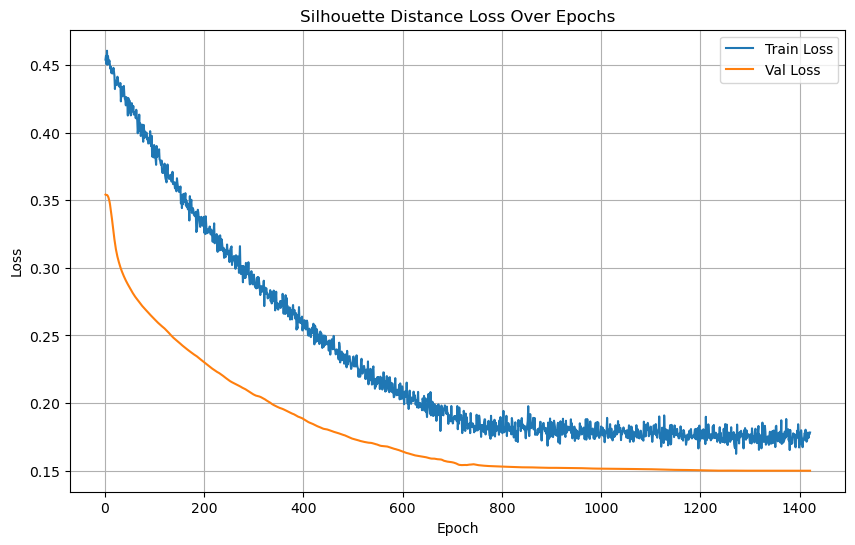

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/843], Loss: 0.0727
Test Batch [20/843], Loss: 0.1174
Test Batch [30/843], Loss: 0.1141
Test Batch [40/843], Loss: 0.1156
Test Batch [50/843], Loss: 0.1153
Test Batch [60/843], Loss: 0.1326
Test Batch [70/843], Loss: 0.5000


Test Batch [80/843], Loss: 0.1784
Test Batch [90/843], Loss: 0.1113
Test Batch [100/843], Loss: 0.2161
Test Batch [110/843], Loss: 0.5000
Test Batch [120/843], Loss: 0.1283
Test Batch [130/843], Loss: 0.1232
Test Batch [140/843], Loss: 0.1133
Test Batch [150/843], Loss: 0.1051


Test Batch [160/843], Loss: 0.1190
Test Batch [170/843], Loss: 0.1161
Test Batch [180/843], Loss: 0.1312
Test Batch [190/843], Loss: 0.1751
Test Batch [200/843], Loss: 0.0936


Test Batch [210/843], Loss: 0.0707
Test Batch [220/843], Loss: 0.0929
Test Batch [230/843], Loss: 0.1090
Test Batch [240/843], Loss: 0.1071


Test Batch [250/843], Loss: 0.0941
Test Batch [260/843], Loss: 0.2230
Test Batch [270/843], Loss: 0.2387


Test Batch [280/843], Loss: 0.2702
Test Batch [290/843], Loss: 0.1755
Test Batch [300/843], Loss: 0.1656
Test Batch [310/843], Loss: 0.1931


Test Batch [320/843], Loss: 0.1561
Test Batch [330/843], Loss: 0.2006
Test Batch [340/843], Loss: 0.2001
Test Batch [350/843], Loss: 0.5000
Test Batch [360/843], Loss: 0.0927
Test Batch [370/843], Loss: 0.5000
Test Batch [380/843], Loss: 0.5000
Test Batch [390/843], Loss: 0.5000
Test Batch [400/843], Loss: 0.5000
Test Batch [410/843], Loss: 0.5000


Test Batch [420/843], Loss: 0.5000
Test Batch [430/843], Loss: 0.0845
Test Batch [440/843], Loss: 0.0889
Test Batch [450/843], Loss: 0.1901
Test Batch [460/843], Loss: 0.0702
Test Batch [470/843], Loss: 0.0856
Test Batch [480/843], Loss: 0.0711
Test Batch [490/843], Loss: 0.5000


Test Batch [500/843], Loss: 0.1489
Test Batch [510/843], Loss: 0.1272
Test Batch [520/843], Loss: 0.1236
Test Batch [530/843], Loss: 0.1730
Test Batch [540/843], Loss: 0.1675


Test Batch [550/843], Loss: 0.5000
Test Batch [560/843], Loss: 0.5000
Test Batch [570/843], Loss: 0.5000
Test Batch [580/843], Loss: 0.1332
Test Batch [590/843], Loss: 0.1456


Test Batch [600/843], Loss: 0.5000
Test Batch [610/843], Loss: 0.1368
Test Batch [620/843], Loss: 0.1274
Test Batch [630/843], Loss: 0.1307
Test Batch [640/843], Loss: 0.1949


Test Batch [650/843], Loss: 0.3701
Test Batch [660/843], Loss: 0.2042
Test Batch [670/843], Loss: 0.1115
Test Batch [680/843], Loss: 0.3064


Test Batch [690/843], Loss: 0.3708
Test Batch [700/843], Loss: 0.1022
Test Batch [710/843], Loss: 0.1890
Test Batch [720/843], Loss: 0.0577
Test Batch [730/843], Loss: 0.2580


Test Batch [740/843], Loss: 0.5000
Test Batch [750/843], Loss: 0.5000
Test Batch [760/843], Loss: 0.0821
Test Batch [770/843], Loss: 0.5000
Test Batch [780/843], Loss: 0.1951
Test Batch [790/843], Loss: 0.5000


Test Batch [800/843], Loss: 0.0639
Test Batch [810/843], Loss: 0.1898
Test Batch [820/843], Loss: 0.5000
Test Batch [830/843], Loss: 0.1312
Test Batch [840/843], Loss: 0.1464

Test Loss: 0.2088


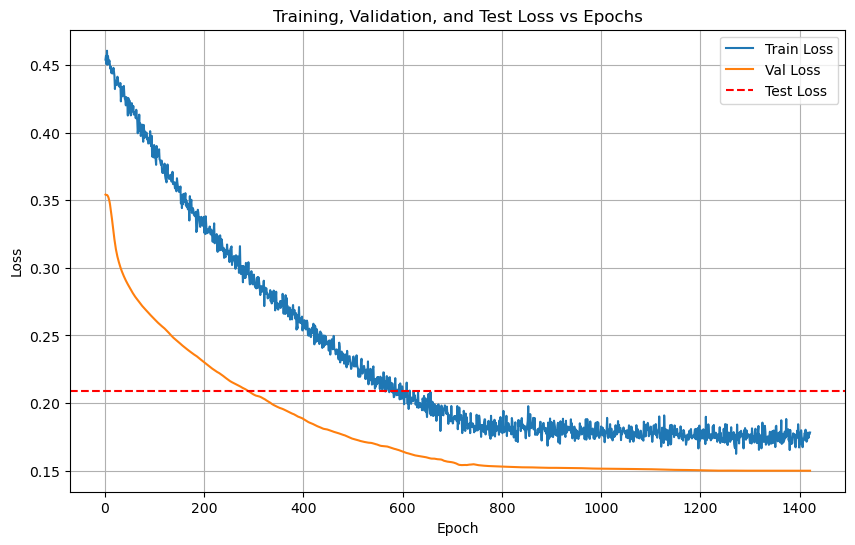

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/843 for test dataset.


  Processed batch 20/843 for test dataset.
  Processed batch 30/843 for test dataset.
  Processed batch 40/843 for test dataset.


  Processed batch 50/843 for test dataset.
  Processed batch 60/843 for test dataset.
  Processed batch 70/843 for test dataset.
  Processed batch 80/843 for test dataset.


  Processed batch 90/843 for test dataset.
  Processed batch 100/843 for test dataset.
  Processed batch 110/843 for test dataset.
  Processed batch 120/843 for test dataset.


  Processed batch 130/843 for test dataset.
  Processed batch 140/843 for test dataset.
  Processed batch 150/843 for test dataset.


  Processed batch 160/843 for test dataset.
  Processed batch 170/843 for test dataset.
  Processed batch 180/843 for test dataset.
  Processed batch 190/843 for test dataset.


  Processed batch 200/843 for test dataset.
  Processed batch 210/843 for test dataset.
  Processed batch 220/843 for test dataset.
  Processed batch 230/843 for test dataset.


  Processed batch 240/843 for test dataset.
  Processed batch 250/843 for test dataset.
  Processed batch 260/843 for test dataset.


  Processed batch 270/843 for test dataset.
  Processed batch 280/843 for test dataset.


  Processed batch 290/843 for test dataset.
  Processed batch 300/843 for test dataset.
  Processed batch 310/843 for test dataset.


  Processed batch 320/843 for test dataset.
  Processed batch 330/843 for test dataset.
  Processed batch 340/843 for test dataset.
  Processed batch 350/843 for test dataset.


  Processed batch 360/843 for test dataset.
  Processed batch 370/843 for test dataset.
  Processed batch 380/843 for test dataset.
  Processed batch 390/843 for test dataset.


  Processed batch 400/843 for test dataset.
  Processed batch 410/843 for test dataset.
  Processed batch 420/843 for test dataset.
  Processed batch 430/843 for test dataset.


  Processed batch 440/843 for test dataset.
  Processed batch 450/843 for test dataset.
  Processed batch 460/843 for test dataset.


  Processed batch 470/843 for test dataset.
  Processed batch 480/843 for test dataset.


  Processed batch 490/843 for test dataset.
  Processed batch 500/843 for test dataset.
  Processed batch 510/843 for test dataset.


  Processed batch 520/843 for test dataset.
  Processed batch 530/843 for test dataset.
  Processed batch 540/843 for test dataset.


  Processed batch 550/843 for test dataset.
  Processed batch 560/843 for test dataset.


  Processed batch 570/843 for test dataset.
  Processed batch 580/843 for test dataset.
  Processed batch 590/843 for test dataset.


  Processed batch 600/843 for test dataset.
  Processed batch 610/843 for test dataset.
  Processed batch 620/843 for test dataset.


  Processed batch 630/843 for test dataset.
  Processed batch 640/843 for test dataset.
  Processed batch 650/843 for test dataset.
  Processed batch 660/843 for test dataset.


  Processed batch 670/843 for test dataset.
  Processed batch 680/843 for test dataset.
  Processed batch 690/843 for test dataset.
  Processed batch 700/843 for test dataset.


  Processed batch 710/843 for test dataset.
  Processed batch 720/843 for test dataset.
  Processed batch 730/843 for test dataset.


  Processed batch 740/843 for test dataset.
  Processed batch 750/843 for test dataset.
  Processed batch 760/843 for test dataset.


  Processed batch 770/843 for test dataset.
  Processed batch 780/843 for test dataset.
  Processed batch 790/843 for test dataset.
  Processed batch 800/843 for test dataset.


  Processed batch 810/843 for test dataset.
  Processed batch 820/843 for test dataset.
  Processed batch 830/843 for test dataset.


  Processed batch 840/843 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (160, 128)
Train labels shape: (160,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (53889, 128)
Test labels shape: (53889,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 85.00%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       0.83      1.00      0.91         5
           3       1.00      1.00      1.00         5
           4       1.00      0.80      0.89         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       0.22      0.40      0.29         5
           8       1.00      1.00      1.00         5
           9       1.00      0.80      0.89         5
          10       1.00      1.00      1.00         5
          11       1.00      1.00      1.00         5
          12       1.00      1.00      1.00         5
          13       1.0

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (160, 128)
Train labels shape: (160,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (53889, 128)
Test labels shape: (53889,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.8150  |  Val Loss: 2.7576
Validation loss improved from inf to 2.7576.
[Epoch 2/1000] Train Loss: 2.7821  |  Val Loss: 2.7321
Validation loss improved from 2.7576 to 2.7321.
[Epoch 3/1000] Train Loss: 2.7475  |  Val Loss: 2.7078
Validation loss improved from 2.7321 to 2.7078.
[Epoch 4/1000] Train Loss: 2.7192  |  Val Loss: 2.6840
Validation loss improved from 2.7078 to 2.6840.
[Epoch 5/1000] Train Loss: 2.6918  |  Val Loss: 2.6614
Validation loss improved from 2.6840 to 2.6614.
[Epoch 6/1000] Train Loss: 2.6653  |  Val Loss: 2.6397
Validation loss improved from 2.6614 to 2.6397.
[Epoch 7/1000] Train Loss: 2.6387  |  Val Loss: 2.6185
Validation loss improved from 2.6397 to 2.6185.
[Epoch 8/1000] Train Loss: 2.6150  |  Val Loss: 2.5977
Validation loss improved from 2.6185 to 2.5977.
[Epoch 9/1000] Train Loss: 2.5899  |  Val Loss: 2.5777
Validation loss improved from 2.5977 to 2.5777.
[Epoch 10/1000] Train Loss: 2.5663  |  Val Loss: 2.5582
Validation loss impr

[Epoch 26/1000] Train Loss: 2.2791  |  Val Loss: 2.2996
Validation loss improved from 2.3135 to 2.2996.


[Epoch 27/1000] Train Loss: 2.2648  |  Val Loss: 2.2860
Validation loss improved from 2.2996 to 2.2860.
[Epoch 28/1000] Train Loss: 2.2506  |  Val Loss: 2.2725
Validation loss improved from 2.2860 to 2.2725.
[Epoch 29/1000] Train Loss: 2.2368  |  Val Loss: 2.2593
Validation loss improved from 2.2725 to 2.2593.
[Epoch 30/1000] Train Loss: 2.2230  |  Val Loss: 2.2462
Validation loss improved from 2.2593 to 2.2462.
[Epoch 31/1000] Train Loss: 2.2092  |  Val Loss: 2.2331
Validation loss improved from 2.2462 to 2.2331.
[Epoch 32/1000] Train Loss: 2.1950  |  Val Loss: 2.2199
Validation loss improved from 2.2331 to 2.2199.
[Epoch 33/1000] Train Loss: 2.1814  |  Val Loss: 2.2063
Validation loss improved from 2.2199 to 2.2063.
[Epoch 34/1000] Train Loss: 2.1672  |  Val Loss: 2.1928
Validation loss improved from 2.2063 to 2.1928.
[Epoch 35/1000] Train Loss: 2.1526  |  Val Loss: 2.1793
Validation loss improved from 2.1928 to 2.1793.
[Epoch 36/1000] Train Loss: 2.1390  |  Val Loss: 2.1656
Validati

[Epoch 57/1000] Train Loss: 1.8431  |  Val Loss: 1.8939
Validation loss improved from 1.9060 to 1.8939.
[Epoch 58/1000] Train Loss: 1.8303  |  Val Loss: 1.8816
Validation loss improved from 1.8939 to 1.8816.
[Epoch 59/1000] Train Loss: 1.8168  |  Val Loss: 1.8696
Validation loss improved from 1.8816 to 1.8696.
[Epoch 60/1000] Train Loss: 1.8029  |  Val Loss: 1.8576
Validation loss improved from 1.8696 to 1.8576.
[Epoch 61/1000] Train Loss: 1.7899  |  Val Loss: 1.8456
Validation loss improved from 1.8576 to 1.8456.
[Epoch 62/1000] Train Loss: 1.7763  |  Val Loss: 1.8336
Validation loss improved from 1.8456 to 1.8336.
[Epoch 63/1000] Train Loss: 1.7631  |  Val Loss: 1.8217
Validation loss improved from 1.8336 to 1.8217.
[Epoch 64/1000] Train Loss: 1.7497  |  Val Loss: 1.8099
Validation loss improved from 1.8217 to 1.8099.
[Epoch 65/1000] Train Loss: 1.7362  |  Val Loss: 1.7979
Validation loss improved from 1.8099 to 1.7979.
[Epoch 66/1000] Train Loss: 1.7230  |  Val Loss: 1.7859
Validati

[Epoch 86/1000] Train Loss: 1.4414  |  Val Loss: 1.5333
Validation loss improved from 1.5463 to 1.5333.
[Epoch 87/1000] Train Loss: 1.4267  |  Val Loss: 1.5204
Validation loss improved from 1.5333 to 1.5204.
[Epoch 88/1000] Train Loss: 1.4125  |  Val Loss: 1.5076
Validation loss improved from 1.5204 to 1.5076.
[Epoch 89/1000] Train Loss: 1.3979  |  Val Loss: 1.4948
Validation loss improved from 1.5076 to 1.4948.
[Epoch 90/1000] Train Loss: 1.3834  |  Val Loss: 1.4821
Validation loss improved from 1.4948 to 1.4821.
[Epoch 91/1000] Train Loss: 1.3693  |  Val Loss: 1.4694
Validation loss improved from 1.4821 to 1.4694.
[Epoch 92/1000] Train Loss: 1.3551  |  Val Loss: 1.4566
Validation loss improved from 1.4694 to 1.4566.
[Epoch 93/1000] Train Loss: 1.3411  |  Val Loss: 1.4439
Validation loss improved from 1.4566 to 1.4439.
[Epoch 94/1000] Train Loss: 1.3268  |  Val Loss: 1.4315
Validation loss improved from 1.4439 to 1.4315.
[Epoch 95/1000] Train Loss: 1.3129  |  Val Loss: 1.4191
Validati

[Epoch 114/1000] Train Loss: 1.0560  |  Val Loss: 1.1976
Validation loss improved from 1.2086 to 1.1976.
[Epoch 115/1000] Train Loss: 1.0429  |  Val Loss: 1.1867
Validation loss improved from 1.1976 to 1.1867.
[Epoch 116/1000] Train Loss: 1.0299  |  Val Loss: 1.1756
Validation loss improved from 1.1867 to 1.1756.
[Epoch 117/1000] Train Loss: 1.0168  |  Val Loss: 1.1646
Validation loss improved from 1.1756 to 1.1646.
[Epoch 118/1000] Train Loss: 1.0038  |  Val Loss: 1.1535
Validation loss improved from 1.1646 to 1.1535.
[Epoch 119/1000] Train Loss: 0.9910  |  Val Loss: 1.1425
Validation loss improved from 1.1535 to 1.1425.
[Epoch 120/1000] Train Loss: 0.9782  |  Val Loss: 1.1318
Validation loss improved from 1.1425 to 1.1318.
[Epoch 121/1000] Train Loss: 0.9658  |  Val Loss: 1.1213
Validation loss improved from 1.1318 to 1.1213.
[Epoch 122/1000] Train Loss: 0.9531  |  Val Loss: 1.1110
Validation loss improved from 1.1213 to 1.1110.
[Epoch 123/1000] Train Loss: 0.9409  |  Val Loss: 1.101

[Epoch 145/1000] Train Loss: 0.6957  |  Val Loss: 0.9044
Validation loss improved from 0.9124 to 0.9044.
[Epoch 146/1000] Train Loss: 0.6856  |  Val Loss: 0.8965
Validation loss improved from 0.9044 to 0.8965.
[Epoch 147/1000] Train Loss: 0.6755  |  Val Loss: 0.8889
Validation loss improved from 0.8965 to 0.8889.
[Epoch 148/1000] Train Loss: 0.6659  |  Val Loss: 0.8809
Validation loss improved from 0.8889 to 0.8809.
[Epoch 149/1000] Train Loss: 0.6565  |  Val Loss: 0.8729
Validation loss improved from 0.8809 to 0.8729.
[Epoch 150/1000] Train Loss: 0.6469  |  Val Loss: 0.8652
Validation loss improved from 0.8729 to 0.8652.
[Epoch 151/1000] Train Loss: 0.6370  |  Val Loss: 0.8580
Validation loss improved from 0.8652 to 0.8580.
[Epoch 152/1000] Train Loss: 0.6274  |  Val Loss: 0.8507
Validation loss improved from 0.8580 to 0.8507.
[Epoch 153/1000] Train Loss: 0.6183  |  Val Loss: 0.8437
Validation loss improved from 0.8507 to 0.8437.
[Epoch 154/1000] Train Loss: 0.6088  |  Val Loss: 0.836

[Epoch 174/1000] Train Loss: 0.4434  |  Val Loss: 0.7093
Validation loss improved from 0.7150 to 0.7093.
[Epoch 175/1000] Train Loss: 0.4364  |  Val Loss: 0.7034
Validation loss improved from 0.7093 to 0.7034.
[Epoch 176/1000] Train Loss: 0.4290  |  Val Loss: 0.6979
Validation loss improved from 0.7034 to 0.6979.
[Epoch 177/1000] Train Loss: 0.4218  |  Val Loss: 0.6923
Validation loss improved from 0.6979 to 0.6923.
[Epoch 178/1000] Train Loss: 0.4145  |  Val Loss: 0.6870
Validation loss improved from 0.6923 to 0.6870.
[Epoch 179/1000] Train Loss: 0.4078  |  Val Loss: 0.6818
Validation loss improved from 0.6870 to 0.6818.
[Epoch 180/1000] Train Loss: 0.4009  |  Val Loss: 0.6766
Validation loss improved from 0.6818 to 0.6766.
[Epoch 181/1000] Train Loss: 0.3939  |  Val Loss: 0.6716
Validation loss improved from 0.6766 to 0.6716.
[Epoch 182/1000] Train Loss: 0.3871  |  Val Loss: 0.6666
Validation loss improved from 0.6716 to 0.6666.
[Epoch 183/1000] Train Loss: 0.3805  |  Val Loss: 0.661

[Epoch 204/1000] Train Loss: 0.2638  |  Val Loss: 0.5704
Validation loss improved from 0.5740 to 0.5704.
[Epoch 205/1000] Train Loss: 0.2592  |  Val Loss: 0.5668
Validation loss improved from 0.5704 to 0.5668.
[Epoch 206/1000] Train Loss: 0.2549  |  Val Loss: 0.5634
Validation loss improved from 0.5668 to 0.5634.
[Epoch 207/1000] Train Loss: 0.2505  |  Val Loss: 0.5603
Validation loss improved from 0.5634 to 0.5603.
[Epoch 208/1000] Train Loss: 0.2462  |  Val Loss: 0.5573
Validation loss improved from 0.5603 to 0.5573.
[Epoch 209/1000] Train Loss: 0.2422  |  Val Loss: 0.5543
Validation loss improved from 0.5573 to 0.5543.
[Epoch 210/1000] Train Loss: 0.2381  |  Val Loss: 0.5516
Validation loss improved from 0.5543 to 0.5516.
[Epoch 211/1000] Train Loss: 0.2339  |  Val Loss: 0.5490
Validation loss improved from 0.5516 to 0.5490.
[Epoch 212/1000] Train Loss: 0.2301  |  Val Loss: 0.5463
Validation loss improved from 0.5490 to 0.5463.
[Epoch 213/1000] Train Loss: 0.2263  |  Val Loss: 0.543

[Epoch 236/1000] Train Loss: 0.1566  |  Val Loss: 0.4907
Validation loss improved from 0.4930 to 0.4907.
[Epoch 237/1000] Train Loss: 0.1543  |  Val Loss: 0.4889
Validation loss improved from 0.4907 to 0.4889.
[Epoch 238/1000] Train Loss: 0.1520  |  Val Loss: 0.4871
Validation loss improved from 0.4889 to 0.4871.
[Epoch 239/1000] Train Loss: 0.1497  |  Val Loss: 0.4854
Validation loss improved from 0.4871 to 0.4854.
[Epoch 240/1000] Train Loss: 0.1476  |  Val Loss: 0.4838
Validation loss improved from 0.4854 to 0.4838.
[Epoch 241/1000] Train Loss: 0.1455  |  Val Loss: 0.4822
Validation loss improved from 0.4838 to 0.4822.
[Epoch 242/1000] Train Loss: 0.1435  |  Val Loss: 0.4806
Validation loss improved from 0.4822 to 0.4806.
[Epoch 243/1000] Train Loss: 0.1414  |  Val Loss: 0.4793
Validation loss improved from 0.4806 to 0.4793.
[Epoch 244/1000] Train Loss: 0.1393  |  Val Loss: 0.4784
Validation loss improved from 0.4793 to 0.4784.
[Epoch 245/1000] Train Loss: 0.1374  |  Val Loss: 0.477

[Epoch 267/1000] Train Loss: 0.1030  |  Val Loss: 0.4540
Validation loss improved from 0.4545 to 0.4540.
[Epoch 268/1000] Train Loss: 0.1017  |  Val Loss: 0.4535
Validation loss improved from 0.4540 to 0.4535.
[Epoch 269/1000] Train Loss: 0.1006  |  Val Loss: 0.4528
Validation loss improved from 0.4535 to 0.4528.
[Epoch 270/1000] Train Loss: 0.0993  |  Val Loss: 0.4523
Validation loss improved from 0.4528 to 0.4523.
[Epoch 271/1000] Train Loss: 0.0981  |  Val Loss: 0.4516
Validation loss improved from 0.4523 to 0.4516.
[Epoch 272/1000] Train Loss: 0.0970  |  Val Loss: 0.4510
Validation loss improved from 0.4516 to 0.4510.
[Epoch 273/1000] Train Loss: 0.0959  |  Val Loss: 0.4505
Validation loss improved from 0.4510 to 0.4505.
[Epoch 274/1000] Train Loss: 0.0949  |  Val Loss: 0.4502
Validation loss improved from 0.4505 to 0.4502.
[Epoch 275/1000] Train Loss: 0.0937  |  Val Loss: 0.4495
Validation loss improved from 0.4502 to 0.4495.
[Epoch 276/1000] Train Loss: 0.0926  |  Val Loss: 0.448

[Epoch 295/1000] Train Loss: 0.0759  |  Val Loss: 0.4375
Validation loss improved from 0.4380 to 0.4375.
[Epoch 296/1000] Train Loss: 0.0751  |  Val Loss: 0.4372
Validation loss improved from 0.4375 to 0.4372.
[Epoch 297/1000] Train Loss: 0.0743  |  Val Loss: 0.4367
Validation loss improved from 0.4372 to 0.4367.
[Epoch 298/1000] Train Loss: 0.0736  |  Val Loss: 0.4363
Validation loss improved from 0.4367 to 0.4363.
[Epoch 299/1000] Train Loss: 0.0729  |  Val Loss: 0.4356
Validation loss improved from 0.4363 to 0.4356.
[Epoch 300/1000] Train Loss: 0.0722  |  Val Loss: 0.4350
Validation loss improved from 0.4356 to 0.4350.
[Epoch 301/1000] Train Loss: 0.0715  |  Val Loss: 0.4343
Validation loss improved from 0.4350 to 0.4343.
[Epoch 302/1000] Train Loss: 0.0709  |  Val Loss: 0.4337
Validation loss improved from 0.4343 to 0.4337.
[Epoch 303/1000] Train Loss: 0.0702  |  Val Loss: 0.4333
Validation loss improved from 0.4337 to 0.4333.
[Epoch 304/1000] Train Loss: 0.0695  |  Val Loss: 0.432

[Epoch 326/1000] Train Loss: 0.0574  |  Val Loss: 0.4252
Validation loss improved from 0.4257 to 0.4252.
[Epoch 327/1000] Train Loss: 0.0569  |  Val Loss: 0.4249
Validation loss improved from 0.4252 to 0.4249.
[Epoch 328/1000] Train Loss: 0.0565  |  Val Loss: 0.4243
Validation loss improved from 0.4249 to 0.4243.
[Epoch 329/1000] Train Loss: 0.0561  |  Val Loss: 0.4242
Validation loss improved from 0.4243 to 0.4242.
[Epoch 330/1000] Train Loss: 0.0556  |  Val Loss: 0.4238
Validation loss improved from 0.4242 to 0.4238.
[Epoch 331/1000] Train Loss: 0.0552  |  Val Loss: 0.4234
Validation loss improved from 0.4238 to 0.4234.
[Epoch 332/1000] Train Loss: 0.0547  |  Val Loss: 0.4236
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 333/1000] Train Loss: 0.0542  |  Val Loss: 0.4235
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 334/1000] Train Loss: 0.0539  |  Val Loss: 0.4233
Validation loss improved from 0.4234 to 0.4233.
[Epoch 335/1000] Train Loss: 0.0534  |  Val

[Epoch 357/1000] Train Loss: 0.0455  |  Val Loss: 0.4222
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 358/1000] Train Loss: 0.0451  |  Val Loss: 0.4214
Validation loss improved from 0.4214 to 0.4214.
[Epoch 359/1000] Train Loss: 0.0448  |  Val Loss: 0.4208
Validation loss improved from 0.4214 to 0.4208.
[Epoch 360/1000] Train Loss: 0.0445  |  Val Loss: 0.4199
Validation loss improved from 0.4208 to 0.4199.
[Epoch 361/1000] Train Loss: 0.0443  |  Val Loss: 0.4193
Validation loss improved from 0.4199 to 0.4193.
[Epoch 362/1000] Train Loss: 0.0439  |  Val Loss: 0.4193
Validation loss improved from 0.4193 to 0.4193.
[Epoch 363/1000] Train Loss: 0.0437  |  Val Loss: 0.4195
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 364/1000] Train Loss: 0.0433  |  Val Loss: 0.4191
Validation loss improved from 0.4193 to 0.4191.
[Epoch 365/1000] Train Loss: 0.0431  |  Val Loss: 0.4187
Validation loss improved from 0.4191 to 0.4187.
[Epoch 366/1000] Train Loss: 0.0427  |  Val

[Epoch 386/1000] Train Loss: 0.0378  |  Val Loss: 0.4212
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 387/1000] Train Loss: 0.0375  |  Val Loss: 0.4216
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 388/1000] Train Loss: 0.0375  |  Val Loss: 0.4225
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 389/1000] Train Loss: 0.0372  |  Val Loss: 0.4221
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 390/1000] Train Loss: 0.0369  |  Val Loss: 0.4218
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 391/1000] Train Loss: 0.0367  |  Val Loss: 0.4215
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 392/1000] Train Loss: 0.0365  |  Val Loss: 0.4210
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 393/1000] Train Loss: 0.0363  |  Val Loss: 0.4206
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 394/1000] Train Loss: 0.0361  |  Val Loss: 0.4201
!! Validation loss did NOT improve !! Patience:

[Epoch 413/1000] Train Loss: 0.0325  |  Val Loss: 0.4191
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 414/1000] Train Loss: 0.0323  |  Val Loss: 0.4189
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 415/1000] Train Loss: 0.0322  |  Val Loss: 0.4188
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 416/1000] Train Loss: 0.0320  |  Val Loss: 0.4186
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 417/1000] Train Loss: 0.0318  |  Val Loss: 0.4186
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 418/1000] Train Loss: 0.0317  |  Val Loss: 0.4192
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 419/1000] Train Loss: 0.0315  |  Val Loss: 0.4193
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 420/1000] Train Loss: 0.0314  |  Val Loss: 0.4191
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 421/1000] Train Loss: 0.0312  |  Val Loss: 0.4195
!! Validation loss did NOT improve !! Patience: 14/

[Epoch 442/1000] Train Loss: 0.0282  |  Val Loss: 0.4155
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 443/1000] Train Loss: 0.0280  |  Val Loss: 0.4156
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 444/1000] Train Loss: 0.0279  |  Val Loss: 0.4156
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 445/1000] Train Loss: 0.0278  |  Val Loss: 0.4155
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 446/1000] Train Loss: 0.0277  |  Val Loss: 0.4155
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 447/1000] Train Loss: 0.0275  |  Val Loss: 0.4154
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 448/1000] Train Loss: 0.0274  |  Val Loss: 0.4156
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 449/1000] Train Loss: 0.0273  |  Val Loss: 0.4158
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 450/1000] Train Loss: 0.0272  |  Val Loss: 0.4159
!! Validation loss did NOT improve !! Patience:

[Epoch 471/1000] Train Loss: 0.0248  |  Val Loss: 0.4200
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 472/1000] Train Loss: 0.0247  |  Val Loss: 0.4203
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 473/1000] Train Loss: 0.0246  |  Val Loss: 0.4214
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 474/1000] Train Loss: 0.0245  |  Val Loss: 0.4224
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 475/1000] Train Loss: 0.0244  |  Val Loss: 0.4236
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 476/1000] Train Loss: 0.0244  |  Val Loss: 0.4241
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 477/1000] Train Loss: 0.0243  |  Val Loss: 0.4236
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 478/1000] Train Loss: 0.0242  |  Val Loss: 0.4231
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 479/1000] Train Loss: 0.0242  |  Val Loss: 0.4221
!! Validation loss did NOT improve !! Patience:

[Epoch 502/1000] Train Loss: 0.0220  |  Val Loss: 0.4200
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 503/1000] Train Loss: 0.0219  |  Val Loss: 0.4208
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 504/1000] Train Loss: 0.0218  |  Val Loss: 0.4208
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 505/1000] Train Loss: 0.0217  |  Val Loss: 0.4215
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 506/1000] Train Loss: 0.0217  |  Val Loss: 0.4228
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 507/1000] Train Loss: 0.0215  |  Val Loss: 0.4234
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 508/1000] Train Loss: 0.0214  |  Val Loss: 0.4244
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 509/1000] Train Loss: 0.0213  |  Val Loss: 0.4257
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 510/1000] Train Loss: 0.0213  |  Val Loss: 0.4264
!! Validation loss did NOT improve !! Patience:

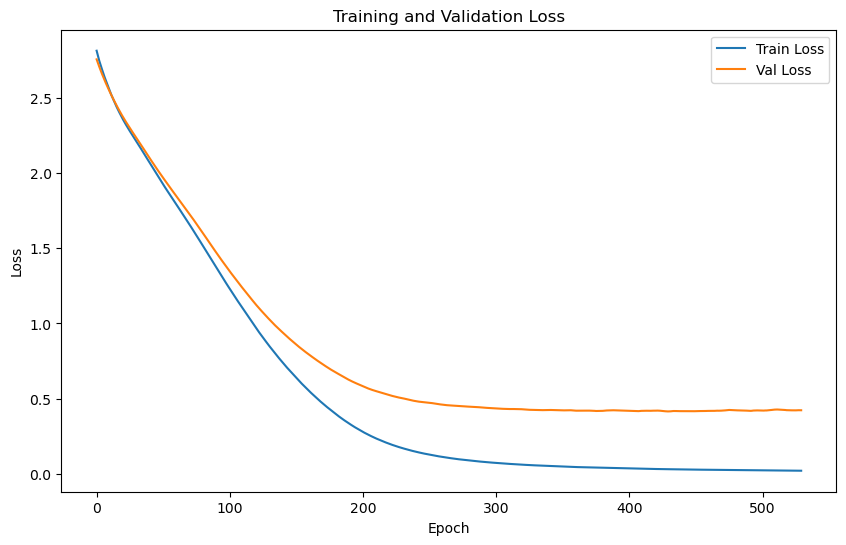

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 0.7215 | Test Accuracy: 85.23%


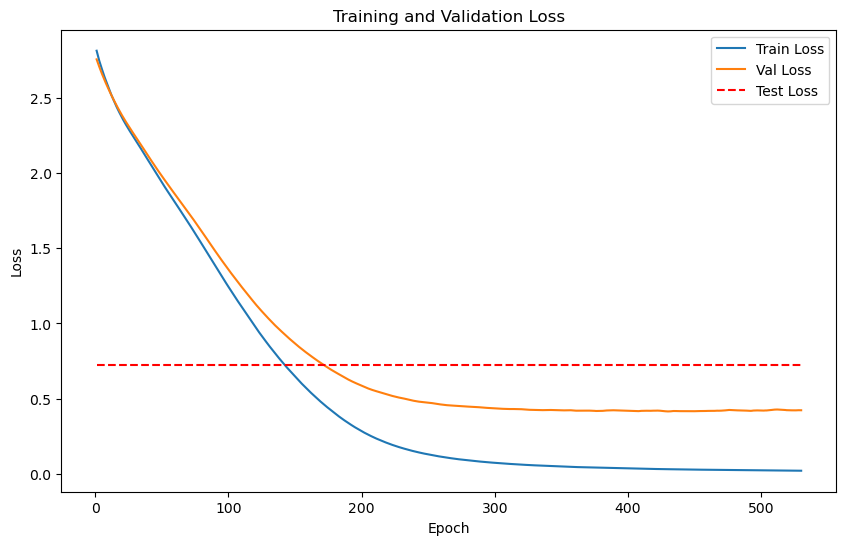

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


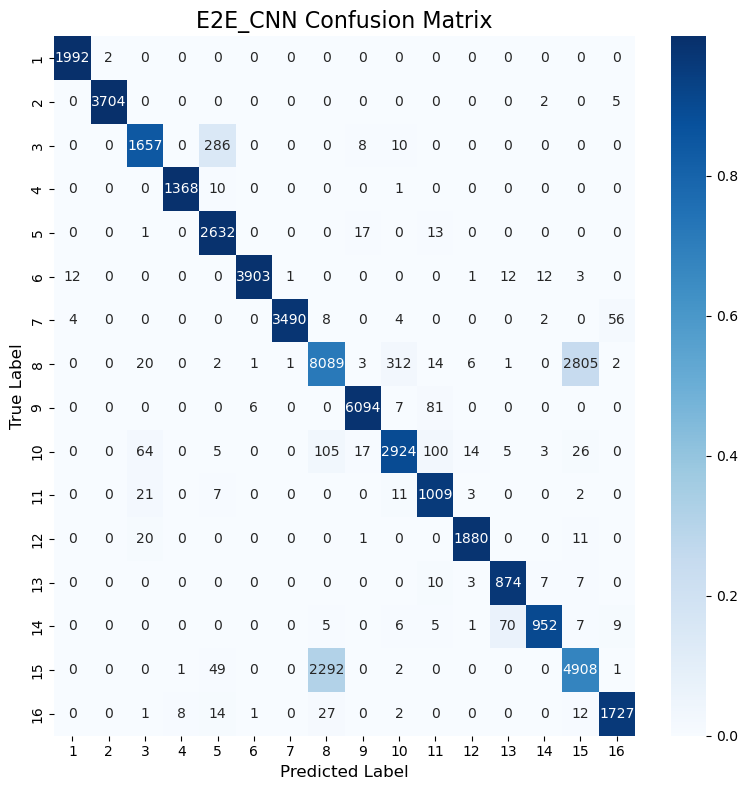

Classification Accuracy: 87.59%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


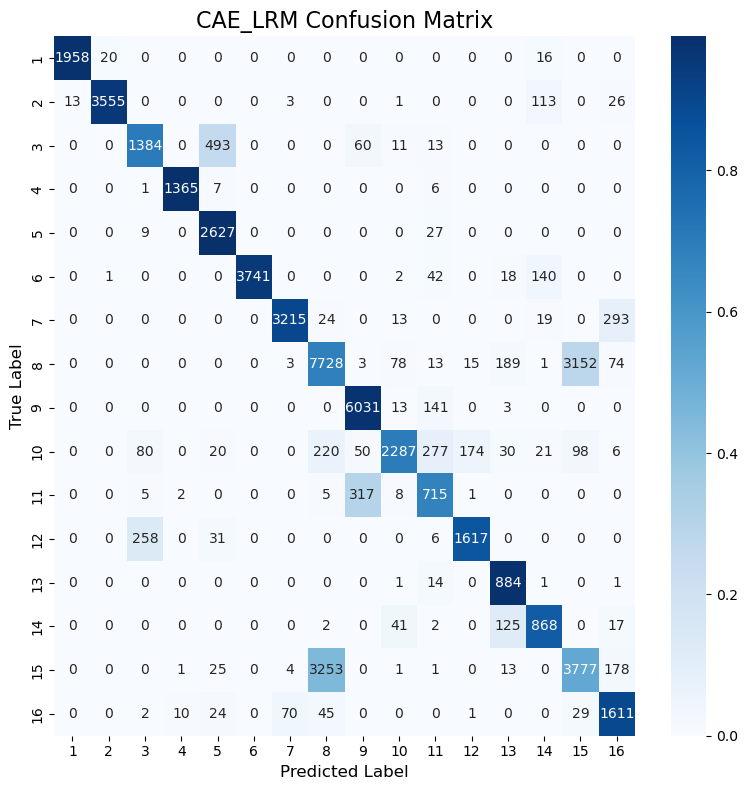

Classification Accuracy: 80.47%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


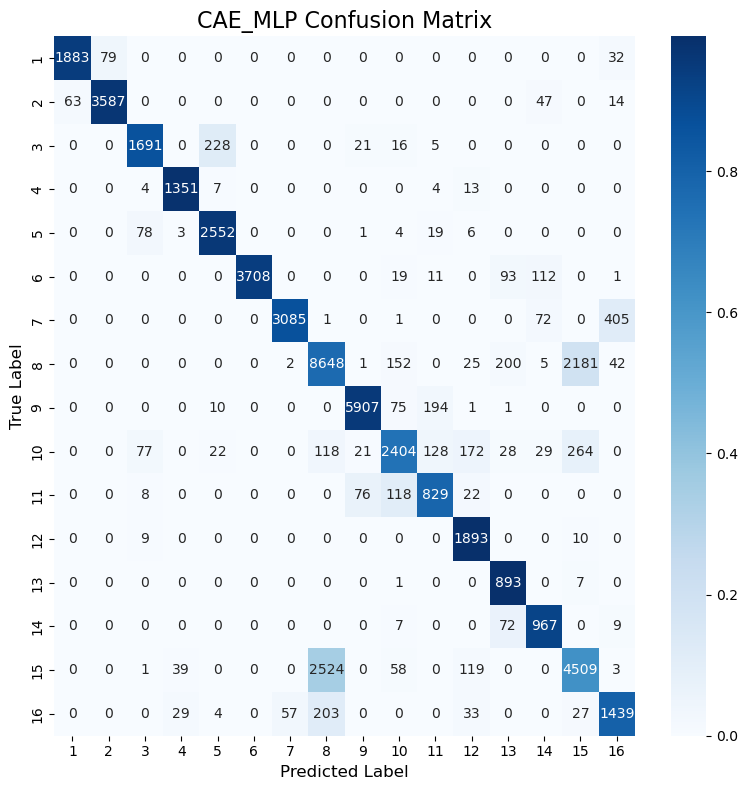

Classification Accuracy: 84.15%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


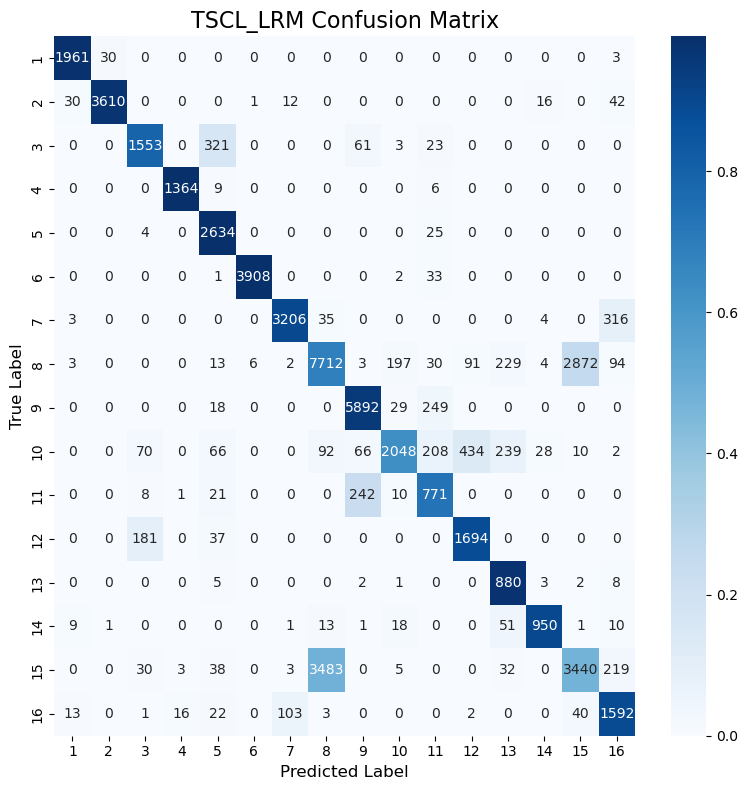

Classification Accuracy: 80.19%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


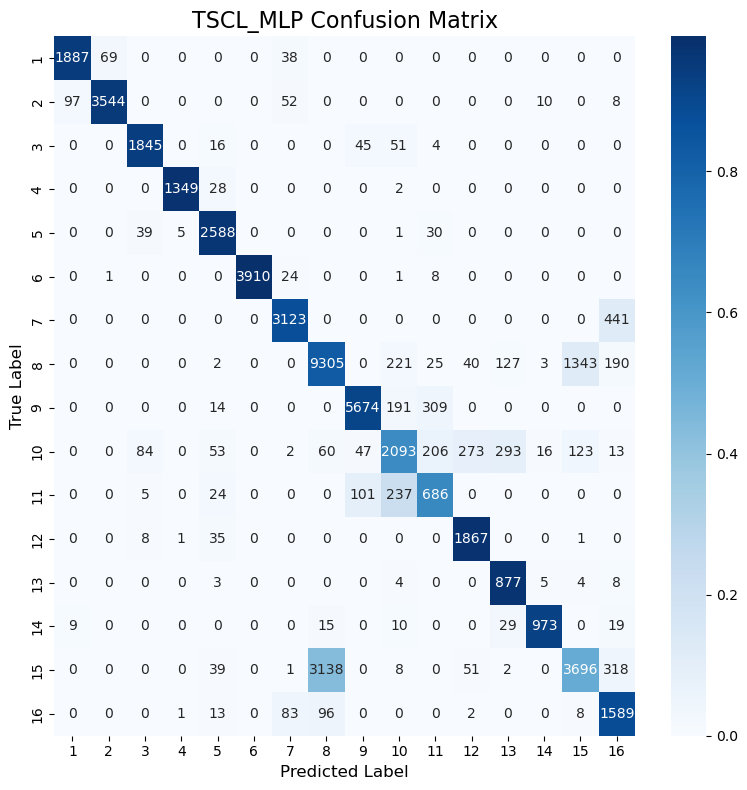

Classification Accuracy: 83.52%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


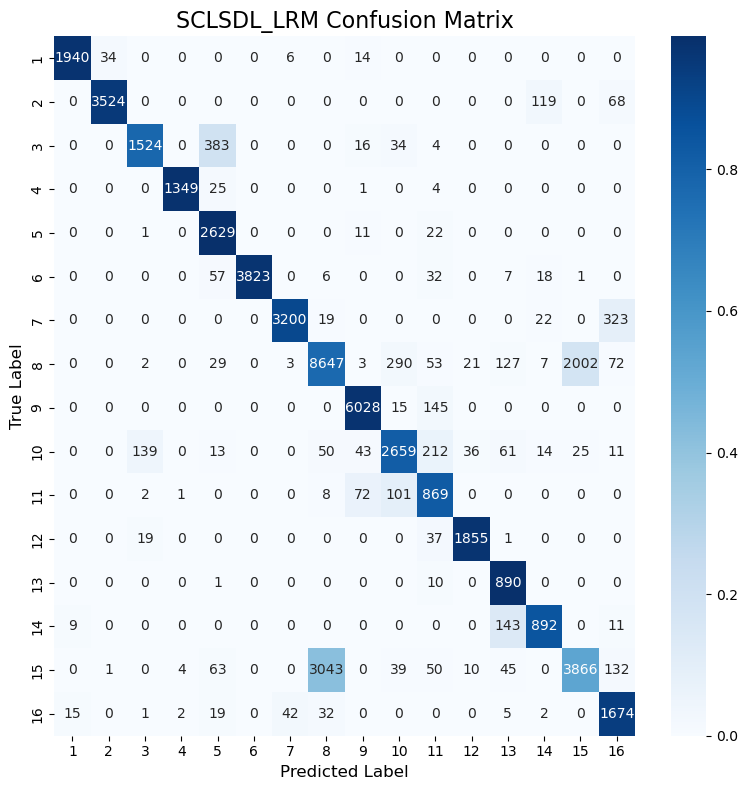

Classification Accuracy: 84.19%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


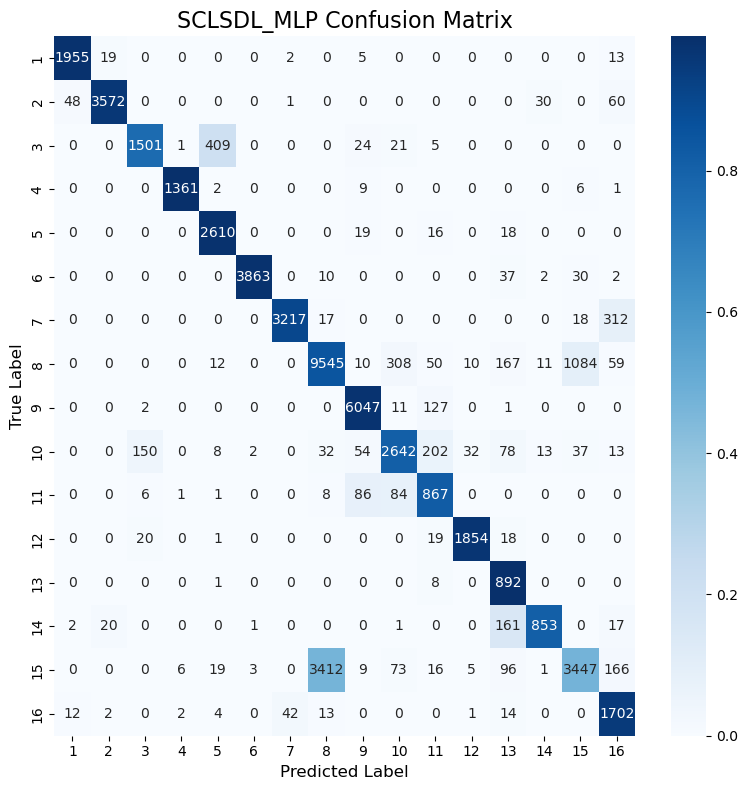

Classification Accuracy: 85.23%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          87.59
1    LRM (CAE)          80.47
2    MLP (CAE)          84.15
3     TSCL LRM          80.19
4     TSCL MLP          83.52
5  SCL_SDL LRM          84.19
6  SCL_SDL MLP          85.23

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          87.59
6  SCL_SDL MLP          85.23
5  SCL_SDL LRM          84.19
2    MLP (CAE)          84.15
4     TSCL MLP          83.52
1    LRM (CAE)          80.47
3     TSCL LRM          80.19
